

# Reactor Modeling - Ethylbenze + Xylene Isomers Reaction System

<br>

This analysis aims to study the effects of temperature, pressure and feed composition on the chemical reaction system by modeling the reactor system.

Also, a kinetic study is performed about the mechanism of reaction

<br>

## 1. Hypotheses about the system

<br>

- stationary state with a radial flow
- reactions follow a Langmuir Hinshelwoold mechanism
- all reactions considered are reversible
- ethylbenzene conversion occur at a different site from isomerization reactions (dual site models)
- for all reactions, the limiting step is the reaction and not the adsorption on the catalyst
- for ethylbenzene conversion reactions, the products are rapdly liberated to gaseous phase after reaction
- all gases are considered to be ideal
- at phase 1, only Ethylbenzene and Xylene isomers were considered to be at the system
- the reference state for all components is ideal gas at 25 °C and at 1 bar
- the pressure drop along the fixed bed is given by Ergun's equation

The following reactions are considered in this analysis:

$$(1) - Ethylbenzene \Longleftrightarrow ortho-Xylene$$

$$(2) - Ethylbenzene \Longleftrightarrow meta-Xylene$$

$$(3) - Ethylbenzene \Longleftrightarrow para-Xylene$$

$$(4) - ortho-Xylene \Longleftrightarrow meta-Xylene$$

$$(5) - ortho-Xylene \Longleftrightarrow para-Xylene$$

$$(6) - meta-Xylene \Longleftrightarrow para-Xylene$$

<br>

## 2. Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import math as m
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
from geneticalgorithm import geneticalgorithm as ga

warnings.filterwarnings('ignore')

# important constants
R = 8.314472                                                           # ideal gas universal constant (J/mol.K)
R_e = 2.594/2                                                          # external bed radius (m)
R_i = 0.240                                                            # internal bed radius (m)
h_R = 6.22                                                             # bed height (m)
Dp = 5*(10**-6)                                                        # catalyst average diameter (m)
W = 20880                                                              # catalyst total load (kg)
rhoc = 1790*(1.125)                                                    # catalyst density (kg/m³)
phi = (1-W/(rhoc*m.pi*h_R*((R_e**2)-(R_i**2))))                        # bed void fraction

## 3. Physical and Chemical Properties, Stoichiometry Definition

In [2]:
# dictionary which contains all physical and chemical data for the compounds
pc_data = {
    'MM': 106.165,
    'comp_list': ['EB', 'oX', 'mX', 'pX'],
    'vapor_viscosity':{
        'EB':{
            'C1': 4.2231*(10**-7),
            'C2': 0.58154,
            'C3': 239.21,
            'C4': 0
        },
        'oX':{
            'C1': 8.3436*(10**-7),
            'C2': 0.49713,
            'C3': 365.86,
            'C4': 0
        },
        'mX':{
            'C1': 6.8293*(10**-7),
            'C2': 0.52199,
            'C3': 324.17,
            'C4': 0
        },
        'pX':{
            'C1': 9.3485*(10**-7),
            'C2': 0.47683,
            'C3': 371.96,
            'C4': 0
        }
    },
    'IdealGasCp': {
        'EB': {
            'C1': 0.7844*(10**5),
            'C2': 3.399*(10**5),
            'C3': 1.559*(10**3),
            'C4': 2.426*(10**5),
            'C5': 702
        },
        'oX': {
            'C1': 0.8521*(10**5),
            'C2': 3.2954*(10**5),
            'C3': 1.4944*(10**3),
            'C4': 2.115*(10**5),
            'C5': 675.8
        },
        'pX': {
            'C1': 0.7512*(10**5),
            'C2': 3.2954*(10**5),
            'C3': 1.4928*(10**3),
            'C4': 2.247*(10**5),
            'C5': 675.1
        },
        'mX': {
            'C1': 0.7568*(10**5),
            'C2': 3.3924*(10**5),
            'C3': 1.496*(10**3),
            'C4': 2.247*(10**5),
            'C5': 675.9
        },
    },
    'H0f': {
        'EB': 2.992*(10**7),
        'oX': 1.908*(10**7),
        'pX': 1.803*(10**7),
        'mX': 1.732*(10**7),
    },
    'S0f': {
        'EB': 3.6063*(10**5),
        'oX': 3.5383*(10**5),
        'pX': 3.52165*(10**5),
        'mX': 3.5854*(10**5)
    },
    'H_ads':{
        'EB': -4000,
        'oX': -4000,
        'mX': -4000,
        'pX': -4000
    },
    'K_ref':{
        'EB': 1,
        'oX': 1,
        'mX': 1,
        'pX': 1
    },
    'K_ads':{
        'EB': 1,
        'oX': 1,
        'mX': 1,
        'pX': 1
    },
    'partial_pressure':{
        'EB': 3.75,
        'oX': 3.75,
        'mX': 3.75,
        'pX': 3.75
    }
}

# definition of dictionary to ensure ordering
kinetic_dict = {
    'reactions': {
        1: 'Ethylbenzene <---> ortho-Xylene',
        2: 'Ethylbenzene <---> meta-Xylene',
        3: 'Ethylbenzene <---> para-Xylene',
        4: 'ortho-Xylene <---> meta-Xylene',
        5: 'ortho-Xylene <---> para-Xylene',
        6: 'meta-Xylene <---> para-Xylene'
    },
    'stoic':{
        1: [-1, 1, 0, 0],
        2: [-1, 0, 1, 0],
        3: [-1, 0, 0, 1],
        4: [0, -1, 1, 0],
        5: [0, -1, 0, 1],
        6: [0, 0, -1, 1]
    },
    'pre_exponential':{
        1: 0.001,
        2: 0.001,
        3: 0.001,
        4: 0.001,
        5: 0.001,
        6: 0.001
    },
    'activation_energy':{
        1: 35000,
        2: 35000,
        3: 35000,
        4: 35000,
        5: 35000,
        6: 35000,
    },
    'kinetic_constants':{
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 1
    },
    'reaction_rates':{
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 1
    },
    'equilibrium_constant':{
        1: 1.5,
        2: 1.5,
        3: 1.5,
        4: 1.5,
        5: 1.5,
        6: 1.5
    },
    'heat_reaction':{
        1: 1.5,
        2: 1.5,
        3: 1.5,
        4: 1.5,
        5: 1.5,
        6: 1.5
    }
}

## 4. Functions for Calculating Physical and Chemical Properties

<br>

##### Ideal Gas Heat Capacity - Cp in J/kmol.K and T in K

$$C_{p}^{i.g.} = C_1 + C_2\Bigg[\frac{\frac{C_3}{T}}{sinh(\frac{C_3}{T})}\Bigg]^2 + C_4\Bigg[\frac{\frac{C_5}{T}}{cosh(\frac{C_5}{T})}\Bigg]^2$$

<br>

##### Vapor Viscosity - $\mu$ in Pa.s

$$\mu = \frac{C_1 T^{C_2}}{1+\frac{C_3}{T}+\frac{C_4}{T^2}}$$

<br>

##### Mixing rule for ideal gas mixtures viscosity

$$\mu_{mixture}=\sum_{i=1}^N\frac{y_i \mu_i}{\sum_{j=1}^N y_j \phi_{ij}}$$

$$\phi_{ij}=\frac{\Bigg[1+\sqrt{\frac{\mu_i}{\mu_j}}\Bigg(\frac{M_j}{M_i}\Bigg)^{1/4}\Bigg]^2}{\frac{4}{\sqrt{2}}\sqrt{1+\frac{M_i}{M_j}}}$$

Where $M_i$ is the molar mass of the component $i$

<br>

##### Ideal Gas mixture density - $\rho$ in kg/m³

$$\rho_{mixture} = \frac{PM_{mixture}}{RT}$$

Where $M_{mixture}$ is the mixture molar mass, given by equation below:

$$M_{mixture} = \sum_{i=1}^N y_i M_i$$

In [3]:
aux_dic12 = {'EB': np.array([0.7844*(10**5), 3.399*(10**5), 1.559*(10**3), 2.426*(10**5), 702]),
             'oX': np.array([0.8521*(10**5), 3.2954*(10**5), 1.4944*(10**3), 2.115*(10**5), 675.8]),
             'pX': np.array([0.7512*(10**5), 3.2954*(10**5), 1.4928*(10**3), 2.247*(10**5), 675.1]),
             'mX': np.array([0.7568*(10**5), 3.3924*(10**5), 1.496*(10**3), 2.247*(10**5), 675.9])
            }

def idealgas_Cp(component, T, prop_dict = aux_dic12): 
    C3 = prop_dict[component][2] 
    C5 = prop_dict[component][4] 
    return prop_dict[component][0] + (prop_dict[component][1]*((C3/T)/np.sinh(C3/T)**2))  + (prop_dict[component][3]*((C5/T)/np.cosh(C5/T)**2))


In [4]:
def vapor_viscosity(component, T, prop_dict = pc_data):
    
    # calculates the vapor viscosity of a pure compound at a given temperature
    # input: component name, temperature (K), data dictionary
    # output: vapor viscosity
    
    # selecting the correlation constants based on component name
    C1 = prop_dict['vapor_viscosity'][component]['C1']
    C2 = prop_dict['vapor_viscosity'][component]['C2']
    C3 = prop_dict['vapor_viscosity'][component]['C3']
    C4 = prop_dict['vapor_viscosity'][component]['C4']
    
    # calculate the vapor viscosity
    term1 = C1*(T**C2)
    term2 = 1+(C3/T)+(C4/(T**2))
    
    return term1/term2


def mixture_viscosity(visc_list, MM_list, molar_fraction):
    
    # calculates the vapor viscosity of a ideal gas mixture
    
    # input: list of viscosities, list of molar masses, list of molar fraction
    # ouput the mixture vapor viscosity
    
    # calculate the matrix of phi - ij
    phi_mix = 0
    for i in range(len(visc_list)):
        phi_j = []
        for j in range(len(visc_list)):
            phi_j.append(molar_fraction[j]*(((1+np.sqrt(visc_list[i]/visc_list[j])*((MM_list[j]/MM_list[i])**(1/4)))**2)/\
                                                 ((4/np.sqrt(2))*np.sqrt(1+(MM_list[i]/MM_list[j])))))
        phi_ij = np.sum(phi_j)
        phi_mix += (molar_fraction[i]*visc_list[i])/phi_ij
        
    return phi_mix


def mixture_density(comp_list, molar_fraction, T, P, data_dict = pc_data):
    
    # calculates the ideal gas mixture density
    
    # input: list of components, list of molar fraction, temperature (K), pressure (Pa), data dictionary
    # output: ideal gas mixture density
    
    # convert the pressure from kgf/cm² to Pa
    P *= 98066.5
    
    # extract each component molar mass and calculate mixture molar mass
    MM_mix = 0
    for i in range(len(comp_list)):
        MM_mix += molar_fraction[i]*data_dict['MM']/1000 # convert from kg/kmol to kg/mol
        
    # calculate mixture density
    rho_mix = (P*MM_mix)/(R*T)
    
    return rho_mix

## 5. Thermodynamic Functions - Gibbs Free Energy of Reaction and Equilibrium Constant

<br>

The chemical equilibrium constant, at any temperature, is:

$$K = exp\Bigg(\frac{-\Delta g_r}{RT}\Bigg)$$

It's known that the Gibbs Free Energy of Reaction is a function only of temperature. For a single reaction system:

$$\Delta g_r = \Delta h_r - T \Delta s_r$$

$$\Delta h_r = \sum_{i=0}^{N}\nu_i \Delta h_i$$

$$\Delta h_i = 	\Delta h_{f,i}^{o} + \int_{298.15}^{T} C_{P,i}(T)\mathrm{d}T$$

$$\Delta s_r = \sum_{i=0}^{N}\nu_i \Delta s_i$$

$$\Delta s_i = 	\Delta s_{f,i}^{o} + \int_{298.15}^{T} \frac{C_{P,i}(T)}{T}\mathrm{d}T$$

Where $\nu_i$ is the stoichiometric coefficient of each component (negative for reactants and positive for products)

In [5]:
prog_din = {}

def integrate_cp(component, T_list, state, therm_func, prop_dict = pc_data):
    global prog_din
    
    dickey = component + str(np.round(T_list[0], 2)) + str(np.round(T_list[1], 2)) + state + therm_func 
    
    try:
        return prog_din[dickey]
    except:
        #print(component, T_list, state, therm_func)


        # integrate the heat capacity using its polynomial form and the composite Simpson's rule

        # input: component name, list containing initial and final temperature, state of aggregation (liquid or vapor)
        #        thermodynamic function to be integrated ['enthalpy', 'entropy'], data dictionary
        # output: the defined integral over the range of temperature (J/mol or J/mol.K)

        # number of points for integration
        N = 1000

        # create mesh for integration
        T = np.linspace(T_list[0], T_list[1], N)

        # integration step
        h = T[1] - T[0]

        # loop through temperature range to integrate (composite Simpson's rule)
        integral = 0
        for i in range(N):

            # compute function values based on state of aggregation and for the desired thermodynamic function
            if therm_func == 'h':
                if state == 'vapor':
                    f = idealgas_Cp(component, T[i])
                else:
                    f = liquidCp(component, T[i], prop_dict)
            elif therm_func == 's':
                if state == 'vapor':
                    f = idealgas_Cp(component, T[i])/T[i]
                else:
                    f = liquidCp(component, T[i], prop_dict)/T[i]

            # add the computed values to the integral, according to Simpson's rule
            if (i == 0 | i == N-1):
                integral += f
            elif (i%2 == 0):
                integral += 2*f
            else:
                integral += 4*f

        # after the integration, multiply by h/3
        integral = integral * (h/3)

        # convert the integral to J/mol (enthalpy) / J/mol.K (entropy)
        integral = integral / 1000
        
        prog_din[dickey] = integral
        
        return integral


# integrate_cp("mX", [298.15, 663.15], "vapor", "h") / integrate_cp("mX", [298.15, 663.149967326415], "vapor", "h")

In [6]:

def calculate_K_and_Hr(comp_list, nu_list, T, prop_dict = pc_data):
    
    # calculates the chemical equilibrium constant
    
    # input: list of compounds involved in reaction, list of stoichiometry coefficients (at the same order of compounds),
    #        temperature (K), data dictionary
    # output: chemical equilibrium constant (adm.) and enthalpy of reaction (J/mol)
    
    # important constants
    R = 8.314472    # ideal gas constant (J/mol.K)
    Tstd = 298.15   # standard temperature
    
    hf0 = []
    sf0 = []
    deltaH = []
    deltaS = []
    hf = []
    sf = []
    
    # loop through components to obtain thermal properties
    for i in range(len(comp_list)):
        
        # select standard enthalpy of formation and standard entropy of formation based on compounds list informed
        # and convert it to J/mol (enthalpy) / J/mol.K (entropy)
        hf0.append(prop_dict['H0f'][comp_list[i]] / 1000)
        sf0.append(prop_dict['S0f'][comp_list[i]] / 1000)
        
        # integrating the heat capacity from standard temperature to desired temperature
        
        deltaH.append(integrate_cp(comp_list[i], [Tstd, T], 'vapor', 'h', prop_dict))
        deltaS.append(integrate_cp(comp_list[i], [Tstd, T], 'vapor', 's', prop_dict))
        
        # calculating the formation properties corrected by temperature and correct by using stoichiometric coefficients
        hf.append((hf0[i] + deltaH[i])*nu_list[i])
        sf.append((sf0[i] + deltaS[i])*nu_list[i])
        
    # calculate reaction properties
    hr = np.sum(hf)     # enthalpy of reaction
    sr = np.sum(sf)     # entropy of reaction
    gr = hr - (T*sr)    # gibbs free energy of reaction
    
    # calculate chemical equilibrium constant
    logK = (-gr/(R*T))
    
    return [np.exp(logK), hr]

## 6. Kinetic Functions - Reaction Constants, Rate Laws and Adsorption Phenomena

<br>

Assuming the dual site Langmuir-Hinshelwood mechanism, the rate expressions are given by:

<br>

$$r_1 = \frac{k_1 \Bigg(K_{ads,EB} p_{EB} - \frac{p_{oX}^2}{p_{EB}K_{eq,1}}\Bigg)}{(1+K_{ads,EB} p_{EB})}$$

<br>

$$r_2 = \frac{k_2 \Bigg(K_{ads,EB} p_{EB} - \frac{p_{mX}^2}{p_{EB}K_{eq,2}}\Bigg)}{(1+K_{ads,EB} p_{EB})}$$

<br>

$$r_3 = \frac{k_3 \Bigg(K_{ads,EB} p_{EB} - \frac{p_{pX}^2}{p_{EB}K_{eq,3}}\Bigg)}{(1+K_{ads,EB} p_{EB})}$$

<br>

$$r_4 = \frac{k_4 \Bigg(K_{ads,oX} p_{oX} - \frac{p_{mX}^2K_{ads,mX}}{p_{oX}K_{eq,4}}\Bigg)}{\Bigg(1+K_{ads,oX} p_{oX} + K_{ads,mX} p_{mX}\Bigg)}$$

<br>

$$r_5 = \frac{k_5 \Bigg(K_{ads,oX} p_{oX} - \frac{p_{pX}^2K_{ads,pX}}{p_{oX}K_{eq,5}}\Bigg)}{\Bigg(1+K_{ads,oX} p_{oX} + K_{ads,pX}p_{pX}\Bigg)}$$

<br>

$$r_6 = \frac{k_6 \Bigg(K_{ads,mX} p_{mX} - \frac{p_{pX}^2K_{ads,pX}}{p_{mX}K_{eq,6}}\Bigg)}{\Bigg(1+K_{ads,mX} p_{mX} + K_{ads,pX}p_{pX}\Bigg)}$$

Where: $K_{eq,i}$ is the chemical equilibrium constant, calculated by Gibbs Free Energy, for the reaction $i$; $K_{ads, k}$ is adsorption equilibrium constant for the component $k$ over the catalyst surface; $k_i$ is the reaction constant, calculated by Arrhenius law below, for the reaction $i$, $p_k$ is the partial pressure of the component $k$

<br>

$$k_i = A_i exp\Bigg(\frac{-E_{a,i}}{RT}\Bigg)$$

<br>

Where: $A_i$ is the pre-exponential factor for the reaction $i$, $E_{a,i}$ is activation energy for reaction $i$, $R$ is the ideal gas universal constant (8.314472 J/mol.K) and $T$ is the temperature.

<br>

To model the adsorption phenomena, the an adapted version of the Vant'Hoff equation was applied to model the effects of both pressure and temperature on the adsorption equilibria constants, as follows.

<br>

$$K_{ads}=K_{ref}\Bigg(exp\Bigg[\frac{\Delta h_{ads}}{R}\Bigg(\frac{1}{T_{ref}}-\frac{1}{T}\Bigg)\Bigg]P^n\Bigg)$$

In [7]:
def reaction_constant(T, data_dict = kinetic_dict):
    
    # calculates the reaction constants using the Arrhenius' law
    # input:  temperature (K)
    # output: list of reaction constants
    
    # calculate iteratively the reaction constants
    for i in range(len(data_dict['activation_energy'])):
        data_dict['kinetic_constants'][i+1] = data_dict['pre_exponential'][i+1]*\
        np.exp(-data_dict['activation_energy'][i+1]/(R*T))


def rate_laws(data_dict = pc_data, react_info = kinetic_dict):
    
    # calculates the reaction rates based on the derived Langmuir-Hinshelwood mechanism
    # input: list of reaction constants, list of adsorption equilibrium constants, list of chemical equilibrium
    #        constants, list of partial pressures
    # ouput: list of reaction rates
    
    # all lists must be at the following 
    
    # extracting values of partial pressure
    P_EB = data_dict['partial_pressure']['EB']
    P_oX = data_dict['partial_pressure']['oX']
    P_mX = data_dict['partial_pressure']['mX']
    P_pX = data_dict['partial_pressure']['pX']
    
    # extracting values of adsorption equilibrium
    K_EB = data_dict['K_ads']['EB']
    K_oX = data_dict['K_ads']['oX']
    K_mX = data_dict['K_ads']['mX']
    K_pX = data_dict['K_ads']['pX']
    
    # 1 - conversion of ethylbenzene to o-Xylene
    k = react_info['kinetic_constants'][1]
    Keq = react_info['equilibrium_constant'][1]
    react_info['reaction_rates'][1] = (k*((P_EB*K_EB)-((P_oX**2)/(P_EB*Keq))))/(1+(K_EB*P_EB))
    
    # 2 - conversion of ethylbenzene to m-Xylene
    k = react_info['kinetic_constants'][2]
    Keq = react_info['equilibrium_constant'][2]
    react_info['reaction_rates'][2] = (k*((P_EB*K_EB)-((P_mX**2)/(P_EB*Keq))))/(1+(K_EB*P_EB))
    
    # 3 - conversion of ethylbenzene to p-Xylene
    k = react_info['kinetic_constants'][3]
    Keq = react_info['equilibrium_constant'][3]
    react_info['reaction_rates'][3] = (k*((P_EB*K_EB)-((P_pX**2)/(P_EB*Keq))))/(1+(K_EB*P_EB))
    
    # 4 - isomerization of o-Xylene to m-Xylene
    k = react_info['kinetic_constants'][4]
    Keq = react_info['equilibrium_constant'][4]
    react_info['reaction_rates'][4] = (k*((P_oX*K_oX)-((K_mX*P_mX**2)/(P_oX*Keq))))/((1+(K_oX*P_oX)+(P_mX*K_mX)))
    
    # 5 - isomerization of o-Xylene to p-Xylene
    k = react_info['kinetic_constants'][5]
    Keq = react_info['equilibrium_constant'][5]
    react_info['reaction_rates'][5] = (k*((P_oX*K_oX)-((K_pX*P_pX**2)/(P_oX*Keq))))/((1+(K_oX*P_oX)+(P_pX*K_pX)))
    
    # 6 - isomerization of m-Xylene to p-Xylene
    k = react_info['kinetic_constants'][6]
    Keq = react_info['equilibrium_constant'][6]
    react_info['reaction_rates'][6] = (k*((P_mX*K_mX)-((K_pX*P_pX**2)/(P_mX*Keq))))/((1+(K_mX*P_mX)+(P_pX*K_pX)))


def adsorption_K(T, data_dict = pc_data):
    
    # calculates the equilibrium constant of adsorption using an adapted Van't Hoff equation
    
    # input: temperature (K), pressure (kgf/cm²), data dictionary
    # output: the values of adsorption equilibrium constant
    
    T_ref = 298.15 # reference temperature (25 °C)
    
    for comp in data_dict['K_ads']:
        
        K_ref = data_dict['K_ref'][comp]
        H_ads = data_dict['H_ads'][comp]
        
        data_dict['K_ads'][comp] = K_ref*(np.exp((H_ads/R)*((1/T_ref)-(1/T))))

## 7. Flow Equations - Pressure Drop and Radial Velocity

<br>

The Ergun's equation is applied to predict the pressure drop at a packed bed with radial flow:

<br>

$$\frac{dP}{dr}=-\frac{u_r}{D_p}\Bigg(\frac{1-\phi}{\phi^3}\Bigg)\Bigg[\frac{150(1-\phi)\mu}{D_p}+1.75 \rho u_r\Bigg]$$

Where:
- $P$ is the pressure (Pa)
- $r$ - is the bed radius (m)
- $\rho$ is the fluid density (kg/m³)
- $u_r$ is the radial component of flow velocity (m/s)
- $D_p$ - is the average particle diameter (m)
- $\phi$ - is the bed void fraction
- $\mu$ - is the fluid's dynamic vicosity (Pa.s)

To calculate the radial component of flow, we approximate the total mass rate divided by the external area of the reactor:

$$u_r = \frac{\dot{Q}}{A_r} \to u_r = \frac{\dot{m}}{\rho A_r} \to u_r = \frac{\dot{m}}{\rho (2\pi R_e h_R)}$$

Whre:
- $\dot{m}$ is the mass flow rate (kg/s)
- $R_e$ is the external radius of the bed (m)
- $h_R$ is the total bed high (m)

In [8]:

def ergun(rho, mf, mu):
    
    # calculate the pressure drop in a packed bed with radial flow
    
    # input: fluid density, total mass flow rate and the fluid dynamic viscosity
    # output: the pressure drop at the interval of radius
    
    # calculate radial component of flow velocity
    ur = mf/(rho*(2*m.pi*R_e*h_R))
    
    # calculate the three terms of Ergun's equation
    term1 = (150*(1-phi)*mu)/Dp
    term2 = 1.75*rho*ur
    term3 = -(ur/Dp)*((1-phi)/(phi**3))
    
    # calculate pressure drop
    dP = term3*(term1 + term2)
    
    return dP

## 8. Energy Balance

<br>

For the energy balance, the following equation was applied:

$$\frac{dT}{dr}=\frac{\sum_{j=1}^{N_{reactions}}(-\Delta H_{r,j} r_j \rho_c A_r)}{\sum_{i=1}^{N_{components}}F_i C_{P,i}} \to \frac{dT}{dr}=\frac{\sum_{j=1}^{N_{reactions}}(-\Delta H_{r,j} r_j \rho_c 2 \pi r h_R)}{\sum_{i=1}^{N_{components}}F_i C_{P,i}} $$

In [9]:

def energy_balance(molF_list, T, P, r, data_dict = pc_data, react_info = kinetic_dict):
    
    # perform the energy balance of the reaction system
    
    # inputs: list of molar flow rates, temperature (K), pressure (kgf/cm²), radius position, data dictionary
    #         reaction information
    # output: the temperature delta within a radius length unit
    
    # extract the list of components of the system
    comp_list = data_dict['comp_list']
    
    # calculate heat of reaction based on temperature and equilibria constants
    for reaction in react_info['stoic']:
        
        # extracting the stoichiometric information from each reaction
        nu_list = react_info['stoic'][reaction]
        K, hr = calculate_K_and_Hr(comp_list, nu_list, T, data_dict)
        
        # inserting into reaction info
        react_info['equilibrium_constant'][reaction] = K
        react_info['heat_reaction'][reaction] = hr
    
    # calculate reaction constants
    reaction_constant(T, react_info)
    
    # calculate adsorption equilibrium constants
    adsorption_K(T, data_dict)
    
    # calculate components partial pressures
    for i in range(len(molF_list)):
        data_dict['partial_pressure'][comp_list[i]] = molF_list[i]*P/np.sum(molF_list)
    
    # calculate reaction rates
    rate_laws(data_dict, react_info)
    
    # calculate the energy transport term sum for all compound
    energy_flux = 0
    for i in range(len(molF_list)):
        
        # calculate the Cp for each compound and convert to J/mol
        Cp = idealgas_Cp(comp_list[i], T)/1000
        
        # calculate the energy flux (mol/s)
        energy_flux += molF_list[i]*Cp
        
    # calculate the generation term
    energy_gen = 0
    for reaction in react_info['heat_reaction']:
        energy_gen += react_info['reaction_rates'][reaction]*(-react_info['heat_reaction'][reaction])
        
    # apply catalyst volume corretion to generated energy
    energy_gen = energy_gen*rhoc*2*m.pi*r*h_R
    
    # calculate the delta of temperature
    return energy_gen / energy_flux

## 9. Material Balance

<br>

The following mass balance equations were applied

<br>

$$\frac{dF_i}{dr}=\sum_{j=1}^{N_{reactions}}\nu_{ij}r_j \rho_c A_r \to \frac{dF_i}{dr}=\sum_{j=1}^{N_{reactions}}\nu_{ij} r_j \rho_c 2 \pi r h_R$$

In [10]:

def material_balance(r, data_dict = pc_data, react_info = kinetic_dict):
    
    # calculate the material balance for all components
    
    # inputs: radius position, data dictionary and reaction dictionary
    # output material balance for all components in the system
    
    # calculate the rate of consumption of each component
    r_list = [0,0,0,0]
    for reaction in react_info['reaction_rates']:
        for i in range(len(react_info['stoic'][reaction])):
            r_list[i] += (react_info['reaction_rates'][reaction]*react_info['stoic'][reaction][i])
    
    # perform the correction using the volume of catalyst
    r_list = [k*(rhoc*2*m.pi*r*h_R) for k in r_list]
    
    return r_list

## 10. System Complete Simulation

<br>

To perform system's full simulation, one must solve the following system of ordinary differential equations

$$\frac{dF_i}{dr}=\sum_{j=1}^{N_{reactions}}\nu_{ij} r_j \rho_c 2 \pi r h_R$$

<br>

$$\frac{dT}{dr}=\frac{\sum_{j=1}^{N_{reactions}}(-\Delta H_{r,j} r_j \rho_c 2 \pi r h_R)}{\sum_{i=1}^{N_{components}}F_i C_{P,i}} $$

<br>

$$\frac{dP}{dr}=-\frac{u_r}{D_p}\Bigg(\frac{1-\phi}{\phi^3}\Bigg)\Bigg[\frac{150(1-\phi)\mu}{D_p}+1.75 \rho u_r\Bigg]$$

To solve the system, the 4th order Runge-Kutta integration method was chosen. The method is descripted by:

<br>

$$y(t_0+h) = y(t_0) + \frac{h}{6}(k_1+2k_2 + 2k_3 + k_4)$$

<br>

Seja $f(y(t),t) = \frac{d y(t)}{dt}$, então:

<br>

$$k_1 = f(y(t_0), t_0)$$

<br>

$$k_2 = f\Bigg(y(t_0)+k_1\frac{h}{2}, t_0 + \frac{h}{2}\Bigg)$$

<br>

$$k_3 = f\Bigg(y(t_0)+k_2\frac{h}{2}, t_0 + \frac{h}{2}\Bigg)$$

<br>

$$k_4 = f\Bigg(y(t_0)+k_3h, t_0 + h\Bigg)$$

In [11]:
def calculate_k(comp_list, molar_rates, m_in, MM_list, T, P, r, data_dict, react_info):
    
    # calculate the Runge Kutta's k
    # inputs: list of components, list of molar fractions, mass flow rate (kg/s), list of molar mass, temperature (K)
              # pressure (kgf/cm²), radius position, data dictionary and reaction information
    # outputs: list of Runge Kutta's k
    
    # step 1 - molar fractions
    y = [Fi/np.sum(molar_rates) for Fi in molar_rates]
    
    # step 2 - physical and chemical properties
    # 2.1. mixture density (kg/m³)
    rho_mix = mixture_density(comp_list, y, T, P, data_dict)
    
    # 2.2. mixture visosity (Pa.s) 
    visc_list = []
    for comp in comp_list:
        visc_list.append(vapor_viscosity(comp, T, data_dict))
    mu_mix = mixture_viscosity(visc_list, MM_list, y)
    
    # step 3 - pressure drop (Ergun's equation)
    dP = ergun(rho_mix, m_in, mu_mix)
    
    # step 4 - temperature variation (energy balance)
    dT = energy_balance(molar_rates, T, P, r, data_dict, react_info)
    
    # step 5 - material balance
    dF = material_balance(r, data_dict, react_info)
    
    return [dP, dT, dF[0], dF[1], dF[2], dF[3]]
    

def runge_kutta(initial_comp, m_rate,T0, P0, data_dict = pc_data, react_info = kinetic_dict, N = 20):
    
    # perform the runge kutta integration method
    
    # input:
    # output: dataframe the temperature, pressure, concentrations and conversion profile
    
    # convert the inlet mass flow (ton/h to kg/s)
    m_in = m_rate*(1000/3600)
    
    # calculate the initial molar flow rate (mol/s) of each component
    MM = data_dict['MM']
    F = [comp*m_in*1000/MM for comp in initial_comp]
    
    # integration mesh and integration step
    r = np.linspace(R_e, R_i, N)
    h = r[1]-r[0]
    
    # list of components and their molar masses
    comp_list = data_dict['comp_list']
    MM_list = [MM for comp in comp_list]
    
    # dataframe definition and initial conditions settings
    profile_cols = ['radius', 'temperature', 'pressure', 'F_EB', 'F_oX', 'F_mX', 'F_pX']
    profile_df = pd.DataFrame(columns = profile_cols)
    T = T0+273.15
    P = P0
    
    for i in range(len(r)):
    
        x = r[i]
        
        # allocating values in dataframe
        profile_df.loc[i, profile_cols] = x, T, P, F[0], F[1], F[2], F[3]

        # calculate k1 --------------------------------------------------------------------------------------------------------
        k_list = calculate_k(comp_list, F, m_in, MM_list, T, P, x, data_dict, react_info)
        k1P = k_list[0]
        k1T = k_list[1]
        k1EB = k_list[2]
        k1oX = k_list[3]
        k1mX = k_list[4]
        k1pX = k_list[5]

        # update variables
        P1 = P + k1P*(h/2)
        T1 = T + k1T*(h/2)
        F1 = [F[0]+k1EB*(h/2), F[1]+k1oX*(h/2), F[2]+k1mX*(h/2), F[3]+k1pX*(h/2)]
        x1 = r[0] + (h/2)

        # calculate k2 --------------------------------------------------------------------------------------------------------
        k_list = calculate_k(comp_list, F1, m_in, MM_list, T1, P1, x1, data_dict, react_info)
        k2P = k_list[0]
        k2T = k_list[1]
        k2EB = k_list[2]
        k2oX = k_list[3]
        k2mX = k_list[4]
        k2pX = k_list[5]

        # update variables
        P2 = P + k2P*(h/2)
        T2 = T + k2T*(h/2)
        F2 = [F[0]+k2EB*(h/2), F[1]+k2oX*(h/2), F[2]+k2mX*(h/2), F[3]+k2pX*(h/2)]
        x2 = r[0] + (h/2)

        # calculate k3 --------------------------------------------------------------------------------------------------------
        k_list = calculate_k(comp_list, F2, m_in, MM_list, T2, P2, x2, data_dict, react_info)
        k3P = k_list[0]
        k3T = k_list[1]
        k3EB = k_list[2]
        k3oX = k_list[3]
        k3mX = k_list[4]
        k3pX = k_list[5]

        # update variables
        P3 = P + k3P*h
        T3 = T + k3T*h
        F3 = [F[0]+k3EB*h, F[1]+k3oX*h, F[2]+k3mX*h, F[3]+k3pX*h]
        x3 = r[0] + h

        # calculate k3 --------------------------------------------------------------------------------------------------------
        k_list = calculate_k(comp_list, F3, m_in, MM_list, T3, P3, x3, data_dict, react_info)
        k4P = k_list[0]
        k4T = k_list[1]
        k4EB = k_list[2]
        k4oX = k_list[3]
        k4mX = k_list[4]
        k4pX = k_list[5]

        # update functions
        T -= ((h/6)*(k1T+(2*k2T)+(2*k3T)+k4T))
        P -= ((h/6)*(k1P+(2*k2P)+(2*k3P)+k4P))/98066.5
        F = [
            F[0] - ((h/6)*(k1EB+(2*k2EB)+(2*k3EB)+k4EB)),
            F[1] - ((h/6)*(k1oX+(2*k2oX)+(2*k3oX)+k4oX)),
            F[2] - ((h/6)*(k1mX+(2*k2mX)+(2*k3mX)+k4mX)),
            F[3] - ((h/6)*(k1pX+(2*k2pX)+(2*k3pX)+k4pX))
        ]
    
    return profile_df

In [12]:
#%%time
%prun -l 4 runge_kutta([0.25, 0.25, 0.25, 0.25], 56, 390, 15)

In [13]:
len(prog_din)

72

## 11. Model Validation with Industrial Data

<br>

Because there is catalyst deactivation in real data, one restricted the plant data to the first 15 % of campaing total processed mass. Also, a single type of catalyst was considered (Zapheis).

In [14]:
def load_industrial_data():

    # load industrial data to validate the model
    
    # input: None
    # output: dataframe with industrial data
    
    # define file path and name
    FILE_PATH = './'
    FILE_NAME = 'simul_dataset.csv'
    
    # read data from file
    data = pd.read_csv(os.path.join(FILE_PATH, FILE_NAME))
    
    # drop na values
    data = data.dropna()
    
    # change columns names
    cols = ['EB_in', 'mX_in', 'oX_in', 'pX_in', 'EB_out', 'mX_out', 'oX_out', 'pX_out',
           'm_in', 'T_out', 'T_in', 'P_out', 'P_in']
    
    data.columns = cols
    
    # convert mass percentages to mass fractions
    not_comp = ['m_in', 'T_out', 'T_in', 'P_out', 'P_in']
    data[[col for col in cols if col not in not_comp]] /= 100
    
    # reset and drop index
    data = data.reset_index().drop(['index'], axis = 1)
    
    return data

In [15]:
# load data
data = load_industrial_data()

In [16]:
data.head(1)

EB_in   mX_in    oX_in    pX_in   EB_out   mX_out   oX_out   pX_out  \
0  0.28972  0.5068  0.10107  0.01574  0.11204  0.41819  0.17732  0.18654   

      m_in    T_out     T_in    P_out     P_in  
0  48.6725  387.441  367.189  9.56395  10.6819

In [17]:
def objective_function(params):
    
    # calculates the objective function to perform parameters optimization
    
    # input: list of parameters to optimize, additional argumentos
    # output: the value of optimization function
    
    # important constants
    muHads = -20000
    sigmaHads = 2000
    mu_n = 1.5
    sigma_n = 0.15
    mu_Kref = 1
    sigma_Kref = 0.1
    mu_A = 0.01
    sigma_A = 0.001
    mu_Ea = 35000
    sigma_Ea = 3500
    
    args = (pc_data, kinetic_dict, data)
    
    # extract arguments
    data_dict = args[0]
    reaction_info = args[1]
    ind_data = args[2]
    comp_list = data_dict['comp_list']
    MM = data_dict['MM']
    
    # insert/update adjustable parameters into proper locations
    for i in range(len(comp_list)):
        # heat of adsorption
        data_dict['H_ads'][comp_list[i]] = params[i]*sigmaHads + muHads
        
        # referente adsorption constant
        data_dict['K_ref'][comp_list[i]] = params[i+4]*sigma_Kref + mu_Kref
    
    for i in range(1,7):
        # pre-exponential factors
        reaction_info['pre_exponential'][i] = params[i+7]*sigma_A + mu_A
        
        # activation energy
        reaction_info['activation_energy'][i] = params[i+13]*sigma_Ea + mu_Ea
        
    print(data_dict['H_ads'])
    print(data_dict['K_ref'])
    print(reaction_info['pre_exponential'])
    print(reaction_info['activation_energy'])
    
    EF = 0
    
    # loop start to evaluate all industrial data points
    for i in range(ind_data.shape[0]):
        
        # extracting the inputs for the the Runge-Kutta model
        m_rate = ind_data.loc[i, 'm_in']
        T0 = ind_data.loc[i,'T_in']
        P0 = ind_data.loc[i, 'P_in']
        initial_comp = ind_data.loc[i, ['EB_in', 'oX_in', 'mX_in', 'pX_in']].values
        initial_comp = [k/np.sum(initial_comp) for k in initial_comp] # value normalization

        # after placing the updatable parameters and extracting inicial conditions, execute simulation
        sim_data = runge_kutta(initial_comp, m_rate,T0, P0, data_dict, reaction_info)

        # extract target value
        target_data = sim_data.tail(1)
        T_calc = target_data['temperature'].values
        P_calc = target_data['pressure'].values
        molar_flow = list(target_data[['F_EB', 'F_oX', 'F_mX', 'F_pX']].values)

        # convert the molar fraction to mass fraction
        mass_flow = [k*MM/1000 for k in molar_flow]
        mass_comp = [k/np.sum(mass_flow) for k in mass_flow]

        # extracting final mass composition from industrial data
        final_comp = ind_data.loc[i, ['EB_out', 'oX_out', 'mX_out', 'pX_out']].values
        final_comp = [k/np.sum(final_comp) for k in final_comp]
        Tf = ind_data.loc[i, "T_out"]
        Pf = ind_data.loc[i, "P_out"]
        
        # updating error funcion the error function
        EF += np.abs(((T_calc-273.15)-Tf)/Tf)
        EF += np.abs(((P_calc-Pf)/Pf))

        mass_diff = [np.abs((mass_comp[0][j] - final_comp[j])/final_comp[j]) for j in range(len(final_comp))]
        EF += np.sum(mass_diff)
    
    if str(EF[0]).lower() == str(np.nan).lower():
        EF[0] = 1000000
        
    print('Objective Function: %.6f\n'%(EF[0]))
    
    return EF[0]

In [18]:
data.describe()

EB_in      mX_in      oX_in      pX_in     EB_out     mX_out  \
count  59.000000  59.000000  59.000000  59.000000  59.000000  59.000000   
mean    0.280258   0.466755   0.097891   0.032385   0.162388   0.378796   
std     0.044137   0.034791   0.017358   0.005945   0.042280   0.024617   
min     0.213710   0.407050   0.055880   0.015740   0.112040   0.339870   
25%     0.237710   0.440850   0.085790   0.028255   0.123820   0.356710   
50%     0.283040   0.472180   0.101040   0.031330   0.139220   0.392320   
75%     0.310250   0.501365   0.113305   0.035890   0.202880   0.400218   
max     0.362320   0.509140   0.119870   0.047940   0.242950   0.418190   

          oX_out     pX_out       m_in       T_out        T_in      P_out  \
count  59.000000  59.000000  59.000000   59.000000   59.000000  59.000000   
mean    0.157820   0.160698  69.560115  393.824186  377.793492  12.214992   
std     0.012121   0.012449   6.418394    3.790468    5.548589   0.933000   
min     0.136920   0.141610  48.672500  383.681000  362.469000   9.563950   
25%     0.147230   0.148905  67.166850  392.078000  376.194500  11.632000   
50%     0.159210   0.165940  71.545000  394.982000  379.059000  12.464500   
75%     0.169132   0.171240  74.318950  396.377000  382.057500  12.784600   
max     0.177320   0.186540  76.196300  400.571000  385.067000  13.597900   

            P_in  
count  59.000000  
mean   13.835017  
std     1.026846  
min    10.681900  
25%    13.255800  
50%    14.175700  
75%    14.425450  
max    15.273900

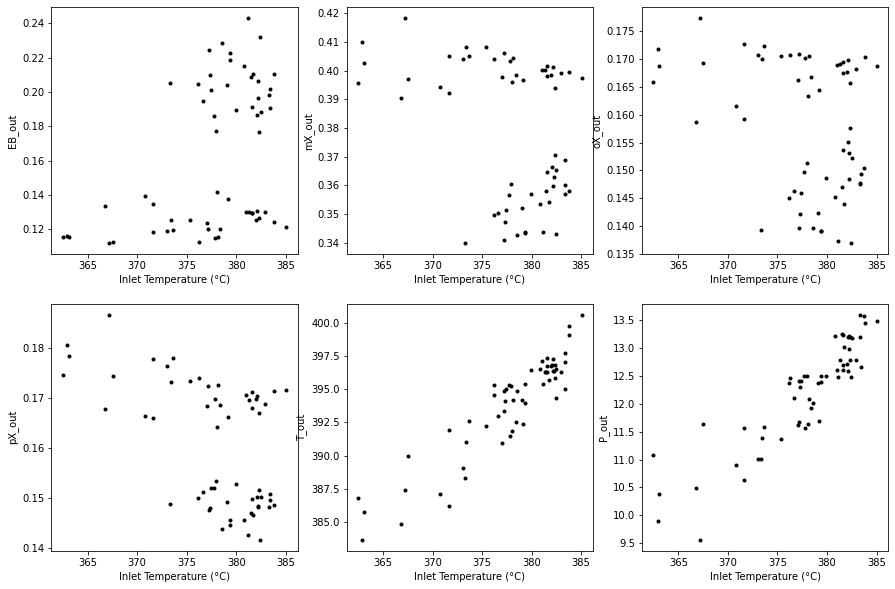

In [19]:
out_cols = [k for k in data.columns if k.find('out') != -1]

fig = plt.figure(figsize = (15,10))

i = 1
for col in out_cols:
    
    ax = fig.add_subplot(2,3,i)
    ax.plot(data['T_in'], data[col], 'k.')
    ax.set_xlabel('Inlet Temperature (°C)')
    ax.set_ylabel(col)
    
    i += 1

{'EB': -31812.65573863557, 'oX': -2713.8431616312373, 'mX': -33878.45978567857, 'pX': -33117.491121258456}
{'EB': 0.3172051332616981, 'oX': 1.3343081694357501, 'mX': 1.6900396293945845, 'pX': 0.6144418359785375}
{1: 0.016951964348298633, 2: 0.009900910791222503, 3: 0.01569826300031453, 4: 0.005005074501737564, 5: 0.00936159532678375, 6: 0.013216334314513262}
{1: 16651.342114962194, 2: 4670.80143728706, 3: 41844.737318626954, 4: 48128.29464910114, 5: 7952.092454342161, 6: 5140.767334447803}
Objective Function: 1000000.000000

{'EB': -20421.202488730894, 'oX': -17231.927612154628, 'mX': -10368.350375710015, 'pX': -26958.89840135279}
{'EB': 1.5341574833551723, 'oX': 0.12713997897812357, 'mX': 0.3158731874912186, 'pX': 0.20950860354388123}
{1: 0.004834445312047603, 2: 0.006966161484904792, 3: 0.013306940161057448, 4: 0.0012838322579697276, 5: 0.009164297389100044, 6: 0.013966077659709114}
{1: 14809.639557512975, 2: 51458.837446423626, 3: 66025.47008490839, 4: 34189.44444159086, 5: 13967.42

Objective Function: 1000000.000000

{'EB': -35255.19349908569, 'oX': -37644.09604183046, 'mX': -17640.177081711347, 'pX': -13480.998734620964}
{'EB': 1.6754882529279886, 'oX': 1.3071637094433504, 'mX': 0.16732600186676228, 'pX': 0.9478041280911214}
{1: 0.011779401423621, 2: 0.0035017858591864593, 3: 0.0157885374731476, 4: 0.008569563193963731, 5: 0.006236469886391231, 6: 0.0019672996798584252}
{1: 56360.41257155045, 2: 58503.477983995894, 3: 54846.202984578325, 4: 56912.68891371324, 5: 34100.12036280598, 6: 41751.54420589743}
Objective Function: 134.374387

{'EB': -19529.91989033337, 'oX': -37185.28949134833, 'mX': -4999.507082777633, 'pX': -37669.13380003022}
{'EB': 0.7674002046421742, 'oX': 1.7603982573020245, 'mX': 1.5826416574495639, 'pX': 1.291801995111419}
{1: 0.0077945202109339145, 2: 0.010415962029377559, 3: 0.009224873185130782, 4: 0.015617490315362612, 5: 0.013349373118819691, 6: 0.013878818243632695}
{1: 65231.13567843275, 2: 39989.22255885838, 3: 66195.92940015279, 4: 7779.

Objective Function: 129.672537

{'EB': -11416.689776782981, 'oX': -4986.5935180298075, 'mX': -17728.1609388898, 'pX': -3851.3798115126647}
{'EB': 0.9259516348988213, 'oX': 0.5757576765198218, 'mX': 1.645242464618493, 'pX': 0.9868682512656021}
{1: 0.009996611167174858, 2: 0.012630971879504235, 3: 0.0035468191346967716, 4: 0.01465583742257667, 5: 0.010032032856573498, 6: 0.017102441155995223}
{1: 24081.055569222604, 2: 60098.91923486227, 3: 48265.82844889592, 4: 46349.7819189582, 5: 62124.70395613686, 6: 46269.245096495055}
Objective Function: 118.016531

{'EB': -6684.377372378265, 'oX': -33717.047609065725, 'mX': -35496.55798254631, 'pX': -36631.6848375791}
{'EB': 1.3812447186748447, 'oX': 1.7852471562180814, 'mX': 1.264513985948525, 'pX': 0.5676835870628623}
{1: 0.018812266367095327, 2: 0.006435203414196037, 3: 0.015296554728390293, 4: 0.01266734819404061, 5: 0.002805408796234546, 6: 0.005724445781612183}
{1: 32181.023996755877, 2: 18157.833541001542, 3: 49508.58384070258, 4: 20714.833

Objective Function: 236.634557

{'EB': -34725.192344442534, 'oX': -18568.13832309623, 'mX': -8110.553999968719, 'pX': -28010.2730683427}
{'EB': 0.1357298168686245, 'oX': 1.758654378812183, 'mX': 0.4731808324405108, 'pX': 1.5851614754980816}
{1: 0.009595921479910547, 2: 0.01195476768887986, 3: 0.012745977269507996, 4: 0.0013539489333563182, 5: 0.011429435209974557, 6: 0.003127331727983516}
{1: 12315.276708915895, 2: 33969.51693069939, 3: 5712.8750695275485, 4: 55761.19388248764, 5: 42844.48987701182, 6: 61464.25029719043}
Objective Function: 1000000.000000

{'EB': -14585.774194133457, 'oX': -20703.498859277403, 'mX': -3084.603253630299, 'pX': -30147.1643109206}
{'EB': 1.1101304660864433, 'oX': 0.9408046834780563, 'mX': 1.6328332569147455, 'pX': 0.724746935476359}
{1: 0.017297163957555844, 2: 0.001756126946105694, 3: 0.014624697358555417, 4: 0.01750940004966959, 5: 0.015945482852886515, 6: 0.017962579900550772}
{1: 63833.51775996921, 2: 28383.728974435995, 3: 6966.732908532365, 4: 22714.

Objective Function: 61.631809

{'EB': -2870.6735535924818, 'oX': -14445.891082551152, 'mX': -25058.915172486777, 'pX': -25731.558287164848}
{'EB': 1.8666843256586312, 'oX': 1.8441620555561569, 'mX': 1.5365603671547963, 'pX': 0.22912717100569402}
{1: 0.018514483935585753, 2: 0.018890772996800784, 3: 0.00878280752090718, 4: 0.010048716973951639, 5: 0.0031768209785607666, 6: 0.0028174555565846585}
{1: 54570.583375284434, 2: 15079.166551451195, 3: 32978.653724753385, 4: 8021.427869395822, 5: 48670.45224478979, 6: 22389.551295397767}
Objective Function: 101.709486

{'EB': -17891.392128000527, 'oX': -4255.020689379733, 'mX': -33152.48706480274, 'pX': -31823.844877490228}
{'EB': 1.251223404649067, 'oX': 1.0448354375219773, 'mX': 1.8035132702439942, 'pX': 1.3978731755589169}
{1: 0.0037174831240089183, 2: 0.018276415919876887, 3: 0.011927143768011687, 4: 0.001235462097812303, 5: 0.009833027594334506, 6: 0.012248437513158442}
{1: 20747.365849881884, 2: 30905.903284712094, 3: 21503.736668651683, 

Objective Function: 1000000.000000

{'EB': -27230.82515031186, 'oX': -2227.378908529394, 'mX': -2081.9772301568955, 'pX': -23561.227371499837}
{'EB': 0.8801665482428255, 'oX': 0.5295332051841165, 'mX': 1.2412532051574505, 'pX': 0.34565701368308943}
{1: 0.007263383477012624, 2: 0.010325261151556398, 3: 0.01867803244223249, 4: 0.018079863333401912, 5: 0.0017813957849840793, 6: 0.01687380605011566}
{1: 16099.273649994251, 2: 8102.710236332441, 3: 7157.548695968981, 4: 41993.4180851978, 5: 66335.32438290166, 6: 30558.272844254992}
Objective Function: 1000000.000000

{'EB': -6647.861301505476, 'oX': -18081.45222736578, 'mX': -36723.909686066996, 'pX': -33333.91698837914}
{'EB': 1.3245949875089862, 'oX': 1.6643471852754161, 'mX': 0.6768530443260512, 'pX': 0.6776804652977848}
{1: 0.010873445467628475, 2: 0.00913906891140689, 3: 0.003456145430093432, 4: 0.003617743757426197, 5: 0.014604410127061911, 6: 0.0169269349948816}
{1: 31090.68514555617, 2: 23197.910833649577, 3: 15070.824293780526, 4: 

Objective Function: 1000000.000000

{'EB': -32668.219679608672, 'oX': -9741.581909896937, 'mX': -29692.75365426265, 'pX': -27362.736827074186}
{'EB': 1.8400445400930519, 'oX': 1.8490734307923653, 'mX': 1.6477984428596786, 'pX': 0.8979773219505413}
{1: 0.003282392140707479, 2: 0.005473153616709287, 3: 0.01470162448161702, 4: 0.007102013523021278, 5: 0.012565844361922955, 6: 0.009404485711347388}
{1: 7396.277965991492, 2: 14397.90623387877, 3: 40611.61402712004, 4: 42295.51567945128, 5: 8111.279622701524, 6: 15798.363559026999}
Objective Function: 1000000.000000

{'EB': -24897.060688588805, 'oX': -33916.65643317892, 'mX': -24269.73086284644, 'pX': -36972.78223063912}
{'EB': 1.1945850543416383, 'oX': 0.9310338866684056, 'mX': 1.7319207238999255, 'pX': 1.5077844459566285}
{1: 0.015199177802220503, 2: 0.0030881177284036955, 3: 0.002079949613894634, 4: 0.0016695419515707043, 5: 0.01390296056079366, 6: 0.013164379265873818}
{1: 14155.728740169157, 2: 32058.348722373747, 3: 59364.281267815, 4:

Objective Function: 140.009969

{'EB': -30488.370532046727, 'oX': -16597.84706459419, 'mX': -37338.269143598794, 'pX': -9796.274211290505}
{'EB': 1.4304478145616648, 'oX': 1.1987881625034542, 'mX': 0.10238990919478885, 'pX': 1.7214859963009257}
{1: 0.009176877682624283, 2: 0.010638948187967253, 3: 0.018461958326547796, 4: 0.014836220205580999, 5: 0.01634802431179178, 6: 0.01818659938097181}
{1: 55201.563838312366, 2: 43671.77133952474, 3: 44807.12147346929, 4: 34546.30023305542, 5: 59916.40476249537, 6: 63290.465441981636}
Objective Function: 159.336893

{'EB': -10042.571170337687, 'oX': -7270.557108241463, 'mX': -6854.487239192529, 'pX': -18773.261309191046}
{'EB': 0.6771344494749798, 'oX': 0.7458836038844847, 'mX': 0.551076300197609, 'pX': 0.4421210028168414}
{1: 0.004505935782365924, 2: 0.010816078694661516, 3: 0.0020729660847490314, 4: 0.013151456879281612, 5: 0.0044166475355073695, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 55075.01331382278, 4: 8332

Objective Function: 136.012895

{'EB': -15956.7144796547, 'oX': -2434.6421407194175, 'mX': -11272.29327762834, 'pX': -34044.39948264188}
{'EB': 1.3176555415156108, 'oX': 0.9579293565429767, 'mX': 0.2301738760179336, 'pX': 1.2579308490401702}
{1: 0.017506469045584, 2: 0.00550794549651955, 3: 0.0027317330597899188, 4: 0.006400150422508201, 5: 0.0018816304407854485, 6: 0.015371488350167533}
{1: 14311.26876015799, 2: 43096.209695843776, 3: 34796.354871573865, 4: 15126.242372678775, 5: 22715.536992536752, 6: 12137.096042047582}
Objective Function: 181.050813

{'EB': -17845.62803556991, 'oX': -27945.637312551782, 'mX': -13318.060475320206, 'pX': -21996.901202684257}
{'EB': 0.697500694212718, 'oX': 0.5269410558253216, 'mX': 0.5174087643814811, 'pX': 0.3566780485732097}
{1: 0.0026111450849079336, 2: 0.010997797639329827, 3: 0.017748787687845692, 4: 0.0015290283071950194, 5: 0.004395732799095783, 6: 0.01535908504224437}
{1: 10399.393179890325, 2: 63973.02046449164, 3: 44160.04697241841, 4: 1866

Objective Function: 135.703307

{'EB': -17845.62803556991, 'oX': -27945.637312551782, 'mX': -24149.671024678515, 'pX': -22726.124918364898}
{'EB': 1.1318084784378812, 'oX': 0.5269410558253216, 'mX': 1.555634520323569, 'pX': 1.322265867029023}
{1: 0.0026111450849079336, 2: 0.016000942727832822, 3: 0.007470089812560473, 4: 0.009859496230659615, 5: 0.0018816304407854485, 6: 0.009609490702132887}
{1: 19393.927491064198, 2: 63973.02046449164, 3: 61993.4031571634, 4: 36072.73150907428, 5: 41199.3558127024, 6: 46313.22396035659}
Objective Function: 133.698893

{'EB': -22093.906992235283, 'oX': -6362.152496234476, 'mX': -15030.503464960228, 'pX': -31309.026478970954}
{'EB': 0.697500694212718, 'oX': 1.5464022674564393, 'mX': 0.5174087643814811, 'pX': 0.3566780485732097}
{1: 0.0022306373515741497, 2: 0.010997797639329827, 3: 0.003856217617156656, 4: 0.0015290283071950194, 5: 0.0065546265335891946, 6: 0.015371488350167533}
{1: 51796.21467970919, 2: 32369.311218928662, 3: 34796.354871573865, 4: 31

Objective Function: 1000000.000000

{'EB': -30488.370532046727, 'oX': -7270.557108241463, 'mX': -37338.269143598794, 'pX': -18773.261309191046}
{'EB': 1.6134045807494575, 'oX': 0.7458836038844847, 'mX': 0.2922714666504105, 'pX': 1.7214859963009257}
{1: 0.008500419793759305, 2: 0.009055560759921723, 3: 0.018461958326547796, 4: 0.01769226853703687, 5: 0.0044166475355073695, 6: 0.01818659938097181}
{1: 55201.563838312366, 2: 43780.33886085693, 3: 15272.782562729692, 4: 15158.544582433275, 5: 53719.08414013042, 6: 5930.919854011248}
Objective Function: 1000000.000000

{'EB': -15841.55384683352, 'oX': -13683.687457608165, 'mX': -21241.252510244336, 'pX': -22741.969504062992}
{'EB': 0.6771344494749798, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.004505935782365924, 2: 0.010638948187967253, 3: 0.009059140393354034, 4: 0.013151456879281612, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 58542.01387002594, 2: 43671.77133952474, 3: 36670.52228173062

Objective Function: 123.416124

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -23852.20703500346, 'pX': -9796.274211290505}
{'EB': 0.6296991435102506, 'oX': 0.1909048269491206, 'mX': 1.1258269458944548, 'pX': 0.38390234773183207}
{1: 0.002250398882475705, 2: 0.009146576551426245, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.00457789168744502}
{1: 7745.807928806884, 2: 61689.625963402075, 3: 65663.42140168375, 4: 37314.41692310987, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 107.214727

{'EB': -19576.14153212471, 'oX': -28117.225426319364, 'mX': -6854.487239192529, 'pX': -2643.993865343502}
{'EB': 1.472132955062427, 'oX': 1.1987881625034542, 'mX': 1.5338765744419496, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.005447477734129597, 4: 0.013735143455808386, 5: 0.01686764283035599, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 31927.46226417007, 3: 58560.16341380683, 4: 56180.157274

Objective Function: 138.950750

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -22479.080782231587, 'pX': -9796.274211290505}
{'EB': 1.1318084784378812, 'oX': 0.3350736577639326, 'mX': 1.498624701438181, 'pX': 0.37948921452002216}
{1: 0.007671984423606098, 2: 0.01836297299432392, 3: 0.013286430443460558, 4: 0.01325075214908008, 5: 0.0065546265335891946, 6: 0.013862086396964981}
{1: 51796.21467970919, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 65808.57749671393, 6: 21747.162499682265}
Objective Function: 113.563558

{'EB': -22093.906992235283, 'oX': -13018.13199410626, 'mX': -21407.656608138343, 'pX': -31309.026478970954}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.0064052597288163475, 3: 0.009059140393354034, 4: 0.01321547801665706, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 32369.311218928662, 3: 61993.4031571634, 4: 36072

Objective Function: 108.263298

{'EB': -10042.571170337687, 'oX': -28117.225426319364, 'mX': -23852.20703500346, 'pX': -2643.993865343502}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.5338765744419496, 'pX': 0.38390234773183207}
{1: 0.008500419793759305, 2: 0.009146576551426245, 3: 0.009059140393354034, 4: 0.01566456709367618, 5: 0.01686764283035599, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 58560.16341380683, 4: 56180.15727464565, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 124.078522

{'EB': -19576.14153212471, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -9796.274211290505}
{'EB': 0.6296991435102506, 'oX': 0.1909048269491206, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.002250398882475705, 2: 0.011101768823288276, 3: 0.005447477734129597, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.00457789168744502}
{1: 7745.807928806884, 2: 56006.294603097136, 3: 65663.42140168375, 4: 15158.54458

Objective Function: 1000000.000000

{'EB': -15565.197505456134, 'oX': -6362.152496234476, 'mX': -4101.232468265074, 'pX': -15266.674345451609}
{'EB': 1.2934117219678325, 'oX': 1.5464022674564393, 'mX': 1.3024289080397928, 'pX': 0.849069484871575}
{1: 0.018480898064077773, 2: 0.016000942727832822, 3: 0.011777328884711676, 4: 0.009859496230659615, 5: 0.014379822974524569, 6: 0.016838011295846722}
{1: 24460.99948261075, 2: 63094.9176658144, 3: 51706.287122037786, 4: 16293.506356699763, 5: 41889.00367314342, 6: 52315.227904920626}
Objective Function: 137.886351

{'EB': -13606.441283407936, 'oX': -9583.806133155274, 'mX': -24149.671024678515, 'pX': -19275.933567646975}
{'EB': 0.6729724698728448, 'oX': 0.9493299545427755, 'mX': 0.26743555040176326, 'pX': 0.8541217934976992}
{1: 0.0022306373515741497, 2: 0.005316866270125159, 3: 0.00659660663668986, 4: 0.013537691769956641, 5: 0.01742100519224371, 6: 0.009609490702132887}
{1: 53071.10807429212, 2: 56427.019832483384, 3: 45343.10912625251, 4: 

Objective Function: 136.666827

|_________________________________________________ 1.5% GA is running...{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -15266.674345451609}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.009859496230659615, 5: 0.01634802431179178, 6: 0.0024853663522823553}
{1: 58542.01387002594, 2: 43780.33886085693, 3: 6515.783146647456, 4: 58415.04536126931, 5: 53719.08414013042, 6: 52315.227904920626}
Objective Function: 91.308054

{'EB': -15841.55384683352, 'oX': -13683.687457608165, 'mX': -21241.252510244336, 'pX': -22741.969504062992}
{'EB': 1.2934117219678325, 'oX': 1.5464022674564393, 'mX': 1.3024289080397928, 'pX': 0.4421210028168414}
{1: 0.009176877682624283, 2: 0.016000942727832822, 3: 0.011777328884711676, 4: 0.014836220205580999, 5: 0.014379822974524569, 6: 0.016838011295846722}
{1: 

Objective Function: 320.216207

{'EB': -15841.55384683352, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 1.8855758211635085}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 43780.33886085693, 3: 15272.782562729692, 4: 15158.544582433275, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 180.599870

{'EB': -10042.571170337687, 'oX': -13683.687457608165, 'mX': -21241.252510244336, 'pX': -22741.969504062992}
{'EB': 1.5531974153127557, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4421210028168414}
{1: 0.009176877682624283, 2: 0.009055560759921723, 3: 0.009059140393354034, 4: 0.014836220205580999, 5: 0.01634802431179178, 6: 0.0024853663522823553}
{1: 58542.01387002594, 2: 61689.625963402075, 3: 65663.42140168375, 4: 1179

Objective Function: 191.724875

{'EB': -6684.377372378265, 'oX': -28106.966248288474, 'mX': -6854.487239192529, 'pX': -8702.792397075918}
{'EB': 0.697500694212718, 'oX': 1.7852471562180814, 'mX': 1.1258269458944548, 'pX': 0.5676835870628623}
{1: 0.012611960154695973, 2: 0.011101768823288276, 3: 0.007470089812560473, 4: 0.01325075214908008, 5: 0.0026576930669637497, 6: 0.012438360075382505}
{1: 10399.393179890325, 2: 61689.625963402075, 3: 48129.075059262585, 4: 15158.544582433275, 5: 61415.2810071894, 6: 48977.764717233746}
Objective Function: 1000000.000000

{'EB': -8036.097346797993, 'oX': -16597.84706459419, 'mX': -35496.55798254631, 'pX': -25918.749748229304}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.264513985948525, 'pX': 0.6701215790152868}
{1: 0.008500419793759305, 2: 0.01112511272179681, 3: 0.009059140393354034, 4: 0.0015290283071950194, 5: 0.008750117542510247, 6: 0.005724445781612183}
{1: 32774.23592377515, 2: 18157.833541001542, 3: 65663.42140168375, 4: 48

Objective Function: 130.408496

{'EB': -26264.858973959657, 'oX': -28117.225426319364, 'mX': -20099.436390909963, 'pX': -14745.347511807182}
{'EB': 1.472132955062427, 'oX': 1.1987881625034542, 'mX': 1.5338765744419496, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.010852317397680675, 4: 0.011939433423390967, 5: 0.005589633238946563, 6: 0.014059842553944393}
{1: 32774.23592377515, 2: 45860.36486402748, 3: 36951.07197617843, 4: 47914.7198673407, 5: 23459.56166182904, 6: 28891.00408039718}
Objective Function: 145.975952

{'EB': -19576.14153212471, 'oX': -14719.159432704695, 'mX': -6854.487239192529, 'pX': -11910.623880642088}
{'EB': 1.5505136555626842, 'oX': 1.0837835291491515, 'mX': 1.5410903540054752, 'pX': 1.8605107346115706}
{1: 0.004199898821285998, 2: 0.008907181159995949, 3: 0.005447477734129597, 4: 0.015293590465589898, 5: 0.01686764283035599, 6: 0.012438360075382505}
{1: 34184.42796965092, 2: 31927.46226417007, 3: 58560.16341380683, 4: 56180.157

Objective Function: 133.177664

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -20099.436390909963, 'pX': -14745.347511807182}
{'EB': 1.1318084784378812, 'oX': 1.6110597618626419, 'mX': 1.5410903540054752, 'pX': 0.37948921452002216}
{1: 0.004199898821285998, 2: 0.008907181159995949, 3: 0.003856217617156656, 4: 0.015293590465589898, 5: 0.005589633238946563, 6: 0.014559620551551262}
{1: 51796.21467970919, 2: 32369.311218928662, 3: 36951.07197617843, 4: 47914.7198673407, 5: 25635.018714003887, 6: 23223.59885313367}
Objective Function: 106.630221

{'EB': -26264.858973959657, 'oX': -14719.159432704695, 'mX': -36594.160857547664, 'pX': -31309.026478970954}
{'EB': 1.5505136555626842, 'oX': 1.0837835291491515, 'mX': 1.498624701438181, 'pX': 1.8605107346115706}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.010852317397680675, 4: 0.005609843372562733, 5: 0.018159630833841187, 6: 0.014059842553944393}
{1: 34184.42796965092, 2: 45860.36486402748, 3: 30277.57732967841, 4: 273

Objective Function: 138.265759

{'EB': -27640.785354954824, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -12696.701567153103}
{'EB': 1.808636879274625, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.018480898064077773, 2: 0.00964913330747277, 3: 0.011777328884711676, 4: 0.00805551815779866, 5: 0.01634802431179178, 6: 0.016838011295846722}
{1: 24460.99948261075, 2: 56427.019832483384, 3: 6515.783146647456, 4: 58415.04536126931, 5: 59916.40476249537, 6: 37811.652049761135}
Objective Function: 1000000.000000

{'EB': -15841.55384683352, 'oX': -9583.806133155274, 'mX': -21241.252510244336, 'pX': -15266.674345451609}
{'EB': 1.4304478145616648, 'oX': 1.6940583375222342, 'mX': 0.3494471557568938, 'pX': 0.849069484871575}
{1: 0.017815658644541196, 2: 0.010638948187967253, 3: 0.004458359219975996, 4: 0.009859496230659615, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 58542.01387002594, 2: 43780.33886085693, 3: 36670.52228173062, 4: 28745.

Objective Function: 109.833737

{'EB': -15841.55384683352, 'oX': -9583.806133155274, 'mX': -21241.252510244336, 'pX': -12696.701567153103}
{'EB': 0.8142584938629678, 'oX': 0.7215079933367656, 'mX': 0.3494471557568938, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.010638948187967253, 3: 0.009059140393354034, 4: 0.013537691769956641, 5: 0.01840304278223249, 6: 0.016236426815797775}
{1: 24460.99948261075, 2: 46901.8324745658, 3: 36670.52228173062, 4: 19835.737479542535, 5: 61415.2810071894, 6: 37811.652049761135}
Objective Function: 143.022871

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 0.6771344494749798, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 0.849069484871575}
{1: 0.016051699152088476, 2: 0.011101768823288276, 3: 0.011777328884711676, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.016838011295846722}
{1: 32774.23592377515, 2: 57298.57564496256, 3: 65663.42140168375, 4: 28745.96852

Objective Function: 114.112221

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -11311.497971885598}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.004029508184497821}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 61415.2810071894, 6: 60724.2263812664}
Objective Function: 177.702142

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.5445

Objective Function: 166.005588

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -18863.58372649636}
{'EB': 0.6771344494749798, 'oX': 0.8325260007436237, 'mX': 1.5338765744419496, 'pX': 0.849069484871575}
{1: 0.016051699152088476, 2: 0.01736970108347631, 3: 0.011777328884711676, 4: 0.013537691769956641, 5: 0.010087651538133456, 6: 0.012918283269122815}
{1: 51796.21467970919, 2: 56427.019832483384, 3: 10967.238544825363, 4: 28745.968529587888, 5: 25635.018714003887, 6: 28891.00408039718}
Objective Function: 65.513687

{'EB': -15841.55384683352, 'oX': -28117.225426319364, 'mX': -21241.252510244336, 'pX': -2643.993865343502}
{'EB': 1.472132955062427, 'oX': 0.7215079933367656, 'mX': 0.3494471557568938, 'pX': 0.37948921452002216}
{1: 0.008500419793759305, 2: 0.010638948187967253, 3: 0.003856217617156656, 4: 0.013735143455808386, 5: 0.013419025681452427, 6: 0.016838011295846722}
{1: 24460.99948261075, 2: 32369.311218928662, 3: 36670.52228173062, 4: 56180.

Objective Function: 150.062824

{'EB': -31380.819135584243, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -9796.274211290505}
{'EB': 0.21439903885444256, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.3465497270469915}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.016849658064065777, 4: 0.005964172278601627, 5: 0.010087651538133456, 6: 0.008333145752452883}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 143.055344

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 1.6134045807494575, 'oX': 1.1987881625034542, 'mX': 1.2678911307726133, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158

Objective Function: 111.444876

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -6854.487239192529, 'pX': -7489.784970982}
{'EB': 0.25485022331639295, 'oX': 1.6110597618626419, 'mX': 1.695250213415585, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.005609843372562733, 5: 0.007513676291744815, 6: 0.008333145752452883}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 30277.57732967841, 4: 15158.544582433275, 5: 41199.3558127024, 6: 48977.764717233746}
Objective Function: 137.755197

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 0.25485022331639295, 'oX': 1.6110597618626419, 'mX': 1.695250213415585, 'pX': 1.065024623192628}
{1: 0.01099182284890655, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.018877307371160938, 5: 0.010087651538133456, 6: 0.008333145752452883}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 30277.57732967841, 4: 15158.544

Objective Function: 132.092361

{'EB': -30489.256337533923, 'oX': -16597.84706459419, 'mX': -36561.11138744274, 'pX': -21468.865407232035}
{'EB': 1.1318084784378812, 'oX': 0.3350736577639326, 'mX': 1.498624701438181, 'pX': 0.6204700450165201}
{1: 0.017506469045584, 2: 0.01836297299432392, 3: 0.01339319483990412, 4: 0.005609843372562733, 5: 0.0065546265335891946, 6: 0.008333145752452883}
{1: 51796.21467970919, 2: 43096.209695843776, 3: 64082.877933001626, 4: 15158.544582433275, 5: 65808.57749671393, 6: 21747.162499682265}
Objective Function: 189.346066

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -29073.699831567832, 'pX': -9796.274211290505}
{'EB': 0.6293308804170994, 'oX': 0.6968730581722216, 'mX': 1.4728607634379154, 'pX': 1.065024623192628}
{1: 0.007671984423606098, 2: 0.0167078283668276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.006071764688844425, 6: 0.0035434480634246937}
{1: 53668.71132153351, 2: 61689.625963402075, 3: 65663.42140168375, 4: 47775.490

Objective Function: 169.103597

{'EB': -31380.819135584243, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -29551.506166762625}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 1.695250213415585, 'pX': 1.065024623192628}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.005609843372562733, 5: 0.018159630833841187, 6: 0.008333145752452883}
{1: 23439.021676737968, 2: 18157.833541001542, 3: 6515.783146647456, 4: 15158.544582433275, 5: 41199.3558127024, 6: 31885.582909429275}
Objective Function: 711.067250

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -26603.025005146723, 'pX': -31309.026478970954}
{'EB': 1.1444638779549026, 'oX': 1.6110597618626419, 'mX': 1.264513985948525, 'pX': 0.5676835870628623}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.005964172278601627, 5: 0.010087651538133456, 6: 0.007228834298711474}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 30277.57732967841, 4: 273

Objective Function: 60.073767

{'EB': -19576.14153212471, 'oX': -18036.371963246464, 'mX': -21834.631080573294, 'pX': -21468.865407232035}
{'EB': 1.2215365652732142, 'oX': 0.31552791597670715, 'mX': 1.264513985948525, 'pX': 0.9966344756788015}
{1: 0.008704779645342752, 2: 0.006510942967021727, 3: 0.003856217617156656, 4: 0.005609843372562733, 5: 0.018135691474916782, 6: 0.008333145752452883}
{1: 23439.021676737968, 2: 43096.209695843776, 3: 64082.877933001626, 4: 47775.49039254219, 5: 9542.642480866885, 6: 63882.60434872084}
Objective Function: 136.797524

{'EB': -29079.93062959119, 'oX': -31935.255608604974, 'mX': -27331.055720598382, 'pX': -31309.026478970954}
{'EB': 0.6293308804170994, 'oX': 0.6968730581722216, 'mX': 1.4728607634379154, 'pX': 0.6204700450165201}
{1: 0.017506469045584, 2: 0.011863136124571051, 3: 0.01339319483990412, 4: 0.005609843372562733, 5: 0.006071764688844425, 6: 0.007228834298711474}
{1: 53668.71132153351, 2: 31927.46226417007, 3: 30277.57732967841, 4: 56180.1

Objective Function: 66.392962

{'EB': -10280.485485446385, 'oX': -37849.63031425745, 'mX': -4101.232468265074, 'pX': -3558.17883605566}
{'EB': 1.2015043955306726, 'oX': 1.617385302928962, 'mX': 0.551076300197609, 'pX': 1.7876575356456759}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.017048520005633172}
{1: 52297.5904996078, 2: 43780.33886085693, 3: 6515.783146647456, 4: 27375.041820548253, 5: 18748.52253467893, 6: 63882.60434872084}
Objective Function: 60.412466

{'EB': -15565.197505456134, 'oX': -19491.41098002152, 'mX': -36594.160857547664, 'pX': -22645.0025324964}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 0.12600231772625192, 'pX': 0.6204700450165201}
{1: 0.016554455788109667, 2: 0.009055560759921723, 3: 0.01339319483990412, 4: 0.009859496230659615, 5: 0.01235925022700686, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 61742.1280345706, 3: 13417.440599810849, 4: 58415.045361

Objective Function: 108.995649

{'EB': -15565.197505456134, 'oX': -9961.931134757411, 'mX': -21834.631080573294, 'pX': -31309.026478970954}
{'EB': 1.4304478145616648, 'oX': 0.31552791597670715, 'mX': 1.264513985948525, 'pX': 0.8921509243500273}
{1: 0.008704779645342752, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.018159630833841187, 6: 0.012438360075382505}
{1: 21262.599487808882, 2: 31927.46226417007, 3: 6515.783146647456, 4: 39737.959187548964, 5: 61415.2810071894, 6: 48977.764717233746}
Objective Function: 92.034785

{'EB': -19576.14153212471, 'oX': -16597.84706459419, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 1.2215365652732142, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.9966344756788015}
{1: 0.008500419793759305, 2: 0.011863136124571051, 3: 0.0034737812972425314, 4: 0.01325075214908008, 5: 0.01634802431179178, 6: 0.012119204407709793}
{1: 32774.23592377515, 2: 56673.00427058483, 3: 30277.57732967841, 4: 56180.1

Objective Function: 191.508793

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.026412685845084}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 18748.52253467893, 6: 47396.198467723225}
Objective Function: 155.170062

{'EB': -15565.197505456134, 'oX': -9583.806133155274, 'mX': -4101.232468265074, 'pX': -24380.825415213374}
{'EB': 0.6729724698728448, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 0.849069484871575}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.009859496230659615, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 43780.33886085693, 3: 6515.783146647456, 4: 584

Objective Function: 106.069793

{'EB': -15565.197505456134, 'oX': -16597.84706459419, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 1.2731432223074255}
{1: 0.016843895584897316, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.009859496230659615, 5: 0.01634802431179178, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 56673.00427058483, 3: 6515.783146647456, 4: 58415.04536126931, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 92.020184

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 1.106166786582616, 'mX': 0.551076300197609, 'pX': 0.8921509243500273}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 43780.33886085693, 3: 6515.783146647456, 4: 44967.9243

Objective Function: 88.004708

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -35970.81782246123, 'pX': -31309.026478970954}
{'EB': 0.6569747001405961, 'oX': 1.0138107481288154, 'mX': 1.5248569311958171, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.01325075214908008, 5: 0.0065546265335891946, 6: 0.007228834298711474}
{1: 51796.21467970919, 2: 61689.625963402075, 3: 30277.57732967841, 4: 27375.041820548253, 5: 65808.57749671393, 6: 21747.162499682265}
Objective Function: 119.097356

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -35970.81782246123, 'pX': -31309.026478970954}
{'EB': 1.7226290540308011, 'oX': 0.3350736577639326, 'mX': 1.498624701438181, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.01325075214908008, 5: 0.0065546265335891946, 6: 0.007228834298711474}
{1: 51796.21467970919, 2: 61689.625963402075, 3: 30277.57732967841, 4: 27375

Objective Function: 135.321373

{'EB': -17024.090058066155, 'oX': -16597.84706459419, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.9724935186074379}
{1: 0.008500419793759305, 2: 0.00739663400047476, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.006428739732691266}
{1: 32774.23592377515, 2: 56673.00427058483, 3: 34836.9433584265, 4: 39737.959187548964, 5: 61415.2810071894, 6: 31885.582909429275}
Objective Function: 122.432246

{'EB': -15565.197505456134, 'oX': -16597.84706459419, 'mX': -4101.232468265074, 'pX': -22462.09897751082}
{'EB': 1.6012020331448622, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.8921509243500273}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.014024268704199386, 6: 0.012438360075382505}
{1: 32774.23592377515, 2: 56673.00427058483, 3: 6515.783146647456, 4: 39737.95918

Objective Function: 182.485272

{'EB': -30489.256337533923, 'oX': -31935.255608604974, 'mX': -4101.232468265074, 'pX': -13612.071419218097}
{'EB': 1.3592039670069807, 'oX': 0.6968730581722216, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.009055560759921723, 3: 0.01339319483990412, 4: 0.0097215502861058, 5: 0.006071764688844425, 6: 0.0024853663522823553}
{1: 53668.71132153351, 2: 43780.33886085693, 3: 64082.877933001626, 4: 58415.04536126931, 5: 9542.642480866885, 6: 63882.60434872084}
Objective Function: 154.431177

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -36561.11138744274, 'pX': -21468.865407232035}
{'EB': 0.6293308804170994, 'oX': 0.7215079933367656, 'mX': 1.4728607634379154, 'pX': 0.6204700450165201}
{1: 0.016644281924057057, 2: 0.007480556384806488, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.008333145752452883}
{1: 19883.834673192643, 2: 43096.209695843776, 3: 60655.79163474556, 4: 47775.

Objective Function: 128.750570

{'EB': -10042.571170337687, 'oX': -14604.43810186749, 'mX': -6854.487239192529, 'pX': -2092.286446899612}
{'EB': 0.6729724698728448, 'oX': 1.8577651229018077, 'mX': 1.2869985726453623, 'pX': 1.026412685845084}
{1: 0.01626966831299896, 2: 0.009055560759921723, 3: 0.009059140393354034, 4: 0.0097215502861058, 5: 0.003292912854270219, 6: 0.005250318522409169}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 61415.2810071894, 6: 47396.198467723225}
Objective Function: 156.271873

{'EB': -10042.571170337687, 'oX': -11788.961058587844, 'mX': -36439.846682150834, 'pX': -12696.701567153103}
{'EB': 0.6771344494749798, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 1.026412685845084}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 43780.33886085693, 3: 65663.42140168375, 4: 25800.87

Objective Function: 119.293370

{'EB': -15565.197505456134, 'oX': -9583.806133155274, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 0.6729724698728448, 'oX': 0.7215079933367656, 'mX': 1.3012573116652342, 'pX': 0.24704048276556723}
{1: 0.01626966831299896, 2: 0.009055560759921723, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.003418944401398335}
{1: 19883.834673192643, 2: 43780.33886085693, 3: 60655.79163474556, 4: 65569.00329384179, 5: 34765.833344665996, 6: 47396.198467723225}
Objective Function: 139.849624

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.3592039670069807, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010087651538133456, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 29855.854

Objective Function: 118.884438

{'EB': -10042.571170337687, 'oX': -16597.84706459419, 'mX': -6854.487239192529, 'pX': -28096.7169586812}
{'EB': 1.1318084784378812, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 1.026412685845084}
{1: 0.017506469045584, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.0065546265335891946, 6: 0.008333145752452883}
{1: 45192.141102167945, 2: 43096.209695843776, 3: 65663.42140168375, 4: 15158.544582433275, 5: 61415.2810071894, 6: 21747.162499682265}
Objective Function: 121.331339

{'EB': -31380.819135584243, 'oX': -24067.107274483387, 'mX': -36561.11138744274, 'pX': -25918.749748229304}
{'EB': 0.6729724698728448, 'oX': 1.1987881625034542, 'mX': 1.498624701438181, 'pX': 0.6204700450165201}
{1: 0.008500419793759305, 2: 0.009055560759921723, 3: 0.01339319483990412, 4: 0.0059058389824074055, 5: 0.010087651538133456, 6: 0.008333145752452883}
{1: 51796.21467970919, 2: 43096.209695843776, 3: 64082.877933001626, 4: 15158.

Objective Function: 119.281365

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -13713.114736940071, 'pX': -25918.749748229304}
{'EB': 1.5255751704131373, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.062104723080764}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.003856217617156656, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 61415.2810071894, 6: 47396.198467723225}
Objective Function: 151.909641

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -35970.81782246123, 'pX': -31091.139672548037}
{'EB': 1.1318084784378812, 'oX': 0.3350736577639326, 'mX': 1.184233083487819, 'pX': 0.5676835870628623}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.018159630833841187, 6: 0.007228834298711474}
{1: 51796.21467970919, 2: 18157.833541001542, 3: 30277.57732967841, 4: 33659.

Objective Function: 196.625953

{'EB': -10280.485485446385, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.3592039670069807, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 1.7876575356456759}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 43780.33886085693, 3: 6515.783146647456, 4: 55960.37610578368, 5: 34765.833344665996, 6: 52315.227904920626}
Objective Function: 55.615763

{'EB': -15565.197505456134, 'oX': -37849.63031425745, 'mX': -4101.232468265074, 'pX': -5955.592197798349}
{'EB': 1.2015043955306726, 'oX': 1.617385302928962, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.0097215502861058, 5: 0.010647847973115568, 6: 0.017048520005633172}
{1: 52297.5904996078, 2: 43780.33886085693, 3: 60655.79163474556, 4: 27375.041820

Objective Function: 47.119342

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.3592039670069807, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.006177332539305219, 2: 0.009055560759921723, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010647847973115568, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 43780.33886085693, 3: 60655.79163474556, 4: 58415.04536126931, 5: 34765.833344665996, 6: 52315.227904920626}
Objective Function: 126.182369

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.3592039670069807, 'oX': 0.7215079933367656, 'mX': 1.3012573116652342, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.009055560759921723, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010647847973115568, 6: 0.0024853663522823553}
{1: 19883.834673192643, 2: 43780.33886085693, 3: 60655.79163474556, 4: 65569.0032

Objective Function: 127.523537

{'EB': -15565.197505456134, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -5494.813607932776}
{'EB': 0.4310548882755336, 'oX': 0.808783324045913, 'mX': 1.1258269458944548, 'pX': 1.703572497513492}
{1: 0.008500419793759305, 2: 0.018690043326329623, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 60655.79163474556, 4: 15158.544582433275, 5: 34765.833344665996, 6: 47396.198467723225}
Objective Function: 174.052357

{'EB': -10042.571170337687, 'oX': -23718.35265592404, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.3592039670069807, 'oX': 1.1987881625034542, 'mX': 1.3012573116652342, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 45192.141102167945, 2: 52177.074532881736, 3: 65663.42140168375, 4: 15158.

Objective Function: 139.997176

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 1.695250213415585, 'pX': 1.062104723080764}
{1: 0.018480898064077773, 2: 0.009055560759921723, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 64992.246265932554, 3: 6515.783146647456, 4: 15158.544582433275, 5: 61415.2810071894, 6: 47396.198467723225}
Objective Function: 181.723934

{'EB': -31380.819135584243, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -15266.674345451609}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.00958333991530706, 5: 0.010087651538133456, 6: 0.008333145752452883}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 65663.42140168375, 4: 15158

Objective Function: 108.032480

{'EB': -15565.197505456134, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -9531.113339190824}
{'EB': 1.3592039670069807, 'oX': 1.599526901620505, 'mX': 1.1258269458944548, 'pX': 0.849069484871575}
{1: 0.01758345038674967, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 64403.41998247737, 2: 45533.92055717193, 3: 60655.79163474556, 4: 15158.544582433275, 5: 34765.833344665996, 6: 47396.198467723225}
Objective Function: 182.783591

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.24747980599935793, 'oX': 0.808783324045913, 'mX': 1.3012573116652342, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 52177.074532881736, 3: 65663.42140168375, 4: 15158.544

Objective Function: 1000000.000000

{'EB': -15565.197505456134, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -6538.570832104799}
{'EB': 1.3592039670069807, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.009661753643207746, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 45000.729078826655, 4: 15158.544582433275, 5: 61415.2810071894, 6: 52315.227904920626}
Objective Function: 206.781103

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -5494.813607932776}
{'EB': 0.4310548882755336, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 1.703572497513492}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010087651538133456, 6: 0.01202683452356463}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 29855

Objective Function: 127.375304

{'EB': -10624.056735064294, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -21016.29105944917}
{'EB': 0.24747980599935793, 'oX': 1.598903294059331, 'mX': 1.0019868747913694, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010265332512351007, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 60655.79163474556, 4: 15158.544582433275, 5: 61415.2810071894, 6: 52315.227904920626}
Objective Function: 416.486750

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -36439.846682150834, 'pX': -25918.749748229304}
{'EB': 1.3592039670069807, 'oX': 1.1987881625034542, 'mX': 1.3012573116652342, 'pX': 0.6204700450165201}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.009059140393354034, 4: 0.0097215502861058, 5: 0.010087651538133456, 6: 0.004216385499587258}
{1: 51796.21467970919, 2: 52177.074532881736, 3: 65663.42140168375, 4: 15158.

Objective Function: 125.181989

{'EB': -15565.197505456134, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -6620.185828478658}
{'EB': 1.3592039670069807, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010087651538133456, 6: 0.009524495380083181}
{1: 52297.5904996078, 2: 6187.6570120384495, 3: 6515.783146647456, 4: 29855.854435821588, 5: 34765.833344665996, 6: 37197.17231697621}
Objective Function: 1000000.000000

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -22684.449168857544, 'pX': -22645.0025324964}
{'EB': 0.24747980599935793, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.01626966831299896, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.007326421901083529, 5: 0.010087651538133456, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 59517.60654919312, 3: 65663.42140168375, 4: 27

Objective Function: 131.611381

{'EB': -15565.197505456134, 'oX': -19491.41098002152, 'mX': -6854.487239192529, 'pX': -14664.143643944466}
{'EB': 1.6134045807494575, 'oX': 0.808783324045913, 'mX': 1.264513985948525, 'pX': 1.0874281251970435}
{1: 0.017165911970881367, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.004771136889593839, 6: 0.007270858499418442}
{1: 32774.23592377515, 2: 61689.625963402075, 3: 36819.590249460794, 4: 27375.041820548253, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 99.754509

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 0.5676835870628623}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.005609843372562733, 5: 0.010103141345748717, 6: 0.007228834298711474}
{1: 45192.141102167945, 2: 52177.074532881736, 3: 60655.79163474556, 4: 23877

Objective Function: 122.661536

{'EB': -10280.485485446385, 'oX': -32197.318604666703, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.01626966831299896, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.0097215502861058, 5: 0.004771136889593839, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 59517.60654919312, 3: 6515.783146647456, 4: 27375.041820548253, 5: 27610.57372681041, 6: 63882.60434872084}
Objective Function: 81.058971

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -35496.55798254631, 'pX': -6620.185828478658}
{'EB': 1.2015043955306726, 'oX': 0.21357562772826055, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.012050966229750883, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010087651538133456, 6: 0.017048520005633172}
{1: 52116.7792163146, 2: 43780.33886085693, 3: 30277.57732967841, 4: 27375.04182

Objective Function: 135.606585

|||_______________________________________________ 5.5% GA is running...{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -14664.143643944466}
{'EB': 1.6134045807494575, 'oX': 1.8205541985752696, 'mX': 1.264513985948525, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011101768823288276, 3: 0.005983296810497823, 4: 0.005609843372562733, 5: 0.004771136889593839, 6: 0.007228834298711474}
{1: 46493.15373379886, 2: 61689.625963402075, 3: 31571.958057167394, 4: 45184.058937020556, 5: 38321.33373908447, 6: 52315.227904920626}
Objective Function: 123.847464

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -8756.810556776418, 'pX': -14664.143643944466}
{'EB': 1.6134045807494575, 'oX': 1.8205541985752696, 'mX': 1.264513985948525, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.00794287774118528, 5: 0.004771136889593839, 6: 0.007228834298711474}
{1

Objective Function: 36.216490

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010325258117737988, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 52177.074532881736, 3: 6515.783146647456, 4: 23877.102822198154, 5: 27610.57372681041, 6: 63882.60434872084}
Objective Function: 88.023670

{'EB': -10042.571170337687, 'oX': -32197.318604666703, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.9039944909353521, 'oX': 1.6607133682866586, 'mX': 1.3259330742882849, 'pX': 0.5676835870628623}
{1: 0.011475109475891176, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.0097215502861058, 5: 0.010103141345748717, 6: 0.007228834298711474}
{1: 51371.1785961977, 2: 59517.60654919312, 3: 60655.79163474556, 4: 26925.46360

Objective Function: 38.592124

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.8205541985752696, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.005609843372562733, 5: 0.010103141345748717, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 33855.95653686321, 4: 23877.102822198154, 5: 33692.847176561896, 6: 52315.227904920626}
Objective Function: 97.661270

{'EB': -13320.090418686857, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.617385302928962, 'mX': 1.3259330742882849, 'pX': 0.5676835870628623}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010647847973115568, 6: 0.007228834298711474}
{1: 52297.5904996078, 2: 52177.074532881736, 3: 60655.79163474556, 4: 26138.558252

Objective Function: 66.990561

{'EB': -35453.00248996548, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -14664.143643944466}
{'EB': 1.6104989900896802, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.01647784363888461, 5: 0.005686203245224778, 6: 0.007228834298711474}
{1: 46493.15373379886, 2: 61689.625963402075, 3: 31571.958057167394, 4: 29855.854435821588, 5: 38321.33373908447, 6: 47396.198467723225}
Objective Function: 129.951603

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -32267.297963418434, 'pX': -12812.352389778469}
{'EB': 1.6134045807494575, 'oX': 1.8205541985752696, 'mX': 1.264513985948525, 'pX': 0.5676835870628623}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.004771136889593839, 6: 0.014850161105206636}
{1: 46035.57506419647, 2: 45916.179158740466, 3: 30277.57732967841, 4: 451

Objective Function: 102.513164

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -8047.8104355029955}
{'EB': 1.251621521013838, 'oX': 1.64178847332419, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0033348412916933724, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.013040439973144123, 5: 0.010087651538133456, 6: 0.0024853663522823553}
{1: 21260.38952364178, 2: 43780.33886085693, 3: 65663.42140168375, 4: 28193.634305992844, 5: 17502.740401095347, 6: 47396.198467723225}
Objective Function: 96.814991

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 1.4304478145616648, 'oX': 0.7215079933367656, 'mX': 1.1258269458944548, 'pX': 1.065024623192628}
{1: 0.008500419793759305, 2: 0.011541244488503345, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.012093925986488912}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.

Objective Function: 1000000.000000

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -25918.749748229304}
{'EB': 1.6104989900896802, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 1.062104723080764}
{1: 0.008704779645342752, 2: 0.0013550761400336914, 3: 0.009059140393354034, 4: 0.01647784363888461, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 65663.42140168375, 4: 15158.544582433275, 5: 27610.57372681041, 6: 63882.60434872084}
Objective Function: 148.771517

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -14218.291831980281, 'pX': -31309.026478970954}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008500419793759305, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.004771136889593839, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 45916.179158740466, 3: 6515.783146647456, 4: 26

Objective Function: 128.664375

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -8827.27117586663}
{'EB': 1.6104989900896802, 'oX': 1.3131939241773363, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.005686203245224778, 6: 0.007228834298711474}
{1: 49067.95035264259, 2: 45916.179158740466, 3: 30277.57732967841, 4: 23877.102822198154, 5: 36517.410355097985, 6: 63882.60434872084}
Objective Function: 96.887459

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -20707.841867693336, 'pX': -31309.026478970954}
{'EB': 0.4790970482873488, 'oX': 1.1987881625034542, 'mX': 1.1258269458944548, 'pX': 0.5676835870628623}
{1: 0.006079872440665825, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010325258117737988, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 52177.074532881736, 3: 6515.783146647456, 4: 2985

Objective Function: 121.348891

{'EB': -16145.933501707099, 'oX': -9583.806133155274, 'mX': -26242.3934342231, 'pX': -31309.026478970954}
{'EB': 1.6104989900896802, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.005513873021386316, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.016470865859529286, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 52177.074532881736, 3: 11381.852975005524, 4: 33884.84421544283, 5: 27610.57372681041, 6: 48977.764717233746}
Objective Function: 107.780481

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.24747980599935793, 'oX': 0.808783324045913, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.004771136889593839, 6: 0.007270858499418442}
{1: 22053.0781535422, 2: 45916.179158740466, 3: 60655.79163474556, 4: 34456.92346

Objective Function: 161.481087

{'EB': -24562.285890968684, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -25918.749748229304}
{'EB': 0.24747980599935793, 'oX': 1.617385302928962, 'mX': 0.9959381784822557, 'pX': 1.062104723080764}
{1: 0.008500419793759305, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.003184214477239918, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 56130.513929619, 4: 15158.544582433275, 5: 33692.847176561896, 6: 47396.198467723225}
Objective Function: 249.901274

{'EB': -10042.571170337687, 'oX': -9583.806133155274, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.00898378026509349, 2: 0.011863136124571051, 3: 0.009059140393354034, 4: 0.01325075214908008, 5: 0.010087651538133456, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 65663.42140168375, 4: 27375.041

Objective Function: 35.015961

{'EB': -10042.571170337687, 'oX': -17479.20614337395, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008704779645342752, 2: 0.005810178316933797, 3: 0.003393789621205629, 4: 0.01475613031354659, 5: 0.00581722039448054, 6: 0.012438360075382505}
{1: 52297.5904996078, 2: 45916.179158740466, 3: 6515.783146647456, 4: 33714.96484795815, 5: 27610.57372681041, 6: 64656.254177312534}
Objective Function: 95.410873

{'EB': -10153.369819295283, 'oX': -24067.107274483387, 'mX': -31250.13447670763, 'pX': -14017.440660360151}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 1.062104723080764}
{1: 0.009582058354887143, 2: 0.002961364915084765, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.010647847973115568, 6: 0.003014857861549658}
{1: 52297.5904996078, 2: 45916.179158740466, 3: 6515.783146647456, 4: 15158.5445824

Objective Function: 47.014745

{'EB': -15565.197505456134, 'oX': -31396.66866578444, 'mX': -6854.487239192529, 'pX': -6620.185828478658}
{'EB': 1.3206086580313114, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 0.15813015590939383}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.012244559732171863}
{1: 52297.5904996078, 2: 43780.33886085693, 3: 32566.509221727443, 4: 23877.102822198154, 5: 24642.914877578267, 6: 48977.764717233746}
Objective Function: 106.346895

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.016716647306492798, 5: 0.010103141345748717, 6: 0.007270858499418442}
{1: 27678.915860743633, 2: 52177.074532881736, 3: 60655.79163474556, 4: 65569

Objective Function: 172.366537

{'EB': -10280.485485446385, 'oX': -11162.001206486006, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.24747980599935793, 'oX': 0.808783324045913, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008704779645342752, 2: 0.004466102654519667, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.004771136889593839, 6: 0.007270858499418442}
{1: 22053.0781535422, 2: 52177.074532881736, 3: 60655.79163474556, 4: 27375.041820548253, 5: 27610.57372681041, 6: 63882.60434872084}
Objective Function: 121.348891

{'EB': -10280.485485446385, 'oX': -11162.001206486006, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.24747980599935793, 'oX': 0.808783324045913, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0044338412740169515, 2: 0.004466102654519667, 3: 0.0020892956229513794, 4: 0.00580309756466684, 5: 0.004771136889593839, 6: 0.007270858499418442}
{1: 22053.0781535422, 2: 52177.074532881736, 3: 60655.79163474556, 4: 27375.04182

Objective Function: 34.452510

{'EB': -30528.933755607934, 'oX': -9583.806133155274, 'mX': -4101.232468265074, 'pX': -31309.026478970954}
{'EB': 1.349250621495175, 'oX': 1.0916223448187452, 'mX': 1.1258269458944548, 'pX': 1.062104723080764}
{1: 0.010122948228086731, 2: 0.016333161203101826, 3: 0.0020892956229513794, 4: 0.0097215502861058, 5: 0.010087651538133456, 6: 0.008333145752452883}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 65663.42140168375, 4: 15158.544582433275, 5: 27610.57372681041, 6: 47396.198467723225}
Objective Function: 172.219807

{'EB': -10280.485485446385, 'oX': -32197.318604666703, 'mX': -6854.487239192529, 'pX': -15266.674345451609}
{'EB': 1.8953934052762276, 'oX': 0.7215079933367656, 'mX': 1.418321474272458, 'pX': 1.065024623192628}
{1: 0.0036738833560535818, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.009760645508162743, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 63563.01762649491, 3: 5596.5425569612125, 4: 65569.00

Objective Function: 140.557120

{'EB': -15565.197505456134, 'oX': -37032.314635483344, 'mX': -4101.232468265074, 'pX': -6620.185828478658}
{'EB': 1.3206086580313114, 'oX': 0.7215079933367656, 'mX': 0.9959381784822557, 'pX': 0.10706544361570369}
{1: 0.009582058354887143, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.016716647306492798, 5: 0.010647847973115568, 6: 0.007270858499418442}
{1: 45192.141102167945, 2: 60208.86224194056, 3: 60655.79163474556, 4: 27375.041820548253, 5: 34765.833344665996, 6: 63882.60434872084}
Objective Function: 101.989230

{'EB': -10280.485485446385, 'oX': -31396.66866578444, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.8205541985752696, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.008145497434657884, 2: 0.01140325089479815, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.010103141345748717, 6: 0.012244559732171863}
{1: 27678.915860743633, 2: 43780.33886085693, 3: 60655.79163474556, 4: 65569.0

Objective Function: 131.354036

{'EB': -14336.083203719241, 'oX': -21635.804812902956, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 1.6104989900896802, 'oX': 1.617385302928962, 'mX': 1.3259330742882849, 'pX': 1.1180461046638825}
{1: 0.008704779645342752, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.004771136889593839, 6: 0.0024853663522823553}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 30277.57732967841, 4: 23877.102822198154, 5: 61415.2810071894, 6: 47396.198467723225}
Objective Function: 115.420694

{'EB': -10280.485485446385, 'oX': -9583.806133155274, 'mX': -16613.614391584113, 'pX': -11935.395248357807}
{'EB': 0.24747980599935793, 'oX': 0.808783324045913, 'mX': 1.418321474272458, 'pX': 1.1139832398242626}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.016470865859529286, 6: 0.007228834298711474}
{1: 45192.141102167945, 2: 52177.074532881736, 3: 9640.140563278183, 4: 34

Objective Function: 123.962245

{'EB': -14272.920408146725, 'oX': -31687.587227529464, 'mX': -9380.771513807982, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.013888039905554525, 6: 0.0024853663522823553}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90871211412, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 49.771799

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.01647784363888461, 5: 0.010647847973115568, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 60655.79163474556, 4: 27375.

Objective Function: 118.365773

{'EB': -7602.8551497325625, 'oX': -2287.486887648327, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.0432043551478138, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.008308366852455656, 5: 0.010103141345748717, 6: 0.016238407309959242}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90871211412, 5: 8460.259270950173, 6: 48977.764717233746}
Objective Function: 1000000.000000

{'EB': -30528.933755607934, 'oX': -31935.255608604974, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.6104989900896802, 'oX': 1.1987881625034542, 'mX': 1.1495166029951573, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 52767.6355761399, 3: 60655.79163474556, 4: 273

Objective Function: 138.998799

{'EB': -30359.289842658323, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -10370.091915917179}
{'EB': 0.24747980599935793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.266532455498535}
{1: 0.002908213574173678, 2: 0.018495509367520847, 3: 0.0020729660847490314, 4: 0.006579985551289397, 5: 0.010325258117737988, 6: 0.003014857861549658}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 27375.041820548253, 5: 33692.847176561896, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -10280.485485446385, 'oX': -31935.255608604974, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.3870653742849701, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.008308366852455656, 5: 0.010647847973115568, 6: 0.007270858499418442}
{1: 46654.98592396306, 2: 61689.625963402075, 3: 33855.95653686321, 4: 2

Objective Function: 103.667991

{'EB': -30528.933755607934, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.010949155365395431, 4: 0.01325075214908008, 5: 0.010103141345748717, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 52767.6355761399, 3: 60655.79163474556, 4: 21780.77102861488, 5: 33692.847176561896, 6: 63882.60434872084}
Objective Function: 142.852931

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -15266.674345451609}
{'EB': 1.120807243788841, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.9514764870144449}
{1: 0.009582058354887143, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.008308366852455656, 5: 0.010087651538133456, 6: 0.016238407309959242}
{1: 48564.2932872644, 2: 61689.625963402075, 3: 20892.551550181655, 4: 22150.957

Objective Function: 92.443620

{'EB': -30528.933755607934, 'oX': -15104.638350701287, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.9555154193662017, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.008308366852455656, 5: 0.010103141345748717, 6: 0.0024853663522823553}
{1: 48564.2932872644, 2: 52767.6355761399, 3: 60655.79163474556, 4: 24631.90871211412, 5: 24585.521996218224, 6: 9549.392693533955}
Objective Function: 118.005231

{'EB': -30528.933755607934, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.6104989900896802, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.013888039905554525, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 60655.79163474556, 4: 24631.9087

Objective Function: 107.601083

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -6854.487239192529, 'pX': -17067.721306159234}
{'EB': 0.954595561160841, 'oX': 0.3079247570916658, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.00461648988592471, 2: 0.004466102654519667, 3: 0.0020892956229513794, 4: 0.016716647306492798, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6829.6483933723175, 4: 57323.97712503197, 5: 61415.2810071894, 6: 48639.217527623056}
Objective Function: 70.596556

{'EB': -10280.485485446385, 'oX': -19491.41098002152, 'mX': -25728.778800362157, 'pX': -15266.674345451609}
{'EB': 1.3910589664980306, 'oX': 0.7215079933367656, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.009582058354887143, 2: 0.016333161203101826, 3: 0.014608328870793049, 4: 0.01325075214908008, 5: 0.006258096691147902, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 45916.179158740466, 3: 13722.346877559463, 4: 34456

Objective Function: 99.213796

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -5397.6525148220335, 'pX': -15266.674345451609}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.01647784363888461, 5: 0.010087651538133456, 6: 0.012438360075382505}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 32889.49724019594, 4: 21780.77102861488, 5: 42278.202972185056, 6: 48639.217527623056}
Objective Function: 126.973720

{'EB': -10280.485485446385, 'oX': -31935.255608604974, 'mX': -11741.320472315929, 'pX': -31309.026478970954}
{'EB': 0.954595561160841, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.016333161203101826, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.014753299156233971}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 27375.0

Objective Function: 100.009440

{'EB': -7602.8551497325625, 'oX': -9583.806133155274, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.349250621495175, 'oX': 0.7215079933367656, 'mX': 1.3259330742882849, 'pX': 1.065024623192628}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.0097215502861058, 5: 0.010647847973115568, 6: 0.016153573867135573}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 6515.783146647456, 4: 35309.68186310708, 5: 33692.847176561896, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -30528.933755607934, 'oX': -29928.58265141707, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.6852604988216562, 'oX': 1.1987881625034542, 'mX': 1.2379979981172096, 'pX': 0.849069484871575}
{1: 0.008704779645342752, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.006226310394109286, 5: 0.010523224326649986, 6: 0.003014857861549658}
{1: 51132.304926449026, 2: 61689.625963402075, 3: 60655.79163474556, 4: 24631.9

Objective Function: 1000000.000000

{'EB': -7602.8551497325625, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.3870653742849701, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.008308366852455656, 5: 0.010647847973115568, 6: 0.003014857861549658}
{1: 41103.66852560532, 2: 61689.625963402075, 3: 33855.95653686321, 4: 23877.102822198154, 5: 33692.847176561896, 6: 63882.60434872084}
Objective Function: 96.469211

{'EB': -10280.485485446385, 'oX': -31935.255608604974, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.014484261212173652, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.008308366852455656, 5: 0.010647847973115568, 6: 0.007270858499418442}
{1: 46654.98592396306, 2: 61689.625963402075, 3: 6515.783146647456, 4: 27375.0

Objective Function: 129.455337

{'EB': -28556.953954704324, 'oX': -24067.107274483387, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.005496772123124571, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.016238407309959242}
{1: 52297.5904996078, 2: 14540.021122553597, 3: 18984.75458195995, 4: 22547.864208730716, 5: 24585.521996218224, 6: 4113.130804446617}
Objective Function: 1000000.000000

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -4729.67517089584, 'pX': -2969.28837006506}
{'EB': 1.8778973359328806, 'oX': 0.9382024738380792, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.008067206824822195, 2: 0.005318083660276089, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.010103141345748717, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 2737

Objective Function: 91.886005

{'EB': -12197.479500334126, 'oX': -19491.41098002152, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.018495509367520847, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.013888039905554525, 6: 0.009677472068686506}
{1: 26478.29301138712, 2: 43780.33886085693, 3: 44409.376431984536, 4: 34456.923461785584, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 128.134958

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 1.3910589664980306, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.0871411089740182}
{1: 0.002908213574173678, 2: 0.004466102654519667, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.010647847973115568, 6: 0.012244559732171863}
{1: 52297.5904996078, 2: 62206.23313959301, 3: 6515.783146647456, 4: 24631.9

Objective Function: 113.654168

{'EB': -10669.8924735272, 'oX': -15104.638350701287, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.7747041314848799}
{1: 0.0023281958158578872, 2: 0.011101768823288276, 3: 0.014608328870793049, 4: 0.01325075214908008, 5: 0.01231326162041534, 6: 0.012438360075382505}
{1: 19441.968062258074, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90871211412, 5: 27862.75917802962, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -10042.571170337687, 'oX': -19491.41098002152, 'mX': -6854.487239192529, 'pX': -31309.026478970954}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.004466102654519667, 3: 0.0020892956229513794, 4: 0.01647784363888461, 5: 0.012422829277698812, 6: 0.012244559732171863}
{1: 14270.214737394388, 2: 62206.23313959301, 3: 60655.79163474556, 4: 34456.92

Objective Function: 103.755821

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -13373.415485829724, 'pX': -19054.029782553363}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.10165833360357468}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.01325075214908008, 5: 0.004441700731818045, 6: 0.012438360075382505}
{1: 37862.05489872798, 2: 62605.075066070465, 3: 45101.73306619383, 4: 27375.041820548253, 5: 45960.692805545, 6: 38738.856697651565}
Objective Function: 104.555157

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -13373.415485829724, 'pX': -19054.029782553363}
{'EB': 0.6774577761922543, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.001851283254037}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.01600348611264712, 4: 0.01325075214908008, 5: 0.004441700731818045, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 62605.075066070465, 3: 45101.73306619383, 4: 27375

Objective Function: 102.067403

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.4344896068731627, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.0011675692266103436, 3: 0.014422602390044472, 4: 0.01325075214908008, 5: 0.007182147109265481, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 60655.79163474556, 4: 24631.90871211412, 5: 45960.692805545, 6: 63882.60434872084}
Objective Function: 99.404698

{'EB': -30528.933755607934, 'oX': -10403.268069148673, 'mX': -6854.487239192529, 'pX': -3228.396846172949}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.0023281958158578872, 2: 0.010858365523351638, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.00941133321675956, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 62066.28381048425, 3: 6515.783146647456, 4: 61126.27173

Objective Function: 82.062465

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6854.487239192529, 'pX': -3228.396846172949}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.849069484871575}
{1: 0.0023281958158578872, 2: 0.009859921124308184, 3: 0.0020892956229513794, 4: 0.0170194771059171, 5: 0.007182147109265481, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 6515.783146647456, 4: 61126.27173437063, 5: 32338.334218277883, 6: 52188.64559340966}
Objective Function: 140.496790

{'EB': -30528.933755607934, 'oX': -11221.61688126562, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.4344896068731627, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.014422602390044472, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.012303387714597613}
{1: 65257.468493757086, 2: 61811.76313578802, 3: 60655.79163474556, 4: 24631.90871

Objective Function: 142.553704

{'EB': -30528.933755607934, 'oX': -24067.107274483387, 'mX': -13373.415485829724, 'pX': -26052.315133994885}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.001851283254037}
{1: 0.0023281958158578872, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 6515.783146647456, 4: 65793.09723498682, 5: 46491.768370669684, 6: 63882.60434872084}
Objective Function: 140.331872

{'EB': -10042.571170337687, 'oX': -11228.640136429036, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 0.2531371372549268, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.005609843372562733, 5: 0.004441700731818045, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 62605.075066070465, 3: 45101.73306619383, 4: 6112

Objective Function: 1000000.000000

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -11242.238037003386, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 0.2752603967153622, 'mX': 1.8783732381592864, 'pX': 0.849069484871575}
{1: 0.0023281958158578872, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.01325075214908008, 5: 0.010094909029980979, 6: 0.01892299310600981}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 60655.79163474556, 4: 61126.27173437063, 5: 61415.2810071894, 6: 48977.764717233746}
Objective Function: 129.341315

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.8205541985752696, 'mX': 0.47969475386209026, 'pX': 1.0874281251970435}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.016238407309959242}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 46626.038737777446, 4: 2

Objective Function: 116.779759

{'EB': -10280.485485446385, 'oX': -28198.228359647663, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.009582058354887143, 2: 0.011863136124571051, 3: 0.014422602390044472, 4: 0.01647784363888461, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90871211412, 5: 45960.692805545, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -35008.65748590735, 'oX': -10403.268069148673, 'mX': -4101.232468265074, 'pX': -19477.54811342079}
{'EB': 1.4344896068731627, 'oX': 1.1987881625034542, 'mX': 1.069640376805825, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.0047653666902741035, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.007182147109265481, 6: 0.01439705278913888}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 60655.79163474556, 4: 27375.04

Objective Function: 104.574682

{'EB': -17053.81271628352, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.5038300979877328, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.0030464275516854144, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.01647784363888461, 5: 0.010647847973115568, 6: 0.011173079480635874}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 50887.9547820407, 4: 27375.041820548253, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 91.580805

{'EB': -10280.485485446385, 'oX': -15104.638350701287, 'mX': -14369.097791552762, 'pX': -22645.0025324964}
{'EB': 1.251621521013838, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.01198157544456109, 3: 0.0020729660847490314, 4: 0.013288500980685257, 5: 0.010087651538133456, 6: 0.016238407309959242}
{1: 46009.85157873856, 2: 21808.60328823993, 3: 33787.504404857136, 4: 24074.99

Objective Function: 101.746256

{'EB': -14336.083203719241, 'oX': -14312.54443043533, 'mX': -6359.892782952693, 'pX': -11935.395248357807}
{'EB': 1.6104989900896802, 'oX': 0.808783324045913, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.012427629033334664, 2: 0.018495509367520847, 3: 0.0020892956229513794, 4: 0.005609843372562733, 5: 0.016470865859529286, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 29355.98705515455, 4: 24631.90871211412, 5: 32338.334218277883, 6: 63882.60434872084}
Objective Function: 106.024757

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -32267.297963418434, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.1180461046638825}
{1: 0.0023281958158578872, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.015253243295787977, 5: 0.007200332702489277, 6: 0.007228834298711474}
{1: 47003.58687050069, 2: 51294.81416720669, 3: 30277.57732967841, 4: 3445

Objective Function: 129.671085

|||||_____________________________________________ 9.5% GA is running...{'EB': -28556.953954704324, 'oX': -15104.638350701287, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.5038300979877328, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.010468731723218177, 2: 0.011863136124571051, 3: 0.010712336568125015, 4: 0.01325075214908008, 5: 0.010094909029980979, 6: 0.011173079480635874}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 45101.73306619383, 4: 21780.77102861488, 5: 48838.073333182154, 6: 48977.764717233746}
Objective Function: 132.281663

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -14369.097791552762, 'pX': -10667.61518825861}
{'EB': 0.6414377540013703, 'oX': 0.2752603967153622, 'mX': 0.15773159236051548, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.0017589945471071892, 5: 0.004441700731818045, 6: 0.012438360075382505}
{

Objective Function: 115.910936

{'EB': -28556.953954704324, 'oX': -15104.638350701287, 'mX': -14369.097791552762, 'pX': -10667.61518825861}
{'EB': 0.954595561160841, 'oX': 1.5038300979877328, 'mX': 0.15773159236051548, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011160832018492928, 3: 0.010712336568125015, 4: 0.01325075214908008, 5: 0.010094909029980979, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 18337.67720276849, 4: 24074.99686386717, 5: 42833.88660568459, 6: 48977.764717233746}
Objective Function: 135.077056

{'EB': -10042.571170337687, 'oX': -31935.255608604974, 'mX': -23312.5440383695, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 0.2752603967153622, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.0017589945471071892, 5: 0.004441700731818045, 6: 0.011173079480635874}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 45101.73306619383, 4: 2178

Objective Function: 115.386641

{'EB': -30528.933755607934, 'oX': -10403.268069148673, 'mX': -6854.487239192529, 'pX': -3228.396846172949}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.001851283254037}
{1: 0.004880052659199469, 2: 0.009859921124308184, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 60655.79163474556, 4: 24631.90871211412, 5: 32338.334218277883, 6: 48977.764717233746}
Objective Function: 170.350684

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 0.849069484871575}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.016238407309959242}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 60655.79163474556, 4: 27221.

Objective Function: 111.675697

{'EB': -10042.571170337687, 'oX': -10667.658280722811, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.01325075214908008, 5: 0.010094909029980979, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 137.465808

{'EB': -10280.485485446385, 'oX': -26542.941266330126, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 0.2752603967153622, 'mX': 0.15773159236051548, 'pX': 0.9143571826675818}
{1: 0.002908213574173678, 2: 0.017209049729987935, 3: 0.0018124682296356952, 4: 0.01647784363888461, 5: 0.013888039905554525, 6: 0.008517083902236221}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 45101.73306619383, 4: 246

Objective Function: 35.337148

{'EB': -10042.571170337687, 'oX': -10532.362113879228, 'mX': -14369.097791552762, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 0.2752603967153622, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.01325075214908008, 5: 0.010094909029980979, 6: 0.011173079480635874}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 18337.67720276849, 4: 22601.054569840795, 5: 31473.611831792754, 6: 48977.764717233746}
Objective Function: 89.126045

{'EB': -28556.953954704324, 'oX': -15104.638350701287, 'mX': -25728.778800362157, 'pX': -10667.61518825861}
{'EB': 0.954595561160841, 'oX': 1.5038300979877328, 'mX': 0.15773159236051548, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.010712336568125015, 4: 0.0017589945471071892, 5: 0.004441700731818045, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 45101.73306619383, 4: 21

Objective Function: 1000000.000000

{'EB': -28556.953954704324, 'oX': -15104.638350701287, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.009582058354887143, 2: 0.011101768823288276, 3: 0.0020892956229513794, 4: 0.01325075214908008, 5: 0.0011522019826830949, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 24563.44314614804, 4: 24631.90871211412, 5: 53307.42058354187, 6: 27735.181813452138}
Objective Function: 104.252155

{'EB': -10042.571170337687, 'oX': -11228.640136429036, 'mX': -6854.487239192529, 'pX': -2969.28837006506}
{'EB': 1.1105106282136301, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 0.849069484871575}
{1: 0.0023281958158578872, 2: 0.011863136124571051, 3: 0.014608328870793049, 4: 0.005609843372562733, 5: 0.005911289446916208, 6: 0.012438360075382505}
{1: 14270.214737394388, 2: 61689.625963402075, 3: 60655.79163474556, 4: 2

Objective Function: 159.917299

{'EB': -10280.485485446385, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -26053.283496446908}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0021148523755367046, 4: 0.01647784363888461, 5: 0.007182147109265481, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 25825.78096496925, 3: 45101.73306619383, 4: 21780.77102861488, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 154.723399

{'EB': -10240.67845887824, 'oX': -21991.70721703088, 'mX': -6785.8844523431835, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.001872586200257988}
{1: 40465.000151720604, 2: 61689.625963402075, 3: 33775.4095402578, 4: 27375.0

Objective Function: 103.243505

{'EB': -28556.953954704324, 'oX': -35281.97241265618, 'mX': -14369.097791552762, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.5038300979877328, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.014167116399025528, 5: 0.010647847973115568, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 61689.625963402075, 3: 45101.73306619383, 4: 24074.99686386717, 5: 48838.073333182154, 6: 48977.764717233746}
Objective Function: 106.047091

{'EB': -10280.485485446385, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -20764.58307390226}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.002611803565901883, 2: 0.016333161203101826, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.004441700731818045, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 42082.74081949643, 4: 2

Objective Function: 129.146585

{'EB': -30528.933755607934, 'oX': -14514.895284734754, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.860350536203039}
{1: 0.0023281958158578872, 2: 0.01842270401651797, 3: 0.0020729660847490314, 4: 0.01325075214908008, 5: 0.013384217709607269, 6: 0.012244559732171863}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 25285.77062253323, 4: 24631.90871211412, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 103.230060

{'EB': -28556.953954704324, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.3170230899657884, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.018495509367520847, 3: 0.0013752601892781085, 4: 0.011804821862657442, 5: 0.007200332702489277, 6: 0.011173079480635874}
{1: 65257.468493757086, 2: 43780.33886085693, 3: 29355.98705515455, 4: 24631.90

Objective Function: 140.054341

{'EB': -30528.933755607934, 'oX': -10403.268069148673, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 1.235247192090934, 'pX': 0.849069484871575}
{1: 0.002908213574173678, 2: 0.009859921124308184, 3: 0.0020729660847490314, 4: 0.008424940040612294, 5: 0.010094909029980979, 6: 0.012438360075382505}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 33835.32473733086, 4: 24631.90871211412, 5: 24585.521996218224, 6: 52188.64559340966}
Objective Function: 107.096526

{'EB': -10280.485485446385, 'oX': -5475.822772097325, 'mX': -6854.487239192529, 'pX': -19300.599671243355}
{'EB': 0.954595561160841, 'oX': 1.0060483386748371, 'mX': 1.418321474272458, 'pX': 0.388552887475628}
{1: 0.009582058354887143, 2: 0.018495509367520847, 3: 0.015194131442835178, 4: 0.005609843372562733, 5: 0.005921036543340346, 6: 0.007320367399285022}
{1: 65106.395624182886, 2: 61689.625963402075, 3: 45101.73306619383, 4: 35333.889

Objective Function: 305.052455

{'EB': -10042.571170337687, 'oX': -21991.70721703088, 'mX': -6785.8844523431835, 'pX': -19665.063811042033}
{'EB': 0.544513128905883, 'oX': 0.22907288113754032, 'mX': 0.7653017427983592, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.010866026835054252, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 17083.23570487473, 2: 41744.11878141213, 3: 24563.44314614804, 4: 21780.77102861488, 5: 33692.847176561896, 6: 48977.764717233746}
Objective Function: 115.341816

{'EB': -10280.485485446385, 'oX': -21991.70721703088, 'mX': -37687.77476012494, 'pX': -26053.283496446908}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 28243.464730383785, 2: 61689.625963402075, 3: 45101.73306619383, 4: 2463

Objective Function: 133.340338

{'EB': -10280.485485446385, 'oX': -24067.107274483387, 'mX': -6785.8844523431835, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 0.10734854282283146, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.0017589945471071892, 5: 0.004441700731818045, 6: 0.001872586200257988}
{1: 65257.468493757086, 2: 10635.015068166394, 3: 24563.44314614804, 4: 25792.101542521392, 5: 19391.92649657694, 6: 47917.88957262795}
Objective Function: 187.431294

{'EB': -25969.8543618377, 'oX': -21991.70721703088, 'mX': -9638.31648913607, 'pX': -22645.0025324964}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.0023281958158578872, 2: 0.011863136124571051, 3: 0.010712336568125015, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.012244559732171863}
{1: 17083.23570487473, 2: 61689.625963402075, 3: 24563.44314614804, 4: 2463

Objective Function: 110.830560

{'EB': -10280.485485446385, 'oX': -34814.036420404715, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.010280215187623551, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.01160304370927727, 5: 0.010647847973115568, 6: 0.017308560352791335}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90871211412, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 38.838130

{'EB': -14961.764398400255, 'oX': -34814.036420404715, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.010280215187623551, 2: 0.011863136124571051, 3: 0.0035480736742923152, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.016437735661906663}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631.90

Objective Function: 142.209696

{'EB': -12207.096344088117, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.418321474272458, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.014391318916726329, 3: 0.0031175451703752506, 4: 0.008424940040612294, 5: 0.010094909029980979, 6: 0.012244559732171863}
{1: 65257.468493757086, 2: 62206.23313959301, 3: 45101.73306619383, 4: 24631.90871211412, 5: 27556.15572720441, 6: 63882.60434872084}
Objective Function: 97.823425

{'EB': -30528.933755607934, 'oX': -5475.822772097325, 'mX': -6854.487239192529, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 0.388552887475628}
{1: 0.002908213574173678, 2: 0.015992129568444202, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.007200332702489277, 6: 0.012438360075382505}
{1: 34047.5975535548, 2: 43780.33886085693, 3: 29355.98705515455, 4: 35333.889280

Objective Function: 138.224043

{'EB': -10280.485485446385, 'oX': -21991.70721703088, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.4111884168938045}
{1: 0.010280215187623551, 2: 0.011863136124571051, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.017308560352791335}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 22393.5850093767, 4: 54187.88680534488, 5: 11379.555029888914, 6: 53642.36830953282}
Objective Function: 121.311180

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -6785.8844523431835, 'pX': -22645.0025324964}
{'EB': 1.4535553669278785, 'oX': 0.609744958072781, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.016790144261814213, 2: 0.011863136124571051, 3: 0.004355902554989661, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.001872586200257988}
{1: 17083.23570487473, 2: 61689.625963402075, 3: 24563.44314614804, 4: 24631.908

Objective Function: 142.412235

{'EB': -10280.485485446385, 'oX': -30683.1686606438, 'mX': -37687.77476012494, 'pX': -26053.283496446908}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.017308560352791335}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 45101.73306619383, 4: 24631.90871211412, 5: 33692.847176561896, 6: 53642.36830953282}
Objective Function: 128.964965

{'EB': -10280.485485446385, 'oX': -21991.70721703088, 'mX': -6785.8844523431835, 'pX': -26053.283496446908}
{'EB': 1.177928870365239, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.005548481458748702, 2: 0.0036438358875227695, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 28243.464730383785, 2: 61689.625963402075, 3: 45101.73306619383, 4: 21780

Objective Function: 95.901543

{'EB': -28556.953954704324, 'oX': -11228.640136429036, 'mX': -37687.77476012494, 'pX': -26053.283496446908}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.018495509367520847, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.007200332702489277, 6: 0.001872586200257988}
{1: 27349.72762585286, 2: 43780.33886085693, 3: 29355.98705515455, 4: 28090.015936009444, 5: 32338.334218277883, 6: 63882.60434872084}
Objective Function: 180.394933

{'EB': -10280.485485446385, 'oX': -21991.70721703088, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.954595561160841, 'oX': 1.3170230899657884, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011101768823288276, 3: 0.0013752601892781085, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.011173079480635874}
{1: 28243.464730383785, 2: 61689.625963402075, 3: 43023.69674509802, 4: 24631.90

Objective Function: 130.516931

{'EB': -10042.571170337687, 'oX': -15104.638350701287, 'mX': -13373.415485829724, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.009582058354887143, 2: 0.018495509367520847, 3: 0.0013752601892781085, 4: 0.00992331605432526, 5: 0.005921036543340346, 6: 0.012438360075382505}
{1: 14270.214737394388, 2: 10798.966244817027, 3: 60655.79163474556, 4: 24631.90871211412, 5: 45960.692805545, 6: 50997.22067321296}
Objective Function: 214.408496

{'EB': -10042.571170337687, 'oX': -15104.638350701287, 'mX': -13373.415485829724, 'pX': -22645.0025324964}
{'EB': 0.8438382186766975, 'oX': 1.1987881625034542, 'mX': 0.21168157919305985, 'pX': 1.0874281251970435}
{1: 0.009582058354887143, 2: 0.018495509367520847, 3: 0.0013752601892781085, 4: 0.00992331605432526, 5: 0.005921036543340346, 6: 0.012438360075382505}
{1: 14270.214737394388, 2: 11931.314644076443, 3: 60655.79163474556, 4: 24631

Objective Function: 140.907703

{'EB': -10042.571170337687, 'oX': -10667.658280722811, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.016484012953221543, 4: 0.01325075214908008, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 25285.77062253323, 4: 18221.271402881535, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 86.762597

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -20408.533713050965}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.3156149294856712, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.009228371658118302, 5: 0.010094909029980979, 6: 0.012438360075382505}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780.

Objective Function: 84.580907

{'EB': -28556.953954704324, 'oX': -14514.895284734754, 'mX': -30453.220004930765, 'pX': -22645.0025324964}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.009427831194129894, 4: 0.0017589945471071892, 5: 0.013384217709607269, 6: 0.012244559732171863}
{1: 47295.789624751895, 2: 43780.33886085693, 3: 25285.77062253323, 4: 24631.90871211412, 5: 54989.61651661438, 6: 62674.71131385224}
Objective Function: 183.088068

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.3910589664980306, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.005609843372562733, 5: 0.007200332702489277, 6: 0.012438360075382505}
{1: 21571.892274218375, 2: 62605.075066070465, 3: 29355.98705515455, 4: 48041.

Objective Function: 139.604985

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -30453.220004930765, 'pX': -22645.0025324964}
{'EB': 1.3910589664980306, 'oX': 0.4640718010884425, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.0023281958158578872, 2: 0.01341906326075198, 3: 0.016484012953221543, 4: 0.005609843372562733, 5: 0.007200332702489277, 6: 0.012244559732171863}
{1: 4273.401085675243, 2: 43780.33886085693, 3: 29355.98705515455, 4: 24631.90871211412, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 79.708888

{'EB': -30528.933755607934, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.009427831194129894, 4: 0.009228371658118302, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 21571.892274218375, 2: 62605.075066070465, 3: 25285.77062253323, 4: 24631.90

Objective Function: 129.197444

{'EB': -28556.953954704324, 'oX': -14514.895284734754, 'mX': -28699.96263680674, 'pX': -2969.28837006506}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 0.20795840647463149}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.008757090304074835, 4: 0.009228371658118302, 5: 0.010757678167901841, 6: 0.001872586200257988}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 25285.77062253323, 4: 24631.90871211412, 5: 33692.847176561896, 6: 62674.71131385224}
Objective Function: 137.609965

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -26053.283496446908}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.016484012953221543, 4: 0.007522192816577036, 5: 0.012099723020983331, 6: 0.001872586200257988}
{1: 52297.5904996078, 2: 62605.075066070465, 3: 25285.77062253323, 4: 24631.9

Objective Function: 118.944359

{'EB': -28556.953954704324, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 0.954595561160841, 'oX': 1.3170230899657884, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.0013752601892781085, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 24489.037884529884, 2: 22583.074417805343, 3: 25285.77062253323, 4: 24631.90871211412, 5: 32338.334218277883, 6: 30308.28478416}
Objective Function: 566.780410

{'EB': -28556.953954704324, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -11257.329454825325}
{'EB': 0.954595561160841, 'oX': 1.3170230899657884, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.0013752601892781085, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.0037787259884388934}
{1: 24489.037884529884, 2: 22583.074417805343, 3: 25285.77062253323, 4: 24631.90

Objective Function: 78.905091

{'EB': -3779.0434208223196, 'oX': -14514.895284734754, 'mX': -28699.96263680674, 'pX': -26053.283496446908}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.0010617628677366594, 3: 0.0013752601892781085, 4: 0.00992331605432526, 5: 0.006462571346962749, 6: 0.00410637880541702}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 60655.79163474556, 4: 24631.90871211412, 5: 33692.847176561896, 6: 63882.60434872084}
Objective Function: 138.785497

{'EB': -26007.972402290932, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -19494.526677588725}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.5932597879195072, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.018495509367520847, 3: 0.016484012953221543, 4: 0.005609843372562733, 5: 0.005921036543340346, 6: 0.016238407309959242}
{1: 18573.831390869367, 2: 61689.625963402075, 3: 25285.77062253323, 4: 27375.

Objective Function: 145.815608

{'EB': -10042.571170337687, 'oX': -10403.268069148673, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 0.8712385582307907}
{1: 0.005800504514497034, 2: 0.007223682249714307, 3: 0.0020729660847490314, 4: 0.017268714454049705, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 24563.44314614804, 4: 21780.77102861488, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 93.832952

{'EB': -30528.933755607934, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0629002824373124}
{1: 0.010142205070253528, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.007182147109265481, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 43062.56371519244, 3: 6684.85703194917, 4: 24631.

Objective Function: 185.054622

{'EB': -10042.571170337687, 'oX': -26508.508593766983, 'mX': -28699.96263680674, 'pX': -26053.283496446908}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.005609843372562733, 5: 0.0013158964626474798, 6: 0.016238407309959242}
{1: 14270.214737394388, 2: 61689.625963402075, 3: 60655.79163474556, 4: 5263.067393653557, 5: 33692.847176561896, 6: 37271.311261591196}
Objective Function: 106.092609

{'EB': -28556.953954704324, 'oX': -24067.107274483387, 'mX': -4101.232468265074, 'pX': -19494.526677588725}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.3259330742882849, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.018495509367520847, 3: 0.016484012953221543, 4: 0.00992331605432526, 5: 0.005921036543340346, 6: 0.001872586200257988}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 25285.77062253323, 4: 273

Objective Function: 122.945790

{'EB': -30528.933755607934, 'oX': -14514.895284734754, 'mX': -29847.99633657015, 'pX': -26053.283496446908}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.8712385582307907}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.018951317528615536, 4: 0.017268714454049705, 5: 0.006462571346962749, 6: 0.00410637880541702}
{1: 52297.5904996078, 2: 46007.875278993335, 3: 24563.44314614804, 4: 24631.90871211412, 5: 33692.847176561896, 6: 62674.71131385224}
Objective Function: 196.168724

{'EB': -28556.953954704324, 'oX': -10403.268069148673, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.544513128905883, 'oX': 1.5661699009398231, 'mX': 0.5875462775857663, 'pX': 0.8724626933200612}
{1: 0.014842737735740815, 2: 0.010470557233649836, 3: 0.0020729660847490314, 4: 0.005609843372562733, 5: 0.007182147109265481, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 25285.77062253323, 4: 24631.

Objective Function: 101.618890

{'EB': -28556.953954704324, 'oX': -32392.52100287697, 'mX': -35820.483215560314, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.095087196437151}
{1: 0.0012129421324991972, 2: 0.01341906326075198, 3: 0.0013752601892781085, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 25285.77062253323, 4: 18221.271402881535, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 100.795048

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -29433.33272519273}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.0863870184321969, 'pX': 1.0874281251970435}
{1: 0.0016462412842464073, 2: 0.012700391232802592, 3: 0.0013752601892781085, 4: 0.01565970271391816, 5: 0.010647847973115568, 6: 0.001872586200257988}
{1: 45192.141102167945, 2: 54641.32244161921, 3: 6515.783146647456, 4: 2

Objective Function: 68.806787

{'EB': -14137.646433465361, 'oX': -10667.658280722811, 'mX': -2596.3279683963956, 'pX': -22645.0025324964}
{'EB': 1.8969514005438382, 'oX': 1.8205541985752696, 'mX': 1.3259330742882849, 'pX': 0.6562209808323429}
{1: 0.0023281958158578872, 2: 0.017469658613509895, 3: 0.009427831194129894, 4: 0.01325075214908008, 5: 0.007472333167798308, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 16481.067093325397, 4: 21780.77102861488, 5: 24585.521996218224, 6: 39497.62550894904}
Objective Function: 62.776862

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.016238407309959242}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780.7

Objective Function: 81.169389

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.095087196437151}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 21780.77102861488, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 28.394752

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.3479522140353561, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 0.5797434999678484}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 2178

Objective Function: 105.123770

{'EB': -10280.485485446385, 'oX': -11228.640136429036, 'mX': -28699.96263680674, 'pX': -5276.960837532051}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0285412365308377}
{1: 0.015383171374499415, 2: 0.015322252772676319, 3: 0.011532128387719415, 4: 0.01325075214908008, 5: 0.007182147109265481, 6: 0.011322911570973905}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 25285.77062253323, 4: 24631.90871211412, 5: 24585.521996218224, 6: 29013.496376081457}
Objective Function: 120.046032

{'EB': -15348.877366610875, 'oX': -14514.895284734754, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.009427831194129894, 4: 0.009228371658118302, 5: 0.0044192383175193865, 6: 0.001872586200257988}
{1: 30462.1429552553, 2: 62470.58265678799, 3: 25285.77062253323, 4: 18221.27

Objective Function: 122.041155

{'EB': -3779.0434208223196, 'oX': -14514.895284734754, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 0.7995308239467736, 'oX': 1.8205541985752696, 'mX': 0.551076300197609, 'pX': 0.1809731792767172}
{1: 0.0023281958158578872, 2: 0.005624948031889901, 3: 0.009427831194129894, 4: 0.01565970271391816, 5: 0.006462571346962749, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 25285.77062253323, 4: 18221.271402881535, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 117.038165

{'EB': -10042.571170337687, 'oX': -21371.48690304182, 'mX': -6359.892782952693, 'pX': -6310.5900759688575}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.0863870184321969, 'pX': 1.0285412365308377}
{1: 0.002908213574173678, 2: 0.0010617628677366594, 3: 0.0013752601892781085, 4: 0.009228371658118302, 5: 0.010647847973115568, 6: 0.00410637880541702}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 64189.42212586097, 4: 273

Objective Function: 175.767460

{'EB': -28556.953954704324, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 0.73015792960361, 'oX': 1.3170230899657884, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.015322252772676319, 3: 0.009427831194129894, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 24489.037884529884, 2: 61689.625963402075, 3: 25285.77062253323, 4: 24631.90871211412, 5: 32338.334218277883, 6: 30308.28478416}
Objective Function: 203.191019

{'EB': -14096.898135145486, 'oX': -32392.52100287697, 'mX': -16969.06001847764, 'pX': -26053.283496446908}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.01341906326075198, 3: 0.0013752601892781085, 4: 0.009228371658118302, 5: 0.007123662935416218, 6: 0.001872586200257988}
{1: 23240.78685113865, 2: 62605.075066070465, 3: 25285.77062253323, 4: 24631.90871

Objective Function: 106.106359

{'EB': -28556.953954704324, 'oX': -14514.895284734754, 'mX': -25728.778800362157, 'pX': -19494.526677588725}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.961498871825422, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.0017589945471071892, 5: 0.013384217709607269, 6: 0.009205371392651778}
{1: 55688.70694229414, 2: 62605.075066070465, 3: 60655.79163474556, 4: 27375.041820548253, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 131.367563

{'EB': -10270.308331245793, 'oX': -24067.107274483387, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.013559398836336008, 2: 0.011863136124571051, 3: 0.016484012953221543, 4: 0.00992331605432526, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 25285.77062253323, 4: 3452

Objective Function: 83.845786

{'EB': -10042.571170337687, 'oX': -11228.640136429036, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.2890588800766414, 'pX': 1.095087196437151}
{1: 0.002908213574173678, 2: 0.010257847608150763, 3: 0.009427831194129894, 4: 0.01687852383448185, 5: 0.007182147109265481, 6: 0.001872586200257988}
{1: 19719.17128452074, 2: 61689.625963402075, 3: 25285.77062253323, 4: 21780.77102861488, 5: 8007.976674982347, 6: 48977.764717233746}
Objective Function: 1000000.000000

{'EB': -28556.953954704324, 'oX': -24067.107274483387, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.8969514005438382, 'oX': 1.3170230899657884, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.010772070942889884, 3: 0.0013752601892781085, 4: 0.015517570748869534, 5: 0.0044192383175193865, 6: 0.012438360075382505}
{1: 60674.03609198807, 2: 61689.625963402075, 3: 6515.783146647456, 4: 2463

Objective Function: 104.792139

|||||||___________________________________________ 13.5% GA is running...{'EB': -10042.571170337687, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.8661955277235602, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.001523213347293077, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.012099723020983331, 6: 0.001872586200257988}
{1: 45276.22328774582, 2: 61306.93374488143, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 106.889723

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -6359.892782952693, 'pX': -11852.486994016332}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.014391318916726329, 3: 0.016484012953221543, 4: 0.01325075214908008, 5: 0.011602787207545892, 6: 0.010660813816880362}
{1: 45

Objective Function: 105.921108

{'EB': -14096.898135145486, 'oX': -11228.640136429036, 'mX': -35820.483215560314, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.718153147937036}
{1: 0.011754450062713313, 2: 0.015322252772676319, 3: 0.0033436105014385802, 4: 0.011804821862657442, 5: 0.007182147109265481, 6: 0.012438360075382505}
{1: 21571.892274218375, 2: 62605.075066070465, 3: 25285.77062253323, 4: 24631.90871211412, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 112.971887

{'EB': -28556.953954704324, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.8965672728160483, 'oX': 1.1987881625034542, 'mX': 1.2439571645447849, 'pX': 1.062104723080764}
{1: 0.0029531691237010237, 2: 0.010257847608150763, 3: 0.009427831194129894, 4: 0.009228371658118302, 5: 0.00576928103170096, 6: 0.001872586200257988}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64784.54709193278, 4: 24631

Objective Function: 1000000.000000

{'EB': -28556.953954704324, 'oX': -14514.895284734754, 'mX': -25728.778800362157, 'pX': -2969.28837006506}
{'EB': 0.6414377540013703, 'oX': 1.1987881625034542, 'mX': 0.961498871825422, 'pX': 1.095087196437151}
{1: 0.002908213574173678, 2: 0.009736696433301256, 3: 0.0013752601892781085, 4: 0.0017589945471071892, 5: 0.013384217709607269, 6: 0.003583995623381836}
{1: 55688.70694229414, 2: 61689.625963402075, 3: 6515.783146647456, 4: 21780.77102861488, 5: 24585.521996218224, 6: 48977.764717233746}
Objective Function: 146.102762

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -6359.892782952693, 'pX': -12237.352583243377}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.01687852383448185, 5: 0.011984624603309001, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 25285.77062253323, 4:

Objective Function: 97.703293

{'EB': -18104.348128080106, 'oX': -26664.859133991613, 'mX': -28699.96263680674, 'pX': -2969.28837006506}
{'EB': 1.8969514005438382, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.009427831194129894, 4: 0.005500633892057773, 5: 0.00922099458065582, 6: 0.015815493920385906}
{1: 52297.5904996078, 2: 6788.9642947828215, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -15348.877366610875, 'oX': -14514.895284734754, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0874281251970435}
{1: 0.008787011461388251, 2: 0.015322252772676319, 3: 0.00251840737522507, 4: 0.009228371658118302, 5: 0.0044192383175193865, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 25285.77062253323, 4: 24631

Objective Function: 102.868300

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -36373.5892839703}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.010257847608150763, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24631.90871211412, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 97.958885

{'EB': -22447.31413708804, 'oX': -26664.859133991613, 'mX': -35820.483215560314, 'pX': -6744.85562343403}
{'EB': 1.8778973359328806, 'oX': 1.1806289708859932, 'mX': 0.8002932921276027, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.014391318916726329, 3: 0.0033436105014385802, 4: 0.011804821862657442, 5: 0.0044192383175193865, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 23446

Objective Function: 127.934191

{'EB': -3779.0434208223196, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -6310.5900759688575}
{'EB': 1.3145563643103995, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.002844680577691554, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006462571346962749, 6: 0.010660813816880362}
{1: 52830.90143904615, 2: 61689.625963402075, 3: 25285.77062253323, 4: 18221.271402881535, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 118.378648

{'EB': -6791.375655217662, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -36373.5892839703}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.010098764298301472, 2: 0.017469658613509895, 3: 0.0013752601892781085, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.00410637880541702}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24631.

Objective Function: 131.960729

{'EB': -10042.571170337687, 'oX': -10644.427000228077, 'mX': -19078.360450139386, 'pX': -24045.051424420777}
{'EB': 1.8969514005438382, 'oX': 1.764529157974573, 'mX': 1.2072503998315973, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.017469658613509895, 3: 0.0013752601892781085, 4: 0.00992331605432526, 5: 0.008296616385945482, 6: 0.012244559732171863}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 25285.77062253323, 4: 18221.271402881535, 5: 25719.843839786605, 6: 29013.496376081457}
Objective Function: 108.981848

{'EB': -10042.571170337687, 'oX': -27826.409147169972, 'mX': -6359.892782952693, 'pX': -26053.283496446908}
{'EB': 0.544513128905883, 'oX': 1.7669335816190115, 'mX': 1.4291636509902523, 'pX': 1.0872237266312696}
{1: 0.006792079365237578, 2: 0.01341906326075198, 3: 0.009380295002913402, 4: 0.011804821862657442, 5: 0.005921036543340346, 6: 0.012244559732171863}
{1: 41792.9663750613, 2: 61689.625963402075, 3: 25285.77062253323, 4: 27

Objective Function: 139.761833

{'EB': -15348.877366610875, 'oX': -14514.895284734754, 'mX': -28699.96263680674, 'pX': -6310.5900759688575}
{'EB': 1.1159950353237063, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.0874281251970435}
{1: 0.011754450062713313, 2: 0.017469658613509895, 3: 0.0013752601892781085, 4: 0.009228371658118302, 5: 0.0044192383175193865, 6: 0.014108717977471262}
{1: 52297.5904996078, 2: 62605.075066070465, 3: 25285.77062253323, 4: 18221.271402881535, 5: 24585.521996218224, 6: 6211.616048035099}
Objective Function: 137.753483

{'EB': -3779.0434208223196, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 1.8969514005438382, 'oX': 0.29618439398822005, 'mX': 0.29030037111479157, 'pX': 1.0874281251970435}
{1: 0.010098764298301472, 2: 0.015322252772676319, 3: 0.009427831194129894, 4: 0.01325075214908008, 5: 0.006462571346962749, 6: 0.00410637880541702}
{1: 52297.5904996078, 2: 61689.625963402075, 3: 25285.77062253323, 4: 246

Objective Function: 95.784490

{'EB': -10042.571170337687, 'oX': -32392.52100287697, 'mX': -35820.483215560314, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1806289708859932, 'mX': 0.8002932921276027, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.014391318916726329, 3: 0.0033436105014385802, 4: 0.011804821862657442, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 50818.13032782289, 2: 62605.075066070465, 3: 64784.54709193278, 4: 23446.69199190979, 5: 48759.500520072135, 6: 46893.523067174836}
Objective Function: 117.584935

{'EB': -22447.31413708804, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -6744.85562343403}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.0023281958158578872, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.0044192383175193865, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 2178

Objective Function: 101.741528

{'EB': -10042.571170337687, 'oX': -24067.107274483387, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5220052307934537, 'pX': 1.095087196437151}
{1: 0.002908213574173678, 2: 0.014391318916726329, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.00922099458065582, 6: 0.011397775073708786}
{1: 13386.236327275994, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 123.815073

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.0652744057223638}
{1: 0.011754450062713313, 2: 0.011863136124571051, 3: 0.016484012953221543, 4: 0.005609843372562733, 5: 0.010647847973115568, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 62261.89262650524, 3: 6515.783146647456, 4: 21780

Objective Function: 126.788271

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -2969.28837006506}
{'EB': 0.9198518983007217, 'oX': 1.1987881625034542, 'mX': 0.6388903556637077, 'pX': 0.7218319738534298}
{1: 0.011754450062713313, 2: 0.0010617628677366594, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.007472333167798308, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 103.105485

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -2596.3279683963956, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.250429821699085, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.016484012953221543, 4: 0.009228371658118302, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 48411.66897530903, 2: 62605.075066070465, 3: 57560.42720850001, 4: 24631.9

Objective Function: 96.721559

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -19078.360450139386, 'pX': -24344.761452785133}
{'EB': 0.9105730053538086, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.017469658613509895, 3: 0.0033436105014385802, 4: 0.011804821862657442, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 65891.90834060116, 5: 44660.6689477921, 6: 63882.60434872084}
Objective Function: 129.813895

{'EB': -22447.31413708804, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -36373.5892839703}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.8002932921276027, 'pX': 1.0874281251970435}
{1: 0.006792079365237578, 2: 0.010257847608150763, 3: 0.01649891864376845, 4: 0.011804821862657442, 5: 0.008296616385945482, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 42402.6588460911, 3: 64784.54709193278, 4: 23446.6

Objective Function: 106.762387

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1912521919552201, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.016484012953221543, 4: 0.011804821862657442, 5: 0.0044192383175193865, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64784.54709193278, 4: 23446.69199190979, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 108.655487

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -24338.37295907011, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.0033436105014385802, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.011349737005219957}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780

Objective Function: 137.044369

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -2596.3279683963956, 'pX': -2969.28837006506}
{'EB': 0.9198518983007217, 'oX': 1.250429821699085, 'mX': 0.551076300197609, 'pX': 0.7218319738534298}
{1: 0.011754450062713313, 2: 0.011958370700138752, 3: 0.00251840737522507, 4: 0.009228371658118302, 5: 0.007472333167798308, 6: 0.010660813816880362}
{1: 52297.5904996078, 2: 62605.075066070465, 3: 57560.42720850001, 4: 24631.90871211412, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 103.061501

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -2596.3279683963956, 'pX': -2969.28837006506}
{'EB': 0.9198518983007217, 'oX': 1.250429821699085, 'mX': 0.551076300197609, 'pX': 0.7218319738534298}
{1: 0.011754450062713313, 2: 0.0010617628677366594, 3: 0.00251840737522507, 4: 0.009228371658118302, 5: 0.007472333167798308, 6: 0.010660813816880362}
{1: 36233.53314098083, 2: 62605.075066070465, 3: 57560.42720850001, 4: 24631.9087

Objective Function: 103.358361

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -2596.3279683963956, 'pX': -22645.0025324964}
{'EB': 0.7752478969477664, 'oX': 1.250429821699085, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.007472333167798308, 6: 0.010660813816880362}
{1: 36233.53314098083, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 98.312166

{'EB': -34413.12312439347, 'oX': -10667.658280722811, 'mX': -25728.778800362157, 'pX': -2969.28837006506}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.7218319738534298}
{1: 0.011754450062713313, 2: 0.0010617628677366594, 3: 0.016484012953221543, 4: 0.009228371658118302, 5: 0.007476238510529488, 6: 0.010660813816880362}
{1: 45276.22328774582, 2: 17745.464363787174, 3: 57560.42720850001, 4: 22163.8154

Objective Function: 145.932150

{'EB': -10280.485485446385, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -24391.360670807164}
{'EB': 1.4286997308570724, 'oX': 1.1806289708859932, 'mX': 1.4291636509902523, 'pX': 1.062104723080764}
{1: 0.007731160108282176, 2: 0.014391318916726329, 3: 0.003981354906205373, 4: 0.009228371658118302, 5: 0.018736064641089893, 6: 0.008903934829247907}
{1: 45192.141102167945, 2: 59266.57717641398, 3: 64364.52498178229, 4: 24631.90871211412, 5: 18490.957261558553, 6: 53642.36830953282}
Objective Function: 105.902613

{'EB': -15348.877366610875, 'oX': -27826.409147169972, 'mX': -2596.3279683963956, 'pX': -36373.5892839703}
{'EB': 0.9198518983007217, 'oX': 1.1987881625034542, 'mX': 0.8002932921276027, 'pX': 0.7218319738534298}
{1: 0.0012129421324991972, 2: 0.011863136124571051, 3: 0.002512928674631481, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 44036.43276765966, 2: 62605.075066070465, 3: 57560.42720850001, 4: 2463

Objective Function: 129.006172

{'EB': -10042.571170337687, 'oX': -10667.658280722811, 'mX': -25728.778800362157, 'pX': -26053.283496446908}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.006792079365237578, 2: 0.014391318916726329, 3: 0.003981354906205373, 4: 0.005609843372562733, 5: 0.007478044299273387, 6: 0.001872586200257988}
{1: 45276.22328774582, 2: 38967.65968113371, 3: 64189.42212586097, 4: 62380.65231365364, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 134.571110

{'EB': -24911.978866606223, 'oX': -27826.409147169972, 'mX': -19078.360450139386, 'pX': -23267.195647402554}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.7033616330793715, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 62256.97083757357, 4: 21780.

Objective Function: 127.246721

{'EB': -20508.69585432624, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -26053.283496446908}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.010257847608150763, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 60830.93177297218, 4: 59172.02047982474, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 131.992126

{'EB': -10280.485485446385, 'oX': -27826.409147169972, 'mX': -19078.360450139386, 'pX': -36373.5892839703}
{'EB': 1.140394399751251, 'oX': 1.1987881625034542, 'mX': 0.7033616330793715, 'pX': 1.062104723080764}
{1: 0.006792079365237578, 2: 0.014391318916726329, 3: 0.003981354906205373, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.001872586200257988}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 18221.27

Objective Function: 132.214924

{'EB': -10280.485485446385, 'oX': -31124.20086458364, 'mX': -6359.892782952693, 'pX': -36373.5892839703}
{'EB': 1.4286997308570724, 'oX': 1.3221487154962037, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 21780.77102861488, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 128.295880

{'EB': -12771.992256097783, 'oX': -32392.52100287697, 'mX': -7955.7637275001725, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.2187766491598646, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.011863136124571051, 3: 0.015043700510154988, 4: 0.01609730035943538, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 64683.04880295036, 3: 64189.42212586097, 4: 24631.908

Objective Function: 101.316932

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.2187766491598646, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.011863136124571051, 3: 0.00251840737522507, 4: 0.01687852383448185, 5: 0.008548166735447626, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 7679.7748805494375, 5: 24585.521996218224, 6: 63882.60434872084}
Objective Function: 1000000.000000

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.2187766491598646, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.011863136124571051, 3: 0.014272031588248585, 4: 0.01687852383448185, 5: 0.008548166735447626, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 2178

Objective Function: 158.994655

{'EB': -10042.571170337687, 'oX': -32392.52100287697, 'mX': -19078.360450139386, 'pX': -26053.283496446908}
{'EB': 0.544513128905883, 'oX': 1.2187766491598646, 'mX': 0.8002932921276027, 'pX': 1.062104723080764}
{1: 0.007731160108282176, 2: 0.011863136124571051, 3: 0.003981354906205373, 4: 0.013169689845576489, 5: 0.018736064641089893, 6: 0.008903934829247907}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 18490.957261558553, 6: 63882.60434872084}
Objective Function: 89.518936

{'EB': -14359.335571712327, 'oX': -27826.409147169972, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1806289708859932, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.002984863186530794, 4: 0.009228371658118302, 5: 0.008548166735447626, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 57560.42720850001, 4: 18221

Objective Function: 107.235578

{'EB': -15348.877366610875, 'oX': -27826.409147169972, 'mX': -32840.6824139952, 'pX': -36373.5892839703}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.8500285415429063, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.004617901701430276, 3: 0.002512928674631481, 4: 0.01687852383448185, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 111.517938

{'EB': -24911.978866606223, 'oX': -29452.98151343644, 'mX': -19078.360450139386, 'pX': -23267.195647402554}
{'EB': 0.7722884006183859, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.009482938314765018}
{1: 45192.141102167945, 2: 59266.57717641398, 3: 62256.97083757357, 4: 24068.4064

Objective Function: 136.957060

{'EB': -15348.877366610875, 'oX': -7335.277092512581, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4443663653909071, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.01687852383448185, 5: 0.008405769607499537, 6: 0.0035256008388497868}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24068.406410873045, 5: 32338.334218277883, 6: 63882.60434872084}
Objective Function: 153.319718

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -18309.403925520688, 'pX': -23634.15287429347}
{'EB': 1.4286997308570724, 'oX': 1.2187766491598646, 'mX': 0.5943207659241379, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.011863136124571051, 3: 0.002512928674631481, 4: 0.008403818066906307, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 42842.75599717872, 2: 28988.97636861738, 3: 59497.16751147399, 4: 22724.

Objective Function: 155.113197

{'EB': -10042.571170337687, 'oX': -10667.658280722811, 'mX': -16648.777406535817, 'pX': -36373.5892839703}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.010257847608150763, 3: 0.005198452403711015, 4: 0.005609843372562733, 5: 0.007478044299273387, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 123.396850

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -19078.360450139386, 'pX': -26053.283496446908}
{'EB': 1.4286997308570724, 'oX': 1.4536375977916436, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.016484012953221543, 4: 0.01325075214908008, 5: 0.0062302421786771325, 6: 0.010660813816880362}
{1: 45276.22328774582, 2: 62605.075066070465, 3: 64189.42212586097, 4: 63771.

Objective Function: 101.738529

{'EB': -10042.571170337687, 'oX': -7681.295935229578, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.095087196437151}
{1: 0.0012129421324991972, 2: 0.011863136124571051, 3: 0.002512928674631481, 4: 0.01687852383448185, 5: 0.00922099458065582, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 21745.583304237116, 4: 21780.77102861488, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 133.689626

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -36373.5892839703}
{'EB': 1.5049188396246906, 'oX': 1.2187766491598646, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.01687852383448185, 5: 0.010647847973115568, 6: 0.007544571462238497}
{1: 29122.415131349342, 2: 64683.04880295036, 3: 64189.42212586097, 4: 21780.77

Objective Function: 118.372857

{'EB': -10042.571170337687, 'oX': -27826.409147169972, 'mX': -6359.892782952693, 'pX': -26053.283496446908}
{'EB': 0.544513128905883, 'oX': 1.1806289708859932, 'mX': 0.9525964876694728, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.009228371658118302, 5: 0.00922099458065582, 6: 0.008903934829247907}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 57560.42720850001, 4: 18221.271402881535, 5: 18490.957261558553, 6: 41861.49307310367}
Objective Function: 111.081208

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -19078.360450139386, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1973550281802348, 'mX': 1.5713900568604127, 'pX': 1.2574023521787008}
{1: 0.007731160108282176, 2: 0.014391318916726329, 3: 0.003981354906205373, 4: 0.014804759928317885, 5: 0.018736064641089893, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64784.54709193278, 4: 2

Objective Function: 109.705214

{'EB': -34413.12312439347, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.011863136124571051, 3: 0.011516639245704131, 4: 0.013266778427825912, 5: 0.008548166735447626, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64189.42212586097, 4: 21780.77102861488, 5: 32338.334218277883, 6: 37529.09439155285}
Objective Function: 166.860800

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -26399.62280344743, 'pX': -22602.474770806093}
{'EB': 0.6424061992952501, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002186403189489164, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.002737842659590233}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64364.52498178229, 4: 24631.9087

Objective Function: 126.764505

{'EB': -11060.773822072675, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.010647847973115568, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 46476.68657903689, 5: 32338.334218277883, 6: 41861.49307310367}
Objective Function: 127.355503

{'EB': -10042.571170337687, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 1.007197126707355, 'pX': 1.095087196437151}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.0013752601892781085, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64784.54709193278, 4: 24631

Objective Function: 101.804186

{'EB': -10042.571170337687, 'oX': -27826.409147169972, 'mX': -19078.360450139386, 'pX': -23267.195647402554}
{'EB': 0.544513128905883, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0020710664797317577, 2: 0.01389246020669875, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 25379.128074560318, 5: 46297.42248156688, 6: 53642.36830953282}
Objective Function: 116.344614

{'EB': -10280.485485446385, 'oX': -25729.261934513717, 'mX': -19078.360450139386, 'pX': -26053.283496446908}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.1993915368830292}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.016484012953221543, 4: 0.012902663680349483, 5: 0.0062302421786771325, 6: 0.010660813816880362}
{1: 45276.22328774582, 2: 48823.547389182866, 3: 64189.42212586097, 4: 2178

Objective Function: 110.589648

{'EB': -34413.12312439347, 'oX': -36756.023835969965, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.008403818066906307, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 28988.97636861738, 3: 64189.42212586097, 4: 19556.33525403677, 5: 32338.334218277883, 6: 18597.246347455886}
Objective Function: 1000000.000000

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.0025149207021286377, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.002737842659590233}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64784.54709193278, 4: 240

Objective Function: 95.891548

{'EB': -10042.571170337687, 'oX': -3702.0249877781243, 'mX': -34807.38180591646, 'pX': -22267.138854472112}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.00922099458065582, 6: 0.002737842659590233}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64784.54709193278, 4: 24631.90871211412, 5: 35555.69557967757, 6: 37529.09439155285}
Objective Function: 158.587635

{'EB': -34413.12312439347, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22445.43714171482}
{'EB': 0.3912683528816183, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.0062302421786771325, 6: 0.010660813816880362}
{1: 39468.50065094813, 2: 62605.075066070465, 3: 64517.79338436155, 4: 21780.7710

Objective Function: 288.422877

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.0838181662152793, 'oX': 1.3649557106638721, 'mX': 0.551076300197609, 'pX': 0.39949828120510444}
{1: 0.008896208067989053, 2: 0.010257847608150763, 3: 0.00251840737522507, 4: 0.005609843372562733, 5: 0.008548166735447626, 6: 0.002737842659590233}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 114.829217

{'EB': -10223.682101926237, 'oX': -10667.658280722811, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 0.673524297105034}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.00820913946908774, 6: 0.007544571462238497}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64784.54709193278, 4: 217

Objective Function: 119.447213

{'EB': -11060.773822072675, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.6274143111001562, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.002908213574173678, 2: 0.015801327835479544, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.010647847973115568, 6: 0.010660813816880362}
{1: 39468.50065094813, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 41861.49307310367}
Objective Function: 116.343632

{'EB': -10042.571170337687, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.9742686735020983, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.006399881575039597, 4: 0.01325075214908008, 5: 0.008548166735447626, 6: 0.011165728300137012}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64784.54709193278, 4: 46476.6

Objective Function: 98.131048

{'EB': -34413.12312439347, 'oX': -7681.295935229578, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.27296662939373195, 'oX': 1.1903920223245572, 'mX': 0.551076300197609, 'pX': 1.801682983946277}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.002512928674631481, 4: 0.002344003209234973, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 128.526215

{'EB': -17330.22767531173, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.6742416678827325}
{1: 0.01164591087010609, 2: 0.016333161203101826, 3: 0.006094443738739974, 4: 0.014804759928317885, 5: 0.007134338643377772, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 48823.547389182866, 3: 64784.54709193278, 4: 21780.77

Objective Function: 100.651718

{'EB': -15348.877366610875, 'oX': -25700.77212683527, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.0838181662152793, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.008896208067989053, 2: 0.014391318916726329, 3: 0.011516639245704131, 4: 0.005609843372562733, 5: 0.0013120541887233668, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 10477.607846382889, 4: 24068.406410873045, 5: 32338.334218277883, 6: 61473.754891240285}
Objective Function: 71.471837

{'EB': -10223.682101926237, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.004713949609605721, 2: 0.016333161203101826, 3: 0.002512928674631481, 4: 0.008403818066906307, 5: 0.00922099458065582, 6: 0.002737842659590233}
{1: 45192.141102167945, 2: 28988.97636861738, 3: 64784.54709193278, 4: 21780

Objective Function: 100.955817

|||||||||_________________________________________ 17.5% GA is running...{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.027433898668949, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.011863136124571051, 3: 0.002512928674631481, 4: 0.014804759928317885, 5: 0.005171259055188943, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64364.52498178229, 4: 24631.90871211412, 5: 40990.12126113303, 6: 6426.757598842189}
Objective Function: 105.859093

{'EB': -6568.074921454447, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.0037071845323294033, 3: 0.002512928674631481, 4: 0.014804759928317885, 5: 0.015947952436065047, 6: 0.01804232016308145}
{1

Objective Function: 130.028310

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0179123628851598}
{1: 0.008896208067989053, 2: 0.01590184118601671, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 19820.252862951886, 2: 51483.725817229206, 3: 64784.54709193278, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 116.316620

{'EB': -10317.793616951754, 'oX': -3633.08474097159, 'mX': -11357.989513354227, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.008548166735447626, 6: 0.011505799984989896}
{1: 45276.22328774582, 2: 48823.547389182866, 3: 20427.18784404847, 4: 26044.1885

Objective Function: 118.140808

{'EB': -24911.978866606223, 'oX': -13049.801287339338, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.8104423474197466, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008026790283277453, 2: 0.014391318916726329, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.004730095643137785, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 24631.90871211412, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 124.247162

{'EB': -34413.12312439347, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1903920223245572, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011712387795186427, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.012587836443241874, 5: 0.008548166735447626, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 54814.28467999031, 3: 20809.278416538677, 4: 21780.7

Objective Function: 39.026907

{'EB': -10280.485485446385, 'oX': -3633.08474097159, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.006399881575039597, 4: 0.014953359556190787, 5: 0.00922099458065582, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 28988.97636861738, 3: 64189.42212586097, 4: 24068.406410873045, 5: 32338.334218277883, 6: 37529.09439155285}
Objective Function: 117.726953

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -13364.676931804865, 'pX': -24300.164928008646}
{'EB': 1.6274143111001562, 'oX': 1.556097045129063, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.016770493093347556, 3: 0.002512928674631481, 4: 0.008403818066906307, 5: 0.00922099458065582, 6: 0.011153744630135635}
{1: 45276.22328774582, 2: 62605.075066070465, 3: 64189.42212586097, 4: 31525.0506

Objective Function: 127.813625

{'EB': -11060.773822072675, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -23267.195647402554}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.40194408237841794}
{1: 0.002908213574173678, 2: 0.011197406823506808, 3: 0.006399881575039597, 4: 0.01325075214908008, 5: 0.008548166735447626, 6: 0.011505799984989896}
{1: 45276.22328774582, 2: 62605.075066070465, 3: 64784.54709193278, 4: 21780.77102861488, 5: 46297.42248156688, 6: 37529.09439155285}
Objective Function: 99.095774

{'EB': -10280.485485446385, 'oX': -27710.01614843082, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.2607085418286337, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.014391318916726329, 3: 0.00251840737522507, 4: 0.014804759928317885, 5: 0.010647847973115568, 6: 0.010660813816880362}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 64189.42212586097, 4: 46476.68

Objective Function: 120.762311

{'EB': -15348.877366610875, 'oX': -27533.95282353772, 'mX': -6359.892782952693, 'pX': -17642.780433090666}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4398085884983949}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.016484012953221543, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.002737842659590233}
{1: 5762.4952664707525, 2: 61689.625963402075, 3: 64189.42212586097, 4: 24631.90871211412, 5: 32338.334218277883, 6: 61202.19834110269}
Objective Function: 204.576203

{'EB': -10794.246441802276, 'oX': -26664.859133991613, 'mX': -7701.91722657064, 'pX': -28299.757415367938}
{'EB': 1.0838181662152793, 'oX': 1.1993498095538164, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.00996729808075597, 2: 0.014391318916726329, 3: 0.011516639245704131, 4: 0.014804759928317885, 5: 0.008548166735447626, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.7

Objective Function: 134.649056

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -18340.36955783231, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0179123628851598}
{1: 0.008896208067989053, 2: 0.003279288261511107, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.012583660024131653}
{1: 19820.252862951886, 2: 51483.725817229206, 3: 64784.54709193278, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 94.630080

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.0179123628851598}
{1: 0.008896208067989053, 2: 0.01590184118601671, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 19820.252862951886, 2: 51483.725817229206, 3: 48973.85760572071, 4: 21780.771

Objective Function: 154.482850

{'EB': -34413.12312439347, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011712387795186427, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.008548166735447626, 6: 0.0034378490809669274}
{1: 39468.50065094813, 2: 54814.28467999031, 3: 20809.278416538677, 4: 25379.128074560318, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 160.351522

{'EB': -10042.571170337687, 'oX': -16479.497748493202, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.6274143111001562, 'oX': 1.1903920223245572, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.01389246020669875, 3: 0.016484012953221543, 4: 0.012587836443241874, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102

Objective Function: 104.167911

{'EB': -10042.571170337687, 'oX': -10667.658280722811, 'mX': -11357.989513354227, 'pX': -24300.164928008646}
{'EB': 1.6274143111001562, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.01389246020669875, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.008548166735447626, 6: 0.01160403960931556}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 64189.42212586097, 4: 25379.128074560318, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 108.134866

{'EB': -15348.877366610875, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 39468.50065094813, 2: 62605.075066070465, 3: 7908.774431855756, 4: 21780.77102

Objective Function: 108.408815

{'EB': -10042.571170337687, 'oX': -32392.52100287697, 'mX': -25728.778800362157, 'pX': -22645.0025324964}
{'EB': 1.8778973359328806, 'oX': 1.1987881625034542, 'mX': 1.5713900568604127, 'pX': 1.095087196437151}
{1: 0.002908213574173678, 2: 0.011863136124571051, 3: 0.0013752601892781085, 4: 0.014804759928317885, 5: 0.010647847973115568, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 12481.519577520994, 4: 21780.77102861488, 5: 32338.334218277883, 6: 48977.764717233746}
Objective Function: 71.400315

{'EB': -15861.714796500204, 'oX': -31367.86512826701, 'mX': -3043.808908007337, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.9635291005991643, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.014391318916726329, 3: 0.002512928674631481, 4: 0.01687852383448185, 5: 0.008548166735447626, 6: 0.012438360075382505}
{1: 45192.141102167945, 2: 61689.625963402075, 3: 6515.783146647456, 4: 24631

Objective Function: 1000000.000000

{'EB': -10042.571170337687, 'oX': -26664.859133991613, 'mX': -9680.22439583783, 'pX': -22645.0025324964}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 1.5713900568604127, 'pX': 0.29815291073801076}
{1: 0.011754450062713313, 2: 0.016770493093347556, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 7908.774431855756, 4: 21780.77102861488, 5: 32338.334218277883, 6: 41861.49307310367}
Objective Function: 1000000.000000

{'EB': -15348.877366610875, 'oX': -3633.08474097159, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.9454273906587893, 'oX': 1.4119907534040155, 'mX': 0.7128327031522733, 'pX': 0.4298554297131414}
{1: 0.0012129421324991972, 2: 0.010706077335492762, 3: 0.002512928674631481, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.011162227365547861}
{1: 45192.141102167945, 2: 59150.55623631091, 3: 64189.42212586097, 4: 24

Objective Function: 100.161387

{'EB': -10042.571170337687, 'oX': -32392.52100287697, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.6274143111001562, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.01590184118601671, 3: 0.00251840737522507, 4: 0.010042151734096267, 5: 0.00922099458065582, 6: 0.01225663131708537}
{1: 19820.252862951886, 2: 51483.725817229206, 3: 64189.42212586097, 4: 5636.801613071388, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 85.808496

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 1.0523238179007257, 'pX': 1.0946072082607312}
{1: 0.008896208067989053, 2: 0.01389246020669875, 3: 0.006036284364832816, 4: 0.01325075214908008, 5: 0.01000138593788708, 6: 0.007544571462238497}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64784.54709193278, 4: 25379.12807456

Objective Function: 134.362134

{'EB': -12092.437335600178, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.3428990122713436, 'mX': 1.5713900568604127, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 62592.45263785476, 3: 7908.774431855756, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 69.059401

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -10080.50224355648, 'pX': -24300.164928008646}
{'EB': 0.9454273906587893, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.004694319654122337, 6: 0.002737842659590233}
{1: 60776.859808356894, 2: 58391.1572084127, 3: 64616.7061054519, 4: 22579.45

Objective Function: 104.769278

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -36145.14895404198, 'pX': -24300.164928008646}
{'EB': 0.9454273906587893, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.074519349827078}
{1: 0.011754450062713313, 2: 0.01590184118601671, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.01174466071130929, 6: 0.007544571462238497}
{1: 33753.471282591454, 2: 51483.725817229206, 3: 18653.626752734188, 4: 24068.406410873045, 5: 19033.169587854674, 6: 41861.49307310367}
Objective Function: 121.204568

{'EB': -10280.485485446385, 'oX': -10667.658280722811, 'mX': -6359.892782952693, 'pX': -27295.47220025466}
{'EB': 1.4286997308570724, 'oX': 0.8116656018294067, 'mX': 1.5713900568604127, 'pX': 0.29815291073801076}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.011516639245704131, 4: 0.005609843372562733, 5: 0.00922099458065582, 6: 0.011505799984989896}
{1: 19820.252862951886, 2: 58391.1572084127, 3: 7908.774431855756, 4: 21780.7

Objective Function: 98.408872

{'EB': -34413.12312439347, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 0.9630502024416151, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.01164591087010609, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.005609843372562733, 5: 0.008548166735447626, 6: 0.011086116152683009}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.77102861488, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 119.647163

{'EB': -21286.85652549197, 'oX': -3633.08474097159, 'mX': -25728.778800362157, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 0.8886701258538839, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.01164591087010609, 2: 0.00607294278974416, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 21780.771028

Objective Function: 98.484136

{'EB': -10042.571170337687, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 0.9630502024416151, 'mX': 0.551076300197609, 'pX': 0.29815291073801076}
{1: 0.01164591087010609, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.014804759928317885, 5: 0.008548166735447626, 6: 0.011086116152683009}
{1: 23312.364031908815, 2: 62605.075066070465, 3: 64616.7061054519, 4: 21780.77102861488, 5: 32338.334218277883, 6: 53642.36830953282}
Objective Function: 121.709746

{'EB': -34413.12312439347, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.014391318916726329, 3: 0.011516639245704131, 4: 0.005609843372562733, 5: 0.0062302421786771325, 6: 0.011505799984989896}
{1: 29403.86501391569, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77

Objective Function: 99.157549

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24068.406410873045, 5: 14751.655244193484, 6: 53642.36830953282}
Objective Function: 123.611150

{'EB': -15348.877366610875, 'oX': -18682.34220982373, 'mX': -6359.892782952693, 'pX': -25938.495100193788}
{'EB': 1.1968754938568693, 'oX': 1.556097045129063, 'mX': 0.551076300197609, 'pX': 0.29815291073801076}
{1: 0.0012129421324991972, 2: 0.016770493093347556, 3: 0.009533326750386904, 4: 0.01325075214908008, 5: 0.004730095643137785, 6: 0.009962363149410559}
{1: 22708.500397269592, 2: 28988.97636861738, 3: 64189.42212586097, 4: 2178

Objective Function: 117.346660

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -29910.161568139592}
{'EB': 1.6074258011919182, 'oX': 1.1903920223245572, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.004730095643137785, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 64189.42212586097, 4: 25379.128074560318, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 119.811821

{'EB': -2990.1986827853325, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -24453.14552023757}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.01389246020669875, 3: 0.010013303718914852, 4: 0.01084670357410354, 5: 0.004776802924698998, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 62592.45263785476, 3: 64616.7061054519, 4: 24268.115651

Objective Function: 119.197144

{'EB': -15348.877366610875, 'oX': -18682.34220982373, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.8121886498917938, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 0.29815291073801076}
{1: 0.0012129421324991972, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.004730095643137785, 6: 0.010660813816880362}
{1: 22708.500397269592, 2: 28988.97636861738, 3: 14157.245016625759, 4: 21780.77102861488, 5: 13224.484604426227, 6: 53642.36830953282}
Objective Function: 119.005197

{'EB': -15641.096902251775, 'oX': -22841.593091776773, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.556097045129063, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.016770493093347556, 3: 0.009533326750386904, 4: 0.01325075214908008, 5: 0.011483650316728763, 6: 0.010577365740237226}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24

Objective Function: 1000000.000000

{'EB': -10042.571170337687, 'oX': -3633.08474097159, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.011754450062713313, 2: 0.00607294278974416, 3: 0.011516639245704131, 4: 0.014804759928317885, 5: 0.0038341194818271498, 6: 0.011505799984989896}
{1: 19151.983662531376, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.11565174438, 5: 32338.334218277883, 6: 49924.63346497849}
Objective Function: 88.816466

{'EB': -2990.1986827853325, 'oX': -10958.449194297878, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.6074258011919182, 'oX': 1.1987881625034542, 'mX': 1.2922293538213103, 'pX': 0.673524297105034}
{1: 0.01164591087010609, 2: 0.01254662703293122, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 62605.075066070465, 3: 64616.7061054519, 4: 21780.771

Objective Function: 121.547135

{'EB': -15348.877366610875, 'oX': -18682.34220982373, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 0.7722884006183859, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.01838467061281606, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1: 22708.500397269592, 2: 28988.97636861738, 3: 64189.42212586097, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 155.006703

{'EB': -12092.437335600178, 'oX': -26664.859133991613, 'mX': -24736.974583416828, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.1993663108943942, 'mX': 1.5713900568604127, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.002344003209234973, 5: 0.004730095643137785, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 44570.57516960486, 3: 13070.205917294446, 4: 2178

Objective Function: 143.796955

{'EB': -30737.76735996624, 'oX': -26664.859133991613, 'mX': -26006.51346786874, 'pX': -24594.087775710148}
{'EB': 0.7722884006183859, 'oX': 0.9853621335867097, 'mX': 1.5713900568604127, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.016261277586117125, 5: 0.0038341194818271498, 6: 0.010385221878240848}
{1: 15743.624353966956, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -32392.52100287697, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.01389246020669875, 3: 0.010013303718914852, 4: 0.001132843460753541, 5: 0.004730095643137785, 6: 0.010051796065241338}
{1: 41081.87696430812, 2: 62592.45263785476, 3: 7908.774431855756, 4: 25379

Objective Function: 193.165938

{'EB': -12092.437335600178, 'oX': -6393.7919814007455, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 0.8476892614200049, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.002908213574173678, 2: 0.016333161203101826, 3: 0.0013752601892781085, 4: 0.01325075214908008, 5: 0.0040281400842326585, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 61689.625963402075, 3: 66338.12063961537, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 93.302790

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.008300364893119925, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.0015279751359993255}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 64189.42212586097, 4: 2426

Objective Function: 97.293047

{'EB': -3988.207440240125, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 64189.42212586097, 4: 24068.406410873045, 5: 14751.655244193484, 6: 27487.488105874098}
Objective Function: 116.917064

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 36835.54209190587, 4: 6

Objective Function: 145.813768

{'EB': -11361.9742264931, 'oX': -26664.859133991613, 'mX': -23755.902725728614, 'pX': -30137.959552755005}
{'EB': 1.6074258011919182, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 1.8139222902890229}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.0034331994868042207, 5: 0.00922099458065582, 6: 0.010733124073658173}
{1: 22708.500397269592, 2: 58391.1572084127, 3: 57953.49957233849, 4: 22579.45797093193, 5: 3914.1543270398215, 6: 11814.657658405322}
Objective Function: 70.243268

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.6118218637058792, 'oX': 1.1993663108943942, 'mX': 0.9350038683116066, 'pX': 1.7340750451189915}
{1: 0.0012999013235078152, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.007544571462238497}
{1: 22602.858516263164, 2: 62605.075066070465, 3: 21296.563160576297, 4: 21

Objective Function: 130.822449

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.0034331994868042207, 5: 0.0038341194818271498, 6: 0.010189253894070723}
{1: 45192.141102167945, 2: 62605.075066070465, 3: 36835.54209190587, 4: 63261.859578922216, 5: 14751.655244193484, 6: 53642.36830953282}
Objective Function: 128.203871

{'EB': -12343.769716557483, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -28530.26638966655}
{'EB': 1.6274143111001562, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 0.720633477469135}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.002344003209234973, 5: 0.0038341194818271498, 6: 0.010733124073658173}
{1: 22708.500397269592, 2: 58391.1572084127, 3: 21296.563160576297, 4: 2

Objective Function: 132.270083

{'EB': -11361.9742264931, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.6274143111001562, 'oX': 1.1987881625034542, 'mX': 0.9931111075220522, 'pX': 1.062104723080764}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.010733124073658173}
{1: 15122.655070660949, 2: 58391.1572084127, 3: 66338.12063961537, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 117.685113

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.008896208067989053, 2: 0.01590184118601671, 3: 0.00251840737522507, 4: 0.0034331994868042207, 5: 0.00922099458065582, 6: 0.007544571462238497}
{1: 22708.500397269592, 2: 58391.1572084127, 3: 21296.563160576297, 4: 22579.457

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -3633.08474097159, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.01164591087010609, 2: 0.006690428074762226, 3: 0.011516639245704131, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 28889.778437080862, 2: 6904.751204165514, 3: 64189.42212586097, 4: 21780.77102861488, 5: 10844.927270213597, 6: 43318.2440114567}
Objective Function: 163.535953

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -27469.04976858349}
{'EB': 1.5768596667308323, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.01164591087010609, 2: 0.006690428074762226, 3: 0.011516639245704131, 4: 0.010921404088869557, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 39403.95706454629, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102

Objective Function: 113.076340

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -23825.877798075202, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 25379.128074560318, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 107.354951

{'EB': -12092.437335600178, 'oX': -26890.28512770336, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 0.83995954004287, 'oX': 1.3428990122713436, 'mX': 1.5713900568604127, 'pX': 0.673524297105034}
{1: 0.012800045003177609, 2: 0.01389246020669875, 3: 0.010013303718914852, 4: 0.01572088009583663, 5: 0.004730095643137785, 6: 0.010385221878240848}
{1: 45192.141102167945, 2: 62592.45263785476, 3: 66338.12063961537, 4: 25379.128

Objective Function: 119.708606

{'EB': -2990.1986827853325, 'oX': -10667.658280722811, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 0.1538214098977302, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.01164591087010609, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.012501895013180806, 6: 0.0015279751359993255}
{1: 22070.550890865037, 2: 58391.1572084127, 3: 29608.621718884446, 4: 24268.11565174438, 5: 24585.521996218224, 6: 43318.2440114567}
Objective Function: 58.501218

{'EB': -8776.99975944283, 'oX': -26664.859133991613, 'mX': -30471.314205977273, 'pX': -27151.273104606375}
{'EB': 1.5954202340266073, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.008300364893119925, 2: 0.01590184118601671, 3: 0.0055719137670340755, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.011086116152683009}
{1: 19820.252862951886, 2: 33402.48420207472, 3: 57143.312637907366, 4: 22054.4

Objective Function: 129.559434

{'EB': -15348.877366610875, 'oX': -12212.591585365477, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 0.17033201953522825, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.014312006645132297, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 58004.200469227246, 5: 60843.494301126484, 6: 53642.36830953282}
Objective Function: 138.191716

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.011743315018161159, 2: 0.008265753269593376, 3: 0.011516639245704131, 4: 0.017035395086843444, 5: 0.003918281145675691, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 38462.8

Objective Function: 101.464676

{'EB': -10280.485485446385, 'oX': -24067.107274483387, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.8778973359328806, 'oX': 0.1538214098977302, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.005887463561096458, 2: 0.006690428074762226, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 19820.252862951886, 2: 60886.69793195391, 3: 57143.312637907366, 4: 21780.77102861488, 5: 10844.927270213597, 6: 43318.2440114567}
Objective Function: 71.795017

{'EB': -2990.1986827853325, 'oX': -3633.08474097159, 'mX': -6359.892782952693, 'pX': -27469.04976858349}
{'EB': 1.6074258011919182, 'oX': 1.547591572328031, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.01164591087010609, 2: 0.006780055588440926, 3: 0.00251840737522507, 4: 0.002344003209234973, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 31096.59209418205, 2: 58432.311986309185, 3: 64189.42212586097, 4: 21780.771028614

Objective Function: 107.009097

{'EB': -13700.086399633714, 'oX': -30864.83277169963, 'mX': -2842.5018795281067, 'pX': -19698.633516091442}
{'EB': 1.6074258011919182, 'oX': 1.1993663108943942, 'mX': 0.551076300197609, 'pX': 1.062104723080764}
{1: 0.0012129421324991972, 2: 0.01389246020669875, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.012501895013180806, 6: 0.007544571462238497}
{1: 39468.50065094813, 2: 62605.075066070465, 3: 66338.12063961537, 4: 21780.77102861488, 5: 14751.655244193484, 6: 26976.976424138513}
Objective Function: 115.994795

{'EB': -15348.877366610875, 'oX': -10667.658280722811, 'mX': -36145.14895404198, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.3428990122713436, 'mX': 0.551076300197609, 'pX': 1.2113892296892879}
{1: 0.011754450062713313, 2: 0.01488183209521457, 3: 0.011416737095876187, 4: 0.014879741510570404, 5: 0.011620228395565148, 6: 0.009506959627327454}
{1: 53864.17987104351, 2: 58391.1572084127, 3: 66338.12063961537, 4: 25379.128

Objective Function: 105.136435

{'EB': -15348.877366610875, 'oX': -14611.118017514502, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.008891517567784998, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1: 9356.585238180298, 2: 58391.1572084127, 3: 64189.42212586097, 4: 63261.859578922216, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 173.860667

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.008300364893119925, 2: 0.007732362442741869, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.0015279751359993255}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 2426

Objective Function: 103.037572

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.013428048303192686}
{1: 30253.450460137505, 2: 58391.1572084127, 3: 64189.42212586097, 4: 25379.128074560318, 5: 26491.421855940658, 6: 53642.36830953282}
Objective Function: 108.623176

{'EB': -15348.877366610875, 'oX': -15055.89906582609, 'mX': -23825.877798075202, 'pX': -30137.959552755005}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.010385221878240848}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.

Objective Function: 106.812114

|||||||||||_______________________________________ 21.5% GA is running...{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 0.7722884006183859, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.010533751836530781, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01370160270831432, 5: 0.0038341194818271498, 6: 0.011086116152683009}
{1: 15122.655070660949, 2: 33402.48420207472, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 89.433923

{'EB': -11675.562305263918, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24300.164928008646}
{'EB': 1.6074258011919182, 'oX': 1.1987881625034542, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.001380448577320243, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1

Objective Function: 126.896796

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -36145.14895404198, 'pX': -27151.273104606375}
{'EB': 1.5954202340266073, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.006483150343810988, 2: 0.016138201300907862, 3: 0.010013303718914852, 4: 0.002344003209234973, 5: 0.0038341194818271498, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 57143.312637907366, 4: 22255.306139912325, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 129.174283

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -25984.479521586356}
{'EB': 0.7722884006183859, 'oX': 0.1538214098977302, 'mX': 0.551076300197609, 'pX': 0.4298554297131414}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 19820.252862951886, 2: 33402.48420207472, 3: 64189.42212586097, 4: 63261.

Objective Function: 44.746709

{'EB': -2257.973754160048, 'oX': -32398.20703775822, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 50767.37906806789, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 100.741942

{'EB': -4348.359176600608, 'oX': -26664.859133991613, 'mX': -7222.281799055992, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.115651

Objective Function: 80.795516

{'EB': -13700.086399633714, 'oX': -32398.20703775822, 'mX': -25728.778800362157, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.002908213574173678, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 61689.625963402075, 3: 64189.42212586097, 4: 25379.128074560318, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 105.452730

{'EB': -2257.973754160048, 'oX': -24067.107274483387, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.721649164414424, 'oX': 1.556097045129063, 'mX': 1.5637796819723309, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.115

Objective Function: 1000000.000000

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24300.164928008646}
{'EB': 0.7722884006183859, 'oX': 1.556097045129063, 'mX': 0.551076300197609, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.0038341194818271498, 6: 0.009506959627327454}
{1: 26065.916473378795, 2: 51690.84714349383, 3: 57143.312637907366, 4: 63261.859578922216, 5: 14751.655244193484, 6: 53642.36830953282}
Objective Function: 130.305645

{'EB': -15348.877366610875, 'oX': -10667.658280722811, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1987881625034542, 'mX': 0.551076300197609, 'pX': 1.2161243264114137}
{1: 0.0012129421324991972, 2: 0.01590184118601671, 3: 0.010013303718914852, 4: 0.01862961477052816, 5: 0.012501895013180806, 6: 0.007544571462238497}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 314

Objective Function: 101.630565

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.013377541125606665, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 107.661611

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268

Objective Function: 80.211935

{'EB': -10280.485485446385, 'oX': -24028.88791048895, 'mX': -36145.14895404198, 'pX': -30137.959552755005}
{'EB': 1.6074258011919182, 'oX': 0.1538214098977302, 'mX': 0.9350038683116066, 'pX': 1.4635310167129703}
{1: 0.010533751836530781, 2: 0.001380448577320243, 3: 0.010013303718914852, 4: 0.01370160270831432, 5: 0.0038341194818271498, 6: 0.011086116152683009}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 20128.254761854507, 4: 21780.77102861488, 5: 10844.927270213597, 6: 58108.707890656835}
Objective Function: 55.667321

{'EB': -2990.1986827853325, 'oX': -25041.004106280074, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.010533751836530781, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.01370160270831432, 5: 0.0038341194818271498, 6: 0.011086116152683009}
{1: 15122.655070660949, 2: 33402.48420207472, 3: 57143.312637907366, 4: 22255

Objective Function: 55.837783

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24594.087775710148}
{'EB': 0.7722884006183859, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 9356.585238180298, 2: 58391.1572084127, 3: 64189.42212586097, 4: 41690.85041002371, 5: 12470.118303448475, 6: 58108.707890656835}
Objective Function: 104.358071

{'EB': -32223.430383760387, 'oX': -26664.859133991613, 'mX': -24781.239573198345, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 1.4418771534863448, 'pX': 1.2748429595221513}
{1: 0.008300364893119925, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.016854314383202746}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 63261.8

Objective Function: 1000000.000000

{'EB': -13700.086399633714, 'oX': -24028.88791048895, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.556097045129063, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.010533751836530781, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102861488, 5: 12470.118303448475, 6: 43318.2440114567}
Objective Function: 75.141368

{'EB': -10280.485485446385, 'oX': -26664.859133991613, 'mX': -23825.877798075202, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.4635310167129703}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.01370160270831432, 5: 0.0038341194818271498, 6: 0.010385221878240848}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 20128.254761854507, 4: 41690

Objective Function: 130.667976

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.6938107837182317, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.001380448577320243, 3: 0.010013303718914852, 4: 0.006253418255669749, 5: 0.010647847973115568, 6: 0.011086116152683009}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 64189.42212586097, 4: 24268.11565174438, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 102.855153

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -24481.79823890843, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.0012129421324991972, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.006369482473496578, 5: 0.008760621298420174, 6: 0.009506959627327454}
{1: 15122.655070660949, 2: 33579.159343840125, 3: 11683.249995863782, 4:

Objective Function: 95.464060

{'EB': -34860.34720533323, 'oX': -21662.133757315787, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.4635310167129703}
{1: 0.001435853553173107, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 31057.50176145525, 4: 25379.128074560318, 5: 12470.118303448475, 6: 43318.2440114567}
Objective Function: 125.962004

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.018583252972978595, 4: 0.0037614667505546304, 5: 0.0038341194818271498, 6: 0.010524461900620162}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.

Objective Function: 103.596219

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.1993663108943942, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.0012129421324991972, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.008760621298420174, 6: 0.011086116152683009}
{1: 15122.655070660949, 2: 11221.48756808521, 3: 64189.42212586097, 4: 21780.77102861488, 5: 14751.655244193484, 6: 58108.707890656835}
Objective Function: 66.689168

{'EB': -3346.9878681321243, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -29101.113158810636}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.4635310167129703}
{1: 0.001372091874973608, 2: 0.003745638040146257, 3: 0.00251840737522507, 4: 0.006253418255669749, 5: 0.0038341194818271498, 6: 0.011086116152683009}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 11683.249995863782, 4: 217

Objective Function: 86.284396

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.011086116152683009}
{1: 44448.01195656328, 2: 58391.1572084127, 3: 64189.42212586097, 4: 51862.314866277695, 5: 12470.118303448475, 6: 43318.2440114567}
Objective Function: 128.744616

{'EB': -13700.086399633714, 'oX': -24028.88791048895, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.010533751836530781, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.115651

Objective Function: 72.075725

{'EB': -6245.379128710007, 'oX': -24028.88791048895, 'mX': -23825.877798075202, 'pX': -24594.087775710148}
{'EB': 1.3773270506164954, 'oX': 1.7266602309846093, 'mX': 0.9350038683116066, 'pX': 0.673524297105034}
{1: 0.01609049306003025, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.002344003209234973, 5: 0.0148699789482497, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 41690.85041002371, 5: 5836.338105688759, 6: 43318.2440114567}
Objective Function: 1000000.000000

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.556097045129063, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.010533751836530781, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 22614.709104174253, 3: 57143.312637907366, 4: 21780.77102

Objective Function: 145.549266

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -24481.79823890843, 'pX': -30137.959552755005}
{'EB': 1.3809341874648708, 'oX': 1.1993663108943942, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.0012129421324991972, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.002344003209234973, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 33299.75662252686, 2: 58391.1572084127, 3: 57143.312637907366, 4: 22463.004226870886, 5: 62169.87237004779, 6: 53642.36830953282}
Objective Function: 121.115957

{'EB': -15348.877366610875, 'oX': -16016.35289985574, 'mX': -12870.111308111635, 'pX': -28374.213228651875}
{'EB': 0.7273654465573854, 'oX': 0.4315754370269431, 'mX': 0.551076300197609, 'pX': 0.7666864361944202}
{1: 0.018953152205385355, 2: 0.010706077335492762, 3: 0.002761511560464674, 4: 0.006369482473496578, 5: 0.008760621298420174, 6: 0.009506959627327454}
{1: 27780.59872960753, 2: 33579.159343840125, 3: 11683.249995863782, 4: 242

Objective Function: 126.180212

{'EB': -33500.94819402273, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.0087613762200394, 'mX': 0.551076300197609, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.015984057429323448, 3: 0.00251840737522507, 4: 0.0029854695168992224, 5: 0.005798230898336133, 6: 0.00784548943744489}
{1: 39468.50065094813, 2: 61689.625963402075, 3: 32885.990618932585, 4: 56072.822661022, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 159.363636

{'EB': -15348.877366610875, 'oX': -27338.960223690898, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 0.2536662374700437, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.673524297105034}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 53577.28233693918, 4: 24268.11565

Objective Function: 90.942386

{'EB': -15348.877366610875, 'oX': -16016.35289985574, 'mX': -12870.111308111635, 'pX': -28374.213228651875}
{'EB': 0.2536662374700437, 'oX': 0.8735799240962174, 'mX': 0.4149092792301019, 'pX': 0.7666864361944202}
{1: 0.018953152205385355, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.002344003209234973, 5: 0.010647847973115568, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 57143.312637907366, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 124.618115

{'EB': -15348.877366610875, 'oX': -16016.35289985574, 'mX': -12870.111308111635, 'pX': -10437.118027812758}
{'EB': 0.2536662374700437, 'oX': 1.8418646188926964, 'mX': 0.551076300197609, 'pX': 0.7666864361944202}
{1: 0.018953152205385355, 2: 0.010706077335492762, 3: 0.010013303718914852, 4: 0.002344003209234973, 5: 0.016684145546632667, 6: 0.009506959627327454}
{1: 45192.141102167945, 2: 58391.1572084127, 3: 57143.312637907366, 4: 2426

Objective Function: 142.280289

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.018583252972978595, 4: 0.0037614667505546304, 5: 0.0038341194818271498, 6: 0.010524461900620162}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24072.825558356588, 6: 58108.707890656835}
Objective Function: 106.945799

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 0.10622265305155909, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.018583252972978595, 4: 0.002286254005682271, 5: 0.0038341194818271498, 6: 0.010524461900620162}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 50389.53201287012, 

Objective Function: 117.249051

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -23731.52401301311, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 1.198997372632133, 'pX': 1.481645318180472}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.009183144263690959, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 43075.934075868405, 4: 24268.11565174438, 5: 30376.933896709303, 6: 51616.510937774176}
Objective Function: 106.364774

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -23825.877798075202, 'pX': -30137.959552755005}
{'EB': 0.9740368722840556, 'oX': 1.7409970643628507, 'mX': 0.2930032653503116, 'pX': 1.3343921133223042}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.0011422720418223006, 4: 0.012439855261930078, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 64189.42212586097, 4: 40770

Objective Function: 107.411046

{'EB': -34860.34720533323, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 0.5225628027935731, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 0.4298554297131414}
{1: 0.005881941973867201, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.0012167689444971472, 6: 0.009506959627327454}
{1: 4353.506789941544, 2: 58391.1572084127, 3: 64189.42212586097, 4: 22255.306139912325, 5: 21849.690759187193, 6: 37606.03052273168}
Objective Function: 3093.376718

{'EB': -34860.34720533323, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 0.5225628027935731, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 0.4298554297131414}
{1: 0.001435853553173107, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.0012167689444971472, 6: 0.009506959627327454}
{1: 19820.252862951886, 2: 58391.1572084127, 3: 64189.42212586097, 4: 22255.3

Objective Function: 96.821404

{'EB': -34860.34720533323, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24594.087775710148}
{'EB': 0.5225628027935731, 'oX': 1.7998963063231526, 'mX': 0.951054455944924, 'pX': 0.4298554297131414}
{1: 0.001435853553173107, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.0025359628517095433, 6: 0.0026642772405064043}
{1: 19820.252862951886, 2: 58391.1572084127, 3: 45479.077461997964, 4: 22255.306139912325, 5: 21849.690759187193, 6: 53642.36830953282}
Objective Function: 209.119419

{'EB': -3852.1576660959836, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.4298554297131414}
{1: 0.001435853553173107, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 26706.819906023404, 3: 64189.42212586097, 4: 22255.

Objective Function: 146.431261

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -24594.087775710148}
{'EB': 1.6074258011919182, 'oX': 1.1993663108943942, 'mX': 0.7276750116392805, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.0019142243101251313, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.010524461900620162}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 64189.42212586097, 4: 21780.77102861488, 5: 24072.825558356588, 6: 58118.59908467742}
Objective Function: 98.850347

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.9350038683116066, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.0037614667505546304, 5: 0.0038341194818271498, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 14

Objective Function: 95.151062

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -6359.892782952693, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.9350038683116066, 'pX': 0.7666864361944202}
{1: 0.0012129421324991972, 2: 0.001380448577320243, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.008760621298420174, 6: 0.003918281275902645}
{1: 15122.655070660949, 2: 17197.04281246723, 3: 22611.93863492521, 4: 24268.11565174438, 5: 24585.521996218224, 6: 58108.707890656835}
Objective Function: 111.483961

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.428386110776557, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 1.2748429595221513}
{1: 0.00563876674765043, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.006253418255669749, 5: 0.00922099458065582, 6: 0.011086116152683009}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 21780.7

Objective Function: 86.830232

{'EB': -2990.1986827853325, 'oX': -5633.6582802876765, 'mX': -12963.386613820028, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 1.8498017706535212, 'pX': 0.7666864361944202}
{1: 0.00563876674765043, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 64189.42212586097, 4: 40369.85734348107, 5: 24585.521996218224, 6: 39024.24121726329}
Objective Function: 126.118179

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -23825.877798075202, 'pX': -30137.959552755005}
{'EB': 1.0083664760438533, 'oX': 0.8362584028416477, 'mX': 0.7276750116392805, 'pX': 0.39538525966820237}
{1: 0.008896208067989053, 2: 0.016333161203101826, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.006872916244744238, 6: 0.010385221878240848}
{1: 39705.13680645975, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11565

Objective Function: 115.941699

{'EB': -2990.1986827853325, 'oX': -16016.35289985574, 'mX': -12870.111308111635, 'pX': -30137.959552755005}
{'EB': 0.5946409022457176, 'oX': 1.1993663108943942, 'mX': 0.7709574497990254, 'pX': 1.2748429595221513}
{1: 0.016833506557806084, 2: 0.010706077335492762, 3: 0.0011422720418223006, 4: 0.002344003209234973, 5: 0.010647847973115568, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 56500.823225615786, 4: 13615.727209775632, 5: 18823.035310222804, 6: 51616.510937774176}
Objective Function: 83.365762

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -25728.778800362157, 'pX': -19502.27553379614}
{'EB': 1.4286997308570724, 'oX': 1.2677183947081712, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.017887666421278217, 2: 0.016333161203101826, 3: 0.010013303718914852, 4: 0.004929807972589265, 5: 0.004313464046562791, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 43075.934075868405, 4: 23

Objective Function: 176.840057

{'EB': -34860.34720533323, 'oX': -27338.960223690898, 'mX': -25728.778800362157, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.4298554297131414}
{1: 0.011754450062713313, 2: 0.014110685479853684, 3: 0.00251840737522507, 4: 0.012439855261930078, 5: 0.010647847973115568, 6: 0.0026642772405064043}
{1: 49261.502641366285, 2: 58391.1572084127, 3: 53577.28233693918, 4: 22420.3993251811, 5: 30376.933896709303, 6: 14350.336026860365}
Objective Function: 109.224439

{'EB': -15348.877366610875, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 1.4047888012916143, 'pX': 0.673524297105034}
{1: 0.009715653292633686, 2: 0.016333161203101826, 3: 0.0011422720418223006, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 21600.528075575814, 4: 24268.

Objective Function: 125.795539

{'EB': -34860.34720533323, 'oX': -27338.960223690898, 'mX': -25728.778800362157, 'pX': -30137.959552755005}
{'EB': 1.1791708871803819, 'oX': 1.556097045129063, 'mX': 1.4047888012916143, 'pX': 0.673524297105034}
{1: 0.01721744208124326, 2: 0.016333161203101826, 3: 0.016017209103432052, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 49261.502641366285, 2: 31185.417233929125, 3: 43075.934075868405, 4: 31875.642376533433, 5: 21849.690759187193, 6: 51616.510937774176}
Objective Function: 347.744621

{'EB': -2990.1986827853325, 'oX': -26664.859133991613, 'mX': -23731.52401301311, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7709574497990254, 'pX': 0.4298554297131414}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.00237382616029393, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 38194.47434485905, 3: 21600.528075575814, 4: 224

Objective Function: 24.672845

{'EB': -13700.086399633714, 'oX': -26465.226424117973, 'mX': -27255.630849997277, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.7666864361944202}
{1: 0.00563876674765043, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.012334890688897125, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 21600.528075575814, 4: 24268.11565174438, 5: 24585.521996218224, 6: 56976.959347362485}
Objective Function: 100.508001

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.4298554297131414}
{1: 0.008896208067989053, 2: 0.017965385967471215, 3: 0.00237382616029393, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 38194.47434485905, 3: 22611.93863492521, 4: 22935.37

Objective Function: 103.352649

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24481.79823890843, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.017887666421278217, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 11683.249995863782, 4: 21780.77102861488, 5: 30376.933896709303, 6: 53642.36830953282}
Objective Function: 17.438354

{'EB': -34860.34720533323, 'oX': -26664.859133991613, 'mX': -12963.386613820028, 'pX': -28536.568632946433}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.6029242768801961, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.014974338076155823, 3: 0.00251840737522507, 4: 0.012377793513860749, 5: 0.008760621298420174, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 54247.13797810147, 3: 28024.9819043728, 4: 22255

Objective Function: 92.079859

{'EB': -15348.877366610875, 'oX': -27338.960223690898, 'mX': -6359.892782952693, 'pX': -31521.39348859268}
{'EB': 1.4255762731935913, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.759773381685101}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 22611.93863492521, 4: 22463.004226870886, 5: 22346.94757079006, 6: 63609.737264667274}
Objective Function: 91.957218

{'EB': -13700.086399633714, 'oX': -27338.960223690898, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.7666864361944202}
{1: 0.00563876674765043, 2: 0.017965385967471215, 3: 0.0017693042067386134, 4: 0.006253418255669749, 5: 0.008760621298420174, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24268.11565

Objective Function: 94.808149

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 0.9183888563610214, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.017887666421278217, 2: 0.010706077335492762, 3: 0.0011422720418223006, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.010385221878240848}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 43075.934075868405, 4: 24268.11565174438, 5: 24585.521996218224, 6: 51616.510937774176}
Objective Function: 92.283172

{'EB': -2990.1986827853325, 'oX': -16016.35289985574, 'mX': -12870.111308111635, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.5736154220562767}
{1: 0.008544602910967217, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.002344003209234973, 5: 0.004313464046562791, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11

Objective Function: 431.006065

{'EB': -13700.086399633714, 'oX': -27338.960223690898, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4255762731935913, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.759773381685101}
{1: 0.011754450062713313, 2: 0.004872487680565885, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.003357944157106923, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 53577.28233693918, 4: 24268.11565174438, 5: 21849.690759187193, 6: 53419.914942407355}
Objective Function: 99.035855

{'EB': -34860.34720533323, 'oX': -27033.841209014055, 'mX': -10131.025774867067, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.7646841164161522}
{1: 0.008896208067989053, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.012377793513860749, 5: 0.010647847973115568, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 65131.78424282973, 3: 22611.93863492521, 4: 24268.1

Objective Function: 114.201395

{'EB': -22823.34269616579, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 0.6326584783382119, 'mX': 0.2061992439674063, 'pX': 0.7666864361944202}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.018583252972978595, 4: 0.0037614667505546304, 5: 0.0038341194818271498, 6: 0.010524461900620162}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 64189.42212586097, 4: 22463.004226870886, 5: 30376.933896709303, 6: 53642.36830953282}
Objective Function: 113.843031

{'EB': -15348.877366610875, 'oX': -27338.960223690898, 'mX': -12528.826777843147, 'pX': -27151.273104606375}
{'EB': 1.6074258011919182, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.005666418712601468, 3: 0.0011422720418223006, 4: 0.009538468748247646, 5: 0.008760621298420174, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4: 

Objective Function: 110.009747

{'EB': -34860.34720533323, 'oX': -26664.859133991613, 'mX': -23731.52401301311, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.012377793513860749, 5: 0.010647847973115568, 6: 0.007540640477303564}
{1: 39468.50065094813, 2: 65131.78424282973, 3: 22611.93863492521, 4: 24268.11565174438, 5: 21849.690759187193, 6: 56976.959347362485}
Objective Function: 151.581088

{'EB': -13700.086399633714, 'oX': -27033.841209014055, 'mX': -6359.892782952693, 'pX': -28536.568632946433}
{'EB': 1.4286956298066054, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.759773381685101}
{1: 0.008896208067989053, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.01325075214908008, 5: 0.010647847973115568, 6: 0.00679546923576815}
{1: 41644.867663817306, 2: 38194.47434485905, 3: 21600.528075575814, 4: 22255.3

Objective Function: 225.785938

{'EB': -2990.1986827853325, 'oX': -27033.841209014055, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.7276750116392805, 'pX': 0.759773381685101}
{1: 0.008896208067989053, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.002559719812617908, 5: 0.00922099458065582, 6: 0.009590341157645088}
{1: 14761.859910888124, 2: 51759.165276741274, 3: 22611.93863492521, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53419.914942407355}
Objective Function: 79.250396

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.00993701459115764, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.010647847973115568, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 65131.78424282973, 3: 22611.93863492521, 4: 2426

Objective Function: 111.582512

|||||||||||||_____________________________________ 25.5% GA is running...{'EB': -34860.34720533323, 'oX': -24526.666686463173, 'mX': -12528.826777843147, 'pX': -28414.962876997575}
{'EB': 1.4286956298066054, 'oX': 1.7998963063231526, 'mX': 1.0932729872713927, 'pX': 1.2748429595221513}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.017256700739715768, 4: 0.012377793513860749, 5: 0.0038341194818271498, 6: 0.003918281275902645}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 64189.42212586097, 4: 24268.11565174438, 5: 30376.933896709303, 6: 53642.36830953282}
Objective Function: 127.687896

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -24481.79823890843, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.008896208067989053, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.012646844011075098, 5: 0.010647847973115568, 6: 0.0026642772405064043}


Objective Function: 92.012374

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -19319.810687567035, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 1.655717448873633, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.004079801267930315, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 22611.93863492521, 4: 14393.88163725092, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 74.242372

{'EB': -2990.1986827853325, 'oX': -22341.730026730645, 'mX': -13308.212801197558, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.00563876674765043, 2: 0.017965385967471215, 3: 0.008267235563432755, 4: 0.01325075214908008, 5: 0.011698265351801846, 6: 0.008416721709827298}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 49002.093464135076, 4: 24268.11565

Objective Function: 113.897652

{'EB': -2990.1986827853325, 'oX': -22388.47140145657, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.7276750116392805, 'pX': 1.2748429595221513}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11565174438, 5: 21849.690759187193, 6: 58108.707890656835}
Objective Function: 42.290540

{'EB': -13700.086399633714, 'oX': -23027.13108183194, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.1970336180160182, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.004750364095530382, 2: 0.013447361264362152, 3: 0.018583252972978595, 4: 0.0037614667505546304, 5: 0.010647847973115568, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 63218.52533548123, 4: 24268

Objective Function: 94.262940

{'EB': -33886.459368809294, 'oX': -22388.47140145657, 'mX': -13308.212801197558, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.00563876674765043, 2: 0.010706077335492762, 3: 0.00251840737522507, 4: 0.004079801267930315, 5: 0.014098296482459884, 6: 0.003918281275902645}
{1: 44004.866239802795, 2: 58391.1572084127, 3: 22611.93863492521, 4: 14393.88163725092, 5: 41841.64224374411, 6: 53642.36830953282}
Objective Function: 131.766313

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 49002.093464135076, 4: 24268.1156

Objective Function: 121.747470

{'EB': -13700.086399633714, 'oX': -29654.603471593182, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 1.5312052749966973, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.003585202795743943, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.010855453509474092, 6: 0.009165693150422675}
{1: 41411.491613267106, 2: 58391.1572084127, 3: 36833.88261491041, 4: 21780.77102861488, 5: 21849.690759187193, 6: 58108.707890656835}
Objective Function: 99.374969

{'EB': -8466.339238392817, 'oX': -31643.855813036946, 'mX': -12528.826777843147, 'pX': -2049.3936697505924}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.5127139975492887, 'pX': 0.8766136997611989}
{1: 0.004750364095530382, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.0037614667505546304, 5: 0.011890540651140017, 6: 0.0026642772405064043}
{1: 40454.79479058031, 2: 33402.48420207472, 3: 63218.52533548123, 4: 2

Objective Function: 88.096677

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -21037.811269242935, 'pX': -24986.72172753653}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.004079801267930315, 5: 0.014098296482459884, 6: 0.018154335573648}
{1: 41644.867663817306, 2: 36142.45683738981, 3: 22611.93863492521, 4: 46909.36614272004, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 111.700083

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -13138.357689402523, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.015545253277642074, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 9937.657306796551, 3: 49002.093464135076, 4: 24268.11

Objective Function: 339.100302

{'EB': -37362.68152643384, 'oX': -22196.94361594807, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.4792997959823033, 'mX': 0.4111956273707642, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.013532533857339145, 4: 0.0110024944135242, 5: 0.012508839680168644, 6: 0.009165693150422675}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 23823.809138172594, 5: 34680.67230143078, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.008896208067989053, 2: 0.005666418712601468, 3: 0.018583252972978595, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41411.491613267106, 2: 33402.48420207472, 3: 36833.88261491041, 4: 

Objective Function: 93.797269

{'EB': -2990.1986827853325, 'oX': -22388.47140145657, 'mX': -8643.6034944036, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00934862496715103, 4: 0.0046139382400154985, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11565174438, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 59.699786

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -13308.212801197558, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.01325075214908008, 5: 0.014098296482459884, 6: 0.003918281275902645}
{1: 60108.39931820435, 2: 27044.203565144908, 3: 22611.93863492521, 4: 24268.11565

Objective Function: 87.486493

{'EB': -2990.1986827853325, 'oX': -22388.47140145657, 'mX': -8643.6034944036, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0028102835411265214, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 60108.39931820435, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11565174438, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 75.965266

{'EB': -2990.1986827853325, 'oX': -22388.47140145657, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 0.7276750116392805, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0019177328918557994, 4: 0.0012241781430885855, 5: 0.00840679250787246, 6: 0.0019979475305709603}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.11565

Objective Function: 113.761627

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.8392998545563385}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.01350977680486259, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 53722.91106124493, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 128.197590

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.0037614667505546304, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 33957.

Objective Function: 85.907154

{'EB': -13700.086399633714, 'oX': -6702.984209998864, 'mX': -12963.386613820028, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7599656255499669}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.0037614667505546304, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 53722.91106124493, 5: 24072.825558356588, 6: 53642.36830953282}
Objective Function: 95.830225

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.8415230381356715, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.005666418712601468, 3: 0.0011422720418223006, 4: 0.01795720638337839, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 44515.62456641819, 4: 22463.00

Objective Function: 110.371573

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -36057.69181343134, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.7504412302445695, 'mX': 0.839090569131466, 'pX': 1.2689353844778768}
{1: 0.011754450062713313, 2: 0.004872487680565885, 3: 0.0011422720418223006, 4: 0.01325075214908008, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24268.11565174438, 5: 21849.690759187193, 6: 53419.914942407355}
Objective Function: 114.504635

{'EB': -13700.086399633714, 'oX': -27338.960223690898, 'mX': -12528.826777843147, 'pX': -27151.273104606375}
{'EB': 1.1970336180160182, 'oX': 0.6968384348540044, 'mX': 0.7709574497990254, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.003904736595430151, 5: 0.008760621298420174, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 2

Objective Function: 95.622453

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -6359.892782952693, 'pX': -30967.152004548658}
{'EB': 1.4286997308570724, 'oX': 1.7998963063231526, 'mX': 0.8415230381356715, 'pX': 0.7599656255499669}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.016911202561153714, 5: 0.014098296482459884, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 4442.118760244146, 3: 25729.62533451084, 4: 22463.004226870886, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -24076.574834682382, 'oX': -26664.859133991613, 'mX': -13308.212801197558, 'pX': -27151.273104606375}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.2792383113969211, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00611132879398371, 3: 0.0011422720418223006, 4: 0.004079801267930315, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4:

Objective Function: 110.143124

{'EB': -37050.40892982972, 'oX': -27338.960223690898, 'mX': -6359.892782952693, 'pX': -24986.72172753653}
{'EB': 1.4255762731935913, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.004872487680565885, 3: 0.0011422720418223006, 4: 0.01325075214908008, 5: 0.014098296482459884, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4: 22463.004226870886, 5: 18823.035310222804, 6: 53419.914942407355}
Objective Function: 175.908856

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -21037.811269242935, 'pX': -27151.273104606375}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.7276750116392805, 'pX': 0.7599656255499669}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.004079801267930315, 5: 0.012927228437417667, 6: 0.018154335573648}
{1: 40367.67433624651, 2: 36142.45683738981, 3: 19915.041083865384, 4: 46909

Objective Function: 110.001295

{'EB': -37362.68152643384, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 0.12701769935280893}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.002132307040128423, 6: 0.016964073693284093}
{1: 14935.767312792697, 2: 33402.48420207472, 3: 11683.249995863782, 4: 23823.809138172594, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 1375.772425

{'EB': -2990.1986827853325, 'oX': -24526.666686463173, 'mX': -12963.386613820028, 'pX': -30967.152004548658}
{'EB': 1.0925897275140557, 'oX': 1.5893057460979236, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.014098296482459884, 6: 0.003918281275902645}
{1: 30801.652069173506, 2: 33402.48420207472, 3: 11683.249995863782,

Objective Function: 88.444119

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -21037.811269242935, 'pX': -24986.72172753653}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.3720398611266136, 'pX': 0.953920052958025}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.0028735720482747865, 5: 0.00922099458065582, 6: 0.018154335573648}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 63218.52533548123, 4: 11058.95696891896, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 106.968135

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -18713.737253003455, 'pX': -30137.959552755005}
{'EB': 1.1970336180160182, 'oX': 0.6968384348540044, 'mX': 1.3664094958608846, 'pX': 0.846678557330223}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.011789554004736143, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 60108.39931820435, 2: 58391.1572084127, 3: 11683.249995863782, 4: 38863.2

Objective Function: 1000000.000000

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -21037.811269242935, 'pX': -24594.087775710148}
{'EB': 1.495617440180261, 'oX': 0.47930744174663975, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.0010269668437541436, 2: 0.005666418712601468, 3: 0.0059840768412240414, 4: 0.01795720638337839, 5: 0.014098296482459884, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 46909.36614272004, 5: 24072.825558356588, 6: 53642.36830953282}
Objective Function: 128.336665

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -12963.386613820028, 'pX': -24986.72172753653}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.01718632894892759, 3: 0.010013303718914852, 4: 0.0025266963658838798, 5: 0.00922099458065582, 6: 0.018154335573648}
{1: 39468.50065094813, 2: 52890.28912302128, 3: 11683.249995863782, 4: 

Objective Function: 70.717133

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.8415230381356715, 'pX': 0.8600207766022255}
{1: 0.011754450062713313, 2: 0.005666418712601468, 3: 0.0011422720418223006, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 44515.62456641819, 4: 63500.75734372309, 5: 24072.825558356588, 6: 54727.618478674565}
Objective Function: 128.767993

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.8391401135373348, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.005891561849881906, 3: 0.010013303718914852, 4: 0.01659453718696051, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 44515.62456641819, 4: 22463.00

Objective Function: 88.327540

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -13308.212801197558, 'pX': -30137.959552755005}
{'EB': 1.639110067015006, 'oX': 1.7998963063231526, 'mX': 0.8567614428007921, 'pX': 0.42274059971277655}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0011422720418223006, 4: 0.01795720638337839, 5: 0.00922099458065582, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 55418.56247111218, 5: 6529.431101273734, 6: 53642.36830953282}
Objective Function: 625.305772

{'EB': -13700.086399633714, 'oX': -26664.859133991613, 'mX': -6359.892782952693, 'pX': -19166.48808641443}
{'EB': 1.4255762731935913, 'oX': 1.7193490352245138, 'mX': 0.8415230381356715, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.005666418712601468, 3: 0.010013303718914852, 4: 0.0037614667505546304, 5: 0.012550235632825736, 6: 0.0026642772405064043}
{1: 41605.006690630835, 2: 58391.1572084127, 3: 44515.62456641819, 4: 22463

Objective Function: 129.003639

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -18713.737253003455, 'pX': -7161.40933080775}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.005666418712601468, 3: 0.010013303718914852, 4: 0.011789554004736143, 5: 0.012481544313002493, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 20015.712745762572, 4: 53722.91106124493, 5: 37629.04648478325, 6: 54727.618478674565}
Objective Function: 88.507090

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -12963.386613820028, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.005891561849881906, 3: 0.0017050711234435356, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.01801923186208837}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 49216.591

Objective Function: 50.793337

{'EB': -13700.086399633714, 'oX': -35656.394967932334, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 0.950504823997308, 'oX': 0.6968384348540044, 'mX': 0.8567614428007921, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.0025266963658838798, 5: 0.012550235632825736, 6: 0.0026935044306821447}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 58591.95793634926, 4: 53722.91106124493, 5: 60374.606967412146, 6: 8928.106371530212}
Objective Function: 96.525812

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -13209.370096174209, 'pX': -19166.48808641443}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.42274059971277655}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.0037614667505546304, 5: 0.003767693597495422, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 5541

Objective Function: 75.587428

{'EB': -13700.086399633714, 'oX': -10133.510302585868, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.556097045129063, 'mX': 1.8922961955027469, 'pX': 0.7599656255499669}
{1: 0.0050464764863409105, 2: 0.004872487680565885, 3: 0.0011817776938967822, 4: 0.012656260816838022, 5: 0.008429629105483394, 6: 0.0026642772405064043}
{1: 53881.922070188186, 2: 58391.1572084127, 3: 11683.249995863782, 4: 22463.004226870886, 5: 21849.690759187193, 6: 53419.914942407355}
Objective Function: 70.138821

{'EB': -13700.086399633714, 'oX': -25921.72329543704, 'mX': -6359.892782952693, 'pX': -27151.273104606375}
{'EB': 1.4255762731935913, 'oX': 1.556097045129063, 'mX': 0.7709574497990254, 'pX': 0.7623193735420033}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0011422720418223006, 4: 0.01325075214908008, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 18454.941095844217, 4: 2

Objective Function: 129.418861

{'EB': -13700.086399633714, 'oX': -25101.470861865873, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 1.3808922581047074}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.010303399768698318, 5: 0.01772505743248051, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 24874.101590221337, 5: 45106.9364652815, 6: 54727.618478674565}
Objective Function: 71.347681

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -31041.68874780835}
{'EB': 1.4255762731935913, 'oX': 0.7120229480550209, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 43461.880671947554, 2: 20853.174822725654, 3: 63218.52533548123, 4: 25

Objective Function: 1026.155436

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -3058.676039432932, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.5183958145102244, 'pX': 1.033576145022167}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 46764.2186715877, 4: 53722.91106124493, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 140.229791

{'EB': -2990.1986827853325, 'oX': -31643.855813036946, 'mX': -12963.386613820028, 'pX': -28414.962876997575}
{'EB': 1.4276751662748284, 'oX': 1.7998963063231526, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 45984.94602170432, 3: 11683.249995863782, 4: 2502

Objective Function: 147.943724

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -13308.212801197558, 'pX': -24986.72172753653}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.6530640091058268, 'pX': 0.7666864361944202}
{1: 0.0010269668437541436, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.0028735720482747865, 5: 0.014098296482459884, 6: 0.018154335573648}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 63218.52533548123, 4: 46909.36614272004, 5: 18823.035310222804, 6: 53642.36830953282}
Objective Function: 129.586565

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -21037.811269242935, 'pX': -30967.152004548658}
{'EB': 1.1970336180160182, 'oX': 0.6968384348540044, 'mX': 0.2792383113969211, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.006882965874745534, 4: 0.004079801267930315, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 64568.72407914381, 2: 58391.1572084127, 3: 22611.93863492521, 4: 24268.

Objective Function: 83.838525

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -12528.826777843147, 'pX': -7161.40933080775}
{'EB': 0.950504823997308, 'oX': 1.7998963063231526, 'mX': 0.4322214175415581, 'pX': 0.7599656255499669}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.011789554004736143, 5: 0.012083258267773608, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 31514.912603709436, 5: 17913.483547858777, 6: 53419.914942407355}
Objective Function: 120.055526

{'EB': -36860.85046774165, 'oX': -28514.387706945374, 'mX': -24481.79823890843, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.3720398611266136, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.0054912865020615995, 5: 0.007524956720565093, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 12225.707803324804, 4: 537

Objective Function: 43.303935

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -20943.100490389577}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.00739259617029727}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 46764.2186715877, 4: 25022.213179207367, 5: 18749.23253358775, 6: 54727.618478674565}
Objective Function: 110.378563

{'EB': -2990.1986827853325, 'oX': -31643.855813036946, 'mX': -24114.141656690776, 'pX': -28414.962876997575}
{'EB': 1.4267969135875127, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 53722.

Objective Function: 138.157644

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.7315754172297813, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.012049999952704915, 3: 0.01099953390065442, 4: 0.01349686382938005, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 6102.703787356946, 5: 24072.825558356588, 6: 18159.057121111608}
Objective Function: 1000000.000000

{'EB': -3450.913211091254, 'oX': -24526.666686463173, 'mX': -35620.96298907083, 'pX': -30724.000625386107}
{'EB': 0.950504823997308, 'oX': 1.1993663108943942, 'mX': 0.49268584701217333, 'pX': 0.7599656255499669}
{1: 0.012799773344904472, 2: 0.006116766278388827, 3: 0.005104761539549097, 4: 0.009744568892316533, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 

Objective Function: 270.293493

{'EB': -13700.086399633714, 'oX': -31643.855813036946, 'mX': -16973.45672942781, 'pX': -28414.962876997575}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.8567614428007921, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.017965385967471215, 3: 0.010013303718914852, 4: 0.004079801267930315, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 22611.93863492521, 4: 13323.282576353286, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 94.113140

{'EB': -13700.086399633714, 'oX': -26206.983600166466, 'mX': -24114.141656690776, 'pX': -19166.48808641443}
{'EB': 1.4276751662748284, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.002310061025567551, 4: 0.010303399768698318, 5: 0.012550235632825736, 6: 0.009506959627327454}
{1: 41644.867663817306, 2: 38405.712855410195, 3: 63218.52533548123, 4: 53

Objective Function: 103.625041

{'EB': -13700.086399633714, 'oX': -18253.99421047262, 'mX': -12528.826777843147, 'pX': -34900.487650611496}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.010303399768698318, 5: 0.003767693597495422, 6: 0.0026935044306821447}
{1: 53881.922070188186, 2: 20853.174822725654, 3: 63218.52533548123, 4: 24874.101590221337, 5: 3691.145006939256, 6: 54727.618478674565}
Objective Function: 165.294584

{'EB': -13700.086399633714, 'oX': -35656.394967932334, 'mX': -12528.826777843147, 'pX': -34900.487650611496}
{'EB': 0.950504823997308, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.010303399768698318, 5: 0.012550235632825736, 6: 0.0026642772405064043}
{1: 60914.81637045486, 2: 20853.174822725654, 3: 63218.52533548123, 4:

Objective Function: 97.517520

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -35620.96298907083, 'pX': -34900.487650611496}
{'EB': 1.4276751662748284, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.017965385967471215, 3: 0.01099953390065442, 4: 0.010303399768698318, 5: 0.012550235632825736, 6: 0.0026642772405064043}
{1: 34139.7698354039, 2: 58391.1572084127, 3: 63218.52533548123, 4: 53722.91106124493, 5: 60374.606967412146, 6: 41852.89464585196}
Objective Function: 122.313407

{'EB': -13700.086399633714, 'oX': -35656.394967932334, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8567614428007921, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.007434267049666545, 3: 0.018583252972978595, 4: 0.010303399768698318, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 46764.2186715877, 4: 25022.2

Objective Function: 91.556750

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -34588.57628461434}
{'EB': 0.950504823997308, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.01427999636884881, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.01325075214908008, 5: 0.008091820064589377, 6: 0.0026935044306821447}
{1: 41507.73507327883, 2: 51893.015554078185, 3: 63218.52533548123, 4: 22734.099552100997, 5: 23092.29243770157, 6: 53419.914942407355}
Objective Function: 98.376840

{'EB': -11431.517574050638, 'oX': -25101.470861865873, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.059825259507151, 'oX': 0.6968384348540044, 'mX': 1.3664094958608846, 'pX': 0.761330971820571}
{1: 0.012558281677521651, 2: 0.018737329528936572, 3: 0.00251840737522507, 4: 0.012513630861995681, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 33402.48420207472, 3: 63218.52533548123, 4: 14393.8

Objective Function: 124.601746

{'EB': -13700.086399633714, 'oX': -31643.855813036946, 'mX': -25986.504974684663, 'pX': -28414.962876997575}
{'EB': 1.4255762731935913, 'oX': 1.7998963063231526, 'mX': 0.8993448900735617, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.002310061025567551, 4: 0.010303399768698318, 5: 0.012083258267773608, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 23428.997156064914, 3: 63218.52533548123, 4: 53722.91106124493, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 168.003959

{'EB': -2990.1986827853325, 'oX': -26638.907298421236, 'mX': -24114.141656690776, 'pX': -28414.962876997575}
{'EB': 1.4286341685739756, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.017965385967471215, 3: 0.002310061025567551, 4: 0.011687156617925232, 5: 0.012763715797918806, 6: 0.002708141930447469}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 46169.42179629879, 4: 4

Objective Function: 161.506163

{'EB': -13700.086399633714, 'oX': -26362.63860885914, 'mX': -24114.141656690776, 'pX': -28414.962876997575}
{'EB': 1.2013816524932261, 'oX': 0.6968384348540044, 'mX': 0.8993448900735617, 'pX': 0.7599656255499669}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.018583252972978595, 4: 0.011789554004736143, 5: 0.012083258267773608, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 46169.42179629879, 4: 22734.099552100997, 5: 17913.483547858777, 6: 54727.618478674565}
Objective Function: 92.198124

{'EB': -13369.143586754737, 'oX': -35656.394967932334, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.4286341685739756, 'oX': 1.7998963063231526, 'mX': 0.8567614428007921, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.002310061025567551, 4: 0.010303399768698318, 5: 0.003767693597495422, 6: 0.009757808492482853}
{1: 12812.049801652382, 2: 58391.1572084127, 3: 46764.2186715877, 4: 53

Objective Function: 42.912112

{'EB': -13369.143586754737, 'oX': -24526.666686463173, 'mX': -24114.141656690776, 'pX': -28414.962876997575}
{'EB': 1.4286341685739756, 'oX': 1.5893057460979236, 'mX': 0.437281096026899, 'pX': 0.7599656255499669}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.005104761539549097, 4: 0.00716365877277046, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 53722.91106124493, 5: 17913.483547858777, 6: 54727.618478674565}
Objective Function: 87.271362

{'EB': -13543.075918062936, 'oX': -26362.63860885914, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 0.950504823997308, 'oX': 1.7998963063231526, 'mX': 0.3720398611266136, 'pX': 0.7666864361944202}
{1: 0.005844894577024257, 2: 0.006116766278388827, 3: 0.002464749250655233, 4: 0.011789554004736143, 5: 0.012083258267773608, 6: 0.002665611593822708}
{1: 38899.85744980524, 2: 58391.1572084127, 3: 46169.42179629879, 4: 22734.0

Objective Function: 98.710966

|||||||||||||||___________________________________ 29.5% GA is running...{'EB': -13700.086399633714, 'oX': -31643.855813036946, 'mX': -12528.826777843147, 'pX': -28414.962876997575}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.016766073408356064, 3: 0.0013662956523352709, 4: 0.00716365877277046, 5: 0.00922099458065582, 6: 0.0026935044306821447}
{1: 53881.922070188186, 2: 23428.997156064914, 3: 44515.62456641819, 4: 45735.26200901246, 5: 24585.521996218224, 6: 8928.106371530212}
Objective Function: 132.546095

{'EB': -2990.1986827853325, 'oX': -35387.5850194807, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 0.47930744174663975, 'mX': 0.3720398611266136, 'pX': 0.7666864361944202}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.005104761539549097, 4: 0.0020595017395723374, 5: 0.0039414420850587585, 6: 0.00391828127590264

Objective Function: 116.104985

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -20532.81811362488, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.017549236349775982, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 44515.62456641819, 4: 57369.89011094632, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 139.250710

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.011978673747903065, 2: 0.005891561849881906, 3: 0.0017050711234435356, 4: 0.011022336400737152, 5: 0.012937929297970163, 6: 0.01801923186208837}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25022.

Objective Function: 128.184159

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.5893057460979236, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.00716365877277046, 5: 0.003767693597495422, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 64.003867

{'EB': -2990.1986827853325, 'oX': -28959.847526441565, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.3720398611266136, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.005104761539549097, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.0026935044306821447}
{1: 40847.928306722504, 2: 33402.48420207472, 3: 11683.249995863782, 4: 2

Objective Function: 71.364348

{'EB': -13700.086399633714, 'oX': -35387.5850194807, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 0.3211477760452227, 'oX': 1.5893057460979236, 'mX': 0.3720398611266136, 'pX': 0.7666864361944202}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.005104761539549097, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 29387.66097125658, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 99.466218

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4286997308570724, 'oX': 1.397230251945151, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.00716365877277046, 5: 0.003767693597495422, 6: 0.0026935044306821447}
{1: 53881.922070188186, 2: 33402.48420207472, 3: 11683.249995863782, 4: 24874.

Objective Function: 128.454372

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -19865.960975373946, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.005891561849881906, 3: 0.0017050711234435356, 4: 0.006372858698573023, 5: 0.00922099458065582, 6: 0.01801923186208837}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 49216.59190514777, 5: 34363.183287510925, 6: 53642.36830953282}
Objective Function: 128.784556

{'EB': -32053.196310121246, 'oX': -22388.47140145657, 'mX': -11139.749282822453, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.005891561849881906, 3: 0.0017050711234435356, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.01801923186208837}
{1: 41644.867663817306, 2: 58391.1572084127, 3: 44515.62456641819, 4: 21302.78

Objective Function: 150.672035

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -12963.386613820028, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.013402774327484001, 2: 0.017965385967471215, 3: 0.007307295026887957, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.01801923186208837}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 11683.249995863782, 4: 49216.59190514777, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 85.964397

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.005891561849881906, 3: 0.00251840737522507, 4: 0.010303399768698318, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 15163.287378874571, 4: 25022.

Objective Function: 94.899841

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -35419.12690756593, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.0048136755207756786, 3: 0.0017050711234435356, 4: 0.01325075214908008, 5: 0.00922099458065582, 6: 0.012063037326467676}
{1: 55296.93896960079, 2: 37997.78273150103, 3: 26252.593199223993, 4: 14393.88163725092, 5: 23154.814465241936, 6: 53642.36830953282}
Objective Function: 95.658845

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.00937130785639836, 5: 0.007524956720565093, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 33402.48420207472, 3: 6062.082882799128, 4: 2502

Objective Function: 51.686299

{'EB': -2990.1986827853325, 'oX': -17206.21853765509, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.018861899818535074, 3: 0.00251840737522507, 4: 0.013166126911852719, 5: 0.007524956720565093, 6: 0.007822600955302983}
{1: 14935.767312792697, 2: 33402.48420207472, 3: 63218.52533548123, 4: 14393.88163725092, 5: 23092.29243770157, 6: 53419.914942407355}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 0.6968384348540044, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.018924052939618213, 5: 0.007524956720565093, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 33402.48420207472, 3: 63218.52533548123, 4: 

Objective Function: 158.541372

{'EB': -2990.1986827853325, 'oX': -31643.855813036946, 'mX': -35620.96298907083, 'pX': -17732.26141742755}
{'EB': 1.4255762731935913, 'oX': 0.47930744174663975, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.012799773344904472, 2: 0.005891561849881906, 3: 0.006882965874745534, 4: 0.0020595017395723374, 5: 0.010531567165440483, 6: 0.003918281275902645}
{1: 15348.782988472896, 2: 58391.1572084127, 3: 38983.11613065522, 4: 22734.099552100997, 5: 47424.77157201644, 6: 34271.151022552556}
Objective Function: 97.896760

{'EB': -13700.086399633714, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -27382.813860422135}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.005891561849881906, 3: 0.0017050711234435356, 4: 0.01801335749483559, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 23428.997156064914, 3: 63218.52533548123, 4: 25

Objective Function: 17.822584

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -19871.255372566902, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.006568966451025645, 4: 0.012656260816838022, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 41644.867663817306, 2: 37997.78273150103, 3: 63218.52533548123, 4: 25022.213179207367, 5: 24585.521996218224, 6: 41852.89464585196}
Objective Function: 106.007531

{'EB': -16133.999081089798, 'oX': -22388.47140145657, 'mX': -12963.386613820028, 'pX': -28709.3090652003}
{'EB': 1.4255762731935913, 'oX': 0.6968384348540044, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.002669626624552877, 3: 0.0071494147202794045, 4: 0.010303399768698318, 5: 0.007708051251494379, 6: 0.0037073365767706923}
{1: 42253.82638957462, 2: 33402.48420207472, 3: 26530.45521819117, 4: 2

Objective Function: 46.317621

{'EB': -14493.568508774328, 'oX': -28514.387706945374, 'mX': -25986.504974684663, 'pX': -28414.962876997575}
{'EB': 1.4255762731935913, 'oX': 0.7328687228600828, 'mX': 1.3664094958608846, 'pX': 0.7599656255499669}
{1: 0.011754450062713313, 2: 0.0017540735117346374, 3: 0.002310061025567551, 4: 0.00937130785639836, 5: 0.012763715797918806, 6: 0.009513031589101556}
{1: 36161.47168090522, 2: 33402.48420207472, 3: 63218.52533548123, 4: 22734.099552100997, 5: 18823.035310222804, 6: 53419.914942407355}
Objective Function: 99.012085

{'EB': -10268.747594309409, 'oX': -21989.455829354083, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4286997308570724, 'oX': 1.1993663108943942, 'mX': 0.8750220625767783, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.010475553057233083, 5: 0.007524956720565093, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 23428.997156064914, 3: 6062.082882799128, 4: 2

Objective Function: 163.633844

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -17749.36468593515}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 1.7414698041160057}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.00251840737522507, 4: 0.00991359128929064, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 33402.48420207472, 3: 11683.249995863782, 4: 24910.00281651866, 5: 42421.03437796926, 6: 54727.618478674565}
Objective Function: 25.774167

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.0048136755207756786, 3: 0.0030774768912982487, 4: 0.00937130785639836, 5: 0.003767693597495422, 6: 0.012063037326467676}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 6062.082882799128, 4: 25022.

Objective Function: 250.288343

{'EB': -2990.1986827853325, 'oX': -21989.455829354083, 'mX': -25986.504974684663, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 0.8399778696933161, 'mX': 1.26354495759819, 'pX': 0.1395017527228135}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.012656260816838022, 5: 0.012763715797918806, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 55725.699272486425, 4: 23947.31642359231, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 103.042076

{'EB': -13700.086399633714, 'oX': -22388.47140145657, 'mX': -21327.774426298758, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 1.3664094958608846, 'pX': 0.7599656255499669}
{1: 0.013029231822603493, 2: 0.017965385967471215, 3: 0.002310061025567551, 4: 0.007416490890108936, 5: 0.003767693597495422, 6: 0.0026642772405064043}
{1: 36161.47168090522, 2: 15388.7390046597, 3: 11683.249995863782, 4: 25

Objective Function: 93.518912

{'EB': -13700.086399633714, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.7537269458807647, 'oX': 1.7007310538484184, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.00251840737522507, 4: 0.0029645127145734125, 5: 0.003767693597495422, 6: 0.013416811838762532}
{1: 39468.50065094813, 2: 7156.385518548985, 3: 11683.249995863782, 4: 22734.099552100997, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -31643.855813036946, 'mX': -12963.386613820028, 'pX': -8388.311764584263}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.222136519323621}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.0017050711234435356, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 20853.174822725654, 3: 35182.91711146330

Objective Function: 21.533721

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -29801.516133681656}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 1.3664094958608846, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.00937130785639836, 5: 0.006267362181629236, 6: 0.013266223812607903}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 23487.800128657946, 4: 25022.213179207367, 5: 22676.24699138829, 6: 54727.618478674565}
Objective Function: 73.316530

{'EB': -13536.694841758257, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -30056.338514319134}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 1.73382256671715, 'pX': 0.7666864361944202}
{1: 0.005844894577024257, 2: 0.0048136755207756786, 3: 0.0029474775388611324, 4: 0.007416490890108936, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 53436.067706502654, 2: 58391.1572084127, 3: 11683.249995863782, 4: 2502

Objective Function: 99.184438

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.0048136755207756786, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 33402.48420207472, 3: 23271.724364810685, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 91.113557

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.8902803230732982}
{1: 0.0050464764863409105, 2: 0.010727440899075938, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 33402.48420207472, 3: 6062.082882799128, 4: 2502

Objective Function: 62.385803

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4007512274870098, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.012063037326467676}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 5700.030998393915, 4: 26612.34784229847, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.408186201216667, 'oX': 1.1993663108943942, 'mX': 0.9368692598729454, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.007375598898079334, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4:

Objective Function: 249.228562

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -30137.959552755005}
{'EB': 1.4007512274870098, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.003767693597495422, 6: 0.012063037326467676}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 56468.465830051406, 4: 24910.00281651866, 5: 24585.521996218224, 6: 8559.609881005672}
Objective Function: 170.272042

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 1.73382256671715, 'pX': 0.8155243777610017}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.005104761539549097, 4: 0.012656260816838022, 5: 0.005958461289255812, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 27688.330008549772, 4: 26

Objective Function: 105.565557

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 14.865895

{'EB': -2990.1986827853325, 'oX': -31322.578954388453, 'mX': -13031.752343659755, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.3919929419636046, 'mX': 0.8938926457433221, 'pX': 0.7666864361944202}
{1: 0.005750593957006202, 2: 0.01153175690069275, 3: 0.0029474775388611324, 4: 0.00937130785639836, 5: 0.008477677524352129, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 33402.48420207472, 3: 11683.249995863782, 4: 25022.

Objective Function: 88.349977

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 0.6740671876489064, 'mX': 1.184051138430292, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.0048136755207756786, 3: 0.011550748815782299, 4: 0.00937130785639836, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 51001.45248575893, 3: 23271.724364810685, 4: 24910.00281651866, 5: 9883.760393020799, 6: 53642.36830953282}
Objective Function: 88.867262

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -29801.516133681656}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.0048136755207756786, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.0020614832614572302}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 12637.78913452868, 4: 25022.

Objective Function: 98.125698

{'EB': -2990.1986827853325, 'oX': -10830.528286927592, 'mX': -24114.141656690776, 'pX': -29801.516133681656}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 1.184051138430292, 'pX': 0.8389002351897632}
{1: 0.011565833076158596, 2: 0.0048136755207756786, 3: 0.011550748815782299, 4: 0.00937130785639836, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41644.867663817306, 2: 33402.48420207472, 3: 6062.082882799128, 4: 24910.00281651866, 5: 41283.987240868344, 6: 59085.99570905261}
Objective Function: 1000000.000000

{'EB': -9023.783197375413, 'oX': -28514.387706945374, 'mX': -21327.774426298758, 'pX': -30137.959552755005}
{'EB': 1.4255762731935913, 'oX': 1.5893057460979236, 'mX': 0.839090569131466, 'pX': 0.8095600092781687}
{1: 0.011565833076158596, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.011614491520177687, 5: 0.01251989484162292, 6: 0.0026642772405064043}
{1: 39468.50065094813, 2: 26803.020759630504, 3: 11683.249995863782, 4: 2

Objective Function: 96.228517

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.867963249406949, 'oX': 1.5893057460979236, 'mX': 1.73382256671715, 'pX': 0.7666864361944202}
{1: 0.015365186658147269, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.007416490890108936, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 8928.106371530212}
Objective Function: 130.425747

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12528.826777843147, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.0048136755207756786, 3: 0.00251840737522507, 4: 0.012656260816838022, 5: 0.003767693597495422, 6: 0.013266223812607903}
{1: 55296.93896960079, 2: 33402.48420207472, 3: 23271.724364810685, 4: 25022.

Objective Function: 101.678681

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -3614.6045721465525}
{'EB': 1.6088704347584, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.009695846687126366, 2: 0.017965385967471215, 3: 0.012145678586522319, 4: 0.012656260816838022, 5: 0.0018427078094760962, 6: 0.012063037326467676}
{1: 14935.767312792697, 2: 45204.81112615361, 3: 27688.330008549772, 4: 25022.213179207367, 5: 53768.72624500641, 6: 41494.62886245755}
Objective Function: 87.751045

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 0.8896504135560332, 'oX': 1.2106264886309746, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.011550748815782299, 4: 0.0067580764018109595, 5: 0.006371379363746222, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 40426.151050858716, 3: 6062.082882799128, 4: 24

Objective Function: 89.897440

{'EB': -3722.3759667630893, 'oX': -20796.338619997132, 'mX': -8195.031207918824, 'pX': -27237.854665573515}
{'EB': 1.4275615154849233, 'oX': 1.5893057460979236, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.00954307962535413, 4: 0.005821714717581411, 5: 0.003767693597495422, 6: 0.013266223812607903}
{1: 40434.74629790626, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 8928.106371530212}
Objective Function: 201.474466

{'EB': -3722.3759667630893, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4275615154849233, 'oX': 1.5893057460979236, 'mX': 1.1566685436425925, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.00954307962535413, 4: 0.01739170162222128, 5: 0.003767693597495422, 6: 0.013266223812607903}
{1: 40434.74629790626, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25022.

Objective Function: 89.486008

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.7264559291578098, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.002201556829374768, 4: 0.012656260816838022, 5: 0.007708051251494379, 6: 0.00468145068826008}
{1: 14935.767312792697, 2: 33631.455873554085, 3: 6062.082882799128, 4: 6195.878699829649, 5: 41283.987240868344, 6: 53419.914942407355}
Objective Function: 229.910745

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -29801.516133681656}
{'EB': 1.4257446973877912, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.0048136755207756786, 3: 0.011550748815782299, 4: 0.00937130785639836, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24

Objective Function: 106.703119

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -29801.516133681656}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 1.3192622278573918, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.0048136755207756786, 3: 0.011550748815782299, 4: 0.00937130785639836, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 62926.445210437916, 5: 24585.521996218224, 6: 30686.471197174873}
Objective Function: 55.776569

{'EB': -3120.091896774571, 'oX': -28514.387706945374, 'mX': -37246.30419710954, 'pX': -30137.959552755005}
{'EB': 1.4007512274870098, 'oX': 1.1993663108943942, 'mX': 1.184051138430292, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 51323.88733488737, 4: 24910

Objective Function: 60.766849

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.3259125958694503, 'mX': 1.041425579228109, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.007519658946442151, 4: 0.011826083979312223, 5: 0.009295179993568256, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 58391.1572084127, 3: 15916.875962593418, 4: 25022.213179207367, 5: 41283.987240868344, 6: 53642.36830953282}
Objective Function: 23.439222

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.1993663108943942, 'mX': 1.041425579228109, 'pX': 0.7666864361944202}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.011826083979312223, 5: 0.009295179993568256, 6: 0.003918281275902645}
{1: 55296.93896960079, 2: 58391.1572084127, 3: 51323.88733488737, 4: 2502

Objective Function: 199.967422

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -23295.398519950155, 'pX': -9325.126621621956}
{'EB': 1.42617962560178, 'oX': 1.2628282252034644, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.007708051251494379, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 31157.800886952406, 3: 6062.082882799128, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -7971.351824569909, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 0.9109722368904352, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.002201556829374768, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 25

Objective Function: 103.658609

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -9325.126621621956}
{'EB': 1.5464098921374343, 'oX': 1.2628282252034644, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.0029474775388611324, 4: 0.012656260816838022, 5: 0.007708051251494379, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 23670.161527798417, 3: 6062.082882799128, 4: 25022.213179207367, 5: 24585.521996218224, 6: 23869.583192157126}
Objective Function: 50.281462

{'EB': -25681.139185670196, 'oX': -28514.387706945374, 'mX': -23295.398519950155, 'pX': -24594.087775710148}
{'EB': 1.42617962560178, 'oX': 0.9109722368904352, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.002201556829374768, 4: 0.012656260816838022, 5: 0.006749063934943521, 6: 0.011282533443372196}
{1: 59023.43513866618, 2: 33402.48420207472, 3: 63218.52533548123, 4: 2

Objective Function: 15.422271

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.4245058732249556, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 1.2724629154557299}
{1: 0.015365186658147269, 2: 0.01153175690069275, 3: 0.013651778472328253, 4: 0.007416490890108936, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 38463.753315322974, 2: 58391.1572084127, 3: 6062.082882799128, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53419.914942407355}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 1.867963249406949, 'oX': 1.5893057460979236, 'mX': 1.73382256671715, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.0067580764018109595, 5: 0.007708051251494379, 6: 0.003918281275902645}
{1: 14935.767312792697, 2: 58391.1572084127, 3: 11683.249995863782, 4: 25

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -37148.55474284378}
{'EB': 1.06856335393265, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.01849449338550569, 5: 0.006371379363746222, 6: 0.012063037326467676}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 27688.330008549772, 4: 24910.00281651866, 5: 42421.03437796926, 6: 53642.36830953282}
Objective Function: 82.147380

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -3614.6045721465525}
{'EB': 1.06856335393265, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.0550596619159682}
{1: 0.0050464764863409105, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.006371379363746222, 6: 0.0025049533531458917}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 27688.330008549772, 4: 2

Objective Function: 116.009917

{'EB': -7948.380235104907, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -5400.761827659026}
{'EB': 0.6385776303926958, 'oX': 1.1993663108943942, 'mX': 0.8508939615680324, 'pX': 1.1465577257440434}
{1: 0.0050464764863409105, 2: 0.01153175690069275, 3: 0.002201556829374768, 4: 0.0067580764018109595, 5: 0.007708051251494379, 6: 0.008738009158129792}
{1: 14935.767312792697, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24910.00281651866, 5: 42421.03437796926, 6: 53419.914942407355}
Objective Function: 57.962488

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 0.1054719543293684, 'oX': 1.0889309578846604, 'mX': 0.847488771662225, 'pX': 1.0550596619159682}
{1: 0.011754450062713313, 2: 0.01153175690069275, 3: 0.005104761539549097, 4: 0.0067580764018109595, 5: 0.007034419920130311, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 20954.602251066586, 3: 27688.330008549772, 4: 25

Objective Function: 122.893954

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 1.4275615154849233, 'oX': 0.8887290734180147, 'mX': 0.8508939615680324, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.003906585006903605, 4: 0.018790738332920734, 5: 0.007708051251494379, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 42540.49234377107, 4: 24910.00281651866, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 93.124393

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23295.398519950155, 'pX': -9325.126621621956}
{'EB': 1.06856335393265, 'oX': 1.2628282252034644, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.008446748722638663, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.012656260816838022, 5: 0.006749063934943521, 6: 0.003918281275902645}
{1: 45030.48488033673, 2: 33402.48420207472, 3: 11683.249995863782, 4: 25022.

Objective Function: 88.723234

{'EB': -11432.282826786746, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 0.9109722368904352, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.003672596962355866, 2: 0.017965385967471215, 3: 0.014563182300935201, 4: 0.012656260816838022, 5: 0.010808825797338287, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 52.505872

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -24594.087775710148}
{'EB': 1.5464098921374343, 'oX': 1.245821690507382, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.0029474775388611324, 4: 0.012656260816838022, 5: 0.007699037197758921, 6: 0.003918281275902645}
{1: 27402.120262511773, 2: 58391.1572084127, 3: 63218.52533548123, 4: 2500

Objective Function: 101.793511

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -29921.779978700557, 'pX': -3614.6045721465525}
{'EB': 1.4275615154849233, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 62805.14925939553, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 45.510061

{'EB': -36974.717483199915, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 1.2959109384072711, 'oX': 0.8887290734180147, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.01457257372986431, 5: 0.007708051251494379, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 27688.330008549772, 4: 45386

Objective Function: 111.465717

|||||||||||||||||_________________________________ 33.5% GA is running...{'EB': -7971.351824569909, 'oX': -28514.387706945374, 'mX': -23295.398519950155, 'pX': -9325.126621621956}
{'EB': 0.14173198654562313, 'oX': 1.2628282252034644, 'mX': 0.6763754846185303, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.010654689553368877, 3: 0.012157927543493735, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 24910.00281651866, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 108.672473

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -18640.744046911026, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.2628282252034644, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.0075046060093887255, 3: 0.012157927543493735, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1:

Objective Function: 34.320775

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -29921.779978700557, 'pX': -3614.6045721465525}
{'EB': 1.4275615154849233, 'oX': 1.0889309578846604, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 31189.558290866076, 5: 24585.521996218224, 6: 63286.57520684285}
Objective Function: 44.346445

{'EB': -35424.2744018155, 'oX': -28514.387706945374, 'mX': -2747.9072172384294, 'pX': -3614.6045721465525}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.48094565738460837}
{1: 0.005194548976616502, 2: 0.017965385967471215, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 62805.14925939553, 3: 11683.249995863782, 4: 25022.21

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4255762731935913, 'oX': 0.8887290734180147, 'mX': 0.839090569131466, 'pX': 1.5196979872246672}
{1: 0.005844894577024257, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.01836870964471515, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 47.918363

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -18678.821271996476, 'pX': -9325.126621621956}
{'EB': 1.4275615154849233, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.010828682817830773, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 45126.747227779706, 3: 61370.01277182412, 4: 24

Objective Function: 106.596822

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -8243.719370524928, 'pX': -29360.622344152733}
{'EB': 1.4255762731935913, 'oX': 0.8887290734180147, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.01836870964471515, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 28249.064318522913, 2: 45126.747227779706, 3: 50938.368239989344, 4: 24910.00281651866, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 99.404690

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -17784.637650612593}
{'EB': 1.4255762731935913, 'oX': 0.8887290734180147, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.01836870964471515, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 49773.04165968044, 2: 28066.72000297156, 3: 11683.249995863782, 4: 249

Objective Function: 87.115337

{'EB': -26083.632717821074, 'oX': -28514.387706945374, 'mX': -32460.584990012543, 'pX': -3614.6045721465525}
{'EB': 1.4255762731935913, 'oX': 1.2628282252034644, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.006188639878977256, 2: 0.0075046060093887255, 3: 0.011550748815782299, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 63218.52533548123, 4: 25006.86352120317, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 127.273148

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -10361.8903136317, 'pX': -3619.33232010145}
{'EB': 1.4255762731935913, 'oX': 1.0889309578846604, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.002201556829374768, 4: 0.012656260816838022, 5: 0.00922099458065582, 6: 0.007292743507946814}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 9585.068968

Objective Function: 27.315951

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -30137.959552755005}
{'EB': 0.27970998767714494, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.008549008191655839, 5: 0.0029393672568292445, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 62805.14925939553, 3: 14160.106184575332, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 62.193166

{'EB': -7971.351824569909, 'oX': -27788.629974883013, 'mX': -16455.918043569254, 'pX': -24594.087775710148}
{'EB': 0.4507714602824314, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.002201556829374768, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.2

Objective Function: 50.743045

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -6603.007802416891, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 0.7898309121229367, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.012656260816838022, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 6938.5708184159885, 2: 58391.1572084127, 3: 63218.52533548123, 4: 53775.490146293814, 5: 24585.521996218224, 6: 54397.45048210166}
Objective Function: 1000000.000000

{'EB': -11432.282826786746, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 0.8887290734180147, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.0075046060093887255, 3: 0.014563182300935201, 4: 0.0046608552402666445, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24

Objective Function: 99.252260

{'EB': -7971.351824569909, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -3614.6045721465525}
{'EB': 1.4275615154849233, 'oX': 0.9109722368904352, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.00954307962535413, 4: 0.012656260816838022, 5: 0.014309374469319533, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 62805.14925939553, 3: 14160.106184575332, 4: 25006.86352120317, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 44.363257

{'EB': -2990.1986827853325, 'oX': -18477.20530321104, 'mX': -29921.779978700557, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.1993663108943942, 'mX': 0.37183002236185314, 'pX': 1.0550596619159682}
{1: 0.005154604457753481, 2: 0.002669626624552877, 3: 0.002201556829374768, 4: 0.008549008191655839, 5: 0.00922099458065582, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 34075.47144532164, 3: 63218.52533548123, 4: 25022.2

Objective Function: 120.481712

{'EB': -17171.292296635467, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -11773.620489518986}
{'EB': 1.056278950702984, 'oX': 1.0889309578846604, 'mX': 1.5256044411648606, 'pX': 1.1884347313582553}
{1: 0.015233384341787825, 2: 0.00815306525501743, 3: 0.002201556829374768, 4: 0.012656260816838022, 5: 0.014309374469319533, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 14160.106184575332, 4: 41436.254669625734, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 106.887413

{'EB': -7971.351824569909, 'oX': -24345.028861809624, 'mX': -23295.398519950155, 'pX': -17117.642330043367}
{'EB': 1.4255762731935913, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.0075046060093887255, 3: 0.002201556829374768, 4: 0.012204670929772688, 5: 0.00922099458065582, 6: 0.008877850411242057}
{1: 46804.844831971044, 2: 62805.14925939553, 3: 11683.249995863782, 4: 250

Objective Function: 1000000.000000

{'EB': -15685.111989239616, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 0.14382311823569094}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.00954307962535413, 4: 0.010828682817830773, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 28249.064318522913, 2: 62805.14925939553, 3: 39267.51520381028, 4: 25022.213179207367, 5: 60739.05386124751, 6: 54727.618478674565}
Objective Function: 133.296163

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -25267.212705274243}
{'EB': 0.79123569459439, 'oX': 1.575637750238496, 'mX': 0.839090569131466, 'pX': 1.002187029403692}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.002201556829374768, 4: 0.008549008191655839, 5: 0.017314413859174656, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 8143.986519707363, 3: 14160.106184575332, 4: 2

Objective Function: 68.959188

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 1.006050402645609, 'oX': 1.1348878464008907, 'mX': 0.839090569131466, 'pX': 1.4636568950666429}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.01637195873313191, 4: 0.010828682817830773, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 8143.986519707363, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -9325.126621621956}
{'EB': 0.79123569459439, 'oX': 1.6531688500523822, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 28249.064318522913, 2: 61253.04581979515, 3: 39267.51520381028, 4: 2491

Objective Function: 102.550997

{'EB': -15685.111989239616, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.1993663108943942, 'mX': 0.839090569131466, 'pX': 1.002187029403692}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.014563182300935201, 4: 0.008549008191655839, 5: 0.011251509079650654, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 62805.14925939553, 3: 65683.95989481162, 4: 24910.00281651866, 5: 38002.25972032116, 6: 66303.83863170532}
Objective Function: 107.122598

{'EB': -10959.22098923302, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 0.6763754846185303, 'pX': 1.0550596619159682}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.003563171931701946, 4: 0.008549008191655839, 5: 0.010808825797338287, 6: 0.008877850411242057}
{1: 41786.804188000766, 2: 58391.1572084127, 3: 14160.106184575332, 4: 25022

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -7522.11760934863, 'mX': -21891.590523944993, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 1.6667621389854994, 'mX': 1.6385110501489442, 'pX': 0.7666864361944202}
{1: 0.010847773547401938, 2: 0.002669626624552877, 3: 0.01637195873313191, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 53642.36830953282}
Objective Function: 145.077683

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23761.44587698966, 'pX': -25267.212705274243}
{'EB': 1.4275615154849233, 'oX': 1.1348878464008907, 'mX': 0.839090569131466, 'pX': 0.326151842047519}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.01838920926304448}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 63486.67601981297, 4: 25022.2

Objective Function: 58.906905

{'EB': -15685.111989239616, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -32631.7224257114}
{'EB': 0.27970998767714494, 'oX': 1.1993663108943942, 'mX': 0.2070782677338795, 'pX': 1.002187029403692}
{1: 0.005194548976616502, 2: 0.002669626624552877, 3: 0.002201556829374768, 4: 0.010812018474494613, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 62738.543471365796, 2: 62805.14925939553, 3: 63218.52533548123, 4: 25022.213179207367, 5: 38002.25972032116, 6: 53642.36830953282}
Objective Function: 104.070608

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 1.4275615154849233, 'oX': 0.9986028362767441, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.00815306525501743, 3: 0.012157927543493735, 4: 0.012656260816838022, 5: 0.017314413859174656, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 14160.106184575332, 4: 25022.

Objective Function: 163.867476

{'EB': -14914.074766298341, 'oX': -28514.387706945374, 'mX': -16280.022552422724, 'pX': -3619.33232010145}
{'EB': 1.4255762731935913, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.008185202253611445, 2: 0.008297133056047321, 3: 0.002201556829374768, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.006107810219269398}
{1: 39468.50065094813, 2: 45126.747227779706, 3: 29532.43763558223, 4: 25022.213179207367, 5: 65224.75812777684, 6: 19654.887203211503}
Objective Function: 96.040174

{'EB': -14914.074766298341, 'oX': -31604.02699429488, 'mX': -12620.960607332348, 'pX': -24594.087775710148}
{'EB': 1.4425184667815807, 'oX': 1.0889309578846604, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 50938.368239989344, 4: 25022.2

Objective Function: 1000000.000000

{'EB': -27840.870494998577, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -9325.126621621956}
{'EB': 1.4255762731935913, 'oX': 1.1348878464008907, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 50938.368239989344, 4: 24910.00281651866, 5: 24585.521996218224, 6: 53642.36830953282}
Objective Function: 107.123105

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23363.727281380015, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.012157927543493735, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 11683.249995863782, 4: 2

Objective Function: 134.326268

{'EB': -14914.074766298341, 'oX': -28514.387706945374, 'mX': -9612.84688172833, 'pX': -36192.129906437105}
{'EB': 0.1964262447056372, 'oX': 1.0889309578846604, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.008297133056047321, 3: 0.002201556829374768, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 65224.75812777684, 6: 53642.36830953282}
Objective Function: 113.199984

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -6779.769727309847}
{'EB': 1.4255762731935913, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.012157927543493735, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.007292743507946814}
{1: 39468.50065094813, 2: 45126.747227779706, 3: 50938.368239989344, 4: 24910.0

Objective Function: 208.813955

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 0.7428639346834824, 'oX': 1.8557632246461542, 'mX': 0.8339331505232843, 'pX': 0.9441310160869957}
{1: 0.005194548976616502, 2: 0.003938692330540154, 3: 0.014563182300935201, 4: 0.008549008191655839, 5: 0.008263937259923219, 6: 0.014490650148024305}
{1: 36125.13352379507, 2: 61253.04581979515, 3: 50938.368239989344, 4: 24910.00281651866, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 100.825069

{'EB': -3676.771995655252, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -9325.126621621956}
{'EB': 0.27970998767714494, 'oX': 1.1348878464008907, 'mX': 1.4942753353781173, 'pX': 1.1369330791530945}
{1: 0.005686446226441396, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.014309374469319533, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 14160.106184575332, 4: 2

Objective Function: 61.465524

{'EB': -33426.102155021144, 'oX': -28514.387706945374, 'mX': -8022.766079735682, 'pX': -23727.099532244378}
{'EB': 0.7428639346834824, 'oX': 0.8887290734180147, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.01804178851279236, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 48989.08720025784, 2: 58391.1572084127, 3: 14160.106184575332, 4: 25022.213179207367, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 1000000.000000

{'EB': -14109.5384295069, 'oX': -35717.73242683158, 'mX': -16280.022552422724, 'pX': -3614.6045721465525}
{'EB': 1.4425184667815807, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.009972633105650568, 4: 0.008549008191655839, 5: 0.010808825797338287, 6: 0.008877850411242057}
{1: 41786.804188000766, 2: 45126.747227779706, 3: 29532.43763558223, 4: 2

Objective Function: 170.529937

{'EB': -14914.074766298341, 'oX': -28514.387706945374, 'mX': -16280.022552422724, 'pX': -23727.099532244378}
{'EB': 0.1723572124378696, 'oX': 0.9366435238904993, 'mX': 1.4942753353781173, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.01566521556356734, 4: 0.01481661138706782, 5: 0.010808825797338287, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 45126.747227779706, 3: 49298.50006528445, 4: 24910.00281651866, 5: 24585.521996218224, 6: 15149.196684714741}
Objective Function: 85.210221

{'EB': -32172.161474982255, 'oX': -35717.73242683158, 'mX': -16280.022552422724, 'pX': -24594.087775710148}
{'EB': 0.7598178003781748, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.014563182300935201, 4: 0.018790738332920734, 5: 0.018454484110438235, 6: 0.008877850411242057}
{1: 41786.804188000766, 2: 60330.26142589748, 3: 29532.43763558223, 4: 2502

Objective Function: 106.361297

{'EB': -27840.870494998577, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -24594.087775710148}
{'EB': 1.4255762731935913, 'oX': 1.0523343487009822, 'mX': 1.4942753353781173, 'pX': 0.663596220090015}
{1: 0.005194548976616502, 2: 0.0036529517813910627, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.010808825797338287, 6: 0.003918281275902645}
{1: 49501.74205404452, 2: 61253.04581979515, 3: 50938.368239989344, 4: 24910.00281651866, 5: 65224.75812777684, 6: 54727.618478674565}
Objective Function: 101.504035

{'EB': -29725.441772249455, 'oX': -28514.387706945374, 'mX': -37673.251503238425, 'pX': -9325.126621621956}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 1.79661592987352, 'pX': 0.7666864361944202}
{1: 0.005194548976616502, 2: 0.00815306525501743, 3: 0.014563182300935201, 4: 0.01843071373041376, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 41786.804188000766, 2: 45126.747227779706, 3: 50938.368239989344, 4: 2491

Objective Function: 123.554229

{'EB': -3783.5919663873337, 'oX': -13429.394218422136, 'mX': -37673.251503238425, 'pX': -24594.087775710148}
{'EB': 1.3960183809889775, 'oX': 0.45559548859423227, 'mX': 1.8354748461101589, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.014563182300935201, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 45126.747227779706, 3: 11683.249995863782, 4: 24910.00281651866, 5: 24585.521996218224, 6: 54315.807647321795}
Objective Function: 72.844632

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -30137.959552755005}
{'EB': 0.27970998767714494, 'oX': 1.1348878464008907, 'mX': 1.763553554333936, 'pX': 0.4581045825017055}
{1: 0.013444141350331961, 2: 0.0075046060093887255, 3: 0.012157927543493735, 4: 0.018790738332920734, 5: 0.010808825797338287, 6: 0.003918281275902645}
{1: 35170.59226670299, 2: 61253.04581979515, 3: 50938.368239989344, 4

Objective Function: 64.164337

{'EB': -2990.1986827853325, 'oX': -2101.8679167327573, 'mX': -24114.141656690776, 'pX': -25256.08839286498}
{'EB': 1.3960183809889775, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 1.5839248392725758}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.009972633105650568, 4: 0.018790738332920734, 5: 0.010808825797338287, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 14160.106184575332, 4: 25022.213179207367, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 94.444968

{'EB': -2990.1986827853325, 'oX': -7573.165213558721, 'mX': -8243.719370524928, 'pX': -25523.97561435262}
{'EB': 1.4275615154849233, 'oX': 1.1348878464008907, 'mX': 1.4942753353781173, 'pX': 1.4513585702949263}
{1: 0.005194548976616502, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.003169701337856579, 6: 0.007112323749586554}
{1: 39468.50065094813, 2: 52090.29287568333, 3: 29532.43763558223, 4: 25022.

Objective Function: 89.090124

{'EB': -18934.827167138083, 'oX': -3102.6111529210357, 'mX': -12963.386613820028, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.004801762294728393, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 14160.106184575332, 4: 13924.384958050832, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 1000000.000000

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -19300.606327123638, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 0.6813396395960409}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.004801762294728393, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 14160.106184575332, 4:

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -2101.8679167327573, 'mX': -12963.386613820028, 'pX': -24594.087775710148}
{'EB': 1.3960183809889775, 'oX': 1.1348878464008907, 'mX': 0.1757418603042129, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.012290507126557361, 3: 0.009972633105650568, 4: 0.018790738332920734, 5: 0.002936518478499085, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 61253.04581979515, 3: 14160.106184575332, 4: 25022.213179207367, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 85.593407

{'EB': -3676.771995655252, 'oX': -28514.387706945374, 'mX': -8243.719370524928, 'pX': -26428.987564852527}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 0.8339331505232843, 'pX': 1.1369330791530945}
{1: 0.001629772335125141, 2: 0.00815306525501743, 3: 0.01366083013583718, 4: 0.008549008191655839, 5: 0.003169701337856579, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 14160.106184575332, 4:

Objective Function: 111.642750

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -33645.696831570196}
{'EB': 0.2610692642964527, 'oX': 1.8117110002940162, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.016108721907445285, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 29532.43763558223, 4: 24910.00281651866, 5: 59255.7610792954, 6: 54727.618478674565}
Objective Function: 81.634781

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -23363.727281380015, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.0550596619159682}
{1: 0.011665442893526808, 2: 0.002669626624552877, 3: 0.012157927543493735, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 23674.15964604748, 4: 24910.002

Objective Function: 121.091084

{'EB': -14914.074766298341, 'oX': -28514.387706945374, 'mX': -37673.251503238425, 'pX': -24594.087775710148}
{'EB': 1.4275615154849233, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 33402.48420207472, 3: 29532.43763558223, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 118.362504

{'EB': -2990.1986827853325, 'oX': -14628.290071662082, 'mX': -35734.78892850605, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.010847773547401938, 2: 0.00815306525501743, 3: 0.010500754193289667, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 249

Objective Function: 47.007334

{'EB': -3676.771995655252, 'oX': -28856.488410704726, 'mX': -23298.224006090044, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 0.631151686954672, 'pX': 1.1369330791530945}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.012157927543493735, 4: 0.008549008191655839, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 63548.3120473326, 3: 11683.249995863782, 4: 24911.530093139518, 5: 24585.521996218224, 6: 42487.18893108096}
Objective Function: 47.245200

{'EB': -3676.771995655252, 'oX': -28856.488410704726, 'mX': -23298.224006090044, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 0.839090569131466, 'pX': 1.1369330791530945}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.012157927543493735, 4: 0.008549008191655839, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 58100.20829598913, 3: 11683.249995863782, 4: 24

Objective Function: 26.979509

{'EB': -8505.216583203442, 'oX': -15799.86158349093, 'mX': -37673.251503238425, 'pX': -24594.087775710148}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.00815306525501743, 3: 0.004801762294728393, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 14160.106184575332, 4: 24910.00281651866, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 111.210543

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -37673.251503238425, 'pX': -10025.72319064334}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 0.7666864361944202}
{1: 0.014374780512669223, 2: 0.00815306525501743, 3: 0.004801762294728393, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 21287.454777984633, 3: 14160.106184575332, 4: 249

Objective Function: 97.329947

{'EB': -3676.771995655252, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.2610692642964527, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.008549008191655839, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 16270.163280848039, 3: 11683.249995863782, 4: 24911.530093139518, 5: 21769.540270214457, 6: 54727.618478674565}
Objective Function: 55.540225

{'EB': -3676.771995655252, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.2610692642964527, 'oX': 1.5842930041647763, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.008549008191655839, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 16270.163280848039, 3: 11683.249995863782, 4: 249

Objective Function: 35.173839

{'EB': -33310.124320356466, 'oX': -28514.387706945374, 'mX': -4364.454980568929, 'pX': -25267.212705274243}
{'EB': 0.2610692642964527, 'oX': 1.7745081773034164, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.008549008191655839, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 13042.800258148858, 3: 11683.249995863782, 4: 25022.213179207367, 5: 59255.7610792954, 6: 64179.28741190258}
Objective Function: 1408.128326

{'EB': -3676.771995655252, 'oX': -31094.56560465323, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 1.4275615154849233, 'oX': 0.9104155554233688, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.011729498001130026, 3: 0.012474490729535506, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 41786.804188000766, 2: 16270.163280848039, 3: 25554.86284620713, 4: 24911.

Objective Function: 33.436352

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 1.3960183809889775, 'oX': 0.9366435238904993, 'mX': 1.4942753353781173, 'pX': 1.0550596619159682}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 8846.769930831171, 4: 57449.27479061472, 5: 59255.7610792954, 6: 54315.807647321795}
Objective Function: 262.124825

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -25267.212705274243}
{'EB': 0.2610692642964527, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.012157927543493735, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 43674.1

Objective Function: 159.123011

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -6746.674065572201}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 16270.163280848039, 3: 11683.249995863782, 4: 24911.530093139518, 5: 21769.540270214457, 6: 66303.83863170532}
Objective Function: 806.492626

{'EB': -3676.771995655252, 'oX': -35717.73242683158, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.2610692642964527, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.00242432905766915, 4: 0.008549008191655839, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 36125.13352379507, 2: 60330.26142589748, 3: 25554.86284620713, 4: 25022.

Objective Function: 35.760556

{'EB': -28272.439698948656, 'oX': -28514.387706945374, 'mX': -13716.739823827036, 'pX': -24594.087775710148}
{'EB': 0.2610692642964527, 'oX': 0.45559548859423227, 'mX': 0.6555304357799938, 'pX': 1.587559507846401}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.012096602457545874, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 62923.015489780184, 3: 14160.106184575332, 4: 30755.6545335632, 5: 24585.521996218224, 6: 54727.618478674565}
Objective Function: 1000000.000000

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -37673.251503238425, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.007617755927697}
{1: 0.01750587722180997, 2: 0.00815306525501743, 3: 0.00954307962535413, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 21876.17223934412, 4: 24

Objective Function: 129.087945

{'EB': -28896.110538850073, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 25554.86284620713, 4: 25022.213179207367, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 118.479683

{'EB': -28896.110538850073, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25082.31398649747}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.8982487026152208, 'pX': 1.3031986709123966}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 25554.86284620713, 4: 25022.213

Objective Function: 31.711564

|||||||||||||||||||_______________________________ 37.5% GA is running...{'EB': -5497.215067189436, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.0030298508746631524, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.006326810370644736}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 11683.249995863782, 4: 24910.00281651866, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 27.820178

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -6746.674065572201}
{'EB': 1.3960183809889775, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 1.340225711788536}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.004801762294728393, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 40

Objective Function: 144.684708

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 1.1818402627760403, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0550596619159682}
{1: 0.011565833076158596, 2: 0.00854125821949889, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 31079.95778845628, 3: 25554.86284620713, 4: 57449.27479061472, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 233.223960

{'EB': -28272.439698948656, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 1.3960183809889775, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 44724.6610663952, 3: 8846.769930831171, 4: 25022.2131

Objective Function: 123.560858

{'EB': -28896.110538850073, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 173.341616

{'EB': -37865.29217255047, 'oX': -35717.73242683158, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0462521296208673}
{1: 0.011565833076158596, 2: 0.01883262868746484, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 47661.95268314959, 2: 60330.26142589748, 3: 25554.86284620713, 4: 24910.002

Objective Function: 157.002582

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -6746.674065572201}
{'EB': 0.27970998767714494, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.01116932322326836, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 16270.163280848039, 3: 50502.991069724434, 4: 24910.00281651866, 5: 6074.081594370746, 6: 66303.83863170532}
Objective Function: 1000000.000000

{'EB': -28272.439698948656, 'oX': -28856.488410704726, 'mX': -16455.918043569254, 'pX': -24594.087775710148}
{'EB': 0.32617134488986943, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.006783863803333432, 2: 0.017965385967471215, 3: 0.0105177107324083, 4: 0.0031450494918030336, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 55475.27330140444, 3: 12939.6856477697, 4: 

Objective Function: 31.483267

{'EB': -28896.110538850073, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.018710910531097184, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 32532.185351633456, 3: 25554.86284620713, 4: 24910.00281651866, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 221.206632

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.017317557736246623, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022

Objective Function: 117.269012

{'EB': -28896.110538850073, 'oX': -14628.290071662082, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4275615154849233, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.017279203969320825, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.010808825797338287, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 29532.43763558223, 4: 44899.40294517271, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 147.828329

{'EB': -2990.1986827853325, 'oX': -4446.195871892798, 'mX': -24114.141656690776, 'pX': -25930.729298678194}
{'EB': 0.7428639346834824, 'oX': 1.8557632246461542, 'mX': 1.1708028533527028, 'pX': 1.5839248392725758}
{1: 0.005194548976616502, 2: 0.014934005471719925, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.008877850411242057}
{1: 39468.50065094813, 2: 53993.64126744731, 3: 11683.249995863782, 4: 25022

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.017965385967471215, 3: 0.004919966661368925, 4: 0.0167352629223737, 5: 0.010774240663078034, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 25554.86284620713, 4: 25022.213179207367, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 80.812826

{'EB': -37865.29217255047, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0462521296208673}
{1: 0.005844894577024257, 2: 0.01883262868746484, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 47661.95268314959, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910

Objective Function: 62.096350

{'EB': -28896.110538850073, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 173.341616

{'EB': -28896.110538850073, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -29561.388435774534}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.

Objective Function: 166.178854

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 55475.27330140444, 3: 54603.36219485248, 4: 24910.00281651866, 5: 24585.521996218224, 6: 66303.83863170532}
Objective Function: 96.284584

{'EB': -6455.575978536455, 'oX': -3607.39217077829, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011609859055284928, 2: 0.017317557736246623, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.2

Objective Function: 184.306689

{'EB': -2990.1986827853325, 'oX': -15643.867883684274, 'mX': -24114.141656690776, 'pX': -6746.674065572201}
{'EB': 1.3960183809889775, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.340225711788536}
{1: 0.011565833076158596, 2: 0.006195215549131032, 3: 0.012157927543493735, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 46676.65623083352, 3: 29532.43763558223, 4: 24910.00281651866, 5: 24585.521996218224, 6: 54315.807647321795}
Objective Function: 88.261131

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.3960183809889775, 'oX': 1.1673721166282962, 'mX': 1.4942753353781173, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.0067582524172210695, 3: 0.004801762294728393, 4: 0.01773031743632761, 5: 0.008263937259923219, 6: 0.014537970381155042}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 54603.36219485248, 4: 3894

Objective Function: 93.688245

{'EB': -23020.066157258047, 'oX': -4446.195871892798, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011754450062713313, 2: 0.01883262868746484, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 42022.7100067462, 2: 60215.757188137795, 3: 54603.36219485248, 4: 24910.00281651866, 5: 21211.894456187838, 6: 60508.2249456968}
Objective Function: 130.196452

{'EB': -17761.984022713586, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -30137.959552755005}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 1.8382956776024075, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.017317557736246623, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910

Objective Function: 131.298075

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -6746.674065572201}
{'EB': 0.5298800061271807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.340225711788536}
{1: 0.011754450062713313, 2: 0.006195215549131032, 3: 0.004801762294728393, 4: 0.01695320505228535, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 25554.86284620713, 4: 24910.00281651866, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 100.956872

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.3982712430655722, 'oX': 1.550125111124148, 'mX': 1.2361188995357535, 'pX': 1.340225711788536}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 46676.65623083352, 3: 54603.36219485248, 4: 24910.0028

Objective Function: 132.890778

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -13701.30272792541, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 54603.36219485248, 4: 24910.00281651866, 5: 24585.521996218224, 6: 54315.807647321795}
Objective Function: 133.814248

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -36913.41759751011, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011754450062713313, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 55475.27330140444, 3: 54603.36219485248, 4: 

Objective Function: 94.858884

{'EB': -6455.575978536455, 'oX': -31061.153459746718, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.27970998767714494, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.011754450062713313, 2: 0.01883262868746484, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 50929.226775968615, 2: 60215.757188137795, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 36092.78115050005}
Objective Function: 53.330336

{'EB': -23020.066157258047, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.45145271256161223}
{1: 0.009949629298725384, 2: 0.0075046060093887255, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 55475.27330140444, 3: 54603.36219485248, 4: 249

Objective Function: 85.615915

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -34818.3135288015}
{'EB': 1.4425184667815807, 'oX': 1.8223964383885582, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 43653.99127116994, 2: 60330.26142589748, 3: 12151.550151821008, 4: 24910.00281651866, 5: 21769.540270214457, 6: 66303.83863170532}
Objective Function: 127.234195

{'EB': -34158.4151745281, 'oX': -35795.57182932753, 'mX': -16455.918043569254, 'pX': -25930.729298678194}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.2361188995357535, 'pX': 1.340225711788536}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008264845275863969, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 25554.86284620713, 4: 24911.530093139

Objective Function: 112.063830

{'EB': -23020.066157258047, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -28919.05578262247}
{'EB': 1.3982712430655722, 'oX': 1.550125111124148, 'mX': 1.4942753353781173, 'pX': 1.161957683277277}
{1: 0.005844894577024257, 2: 0.01883262868746484, 3: 0.00242432905766915, 4: 0.010955920493487283, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 46676.65623083352, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 54727.618478674565}
Objective Function: 147.971424

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -27897.33697766639}
{'EB': 0.7428639346834824, 'oX': 1.8557632246461542, 'mX': 1.2361188995357535, 'pX': 0.543548835687106}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 54603.36219485248, 4: 24910.002

Objective Function: 94.747978

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 25554.86284620713, 4: 24911.530093139518, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 82.288061

{'EB': -28896.110538850073, 'oX': -23067.903451206304, 'mX': -16455.918043569254, 'pX': -6746.674065572201}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.2361188995357535, 'pX': 1.6260333235472089}
{1: 0.011045397852173783, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 12428.769315925583, 4: 25022.21317

Objective Function: 1000000.000000

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -6746.674065572201}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.340225711788536}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 11683.249995863782, 4: 24911.530093139518, 5: 21769.540270214457, 6: 54727.618478674565}
Objective Function: 113.747724

{'EB': -23020.066157258047, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.8557632246461542, 'mX': 1.2361188995357535, 'pX': 0.45145271256161223}
{1: 0.011754450062713313, 2: 0.01839740880003413, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 14063.343898852956, 4: 2

Objective Function: 114.751546

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -23298.224006090044, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.8382956776024075, 'pX': 1.340225711788536}
{1: 0.01612546525440825, 2: 0.002669626624552877, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.017142334823807913, 6: 0.003918281275902645}
{1: 54432.56356408696, 2: 61253.04581979515, 3: 25554.86284620713, 4: 24910.00281651866, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 113.852533

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 1.2361188995357535, 'pX': 1.1770258096137687}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 58391.1572084127, 3: 25554.86284620713, 4: 24910.00

Objective Function: 119.721970

{'EB': -3138.7447306058857, 'oX': -28514.387706945374, 'mX': -30203.75537640757, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.45145271256161223}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.017409558771239234, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.0024132362928792218}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 12151.550151821008, 4: 51469.326179549535, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 63.412913

{'EB': -10475.363649248038, 'oX': -37455.47585665632, 'mX': -24114.141656690776, 'pX': -14877.70395584885}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 1.8530327903229695, 'pX': 0.889934821584021}
{1: 0.017279203969320825, 2: 0.0020783901777737014, 3: 0.00954307962535413, 4: 0.016870489857757735, 5: 0.00922099458065582, 6: 0.005559032743107754}
{1: 39468.50065094813, 2: 16960.343594534883, 3: 11683.249995863782, 4: 24

Objective Function: 128.689294

{'EB': -23020.066157258047, 'oX': -4446.195871892798, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 0.6562578043802165}
{1: 0.017279203969320825, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.005559032743107754}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 11683.249995863782, 4: 51469.326179549535, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 176.053680

{'EB': -23020.066157258047, 'oX': -37455.47585665632, 'mX': -24114.141656690776, 'pX': -14877.70395584885}
{'EB': 0.7428639346834824, 'oX': 0.9366435238904993, 'mX': 1.4942753353781173, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.01883262868746484, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 27057.25227816292, 2: 60330.26142589748, 3: 12151.550151821008, 4: 24910

Objective Function: 1000000.000000

{'EB': -25690.73367436257, 'oX': -28514.387706945374, 'mX': -37388.81885296527, 'pX': -11114.107553044463}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.9626168040123041, 'pX': 1.340225711788536}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 35050.532302718224, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 54727.618478674565}
Objective Function: 174.108245

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -17189.374518164605, 'pX': -6746.674065572201}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 249

Objective Function: 121.231494

{'EB': -7959.254483637846, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.8862641073237956}
{1: 0.005844894577024257, 2: 0.01883262868746484, 3: 0.00954307962535413, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 19457.064092746245, 3: 54603.36219485248, 4: 16782.894734168905, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 128.826771

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.43182450406228623, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.018604382708177804, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.007122865738011654, 6: 0.0024132362928792218}
{1: 39468.50065094813, 2: 16960.343594534883, 3: 16111.897155529332, 4: 25

Objective Function: 63.815118

{'EB': -32692.381011349436, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 0.43182450406228623, 'oX': 1.4874991571716216, 'mX': 1.2361188995357535, 'pX': 1.0462521296208673}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.014063117388169736, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 36972.317771587885, 2: 60330.26142589748, 3: 27548.382590871108, 4: 24910.00281651866, 5: 21211.894456187838, 6: 66303.83863170532}
Objective Function: 190.119177

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -18093.80536205401, 'pX': -34818.3135288015}
{'EB': 1.4425184667815807, 'oX': 1.8223964383885582, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.011565833076158596, 2: 0.01877668815123081, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.01352052376166295, 6: 0.003918281275902645}
{1: 43653.99127116994, 2: 60330.26142589748, 3: 12151.550151821008, 4: 24910.0

Objective Function: 36.851177

{'EB': -28896.110538850073, 'oX': -37455.47585665632, 'mX': -30203.75537640757, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.8530327903229695, 'pX': 1.0365195636615279}
{1: 0.011754450062713313, 2: 0.017965385967471215, 3: 0.017409558771239234, 4: 0.010630267293195573, 5: 0.007118805560228869, 6: 0.0024132362928792218}
{1: 39468.50065094813, 2: 16960.343594534883, 3: 11683.249995863782, 4: 36413.94197019599, 5: 21281.734330002422, 6: 62221.59915163026}
Objective Function: 984.253920

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -30203.75537640757, 'pX': -29687.215160449152}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.48726696738938025}
{1: 0.005844894577024257, 2: 0.0160104563998116, 3: 0.016766532762190887, 4: 0.016870489857757735, 5: 0.00922099458065582, 6: 0.003190082503876781}
{1: 58849.14671187462, 2: 60330.26142589748, 3: 11683.249995863782, 4: 514

Objective Function: 84.409782

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -34818.3135288015}
{'EB': 0.7428639346834824, 'oX': 1.1800044918197157, 'mX': 0.31013090887237427, 'pX': 0.45145271256161223}
{1: 0.008171537001311378, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 43653.99127116994, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 40531.71793492826}
Objective Function: 144.913244

{'EB': -5786.575815697341, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.7745081773034164, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.011754450062713313, 2: 0.002669626624552877, 3: 0.00242432905766915, 4: 0.01481661138706782, 5: 0.001920974461421093, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 12151.550151821008, 4: 25022.21

Objective Function: 95.218898

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -30203.75537640757, 'pX': -25267.212705274243}
{'EB': 1.8061138822669645, 'oX': 0.45559548859423227, 'mX': 1.8530327903229695, 'pX': 1.0365195636615279}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.017409558771239234, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.014964131044386864}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 11683.249995863782, 4: 5341.415549916361, 5: 49560.3755828726, 6: 54727.618478674565}
Objective Function: 299.577182

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.5051860346257087, 'pX': 1.409615212121193}
{1: 0.01722347297637783, 2: 0.01883262868746484, 3: 0.00954307962535413, 4: 0.018790738332920734, 5: 0.007118805560228869, 6: 0.003190082503876781}
{1: 58849.14671187462, 2: 16960.343594534883, 3: 41183.63428434496, 4: 24911.5

Objective Function: 130.914339

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.43182450406228623, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.8862641073237956}
{1: 0.016110454167265274, 2: 0.017965385967471215, 3: 0.005817592720102967, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.0024132362928792218}
{1: 62096.76238459346, 2: 16960.343594534883, 3: 14794.73555423714, 4: 66367.80481494064, 5: 27176.23495628762, 6: 54315.807647321795}
Objective Function: 74.431017

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.1627899288578403}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.003387126407323874, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 167

Objective Function: 136.332922

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.9589013486954526, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00954307962535413, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 11683.249995863782, 4: 24911.530093139518, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 33.029866

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -17189.374518164605, 'pX': -6746.674065572201}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.409615212121193}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.018738319125230385}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.21

Objective Function: 180.700962

{'EB': -5786.575815697341, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.43182450406228623, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.1159768286013851}
{1: 0.007123767513240892, 2: 0.013558669193149435, 3: 0.003387126407323874, 4: 0.01481661138706782, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 64280.75764927347, 4: 16782.894734168905, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 112.800926

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.7745081773034164, 'mX': 0.839090569131466, 'pX': 0.8862641073237956}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.016870489857757735, 5: 0.013715692906939287, 6: 0.0024132362928792218}
{1: 24590.326614485228, 2: 16960.343594534883, 3: 11683.249995863782, 4: 2

Objective Function: 91.424195

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.48508657695866275, 'mX': 0.839090569131466, 'pX': 1.129206514444548}
{1: 0.015919242420985736, 2: 0.002669626624552877, 3: 0.005817592720102967, 4: 0.012245546436137164, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 26.965687

{'EB': -8505.216583203442, 'oX': -28931.76529132739, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.1627899288578403}
{1: 0.016017453349613277, 2: 0.017050023700281372, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 62096.76238459346, 2: 60330.26142589748, 3: 54603.36219485248, 4: 24910.0028

Objective Function: 65.261085

{'EB': -8505.216583203442, 'oX': -28931.76529132739, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 0.8125687714739795}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.009999680909659423, 4: 0.016870489857757735, 5: 0.017176713874104143, 6: 0.003918281275902645}
{1: 24590.326614485228, 2: 24371.068784719762, 3: 54603.36219485248, 4: 24910.00281651866, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 92.727847

{'EB': -20007.79562860508, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.1627899288578403}
{1: 0.005844894577024257, 2: 0.002669626624552877, 3: 0.0032966547436268393, 4: 0.01481661138706782, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 37210.15128218102, 4: 1678

Objective Function: 129.164002

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.3760195139353648, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.8862641073237956}
{1: 0.015919242420985736, 2: 0.017050023700281372, 3: 0.00242432905766915, 4: 0.009783528459362225, 5: 0.00922099458065582, 6: 0.0024132362928792218}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 63511.95131016827, 4: 47479.1527256954, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 125.561009

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.3760195139353648, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.8862641073237956}
{1: 0.015919242420985736, 2: 0.017050023700281372, 3: 0.00242432905766915, 4: 0.009783528459362225, 5: 0.00922099458065582, 6: 0.0024132362928792218}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 63511.95131016827, 4: 47479

Objective Function: 143.471700

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.7745081773034164, 'mX': 1.638330559698843, 'pX': 0.7666864361944202}
{1: 0.008171537001311378, 2: 0.017965385967471215, 3: 0.006838770519647163, 4: 0.018463061526233143, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 43653.99127116994, 2: 61253.04581979515, 3: 11683.249995863782, 4: 38941.680953777955, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 160.265563

{'EB': -5786.575815697341, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -34818.3135288015}
{'EB': 0.27970998767714494, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.1159768286013851}
{1: 0.005844894577024257, 2: 0.017304649827435778, 3: 0.00242432905766915, 4: 0.016870489857757735, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 9992.283605469882, 2: 60330.26142589748, 3: 29532.43763558223, 4: 25022

Objective Function: 187.695026

{'EB': -28896.110538850073, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -34818.3135288015}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.014434352834971065, 2: 0.0075046060093887255, 3: 0.006948661555476497, 4: 0.018463061526233143, 5: 0.00922099458065582, 6: 0.0034711312092935674}
{1: 39468.50065094813, 2: 61197.018002625526, 3: 11683.249995863782, 4: 25022.213179207367, 5: 27201.852318785048, 6: 45255.100442008596}
Objective Function: 210.181455

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.6398904422024745, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 0.7666864361944202}
{1: 0.008171537001311378, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00763996836700258, 6: 0.005969593328799992}
{1: 43653.99127116994, 2: 61253.04581979515, 3: 11683.249995863782, 4: 2

Objective Function: 93.935379

|||||||||||||||||||||_____________________________ 41.5% GA is running...{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.7657809327298511, 'pX': 1.074251915835224}
{1: 0.015919242420985736, 2: 0.015979279589808354, 3: 0.013230635668072425, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.008421888200005478}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 54603.36219485248, 4: 59215.632916896604, 5: 25589.295996671135, 6: 54315.807647321795}
Objective Function: 216.135738

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.7657809327298511, 'pX': 0.7666864361944202}
{1: 0.015919242420985736, 2: 0.00608601826017147, 3: 0.013230635668072425, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.008421888200005478}
{

Objective Function: 1000000.000000

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.0462521296208673}
{1: 0.005844894577024257, 2: 0.002669626624552877, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 51659.6364871742, 4: 25022.213179207367, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 91.904202

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -27228.68726922208}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.01883262868746484, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 27548.382590871108, 4: 24910.00

Objective Function: 126.000684

{'EB': -28896.110538850073, 'oX': -4446.195871892798, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.1862656344447013, 'oX': 1.8557632246461542, 'mX': 1.4942753353781173, 'pX': 0.7718877762779266}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.0029779952606302854, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.0065399152195967005}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 18584.431122945156, 5: 21697.254294436127, 6: 54315.807647321795}
Objective Function: 120.456355

{'EB': -23020.066157258047, 'oX': -16817.83663015306, 'mX': -24114.141656690776, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 0.7853671204813121, 'mX': 1.0965248582908143, 'pX': 0.45145271256161223}
{1: 0.008441132598090767, 2: 0.005665868183396132, 3: 0.003630050744002933, 4: 0.018790738332920734, 5: 0.00763996836700258, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61197.018002625526, 3: 11683.249995863782, 4:

Objective Function: 125.225396

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -13701.30272792541, 'pX': -30137.959552755005}
{'EB': 1.3760195139353648, 'oX': 0.850409830401783, 'mX': 0.16485203059416298, 'pX': 1.6438800212127527}
{1: 0.011754450062713313, 2: 0.007161447932552536, 3: 0.006607499586881668, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 63511.95131016827, 4: 47479.1527256954, 5: 21211.894456187838, 6: 54282.65460548943}
Objective Function: 126.724755

{'EB': -8505.216583203442, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 0.8862641073237956}
{1: 0.011565833076158596, 2: 0.005452795379461593, 3: 0.00242432905766915, 4: 0.013605264241736987, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 36445.12329447558, 3: 11683.249995863782, 4: 25022.213

Objective Function: 268.953486

{'EB': -2990.1986827853325, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.017050023700281372, 3: 0.005817592720102967, 4: 0.009783528459362225, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 63511.95131016827, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 100.449989

{'EB': -32692.381011349436, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26452.748459048456}
{'EB': 0.29987655298634475, 'oX': 1.6667621389854994, 'mX': 1.2361188995357535, 'pX': 0.8862641073237956}
{1: 0.015919242420985736, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 250

Objective Function: 30.215823

{'EB': -8868.936255689086, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.1052932289278814, 'oX': 0.48508657695866275, 'mX': 1.4942753353781173, 'pX': 1.129206514444548}
{1: 0.015919242420985736, 2: 0.002669626624552877, 3: 0.004388697959857151, 4: 0.013507894631880256, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 136.983031

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.47389454148875665, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.005817592720102967, 4: 0.012245546436137164, 5: 0.00922099458065582, 6: 0.009402849614963842}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 2493

Objective Function: 30.303484

{'EB': -5786.575815697341, 'oX': -25012.55536582762, 'mX': -24114.141656690776, 'pX': -3738.0392883459663}
{'EB': 0.5563175344643362, 'oX': 0.48508657695866275, 'mX': 0.839090569131466, 'pX': 0.7161727479420508}
{1: 0.016531652599868305, 2: 0.002669626624552877, 3: 0.005817592720102967, 4: 0.016870489857757735, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 25022.213179207367, 5: 24585.521996218224, 6: 44301.892586283066}
Objective Function: 38.863500

{'EB': -5087.7372718210045, 'oX': -24154.29920348881, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.7745081773034164, 'mX': 0.839090569131466, 'pX': 1.129206514444548}
{1: 0.005844894577024257, 2: 0.002669626624552877, 3: 0.005817592720102967, 4: 0.012245546436137164, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 9992.283605469882, 2: 61253.04581979515, 3: 11683.249995863782, 4: 38941.

Objective Function: 126.865733

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -36666.62474004063, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.6150924487816484, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.0075046060093887255, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60215.757188137795, 3: 54603.36219485248, 4: 24911.530093139518, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 116.812948

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.409615212121193}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.004280043938243397, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 37713.0143676385, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24960.895

Objective Function: 109.553852

{'EB': -20007.79562860508, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.129206514444548}
{1: 0.017070097844346467, 2: 0.005665868183396132, 3: 0.005817592720102967, 4: 0.012245546436137164, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 10046.11439087124, 3: 11683.249995863782, 4: 61239.86239554922, 5: 24585.521996218224, 6: 39494.62890154867}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -14356.41337461211, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.27970998767714494, 'oX': 0.48508657695866275, 'mX': 0.839090569131466, 'pX': 1.0462521296208673}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.009368046329645758, 4: 0.011816924766137925, 5: 0.01801994016983336, 6: 0.01080565751018489}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38003.41655083375, 4: 35

Objective Function: 216.149895

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.002677478349097647, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 48357.924801011926, 4: 24910.00281651866, 5: 25058.72821975877, 6: 54727.618478674565}
Objective Function: 97.619538

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -6991.785929696442}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.002677478349097647, 4: 0.0167352629223737, 5: 0.016805956327186733, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 48357.924801011926, 4: 24910.002

Objective Function: 126.593043

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -23335.894147967094, 'pX': -21911.240698251015}
{'EB': 0.516851493194823, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 0.8125687714739795}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 35400.81333082336, 5: 21211.894456187838, 6: 32989.00284655155}
Objective Function: 126.304216

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.8469756059804592, 'mX': 1.4942753353781173, 'pX': 0.45145271256161223}
{1: 0.011821701684232903, 2: 0.016970832921183565, 3: 0.002677478349097647, 4: 0.016870489857757735, 5: 0.01801994016983336, 6: 0.003918281275902645}
{1: 24590.326614485228, 2: 61253.04581979515, 3: 48357.924801011926, 4: 24910.00

Objective Function: 35.656464

{'EB': -8505.216583203442, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 0.5563175344643362, 'oX': 1.7745081773034164, 'mX': 0.839090569131466, 'pX': 1.050068869199595}
{1: 0.015547942698769173, 2: 0.006636615518030617, 3: 0.003387126407323874, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.006184966100739255}
{1: 39468.50065094813, 2: 52699.972111719646, 3: 55704.85907426648, 4: 24910.00281651866, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 96.054914

{'EB': -2990.1986827853325, 'oX': -24154.29920348881, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.7112209987624016, 'mX': 0.839090569131466, 'pX': 1.129206514444548}
{1: 0.005844894577024257, 2: 0.002669626624552877, 3: 0.002677478349097647, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 48357.924801011926, 4: 24910.0028165

Objective Function: 94.314447

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.7657809327298511, 'pX': 0.7666864361944202}
{1: 0.015919242420985736, 2: 0.015979279589808354, 3: 0.013230635668072425, 4: 0.005585261137638398, 5: 0.017603185730629294, 6: 0.008421888200005478}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 54603.36219485248, 4: 59215.632916896604, 5: 25589.295996671135, 6: 54315.807647321795}
Objective Function: 216.129909

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.7657809327298511, 'pX': 1.8140155459450353}
{1: 0.015919242420985736, 2: 0.015979279589808354, 3: 0.013230635668072425, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 54603.36219485248, 4: 5

Objective Function: 43.342729

{'EB': -8505.216583203442, 'oX': -23493.70278403146, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.3442464322445147, 'mX': 0.839090569131466, 'pX': 1.3467585542558729}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.003387126407323874, 4: 0.016826732383328505, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 24590.326614485228, 2: 60908.619095696435, 3: 33773.576436007104, 4: 39870.32869416549, 5: 24585.521996218224, 6: 39494.62890154867}
Objective Function: 98.229114

{'EB': -28896.110538850073, 'oX': -28931.76529132739, 'mX': -17189.374518164605, 'pX': -12770.052668349661}
{'EB': 0.7428639346834824, 'oX': 0.45559548859423227, 'mX': 1.4942753353781173, 'pX': 1.0462521296208673}
{1: 0.0075283135437669525, 2: 0.017965385967471215, 3: 0.009368046329645758, 4: 0.018790738332920734, 5: 0.00763996836700258, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60796.962558142885, 3: 11683.249995863782, 4: 249

Objective Function: 98.184400

{'EB': -5786.575815697341, 'oX': -25012.55536582762, 'mX': -24114.141656690776, 'pX': -3738.0392883459663}
{'EB': 0.5563175344643362, 'oX': 1.6667621389854994, 'mX': 1.6609641099665544, 'pX': 0.34160314476989306}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.005817592720102967, 4: 0.016870489857757735, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 24910.00281651866, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 37.110893

{'EB': -8505.216583203442, 'oX': -5031.273615041677, 'mX': -23598.005165497514, 'pX': -12770.052668349661}
{'EB': 1.4425184667815807, 'oX': 1.750187656328233, 'mX': 1.4942753353781173, 'pX': 0.450270682734907}
{1: 0.016531652599868305, 2: 0.002669626624552877, 3: 0.005788777370701155, 4: 0.018790738332920734, 5: 0.008819371855362398, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 24910.00

Objective Function: 131.629625

{'EB': -5786.575815697341, 'oX': -25012.55536582762, 'mX': -23598.005165497514, 'pX': -3738.0392883459663}
{'EB': 1.4425184667815807, 'oX': 1.750187656328233, 'mX': 1.4942753353781173, 'pX': 0.34160314476989306}
{1: 0.016531652599868305, 2: 0.0024885292804315024, 3: 0.003387126407323874, 4: 0.016870489857757735, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 24910.00281651866, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 27.623118

{'EB': -8505.216583203442, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -12770.052668349661}
{'EB': 0.5563175344643362, 'oX': 1.6805101891963021, 'mX': 1.6609641099665544, 'pX': 0.46725014588742364}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.004352723663990455, 4: 0.018790738332920734, 5: 0.008980964617149754, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 2491

Objective Function: 23.302073

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -20433.493193505634}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.006367936837906262, 2: 0.009354195043735487, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 30.498322

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.21317

Objective Function: 95.978485

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.690364252936734, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.129206514444548}
{1: 0.015919242420985736, 2: 0.009614509503497773, 3: 0.013230635668072425, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 11683.249995863782, 4: 59215.632916896604, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 199.616024

{'EB': -2990.1986827853325, 'oX': -24154.29920348881, 'mX': -23543.49818824069, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6101692130094492, 'mX': 0.7657809327298511, 'pX': 1.8140155459450353}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.003387126407323874, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 23518.112086222976, 3: 54603.36219485248, 4: 45417.9

Objective Function: 128.463307

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.007934347770139585, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 15.333079

{'EB': -2990.1986827853325, 'oX': -5445.616041710196, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 8186.105906

Objective Function: 99.938408

{'EB': -8868.936255689086, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.004388697959857151, 4: 0.011816924766137925, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 22837.622711618853, 4: 24910.00281651866, 5: 21211.894456187838, 6: 39494.62890154867}
Objective Function: 119.107813

{'EB': -8868.936255689086, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.5119673664837803, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011565833076158596, 2: 0.002669626624552877, 3: 0.004388697959857151, 4: 0.011816924766137925, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 64647.384282059895, 4: 13474.6

Objective Function: 89.124094

{'EB': -35689.641444829016, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -25267.212705274243}
{'EB': 0.4548299737973306, 'oX': 0.45559548859423227, 'mX': 0.3902104572776599, 'pX': 1.4482729169573383}
{1: 0.009735621176749053, 2: 0.01582060248909426, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 11683.249995863782, 4: 59215.632916896604, 5: 25589.295996671135, 6: 54727.618478674565}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -31261.128582714766, 'mX': -16455.918043569254, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.6055673197874922, 'pX': 1.8140155459450353}
{1: 0.005844894577024257, 2: 0.0016793900559911538, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 54603.36219485248, 4:

Objective Function: 124.344660

{'EB': -18236.727048731285, 'oX': -28931.76529132739, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.004110288808139616, 3: 0.002677478349097647, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 23444.53864253465, 4: 59215.632916896604, 5: 25589.295996671135, 6: 41494.62886245755}
Objective Function: 124.568682

{'EB': -20007.79562860508, 'oX': -28514.387706945374, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.8375124189300904, 'mX': 0.839090569131466, 'pX': 1.75751282259218}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 20069.343862700756, 2: 24371.068784719762, 3: 36437.72711252634, 4: 25022.213

Objective Function: 38.814821

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -10718.362888661744, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.3467585542558729}
{1: 0.0075283135437669525, 2: 0.017965385967471215, 3: 0.002677478349097647, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01847910071751587}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.00281651866, 5: 24585.521996218224, 6: 41494.62886245755}
Objective Function: 26.405112

{'EB': -6455.575978536455, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.017171981781908655, 2: 0.004177965555055927, 3: 0.003387126407323874, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.0028

Objective Function: 82.707137

{'EB': -20007.79562860508, 'oX': -31505.52862433234, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.7161727479420508}
{1: 0.017171981781908655, 2: 0.010509683563331146, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.00281651866, 5: 25589.295996671135, 6: 41494.62886245755}
Objective Function: 98.231734

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8053623519578923, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.016393891276650675, 2: 0.017965385967471215, 3: 0.002677478349097647, 4: 0.01628947452073683, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24910.0028

Objective Function: 185.505769

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.7989310017914042, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.002677478349097647, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 11683.249995863782, 4: 59215.632916896604, 5: 25589.295996671135, 6: 54727.618478674565}
Objective Function: 55.307654

{'EB': -20007.79562860508, 'oX': -28815.528624981605, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.8140155459450353}
{1: 0.017171981781908655, 2: 0.017965385967471215, 3: 0.013237231196734523, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 24910.

Objective Function: 27.405805

{'EB': -6455.575978536455, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.3467585542558729}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.018181045868808934, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.01847910071751587}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 36437.72711252634, 4: 24910.00281651866, 5: 25589.295996671135, 6: 41494.62886245755}
Objective Function: 88.992611

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -10718.362888661744, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.8140155459450353}
{1: 0.0075283135437669525, 2: 0.004177965555055927, 3: 0.003387126407323874, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 59215.632

Objective Function: 110.610300

{'EB': -9370.532061304328, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -11248.96982834851}
{'EB': 1.831630855932259, 'oX': 1.4938933729278443, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.007219765167454222, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 36059.6658652327}
Objective Function: 50.628048

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.0415024099489572, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.01801994016983336, 6: 0.01540974316070795}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.21317920

Objective Function: 132.176535

{'EB': -2451.5798405157766, 'oX': -26194.572741259446, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.8140155459450353}
{1: 0.017975911613710524, 2: 0.015979279589808354, 3: 0.0073536434741247715, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 36423.412619868104, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 119.167786

{'EB': -20007.79562860508, 'oX': -30759.959498831282, 'mX': -24165.48888051118, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.6055673197874922, 'pX': 1.8140155459450353}
{1: 0.005844894577024257, 2: 0.012256964228674446, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.0047619974047799565}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 592

Objective Function: 108.537603

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.8140155459450353}
{1: 0.005816768880584501, 2: 0.006636615518030617, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 33118.834484727784, 2: 24371.068784719762, 3: 36437.72711252634, 4: 44288.919721464146, 5: 25589.295996671135, 6: 54315.807647321795}
Objective Function: 184.901826

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.8140155459450353}
{1: 0.017975911613710524, 2: 0.015979279589808354, 3: 0.002677478349097647, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 59215.

Objective Function: 124.233764

{'EB': -20007.79562860508, 'oX': -35717.73242683158, 'mX': -16668.454799838335, 'pX': -30137.959552755005}
{'EB': 1.4154396916114174, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 0.7161727479420508}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.00242432905766915, 4: 0.01628947452073683, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 36437.72711252634, 4: 59215.632916896604, 5: 25589.295996671135, 6: 39494.62890154867}
Objective Function: 186.191402

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.017975911613710524, 2: 0.015979279589808354, 3: 0.003387126407323874, 4: 0.01642726648266687, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 44288.91

Objective Function: 36.983575

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.4995044223540528, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.016970832921183565, 3: 0.002677478349097647, 4: 0.01628947452073683, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 30670.392150192354, 4: 24910.00281651866, 5: 25589.295996671135, 6: 41494.62886245755}
Objective Function: 97.949699

{'EB': -19227.2243598203, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.9983328184738323, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.299916197449215}
{1: 0.012236062455791001, 2: 0.004110288808139616, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.01801994016983336, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 46647.270666733566, 3: 23444.53864253465, 4: 59215.632916

Objective Function: 145.114766

{'EB': -20007.79562860508, 'oX': -29506.270243568, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.4938933729278443, 'mX': 0.6055673197874922, 'pX': 0.45145271256161223}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.004868467928175143, 4: 0.003564974694689105, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 44552.84762286605, 4: 59215.632916896604, 5: 24585.521996218224, 6: 44301.892586283066}
Objective Function: 130.706565

{'EB': -14617.177356016527, 'oX': -28931.76529132739, 'mX': -16794.90363086447, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 0.45559548859423227, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.009735621176749053, 2: 0.015979279589808354, 3: 0.004900825324950139, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.006184966100739255}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 54603.36219485248, 4: 38980

Objective Function: 121.691458

{'EB': -2990.1986827853325, 'oX': -21854.051994485173, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 0.3106778815168768, 'oX': 1.6667621389854994, 'mX': 1.0774474856862069, 'pX': 0.6158887353818971}
{1: 0.017975911613710524, 2: 0.01582060248909426, 3: 0.012770990876638744, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 24910.00281651866, 5: 14391.711178531776, 6: 39494.62890154867}
Objective Function: 101.626740

{'EB': -20007.79562860508, 'oX': -31261.128582714766, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.6438800212127527}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 54603.36219485248, 4: 2491

Objective Function: 127.796691

{'EB': -23077.650197259863, 'oX': -28130.557365404078, 'mX': -23598.005165497514, 'pX': -4742.371407196246}
{'EB': 1.4425184667815807, 'oX': 0.8325580720659621, 'mX': 1.0774474856862069, 'pX': 0.6158887353818971}
{1: 0.017975911613710524, 2: 0.004110288808139616, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.0075367656419357346, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 11683.249995863782, 4: 44288.919721464146, 5: 24585.521996218224, 6: 20762.299128906496}
Objective Function: 166.040680

{'EB': -9518.994303350055, 'oX': -28931.76529132739, 'mX': -16455.918043569254, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 0.5376301799903883, 'mX': 0.7657809327298511, 'pX': 1.5915278174070178}
{1: 0.005844894577024257, 2: 0.006636615518030617, 3: 0.0022060429199816196, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.01847910071751587}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 

Objective Function: 123.381564

{'EB': -2451.5798405157766, 'oX': -28931.76529132739, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 0.690364252936734, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.8140155459450353}
{1: 0.005844894577024257, 2: 0.002015445134934995, 3: 0.0073536434741247715, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.002730432433604554}
{1: 50631.889252777495, 2: 61127.94785563626, 3: 23444.53864253465, 4: 59215.632916896604, 5: 25589.295996671135, 6: 41494.62886245755}
Objective Function: 99.877168

{'EB': -2990.1986827853325, 'oX': -25012.55536582762, 'mX': -30078.024838739977, 'pX': -34411.49055939203}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.292222574595142, 'pX': 1.8140155459450353}
{1: 0.001038891346100905, 2: 0.002652862045998244, 3: 0.003387126407323874, 4: 0.007782232376190832, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 13790.933222835705, 4: 24910

Objective Function: 126.553916

|||||||||||||||||||||||___________________________ 45.5% GA is running...{'EB': -27512.085561917298, 'oX': -24295.27870389254, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 54603.36219485248, 4: 44288.919721464146, 5: 25589.295996671135, 6: 44301.892586283066}
Objective Function: 141.589418

{'EB': -20007.79562860508, 'oX': -21854.051994485173, 'mX': -28922.39906059268, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.009735621176749053, 2: 0.01582060248909426, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1

Objective Function: 129.104040

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -32527.25359538581}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 65481.442334897845, 5: 52587.868664030626, 6: 54315.807647321795}
Objective Function: 132.413494

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.

Objective Function: 111.990784

{'EB': -20007.79562860508, 'oX': -28931.76529132739, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.2686058702544778, 'pX': 0.7299023987695961}
{1: 0.017975911613710524, 2: 0.01582060248909426, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 44288.919721464146, 5: 21211.894456187838, 6: 39494.62890154867}
Objective Function: 134.509566

{'EB': -20007.79562860508, 'oX': -21854.051994485173, 'mX': -23335.894147967094, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.009735621176749053, 2: 0.015862441580866984, 3: 0.0034135378842916004, 4: 0.01642726648266687, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 24910

Objective Function: 168.806003

{'EB': -2990.1986827853325, 'oX': -28931.76529132739, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6144849454560932}
{1: 0.017975911613710524, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01642726648266687, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 44288.919721464146, 5: 21211.894456187838, 6: 38790.05200066744}
Objective Function: 122.967578

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.00855332450959568, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.2131

Objective Function: 420.872662

{'EB': -3347.736414664956, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.017836373088267708, 4: 0.01642726648266687, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 44288.919721464146, 5: 52587.868664030626, 6: 54315.807647321795}
Objective Function: 119.769545

{'EB': -15186.090044721614, 'oX': -21343.76298823997, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017975911613710524, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 4428

Objective Function: 158.210551

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.3176571626573155}
{1: 0.009735621176749053, 2: 0.015979279589808354, 3: 0.005817592720102967, 4: 0.010072590981286964, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.376288803705, 5: 21211.894456187838, 6: 54315.807647321795}
Objective Function: 1000000.000000

{'EB': -20007.79562860508, 'oX': -31261.128582714766, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.01475978558696207, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 54603.36219485248, 4: 2

Objective Function: 160.888987

{'EB': -20007.79562860508, 'oX': -31261.128582714766, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 54603.36219485248, 4: 24910.00281651866, 5: 52587.868664030626, 6: 54315.807647321795}
Objective Function: 121.927794

{'EB': -3014.1514190276976, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 741

Objective Function: 147.063505

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -4742.371407196246}
{'EB': 1.4425184667815807, 'oX': 0.8325580720659621, 'mX': 1.0774474856862069, 'pX': 0.6158887353818971}
{1: 0.017672437318857905, 2: 0.004110288808139616, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.01812171523648257, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 7415.376288803705, 5: 24585.521996218224, 6: 54315.807647321795}
Objective Function: 135.316259

{'EB': -23077.650197259863, 'oX': -18821.891038837886, 'mX': -23598.005165497514, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.01779347540271515, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008014718507784612, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 24371.068784719762, 3: 36437.72711252634, 4: 4428

Objective Function: 513.582650

{'EB': -6584.666764113566, 'oX': -5031.273615041677, 'mX': -28922.39906059268, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.48928274331010657, 'mX': 0.7657809327298511, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.014214830649214805, 4: 0.005585261137638398, 5: 0.0022537330263501026, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 54603.36219485248, 4: 44288.919721464146, 5: 13908.203409194099, 6: 41494.62886245755}
Objective Function: 128.695593

{'EB': -6959.129028410576, 'oX': -28793.978154566288, 'mX': -16455.918043569254, 'pX': -25267.212705274243}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00855332450959568, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 29553.449755512112, 3: 11683.249995863782, 4: 25022.

Objective Function: 134.029654

{'EB': -20007.79562860508, 'oX': -31261.128582714766, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.22017692557275337, 'mX': 1.0774474856862069, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.006239900672493966, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.002730432433604554}
{1: 61124.4962143944, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24910.00281651866, 5: 52587.868664030626, 6: 41494.62886245755}
Objective Function: 83.492630

{'EB': -9799.232399868823, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30428.655298369595}
{'EB': 1.4425184667815807, 'oX': 1.0444956258516982, 'mX': 0.3902104572776599, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.00855332450959568, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60813.628244961496, 3: 54603.36219485248, 4: 23749.7

Objective Function: 29.518964

{'EB': -37643.34643611562, 'oX': -5031.273615041677, 'mX': -28922.39906059268, 'pX': -27184.39657390235}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.004751876674931191, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61127.94785563626, 3: 54603.36219485248, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 168.164949

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -28922.39906059268, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.015005856858682453, 5: 0.00855332450959568, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 44288.9197

Objective Function: 76.213033

{'EB': -2990.1986827853325, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30428.655298369595}
{'EB': 0.9064970084816932, 'oX': 1.6667621389854994, 'mX': 1.789291343640016, 'pX': 1.0398540485505186}
{1: 0.017672437318857905, 2: 0.013413927460072682, 3: 0.005817592720102967, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.0036972283335042887}
{1: 39468.50065094813, 2: 8595.97960044644, 3: 19062.46321974403, 4: 23749.755478420346, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 93.826660

{'EB': -12282.242101991, 'oX': -4420.171900528196, 'mX': -28973.836999322986, 'pX': -28287.562183507063}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.012659167021886039, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 23749.7554

Objective Function: 144.613777

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -30078.024838739977, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.6055673197874922, 'pX': 1.8140155459450353}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008263937259923219, 6: 0.016306485095631935}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 17220.352840178508, 4: 24910.00281651866, 5: 25589.295996671135, 6: 44301.892586283066}
Objective Function: 82.384756

{'EB': -8166.593759280739, 'oX': -28256.373396499024, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 1.3709481510800412, 'oX': 1.6667621389854994, 'mX': 0.16987901024512564, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.0073536434741247715, 4: 0.012058881373602668, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 250

Objective Function: 76.406217

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -18786.16300051494}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.004249761701476421, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 47781.668247586305, 4: 38291.65748256081, 5: 52587.868664030626, 6: 54315.807647321795}
Objective Function: 131.522556

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.7669237086742744, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0013412734193433418, 5: 0.008263937259923219, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.

Objective Function: 96.470855

{'EB': -3014.1514190276976, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30428.655298369595}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.0774474856862069, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.003387126407323874, 4: 0.0167352629223737, 5: 0.00855332450959568, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 7415.376288803705, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -5031.273615041677, 'mX': -16455.918043569254, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 0.22017692557275337, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.009735621176749053, 2: 0.01669803458414888, 3: 0.002900139511662887, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 2

Objective Function: 139.478225

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.0011111453103074646, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 53514.473739793226, 4: 24910.00281651866, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 139.801752

{'EB': -3014.1514190276976, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008291496257959214, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 7

Objective Function: 1000000.000000

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 0.9845756107305685, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008291496257959214, 6: 0.0019273557907777544}
{1: 4102.781806361298, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -3014.1514190276976, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.7671430147588278, 'mX': 0.3902104572776599, 'pX': 1.3176571626573155}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782,

Objective Function: 126.569687

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -28287.562183507063}
{'EB': 0.34462673462275184, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.01639747948068601, 2: 0.009247118137786914, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.008284707397172162}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 33184.53291292936, 4: 24910.00281651866, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 145.143076

{'EB': -2990.1986827853325, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -28287.562183507063}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.002913249600160585, 4: 0.018790738332920734, 5: 0.008329795923053992, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910

Objective Function: 54.637296

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.5287487297724629}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008263937259923219, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 3544.32436017122, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -3014.1514190276976, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.8454859865170617, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.01237995768222332, 5: 0.008291496257959214, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 741

Objective Function: 114.502663

{'EB': -20007.79562860508, 'oX': -14715.358078245918, 'mX': -15513.728334504955, 'pX': -28287.562183507063}
{'EB': 1.0323577478764332, 'oX': 1.6667621389854994, 'mX': 0.8862222368041609, 'pX': 1.3886750796940663}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.010503469233703641, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 44288.919721464146, 5: 64340.34092714508, 6: 41494.62886245755}
Objective Function: 130.414414

{'EB': -2990.1986827853325, 'oX': -5827.762235067112, 'mX': -23335.894147967094, 'pX': -29538.055548151573}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.003387126407323874, 4: 0.01851910979925081, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 15771.52375696382, 3: 13999.498059042038, 4: 23749.755

Objective Function: 53.042668

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.34462673462275184, 'oX': 1.6667621389854994, 'mX': 0.6438291444209066, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.0034987414216019067, 3: 0.002913249600160585, 4: 0.005585261137638398, 5: 0.0016384474011132948, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 154.269922

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.189920084426155, 'oX': 1.6667621389854994, 'mX': 0.6438291444209066, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.0034987414216019067, 3: 0.002913249600160585, 4: 0.005585261137638398, 5: 0.0016384474011132948, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11683.249995863782, 4: 2

Objective Function: 133.774550

{'EB': -35440.63276343789, 'oX': -32623.288067990296, 'mX': -16455.918043569254, 'pX': -29538.055548151573}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.0305636518660468, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.01669803458414888, 3: 0.002900139511662887, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 44288.919721464146, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 162.522580

{'EB': -31335.590221202387, 'oX': -5827.762235067112, 'mX': -16455.918043569254, 'pX': -25522.052648317018}
{'EB': 1.831630855932259, 'oX': 0.22017692557275337, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008914167554845368, 6: 0.003918281275902645}
{1: 52094.05750898352, 2: 60330.26142589748, 3: 13999.498059042038, 4: 23749.7

Objective Function: 121.666123

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -30078.024838739977, 'pX': -37330.14202168867}
{'EB': 1.4425184667815807, 'oX': 0.6004058780430224, 'mX': 0.8175256235172839, 'pX': 1.3176571626573155}
{1: 0.005086085172745167, 2: 0.015979279589808354, 3: 0.0024886289259150214, 4: 0.018790738332920734, 5: 0.00855332450959568, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 38918.21952776973, 3: 28968.52726898193, 4: 44288.919721464146, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 143.479591

{'EB': -6584.666764113566, 'oX': -5031.273615041677, 'mX': -28922.39906059268, 'pX': -15246.094915476444}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.015507755903166297, 2: 0.015979279589808354, 3: 0.0073536434741247715, 4: 0.018790738332920734, 5: 0.008329795923053992, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 249

Objective Function: 114.417769

{'EB': -2990.1986827853325, 'oX': -27234.684904751375, 'mX': -23335.894147967094, 'pX': -29568.159702919962}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.3176571626573155}
{1: 0.001214774132853919, 2: 0.015979279589808354, 3: 0.00825487056073642, 4: 0.010517699315063333, 5: 0.0072994402923723285, 6: 0.003733298635843316}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 13999.498059042038, 4: 25022.213179207367, 5: 62725.93869835373, 6: 41494.62886245755}
Objective Function: 50.347461

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -16455.918043569254, 'pX': -29831.744832048073}
{'EB': 1.1895026220423708, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.002732447097083238, 4: 0.0167352629223737, 5: 0.008991376947105195, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61122.82451722809, 3: 11683.249995863782, 4: 5674

Objective Function: 52.295228

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.9804541174945166, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 0.7299023987695961}
{1: 0.009735621176749053, 2: 0.015979279589808354, 3: 0.0073536434741247715, 4: 0.005585261137638398, 5: 0.00855332450959568, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 23749.755478420346, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 149.869155

{'EB': -8676.238678118201, 'oX': -5031.273615041677, 'mX': -28922.39906059268, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 0.15949302055190717, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.010349775038860446, 2: 0.002912032686532215, 3: 0.005915812113038377, 4: 0.018790738332920734, 5: 0.008263937259923219, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 28968.52726898193, 4: 2491

Objective Function: 144.985874

{'EB': -6584.666764113566, 'oX': -5031.273615041677, 'mX': -15513.728334504955, 'pX': -28287.562183507063}
{'EB': 1.0323577478764332, 'oX': 1.6667621389854994, 'mX': 1.6247386335488776, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.009201703687436823, 3: 0.0073536434741247715, 4: 0.0167352629223737, 5: 0.00855332450959568, 6: 0.0019273557907777544}
{1: 63966.55040126309, 2: 60330.26142589748, 3: 28968.52726898193, 4: 62589.141373801365, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 120.454917

{'EB': -20007.79562860508, 'oX': -14715.358078245918, 'mX': -28922.39906059268, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.8862222368041609, 'pX': 1.3886750796940663}
{1: 0.015507755903166297, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.018341661617822337, 5: 0.010503469233703641, 6: 0.0019273557907777544}
{1: 62031.17411457724, 2: 39020.83413399451, 3: 36437.72711252634, 4: 24910.

Objective Function: 94.737340

{'EB': -2990.1986827853325, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -29538.055548151573}
{'EB': 1.5287684436516895, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.7299023987695961}
{1: 0.009735621176749053, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01851910979925081, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 23749.755478420346, 5: 54204.700622589604, 6: 41494.62886245755}
Objective Function: 155.123772

{'EB': -2990.1986827853325, 'oX': -5827.762235067112, 'mX': -16455.918043569254, 'pX': -29538.055548151573}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.2432593937659788, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.01669803458414888, 3: 0.00337824963727385, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 15771.52375696382, 3: 13999.498059042038, 4: 23749.75547

Objective Function: 1000000.000000

{'EB': -6584.666764113566, 'oX': -5827.762235067112, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.015507755903166297, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 48616.40730217029, 4: 24910.00281651866, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 134.287335

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -23335.894147967094, 'pX': -28287.562183507063}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.01262291479891421, 2: 0.0046655750562808376, 3: 0.0073536434741247715, 4: 0.0167352629223737, 5: 0.0072994402923723285, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 28968.52726898193, 4: 24

Objective Function: 77.188898

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -22730.55218412228, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.006196945747946341, 4: 0.005988043414575533, 5: 0.008291496257959214, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 26069.138155700253, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 142.291257

{'EB': -20007.79562860508, 'oX': -27579.949117696902, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.01760026861571518, 3: 0.00445973477523539, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.01276624616537015}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 11960.620505372986, 4: 23780.02

Objective Function: 41.955033

{'EB': -20007.79562860508, 'oX': -27234.684904751375, 'mX': -19956.902996643566, 'pX': -25299.540872722213}
{'EB': 1.831630855932259, 'oX': 0.10216804068192964, 'mX': 1.4942753353781173, 'pX': 0.29971946804733185}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.017828725530219913, 4: 0.005585261137638398, 5: 0.008329795923053992, 6: 0.0019273557907777544}
{1: 15405.923344401417, 2: 61253.04581979515, 3: 36437.72711252634, 4: 49478.00637380294, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 136.342503

{'EB': -3014.1514190276976, 'oX': -27234.684904751375, 'mX': -25587.6531489123, 'pX': -30137.959552755005}
{'EB': 1.7192764586051115, 'oX': 1.6667621389854994, 'mX': 0.3902104572776599, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.018790738332920734, 5: 0.00827317049479951, 6: 0.0023660806144108273}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 13999.498059042038, 4: 285

Objective Function: 1000000.000000

{'EB': -3014.1514190276976, 'oX': -10878.045274170585, 'mX': -4770.062423263127, 'pX': -25299.540872722213}
{'EB': 1.688074857412927, 'oX': 0.10216804068192964, 'mX': 0.667129659425123, 'pX': 1.3176571626573155}
{1: 0.009735621176749053, 2: 0.0172720202952136, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.00827317049479951, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 28593.46149355982, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 107.767709

{'EB': -10809.911042628692, 'oX': -28733.76755903899, 'mX': -24114.141656690776, 'pX': -27933.159717381106}
{'EB': 1.831630855932259, 'oX': 1.3325424845559586, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.0023660806144108273}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 7415.3

Objective Function: 106.309561

{'EB': -3014.1514190276976, 'oX': -28793.978154566288, 'mX': -24114.141656690776, 'pX': -22043.688369390555}
{'EB': 0.8866273683379401, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.009735621176749053, 2: 0.0172720202952136, 3: 0.0073536434741247715, 4: 0.0032618357052525, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 24910.00281651866, 5: 7516.838573430421, 6: 49077.90835001262}
Objective Function: 117.131247

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -24114.141656690776, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 1.3176571626573155}
{1: 0.005844894577024257, 2: 0.01774051029855128, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.002572051485396489}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 7415.3762

Objective Function: 122.603106

{'EB': -2990.1986827853325, 'oX': -25734.446529326568, 'mX': -16455.918043569254, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.008314316618576763, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 16.512999

{'EB': -6189.9211886118555, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.8610316190144285, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.0028

Objective Function: 126.131163

{'EB': -7120.782424270583, 'oX': -28793.978154566288, 'mX': -24114.141656690776, 'pX': -28391.876505375854}
{'EB': 0.8075499913101986, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 1.667795892792443}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.0073536434741247715, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.002572051485396489}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 57877.65093504258, 5: 51540.154932899255, 6: 49077.90835001262}
Objective Function: 60.173340

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -28922.39906059268, 'pX': -29065.73056857849}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7657809327298511, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.01774051029855128, 3: 0.003387126407323874, 4: 0.0033413377905741823, 5: 0.0103817835733921, 6: 0.0019273557907777544}
{1: 17693.831464176907, 2: 60330.26142589748, 3: 61516.027026694705, 4: 24910.

Objective Function: 124.612942

{'EB': -6584.666764113566, 'oX': -28206.574056486606, 'mX': -18410.002678062832, 'pX': -28391.876505375854}
{'EB': 0.21185543747743285, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.006995515991903687, 2: 0.0172720202952136, 3: 0.0073536434741247715, 4: 0.006553062959112981, 5: 0.0072994402923723285, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 49901.97498345893, 4: 24910.00281651866, 5: 25589.295996671135, 6: 44301.892586283066}
Objective Function: 111.963170

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -23335.894147967094, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 0.22443928048684691, 'mX': 0.667129659425123, 'pX': 1.3176571626573155}
{1: 0.015507755903166297, 2: 0.015979279589808354, 3: 0.006868226606138247, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 74

Objective Function: 36.713388

|||||||||||||||||||||||||_________________________ 49.5% GA is running...{'EB': -20007.79562860508, 'oX': -27234.684904751375, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 1.3176571626573155}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.0073536434741247715, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 17798.374851160832, 3: 61516.027026694705, 4: 24910.00281651866, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -7594.964900916524, 'oX': -28733.76755903899, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.017030381891506303, 3: 0.006196945747946341, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.0186033067043961

Objective Function: 59.460542

{'EB': -13431.460035341455, 'oX': -5031.273615041677, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.376288803705, 5: 52587.868664030626, 6: 31899.886197227803}
Objective Function: 1000000.000000

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.006196945747946341, 4: 0.005947909306525771, 5: 0.008291496257959214, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 2

Objective Function: 134.228740

{'EB': -6179.720582871369, 'oX': -28793.978154566288, 'mX': -6082.465292682195, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 1.6438800212127527}
{1: 0.015507755903166297, 2: 0.017965385967471215, 3: 0.006196945747946341, 4: 0.011618596575869715, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 58125.3523887956, 3: 11960.620505372986, 4: 7415.376288803705, 5: 25589.295996671135, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -37710.625942606945, 'oX': -28793.978154566288, 'mX': -6082.465292682195, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.5237132074959541}
{1: 0.015507755903166297, 2: 0.017965385967471215, 3: 0.006196945747946341, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 41738.47185389945, 2: 58125.3523887956, 3: 11960.620505372986, 4: 

Objective Function: 1000000.000000

{'EB': -20007.79562860508, 'oX': -28128.19810704135, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 1.3176571626573155}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.006246418581868758, 4: 0.005585261137638398, 5: 0.008291496257959214, 6: 0.018603306704396104}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 23780.02469342251, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 114.285590

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.006196945747946341, 4: 0.005988043414575533, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 

Objective Function: 439.138069

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -6171.187881196043, 'pX': -28287.562183507063}
{'EB': 1.4425184667815807, 'oX': 1.4666218696957123, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.013667496792418493, 3: 0.006196945747946341, 4: 0.005585261137638398, 5: 0.009634212205739031, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 36860.61617582375, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 128.621497

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.018603306704396104}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 11960.620505372986, 4: 7415.376

Objective Function: 121.870912

{'EB': -6584.666764113566, 'oX': -28733.76755903899, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.8310655229048047, 'oX': 0.396233962479663, 'mX': 0.7249270417548661, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.008314316618576763, 3: 0.006196945747946341, 4: 0.005988043414575533, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.376288803705, 5: 46452.82363831425, 6: 44301.892586283066}
Objective Function: 166.518731

{'EB': -20007.79562860508, 'oX': -5031.273615041677, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.5664142148242264, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.012705868923454476, 6: 0.006643766762188104}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.0

Objective Function: 93.052888

{'EB': -20007.79562860508, 'oX': -28733.76755903899, 'mX': -23335.894147967094, 'pX': -28391.876505375854}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11960.620505372986, 4: 7415.376288803705, 5: 26686.691274835946, 6: 49077.90835001262}
Objective Function: 126.499764

{'EB': -7594.964900916524, 'oX': -28733.76755903899, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.667129659425123, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.01678225952337971, 3: 0.006196945747946341, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.018603306704396104}
{1: 15405.923344401417, 2: 60330.26142589748, 3: 38443.8448856485, 4: 7415.37628

Objective Function: 121.255371

{'EB': -6584.666764113566, 'oX': -12026.026683423403, 'mX': -35022.91986840159, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.007710302553136822, 2: 0.013718994095518178, 3: 0.0073536434741247715, 4: 0.0167352629223737, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 34256.355543839265, 3: 36437.72711252634, 4: 24910.00281651866, 5: 7814.601406759521, 6: 26991.17565481829}
Objective Function: 1000000.000000

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.008314316618576763, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 41093.12173274239, 4: 249

Objective Function: 104.794155

{'EB': -6584.666764113566, 'oX': -28733.76755903899, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 36437.72711252634, 4: 7415.376288803705, 5: 46452.82363831425, 6: 49077.90835001262}
Objective Function: 210.367964

{'EB': -20007.79562860508, 'oX': -27969.172907316966, 'mX': -17920.139773177332, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.006196945747946341, 4: 0.005988043414575533, 5: 0.004613860544564997, 6: 0.0034811208834942117}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 61516.027026694705, 4: 24910.0

Objective Function: 109.251702

{'EB': -6189.9211886118555, 'oX': -28733.76755903899, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.006196945747946341, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 33693.05612679336, 2: 60330.26142589748, 3: 38443.8448856485, 4: 7415.376288803705, 5: 7814.601406759521, 6: 44301.892586283066}
Objective Function: 102.230356

{'EB': -15581.192658016082, 'oX': -28733.76755903899, 'mX': -35022.91986840159, 'pX': -28391.876505375854}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.5089325598462955, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.00242432905766915, 4: 0.013905570583962043, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 15405.923344401417, 2: 60330.26142589748, 3: 38443.8448856485, 4: 5822.434

Objective Function: 122.265445

{'EB': -6189.9211886118555, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.01156237958765698, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 44469.89575572717, 3: 38443.8448856485, 4: 31718.499214267817, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 122.117405

{'EB': -6189.9211886118555, 'oX': -28733.76755903899, 'mX': -5551.329144848098, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.197186795638971, 'mX': 1.0257932185280771, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.013905570583962043, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24595.606

Objective Function: 107.920078

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.008314316618576763, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.012705868923454476, 6: 0.0037744757956840874}
{1: 58851.51357556661, 2: 50644.14525033717, 3: 21459.570764882326, 4: 24910.00281651866, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 72.124694

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01671982390114166, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.2131792

Objective Function: 83.748551

{'EB': -6189.9211886118555, 'oX': -28733.76755903899, 'mX': -5551.329144848098, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 33693.05612679336, 2: 60330.26142589748, 3: 36437.72711252634, 4: 31718.499214267817, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 117.267259

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -28391.876505375854}
{'EB': 0.7428639346834824, 'oX': 1.197186795638971, 'mX': 0.8175256235172839, 'pX': 1.6438800212127527}
{1: 0.01156237958765698, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 41093.12173274239, 4: 24910.002

Objective Function: 103.152627

{'EB': -6584.666764113566, 'oX': -28733.76755903899, 'mX': -35022.91986840159, 'pX': -25299.540872722213}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 33693.05612679336, 2: 45378.307508813545, 3: 45601.04823818242, 4: 24910.00281651866, 5: 7814.601406759521, 6: 49077.90835001262}
Objective Function: 105.192942

{'EB': -6189.9211886118555, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.008314316618576763, 3: 0.013569076582202065, 4: 0.013905570583962043, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 61253.04581979515, 3: 38443.8448856485, 4: 7415.37628

Objective Function: 125.535651

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -35022.91986840159, 'pX': -21125.668358830913}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.013718994095518178, 3: 0.0073536434741247715, 4: 0.013905570583962043, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 25857.68834977124, 3: 38443.8448856485, 4: 12867.382712547711, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 113.670986

{'EB': -2990.1986827853325, 'oX': -28735.130037164337, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.3346529399856226, 'mX': 0.7753321766174599, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 17798.374851160832, 3: 41093.12173274239, 4: 17511.

Objective Function: 90.424320

{'EB': -20007.79562860508, 'oX': -33714.703499010524, 'mX': -24979.372345415304, 'pX': -28391.876505375854}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.008789678088433998}
{1: 15405.923344401417, 2: 60330.26142589748, 3: 11683.249995863782, 4: 29252.36684207837, 5: 52587.868664030626, 6: 52193.48482747917}
Objective Function: 117.516431

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.5089325598462955, 'pX': 0.7299023987695961}
{1: 0.01671982390114166, 2: 0.017965385967471215, 3: 0.006196945747946341, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 33693.05612679336, 2: 52309.10093662904, 3: 38443.8448856485, 4: 7415.37628

Objective Function: 106.563636

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.7481210853655749, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.008143248189757249, 3: 0.013044113525410884, 4: 0.013905570583962043, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 38443.8448856485, 4: 17511.333535214504, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 108.410516

{'EB': -2990.1986827853325, 'oX': -28702.693553874553, 'mX': -35022.91986840159, 'pX': -21125.668358830913}
{'EB': 1.4425184667815807, 'oX': 0.8522681053474572, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.017214303331355527, 2: 0.015979279589808354, 3: 0.0073536434741247715, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 33693.05612679336, 2: 35818.266273942645, 3: 41093.12173274239, 4: 1286

Objective Function: 126.641074

{'EB': -6584.666764113566, 'oX': -28735.130037164337, 'mX': -35022.91986840159, 'pX': -28287.562183507063}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.7481210853655749, 'pX': 1.6438800212127527}
{1: 0.01728095984975614, 2: 0.013718994095518178, 3: 0.006725826157517174, 4: 0.0167352629223737, 5: 0.007155204580100513, 6: 0.0019273557907777544}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 45192.21696210606, 6: 49077.90835001262}
Objective Function: 121.248359

{'EB': -32783.99527823938, 'oX': -28735.130037164337, 'mX': -31603.499456725687, 'pX': -21125.668358830913}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.4235017975344129}
{1: 0.0074345709347709565, 2: 0.008314316618576763, 3: 0.010208699952101018, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 39270.75926719237, 2: 17798.374851160832, 3: 41093.12173274239, 4: 12867.

Objective Function: 112.091725

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0060197813737748705}
{1: 55775.48261263117, 2: 32934.16153367758, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 53064.00965623192}
Objective Function: 21.492541

{'EB': -6189.9211886118555, 'oX': -27234.684904751375, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005939984167981014, 5: 0.011370390218394711, 6: 0.0037744757956840874}
{1: 33693.05612679336, 2: 60330.26142589748, 3: 38443.8448856485, 4: 24910.00

Objective Function: 87.797304

{'EB': -15365.040614945385, 'oX': -28793.978154566288, 'mX': -35022.91986840159, 'pX': -28287.562183507063}
{'EB': 0.6262942932083979, 'oX': 1.197186795638971, 'mX': 1.486249710416669, 'pX': 1.4235017975344129}
{1: 0.0035488250919332486, 2: 0.01479809631574151, 3: 0.005460173493982672, 4: 0.005988043414575533, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 15405.923344401417, 2: 44469.89575572717, 3: 36437.72711252634, 4: 29643.13340543404, 5: 23158.81698102831, 6: 44301.892586283066}
Objective Function: 136.007266

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -24979.372345415304, 'pX': -28391.876505375854}
{'EB': 0.642723281390971, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.01156237958765698, 2: 0.017965385967471215, 3: 0.010208699952101018, 4: 0.005585261137638398, 5: 0.007230103716593626, 6: 0.0019273557907777544}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 61516.027026694705, 4: 24910.

Objective Function: 118.936185

{'EB': -15531.095158228294, 'oX': -28793.978154566288, 'mX': -31603.499456725687, 'pX': -32985.53063148348}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.01156237958765698, 2: 0.006455405923903607, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 39468.50065094813, 2: 40158.29820685166, 3: 38443.8448856485, 4: 24910.00281651866, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 128.561195

{'EB': -6189.9211886118555, 'oX': -28735.130037164337, 'mX': -33434.10017792786, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.6038119261792003}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.010208699952101018, 4: 0.006447100010392055, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.0

Objective Function: 19.963357

{'EB': -6584.666764113566, 'oX': -28793.978154566288, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 1.197186795638971, 'mX': 0.7249270417548661, 'pX': 1.4235017975344129}
{1: 0.005844894577024257, 2: 0.012835983442388527, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 115.017831

{'EB': -8722.411115714347, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 0.7299023987695961}
{1: 0.017672437318857905, 2: 0.01479809631574151, 3: 0.010208699952101018, 4: 0.005585261137638398, 5: 0.007230103716593626, 6: 0.003918281275902645}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 36437.72711252634, 4: 7415.37

Objective Function: 97.550144

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -9890.286125072138, 'pX': -25299.540872722213}
{'EB': 0.7428639346834824, 'oX': 1.197186795638971, 'mX': 1.4942753353781173, 'pX': 1.4235017975344129}
{1: 0.017672437318857905, 2: 0.0036676205780640054, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.0019273557907777544}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 23525.997410391963, 6: 44301.892586283066}
Objective Function: 106.452553

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -23335.894147967094, 'pX': -28287.562183507063}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.354751410426093}
{1: 0.015507405946946903, 2: 0.011508704037184734, 3: 0.005203059125658219, 4: 0.0149152669728514, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 60603.398015187246, 4: 31718.4

Objective Function: 91.087731

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -28287.562183507063}
{'EB': 1.831630855932259, 'oX': 1.197186795638971, 'mX': 1.486249710416669, 'pX': 1.4235017975344129}
{1: 0.01862704122098497, 2: 0.014914600237358046, 3: 0.006196945747946341, 4: 0.0167352629223737, 5: 0.007230103716593626, 6: 0.0019273557907777544}
{1: 38631.40639000227, 2: 60330.26142589748, 3: 36437.72711252634, 4: 24910.00281651866, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 89.422640

{'EB': -6584.666764113566, 'oX': -28735.130037164337, 'mX': -18868.864699751513, 'pX': -30137.959552755005}
{'EB': 1.010379177684994, 'oX': 1.197186795638971, 'mX': 1.3163826777203096, 'pX': 1.4235017975344129}
{1: 0.017672437318857905, 2: 0.016540548732099262, 3: 0.010208699952101018, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.0026287872193176366}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 11683.249995863782, 4: 24914.094252

Objective Function: 108.507370

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 1.7460082882191337, 'oX': 1.197186795638971, 'mX': 0.7249270417548661, 'pX': 1.4235017975344129}
{1: 0.005844894577024257, 2: 0.012835983442388527, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 113.507631

{'EB': -6584.666764113566, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38443.8448856485, 4: 1646

Objective Function: 40.747269

{'EB': -2990.1986827853325, 'oX': -28793.978154566288, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 11463.153562839267, 2: 44469.89575572717, 3: 36437.72711252634, 4: 27113.555797555156, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 70.635180

{'EB': -2990.1986827853325, 'oX': -28793.871543581758, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.014079172435285153, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 11463.153562839267, 2: 44469.89575572717, 3: 36437.72711252634, 4: 31

Objective Function: 1000000.000000

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -24114.141656690776, 'pX': -34351.251725406575}
{'EB': 0.6353101611383408, 'oX': 1.197186795638971, 'mX': 0.839090569131466, 'pX': 1.4235017975344129}
{1: 0.007710302553136822, 2: 0.014914600237358046, 3: 0.006196945747946341, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.003918281275902645}
{1: 38631.40639000227, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.00281651866, 5: 21211.894456187838, 6: 58865.694810007386}
Objective Function: 34.745446

{'EB': -6584.666764113566, 'oX': -28735.130037164337, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 0.8175256235172839, 'pX': 1.4235017975344129}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.008347230689984575, 4: 0.0167352629223737, 5: 0.007230103716593626, 6: 0.0019273557907777544}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 36437.72711252634, 4: 2492

Objective Function: 1000000.000000

{'EB': -8722.411115714347, 'oX': -28791.303542245812, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.01479809631574151, 3: 0.00242432905766915, 4: 0.010146521633640715, 5: 0.012664707088816056, 6: 0.003918281275902645}
{1: 11463.153562839267, 2: 60330.26142589748, 3: 36437.72711252634, 4: 31718.499214267817, 5: 21211.894456187838, 6: 49077.90835001262}
Objective Function: 80.546859

{'EB': -6189.9211886118555, 'oX': -28735.130037164337, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7685656615423976, 'oX': 1.6667621389854994, 'mX': 0.44785975149228674, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.010208699952101018, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 52540.18602059572, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24

Objective Function: 35.100849

{'EB': -6584.666764113566, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 1.352688976453235, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.015979279589808354, 3: 0.006196945747946341, 4: 0.013905570583962043, 5: 0.004613860544564997, 6: 0.003918281275902645}
{1: 41227.720252035724, 2: 27790.30076714006, 3: 36437.72711252634, 4: 24910.00281651866, 5: 60323.28191712276, 6: 41494.62886245755}
Objective Function: 100.452503

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -28785.573612181764}
{'EB': 1.831630855932259, 'oX': 1.197186795638971, 'mX': 0.839090569131466, 'pX': 0.7299023987695961}
{1: 0.010257116224833501, 2: 0.01479809631574151, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.012705868923454476, 6: 0.0060197813737748705}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 38443.8448856485, 4: 17511.333535214

Objective Function: 83.052317

{'EB': -6584.666764113566, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.56085454800259, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.008974838017580412}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 11683.249995863782, 4: 16461.53869316632, 5: 52587.868664030626, 6: 6549.62718172625}
Objective Function: 91.354664

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -26620.372999846917, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.7298936386176311, 'pX': 1.4235017975344129}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38443.8448856485, 4: 7415.37628

Objective Function: 131.789997

{'EB': -25443.550240870216, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.01830123721729006}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 38443.8448856485, 4: 16461.53869316632, 5: 52587.868664030626, 6: 44977.70643267547}
Objective Function: 102.499927

{'EB': -2990.1986827853325, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.7428639346834824, 'oX': 0.4123922408595446, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.015979279589808354, 3: 0.005203059125658219, 4: 0.013905570583962043, 5: 0.012705868923454476, 6: 0.0060197813737748705}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38443.8448856485, 4: 17511.333

Objective Function: 119.773334

{'EB': -6584.666764113566, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.8310655229048047, 'oX': 1.197186795638971, 'mX': 0.7249270417548661, 'pX': 1.0002910689600213}
{1: 0.0185847231368653, 2: 0.017030381891506303, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.004613860544564997, 6: 0.017055350625940303}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38443.8448856485, 4: 24910.00281651866, 5: 52587.868664030626, 6: 44301.892586283066}
Objective Function: 114.173020

{'EB': -6584.666764113566, 'oX': -28735.130037164337, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 1.010379177684994, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.017030381891506303, 3: 0.005203059125658219, 4: 0.01176422558342915, 5: 0.00922099458065582, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61078.91700571819, 3: 36437.72711252634, 4: 16461.53869

Objective Function: 116.188248

{'EB': -2990.1986827853325, 'oX': -28791.303542245812, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 1.4575038774828402, 'oX': 1.6667621389854994, 'mX': 0.959468260784193, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.015979279589808354, 3: 0.016785943395872988, 4: 0.005585261137638398, 5: 0.012705868923454476, 6: 0.0019273557907777544}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 36437.72711252634, 4: 17511.333535214504, 5: 60323.28191712276, 6: 40083.84816560969}
Objective Function: 92.563487

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30001.849591488688}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.01587884317578143, 2: 0.01479809631574151, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.012664707088816056, 6: 0.0060197813737748705}
{1: 11463.153562839267, 2: 61253.04581979515, 3: 61516.027026694705, 4: 27113

Objective Function: 75.398038

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -10818.616417900066}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.008347230689984575, 4: 0.0149152669728514, 5: 0.00922099458065582, 6: 0.0019273557907777544}
{1: 56642.86017314748, 2: 50467.72350338132, 3: 36437.72711252634, 4: 16461.53869316632, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 137.293917

{'EB': -2990.1986827853325, 'oX': -28735.130037164337, 'mX': -23335.894147967094, 'pX': -25299.540872722213}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.0115023552325693, 'pX': 1.3583407602031212}
{1: 0.006386800040387646, 2: 0.017030381891506303, 3: 0.00242432905766915, 4: 0.01176422558342915, 5: 0.007230103716593626, 6: 0.008789678088433998}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 38443.8448856485, 4: 31718.49921

Objective Function: 78.490931

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 0.804914228195624, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.0021504128815077062, 4: 0.0149152669728514, 5: 0.007230103716593626, 6: 0.0019273557907777544}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 61516.027026694705, 4: 31718.499214267817, 5: 13791.906853702225, 6: 49077.90835001262}
Objective Function: 115.507127

{'EB': -15531.095158228294, 'oX': -28695.19184940653, 'mX': -25954.182122330647, 'pX': -26861.168927103143}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.0115023552325693, 'pX': 1.3583407602031212}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.016785943395872988, 4: 0.005988043414575533, 5: 0.009095011229756395, 6: 0.003918281275902645}
{1: 43041.55584119753, 2: 61253.04581979515, 3: 36437.72711252634, 4: 3171

Objective Function: 119.300462

|||||||||||||||||||||||||||_______________________ 53.5% GA is running...{'EB': -8722.411115714347, 'oX': -9510.674446239851, 'mX': -29730.707034061685, 'pX': -13153.418014541749}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.0115023552325693, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.01479809631574151, 3: 0.00242432905766915, 4: 0.01421607845993758, 5: 0.012664707088816056, 6: 0.0019273557907777544}
{1: 11463.153562839267, 2: 44469.89575572717, 3: 36437.72711252634, 4: 31718.499214267817, 5: 23158.81698102831, 6: 49077.90835001262}
Objective Function: 70.836946

{'EB': -2990.1986827853325, 'oX': -28791.303542245812, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 0.7685656615423976, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.01479809631574151, 3: 0.010208699952101018, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.003918281275902645}
{1: 566

Objective Function: 143.908674

{'EB': -15531.095158228294, 'oX': -28695.19184940653, 'mX': -35022.91986840159, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.016785943395872988, 4: 0.005988043414575533, 5: 0.00261259729766704, 6: 0.013731184950072115}
{1: 56642.86017314748, 2: 53017.349283859425, 3: 61516.027026694705, 4: 31718.499214267817, 5: 23525.997410391963, 6: 49077.90835001262}
Objective Function: 129.399372

{'EB': -18193.41752671263, 'oX': -28695.19184940653, 'mX': -35022.91986840159, 'pX': -28391.876505375854}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.007003043218330488, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 59023.86861789234, 3: 61516.027026694705, 4: 31718.

Objective Function: 95.470701

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -20815.367483623606}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.01479809631574151, 3: 0.006196945747946341, 4: 0.005988043414575533, 5: 0.004949640917019125, 6: 0.0019273557907777544}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 61516.027026694705, 4: 31718.499214267817, 5: 7814.601406759521, 6: 14110.212186492292}
Objective Function: 108.502286

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.9817437201790676, 'pX': 0.7299023987695961}
{1: 0.01587884317578143, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.007230103716593626, 6: 0.0060197813737748705}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 36437.72711252634, 4: 22581

Objective Function: 104.049072

{'EB': -18193.41752671263, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.0056049299642205825, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 53017.349283859425, 3: 61516.027026694705, 4: 31718.499214267817, 5: 60323.28191712276, 6: 49077.90835001262}
Objective Function: 129.896843

{'EB': -18193.41752671263, 'oX': -16282.744616826782, 'mX': -35022.91986840159, 'pX': -28391.876505375854}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.9817437201790676, 'pX': 1.3176571626573155}
{1: 0.013078577503720542, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.007212427801019875, 5: 0.013651471423473407, 6: 0.003918281275902645}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 61516.027026694705, 4: 17511

Objective Function: 110.845114

{'EB': -2990.1986827853325, 'oX': -28735.877120124234, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 0.9007216215139522, 'oX': 0.10452074125080035, 'mX': 0.7249270417548661, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.001581698477238911, 4: 0.01176422558342915, 5: 0.004613860544564997, 6: 0.005120340588600006}
{1: 39468.50065094813, 2: 61078.91700571819, 3: 61516.027026694705, 4: 16461.53869316632, 5: 52587.868664030626, 6: 6549.62718172625}
Objective Function: 96.156885

{'EB': -6584.666764113566, 'oX': -28715.599743121165, 'mX': -24979.372345415304, 'pX': -28287.562183507063}
{'EB': 0.6859307343911558, 'oX': 1.3261185025879214, 'mX': 1.56085454800259, 'pX': 1.6438800212127527}
{1: 0.005844894577024257, 2: 0.014914600237358046, 3: 0.00242432905766915, 4: 0.011206352624653772, 5: 0.012705868923454476, 6: 0.008789678088433998}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 11683.249995863782, 4: 17511.

Objective Function: 108.225679

{'EB': -18193.41752671263, 'oX': -28514.387706945374, 'mX': -22546.860473392742, 'pX': -30137.959552755005}
{'EB': 1.010379177684994, 'oX': 1.4275255506765259, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.002604994767984205, 5: 0.00922099458065582, 6: 0.018924644218783936}
{1: 59202.67849157688, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 19056.623196978202, 6: 41494.62886245755}
Objective Function: 113.419121

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.9817437201790676, 'pX': 1.4150547977929586}
{1: 0.010257116224833501, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0056049299642205825, 5: 0.00922099458065582, 6: 0.0037744757956840874}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 46383.25055148735, 4: 58910.42

Objective Function: 255.550869

{'EB': -6189.9211886118555, 'oX': -18334.115083786226, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.0963033669251585, 'mX': 0.9817437201790676, 'pX': 0.3371150584963756}
{1: 0.017672437318857905, 2: 0.017030381891506303, 3: 0.016823551997105043, 4: 0.005988043414575533, 5: 0.012705868923454476, 6: 0.003918281275902645}
{1: 66089.85524040277, 2: 18901.035885829155, 3: 48184.198125346076, 4: 49042.729680794066, 5: 21211.894456187838, 6: 23582.205082800247}
Objective Function: 139.100771

{'EB': -2990.1986827853325, 'oX': -28735.130037164337, 'mX': -22741.46064802751, 'pX': -28596.03895750039}
{'EB': 1.4425184667815807, 'oX': 1.6667621389854994, 'mX': 1.4194907044320202, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.005349750092942073, 3: 0.01681125293886119, 4: 0.0181935292508583, 5: 0.0054181696321443295, 6: 0.0060197813737748705}
{1: 38631.40639000227, 2: 61253.04581979515, 3: 61516.027026694705, 4: 3

Objective Function: 112.443894

{'EB': -18193.41752671263, 'oX': -28791.303542245812, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.010379177684994, 'oX': 0.5895132559478768, 'mX': 0.5682832027592297, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.005988043414575533, 5: 0.00922099458065582, 6: 0.018924644218783936}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 18259.290717151107, 4: 24910.00281651866, 5: 60323.28191712276, 6: 44301.892586283066}
Objective Function: 98.768087

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -22546.860473392742, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.1636137945388667, 'mX': 0.9817437201790676, 'pX': 1.3176571626573155}
{1: 0.010257116224833501, 2: 0.015979279589808354, 3: 0.010208699952101018, 4: 0.0056049299642205825, 5: 0.012664707088816056, 6: 0.0060197813737748705}
{1: 11463.153562839267, 2: 60330.26142589748, 3: 46383.25055148735, 4: 58910

Objective Function: 87.631256

{'EB': -2990.1986827853325, 'oX': -28791.303542245812, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 1.0128691421276352, 'oX': 0.850438304102241, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.004613860544564997, 6: 0.003918281275902645}
{1: 56642.86017314748, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 7814.601406759521, 6: 49077.90835001262}
Objective Function: 41.733307

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7685656615423976, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.3176571626573155}
{1: 0.01587884317578143, 2: 0.01479809631574151, 3: 0.010208699952101018, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0037744757956840874}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 36437.72711252634, 4: 31718.4992142

Objective Function: 87.568550

{'EB': -2990.1986827853325, 'oX': -28731.77120939108, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.036420043186851, 'mX': 0.5682832027592297, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.016785943395872988, 4: 0.005585261137638398, 5: 0.012664707088816056, 6: 0.018924644218783936}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 43123.84413850925, 4: 36406.288772786196, 5: 60323.28191712276, 6: 41494.62886245755}
Objective Function: 125.156417

{'EB': -6189.9211886118555, 'oX': -26867.899840186852, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.1676912548514697, 'mX': 0.959468260784193, 'pX': 1.3176571626573155}
{1: 0.0129470927659519, 2: 0.016277793817996756, 3: 0.00242432905766915, 4: 0.0056049299642205825, 5: 0.012705868923454476, 6: 0.004998691699658298}
{1: 11463.153562839267, 2: 60735.22752386188, 3: 61516.027026694705, 4: 17511.3

Objective Function: 99.092992

{'EB': -6189.9211886118555, 'oX': -17654.544888809767, 'mX': -4484.927539620237, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.1636137945388667, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.010257116224833501, 2: 0.018272575373110982, 3: 0.010547424579802053, 4: 0.005988043414575533, 5: 0.01851262220355094, 6: 0.016956815822458893}
{1: 11463.153562839267, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.00281651866, 5: 60323.28191712276, 6: 30018.06848946202}
Objective Function: 32.919389

{'EB': -6189.9211886118555, 'oX': -3088.397619041978, 'mX': -4484.927539620237, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.8123575903299216, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.010257116224833501, 2: 0.018272575373110982, 3: 0.007240773743290047, 4: 0.005988043414575533, 5: 0.00922099458065582, 6: 0.016956815822458893}
{1: 11463.153562839267, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.

Objective Function: 139.479220

{'EB': -6189.9211886118555, 'oX': -28791.303542245812, 'mX': -19533.64587290624, 'pX': -30137.959552755005}
{'EB': 0.5383312720026787, 'oX': 1.6667621389854994, 'mX': 0.9762748753694132, 'pX': 1.3176571626573155}
{1: 0.012494581775496286, 2: 0.018272575373110982, 3: 0.005272963257215735, 4: 0.001260293022098593, 5: 0.00922099458065582, 6: 0.0060197813737748705}
{1: 49494.300360816116, 2: 60330.26142589748, 3: 11683.249995863782, 4: 24910.00281651866, 5: 8798.368609714791, 6: 30018.06848946202}
Objective Function: 61.260568

{'EB': -6189.9211886118555, 'oX': -19027.436831139064, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.1636137945388667, 'mX': 1.4942753353781173, 'pX': 0.7299023987695961}
{1: 0.010257116224833501, 2: 0.01479809631574151, 3: 0.00501208851225076, 4: 0.005988043414575533, 5: 0.004613860544564997, 6: 0.011553266109584619}
{1: 38050.55698231388, 2: 60330.26142589748, 3: 52787.38943829505, 4: 31718

Objective Function: 100.636471

{'EB': -6387.115880363339, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7685656615423976, 'oX': 1.6667621389854994, 'mX': 1.486249710416669, 'pX': 1.3176571626573155}
{1: 0.01587884317578143, 2: 0.016910594464151087, 3: 0.010208699952101018, 4: 0.0167352629223737, 5: 0.006110268346392771, 6: 0.0037744757956840874}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 36437.72711252634, 4: 51301.14644021948, 5: 60323.28191712276, 6: 41494.62886245755}
Objective Function: 125.751511

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.9817437201790676, 'pX': 1.3176571626573155}
{1: 0.013078577503720542, 2: 0.01479809631574151, 3: 0.00242432905766915, 4: 0.0056049299642205825, 5: 0.00922099458065582, 6: 0.003906468500565242}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 61516.027026694705, 4: 31718.499

Objective Function: 82.056872

{'EB': -18193.41752671263, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -25299.540872722213}
{'EB': 1.010379177684994, 'oX': 1.6667621389854994, 'mX': 1.4026990907201071, 'pX': 1.0002910689600213}
{1: 0.00987016283503348, 2: 0.017030381891506303, 3: 0.005203059125658219, 4: 0.013045615838135476, 5: 0.004613860544564997, 6: 0.003918281275902645}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 19972.986480758704, 6: 44301.892586283066}
Objective Function: 104.427373

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.008030273516521996, 5: 0.005056126602921827, 6: 0.0027921291768579935}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.002

Objective Function: 51.170989

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -28596.03895750039}
{'EB': 1.010379177684994, 'oX': 1.860143064898467, 'mX': 0.5711772587436463, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.015401516338590417, 3: 0.005203059125658219, 4: 0.0181935292508583, 5: 0.01574106753695727, 6: 0.018924644218783936}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 36437.72711252634, 4: 36406.288772786196, 5: 32145.415963465188, 6: 41494.62886245755}
Objective Function: 118.117645

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11924.085395483195, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.003883126661325553, 4: 0.008030273516521996, 5: 0.004613860544564997, 6: 0.00978264098696916}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 42137.735719263714, 4: 24910.0028

Objective Function: 121.947783

{'EB': -6189.9211886118555, 'oX': -3088.397619041978, 'mX': -4484.927539620237, 'pX': -21807.47143913694}
{'EB': 0.7428639346834824, 'oX': 0.1332116393628895, 'mX': 1.5005678490637742, 'pX': 1.3176571626573155}
{1: 0.010257116224833501, 2: 0.01479809631574151, 3: 0.007240773743290047, 4: 0.005988043414575533, 5: 0.00922099458065582, 6: 0.016956815822458893}
{1: 38050.55698231388, 2: 60330.26142589748, 3: 49142.67573963305, 4: 31718.499214267817, 5: 8798.368609714791, 6: 41494.62886245755}
Objective Function: 108.451749

{'EB': -6189.9211886118555, 'oX': -28791.303542245812, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.8123575903299216, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.018272575373110982, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01489907893660049}
{1: 11463.153562839267, 2: 22412.744572745967, 3: 11683.249995863782, 4: 24910.002

Objective Function: 115.269954

{'EB': -6189.9211886118555, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 0.829268783724295, 'mX': 0.5682832027592297, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.015979279589808354, 3: 0.00242432905766915, 4: 0.008030273516521996, 5: 0.00922099458065582, 6: 0.014979087205719478}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 36437.72711252634, 4: 43761.398507160455, 5: 13425.679769366168, 6: 49077.90835001262}
Objective Function: 127.509718

{'EB': -7400.456212065954, 'oX': -28695.19184940653, 'mX': -27905.36345357749, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 0.8610316190144285, 'mX': 0.5682832027592297, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.006447100010392055, 5: 0.004613860544564997, 6: 0.018924644218783936}
{1: 11463.153562839267, 2: 61253.04581979515, 3: 36437.72711252634, 4: 33131.0

Objective Function: 99.198524

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -12333.100960315107, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.008030273516521996, 5: 0.005056126602921827, 6: 0.0027921291768579935}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00281651866, 5: 30496.89850186073, 6: 45603.31121076495}
Objective Function: 100.447002

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 0.35576068053203314, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.00841687326377458, 3: 0.005203059125658219, 4: 0.008030273516521996, 5: 0.005056126602921827, 6: 0.0027921291768579935}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.0028

Objective Function: 106.237645

{'EB': -6584.666764113566, 'oX': -23047.933490570438, 'mX': -24979.372345415304, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 116.523950

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -23646.900800694224, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.1332116393628895, 'mX': 0.4724773216727006, 'pX': 1.8026225621830463}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017057466427162247}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 27489.80941806139, 4: 31718.499

Objective Function: 52.103936

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -32598.805362204686}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 0.5682832027592297, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.012192303312520185, 3: 0.018674336406358624, 4: 0.008030273516521996, 5: 0.012664707088816056, 6: 0.0060197813737748705}
{1: 34208.95042405538, 2: 60330.26142589748, 3: 36437.72711252634, 4: 64911.76035474446, 5: 60323.28191712276, 6: 44301.892586283066}
Objective Function: 116.706166

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 0.8913402912801226, 'mX': 0.5682832027592297, 'pX': 1.3176571626573155}
{1: 0.017672437318857905, 2: 0.012192303312520185, 3: 0.018674336406358624, 4: 0.008030273516521996, 5: 0.012664707088816056, 6: 0.0060197813737748705}
{1: 34208.95042405538, 2: 60330.26142589748, 3: 7180.037826669184, 4: 64911

Objective Function: 95.694613

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 1.4275255506765259, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.012494581775496286, 2: 0.01479809631574151, 3: 0.005203059125658219, 4: 0.008030273516521996, 5: 0.012664707088816056, 6: 0.0060197813737748705}
{1: 66089.85524040277, 2: 60544.443467824196, 3: 36437.72711252634, 4: 31718.499214267817, 5: 46298.16035171694, 6: 45603.31121076495}
Objective Function: 122.000093

{'EB': -18193.41752671263, 'oX': -28514.387706945374, 'mX': -14130.99608897716, 'pX': -13449.216188700635}
{'EB': 1.010379177684994, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.015979279589808354, 3: 0.018253374071035174, 4: 0.008605768713277787, 5: 0.00922099458065582, 6: 0.0027921291768579935}
{1: 59202.67849157688, 2: 61051.92275716819, 3: 52787.38943829505, 4: 28174.4

Objective Function: 1000000.000000

{'EB': -6584.666764113566, 'oX': -23047.933490570438, 'mX': -23335.894147967094, 'pX': -13449.216188700635}
{'EB': 1.010379177684994, 'oX': 1.4275255506765259, 'mX': 0.7375861581345917, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 34070.92227608103, 2: 60330.26142589748, 3: 49142.67573963305, 4: 31718.499214267817, 5: 8798.368609714791, 6: 41494.62886245755}
Objective Function: 121.079470

{'EB': -18193.41752671263, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 0.1332116393628895, 'mX': 0.839090569131466, 'pX': 1.8026225621830463}
{1: 0.012494581775496286, 2: 0.01479809631574151, 3: 0.01787992379140296, 4: 0.008605768713277787, 5: 0.00922099458065582, 6: 0.0060197813737748705}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 52787.38943829505, 4: 31718.4992

Objective Function: 129.300553

{'EB': -6584.666764113566, 'oX': -37150.75802028016, 'mX': -23335.894147967094, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 1.6667621389854994, 'mX': 1.0586324164384913, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.010941640240525298, 6: 0.005232204241562512}
{1: 66089.85524040277, 2: 61253.04581979515, 3: 49142.67573963305, 4: 31718.499214267817, 5: 31428.365743286315, 6: 41494.62886245755}
Objective Function: 124.868209

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.003893109124177574, 2: 0.012473417865635878, 3: 0.00242432905766915, 4: 0.009574131992892693, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.0

Objective Function: 122.477573

{'EB': -2990.1986827853325, 'oX': -23047.933490570438, 'mX': -11120.92478085723, 'pX': -5236.632343272788}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.006201982848854614, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.017135977886209512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 35843.90038390413, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 119.952633

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 1.010379177684994, 'oX': 1.6667621389854994, 'mX': 1.2310290749089994, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.01702589950411235, 4: 0.015305692283218864, 5: 0.00922099458065582, 6: 0.0037744757956840874}
{1: 66089.85524040277, 2: 60330.26142589748, 3: 49142.67573963305, 4: 31618.0286

Objective Function: 127.401379

{'EB': -6189.9211886118555, 'oX': -14027.550178452739, 'mX': -23335.894147967094, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.398732828048446, 'pX': 1.6438800212127527}
{1: 0.011090084351651344, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.01689820034995561, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 32990.36371001364, 6: 52384.79111824538}
Objective Function: 144.050195

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2751686023244189}
{1: 0.002557374070675799, 2: 0.01615539536643066, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 2176

Objective Function: 100.598047

{'EB': -33228.65795574876, 'oX': -28705.757597924174, 'mX': -7629.099802101866, 'pX': -30137.959552755005}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.3176571626573155}
{1: 0.00987016283503348, 2: 0.012543452024662404, 3: 0.01682791374248859, 4: 0.00715402850817296, 5: 0.004386091282788309, 6: 0.018924644218783936}
{1: 10601.305602145421, 2: 54075.39651268486, 3: 36437.72711252634, 4: 36406.288772786196, 5: 48146.81841098239, 6: 30041.147521555715}
Objective Function: 1000000.000000

{'EB': -6189.9211886118555, 'oX': -28731.12349073687, 'mX': -24979.372345415304, 'pX': -32641.08814731598}
{'EB': 0.8159821608372864, 'oX': 1.1636137945388667, 'mX': 1.0586324164384913, 'pX': 1.0002910689600213}
{1: 0.0037726166392656572, 2: 0.017030381891506303, 3: 0.009216171717352289, 4: 0.0167352629223737, 5: 0.009877252792800833, 6: 0.003918281275902645}
{1: 38835.358449569445, 2: 60330.26142589748, 3: 36437.72711252634, 4: 249

Objective Function: 99.638397

{'EB': -6584.666764113566, 'oX': -28705.757597924174, 'mX': -24979.372345415304, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.00987016283503348, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.005056126602921827, 6: 0.005348438999198045}
{1: 39468.50065094813, 2: 61051.92275716819, 3: 36437.72711252634, 4: 55888.85347237732, 5: 31428.365743286315, 6: 45603.31121076495}
Objective Function: 126.468471

{'EB': -6584.666764113566, 'oX': -17849.716813662693, 'mX': -17009.507775049246, 'pX': -5236.632343272788}
{'EB': 0.8291384357368387, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.010257116224833501, 2: 0.015979279589808354, 3: 0.005203059125658219, 4: 0.008030273516521996, 5: 0.01292794519678148, 6: 0.005232204241562512}
{1: 66089.85524040277, 2: 61122.80949730896, 3: 49142.67573963305, 4: 24910.00

Objective Function: 95.642759

{'EB': -6584.666764113566, 'oX': -23047.933490570438, 'mX': -23335.894147967094, 'pX': -17099.809444728373}
{'EB': 0.874718393312887, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.17111737221242862}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.004631852100036882, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 32990.36371001364, 6: 43792.30728865465}
Objective Function: 110.938637

{'EB': -6189.9211886118555, 'oX': -14027.550178452739, 'mX': -17808.58855591397, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.398732828048446, 'pX': 1.6438800212127527}
{1: 0.011090084351651344, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.01689820034995561, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760

Objective Function: 82.437403

{'EB': -6584.666764113566, 'oX': -36465.989994430915, 'mX': -23335.894147967094, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 1.0312246473883473, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.002601972653370984, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 22805.61471854877, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 111.974055

{'EB': -6584.666764113566, 'oX': -36465.989994430915, 'mX': -23335.894147967094, 'pX': -5236.632343272788}
{'EB': 1.010379177684994, 'oX': 0.9817226556191907, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010

Objective Function: 95.423983

{'EB': -6189.9211886118555, 'oX': -28514.387706945374, 'mX': -19015.01619665833, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.004905556324559965, 2: 0.0042641763040192305, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 39.258559

{'EB': -4601.092927071408, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.1958844463921054, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.017955152959789458, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.0037744757956840874}
{1: 58797.33982628222, 2: 60330.26142589748, 3: 49142.67573963305, 4: 21760.0

Objective Function: 92.567946

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.002557374070675799, 2: 0.007112997661926081, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.0037744757956840874}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 31428.365743286315, 6: 41494.62886245755}
Objective Function: 100.552253

{'EB': -6189.9211886118555, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.7802161156223228}
{1: 0.01587884317578143, 2: 0.015548336993220701, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 58851.51357556661, 2: 60330.26142589748, 3: 11683.249995863782, 4: 22139.3

Objective Function: 113.031701

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -15313.343040642652}
{'EB': 1.010379177684994, 'oX': 0.3154097663954838, 'mX': 1.7368342631730598, 'pX': 0.7667185301418755}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.0181935292508583, 5: 0.00922099458065582, 6: 0.0028981210674220714}
{1: 39468.50065094813, 2: 30182.483488545455, 3: 11683.249995863782, 4: 21760.010365577906, 5: 23774.11454702161, 6: 44301.892586283066}
Objective Function: 51.118531

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 0.839090569131466, 'pX': 1.3126703261559955}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.0

Objective Function: 110.399356

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -22335.310570383408, 'pX': -3704.249088005987}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.015066775964670305, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 36437.72711252634, 4: 21760.010365577906, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 105.447070

{'EB': -6527.8343439740365, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.629779156591366, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.005756174588303946, 2: 0.008289741567270496, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.008143535786407188, 6: 0.0037744757956840874}
{1: 21749.15558569169, 2: 61253.04581979515, 3: 49142.67573963305, 4: 36406

Objective Function: 123.263966

{'EB': -6584.666764113566, 'oX': -18841.04228962076, 'mX': -17180.025941538217, 'pX': -11173.530512016165}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011160301373381778, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.003918281275902645}
{1: 21749.15558569169, 2: 61253.04581979515, 3: 49142.67573963305, 4: 36406.288772786196, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 94.454058

{'EB': -6575.555399490573, 'oX': -28695.19184940653, 'mX': -22335.310570383408, 'pX': -3704.249088005987}
{'EB': 0.9412518049016629, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.521182924003861}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.014973653465962591, 4: 0.005585261137638398, 5: 0.008143535786407188, 6: 0.00962166308162291}
{1: 56642.86017314748, 2: 51178.18750904422, 3: 36437.72711252634, 4: 21760.010

Objective Function: 102.299327

{'EB': -6189.9211886118555, 'oX': -22146.830458799046, 'mX': -23335.894147967094, 'pX': -2717.810508460723}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 0.8495543188999928, 'pX': 1.6438800212127527}
{1: 0.00987016283503348, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.008231884030669516, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 52267.77036110259, 2: 60330.26142589748, 3: 36437.72711252634, 4: 21760.010365577906, 5: 31428.365743286315, 6: 44301.892586283066}
Objective Function: 112.459382

{'EB': -26975.401900921377, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.0181935292508583, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 49142.67573963305, 4: 31618.0

Objective Function: 121.269465

|||||||||||||||||||||||||||||_____________________ 57.5% GA is running...{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -30935.558883392056}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.007112997661926081, 3: 0.002706429580153655, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.0037744757956840874}
{1: 56642.86017314748, 2: 43846.56982363397, 3: 49142.67573963305, 4: 31618.0286130006, 5: 7814.601406759521, 6: 41494.62886245755}
Objective Function: 120.790125

{'EB': -2990.1986827853325, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -2378.1950012089947}
{'EB': 0.9553497124981873, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 56

Objective Function: 198.229207

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.4827070967130994, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 0.7667185301418755}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.001270676130703698, 6: 0.018924644218783936}
{1: 21385.29791328009, 2: 18252.946361451905, 3: 11683.249995863782, 4: 31618.0286130006, 5: 6722.0954070738735, 6: 10310.893779227325}
Objective Function: 1000000.000000

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 0.839090569131466, 'pX': 1.3126703261559955}
{1: 0.002557374070675799, 2: 0.007351091869694156, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 36437.72711252634, 4: 29488

Objective Function: 128.509568

{'EB': -34789.270334635235, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.3126703261559955}
{1: 0.00782347836302687, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0181935292508583, 5: 0.0054181696321443295, 6: 0.009291327256125276}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 31618.0286130006, 5: 21281.689653345256, 6: 11526.333044872106}
Objective Function: 177.174823

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 0.839090569131466, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.006489556289355483}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 49142.67573963305, 4: 24910.002816

Objective Function: 128.078942

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 17447.987944990262, 2: 15786.505711860827, 3: 49142.67573963305, 4: 21760.010365577906, 5: 14686.085871824718, 6: 44301.892586283066}
Objective Function: 116.883623

{'EB': -6189.9211886118555, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 43615.66670408337, 4: 23

Objective Function: 106.835348

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -24979.372345415304, 'pX': -28596.03895750039}
{'EB': 1.831630855932259, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.00987016283503348, 2: 0.002403366880382475, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 6754.197186780304, 4: 31618.0286130006, 5: 48146.81841098239, 6: 11526.333044872106}
Objective Function: 115.030466

{'EB': -26975.401900921377, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 0.7667185301418755}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.017837012461978007, 5: 0.001270676130703698, 6: 0.018924644218783936}
{1: 39468.50065094813, 2: 60330.26142589748, 3: 11683.249995863782, 4: 21760.0103

Objective Function: 114.291749

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 0.7667185301418755}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.006350181408274809, 6: 0.018924644218783936}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 31618.0286130006, 5: 48146.81841098239, 6: 44301.892586283066}
Objective Function: 109.537720

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -12634.264626936481}
{'EB': 0.8310655229048047, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.003893109124177574, 2: 0.012473417865635878, 3: 0.00242432905766915, 4: 0.009574131992892693, 5: 0.001270676130703698, 6: 0.018924644218783936}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 44301.44726165377, 4: 21760.01036

Objective Function: 103.170156

{'EB': -26975.401900921377, 'oX': -21611.785428502062, 'mX': -24979.372345415304, 'pX': -11173.530512016165}
{'EB': 0.6859307343911558, 'oX': 1.860143064898467, 'mX': 1.144964582210781, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.003918281275902645}
{1: 41278.82534363269, 2: 61253.04581979515, 3: 49142.67573963305, 4: 31618.0286130006, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 132.014711

{'EB': -6584.666764113566, 'oX': -18841.04228962076, 'mX': -17180.025941538217, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011160301373381778, 2: 0.014914600237358046, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 21749.15558569169, 2: 61253.04581979515, 3: 49142.67573963305, 4: 36406.28

Objective Function: 70.950936

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -21695.983406366006}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.012473417865635878, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 5059.512638108812, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.45299467554, 5: 7814.601406759521, 6: 41707.331844946915}
Objective Function: 62.245376

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -23335.894147967094, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.9085285089839914, 'pX': 1.2359333729936575}
{1: 0.0031374711282675955, 2: 0.018303582275515373, 3: 0.005203059125658219, 4: 0.009574131992892693, 5: 0.0054181696321443295, 6: 0.01182439186674043}
{1: 42767.08742286912, 2: 60236.68114286945, 3: 25398.348435763073, 4: 21760

Objective Function: 35.793567

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -16455.918043569254, 'pX': -22549.26197485861}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 17168.312170512843, 6: 10310.893779227325}
Objective Function: 107.690902

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 0.839090569131466, 'pX': 1.3126703261559955}
{1: 0.003893109124177574, 2: 0.012473417865635878, 3: 0.00242432905766915, 4: 0.009574131992892693, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 36437.72711252634, 4: 24910.00

Objective Function: 87.240318

{'EB': -31098.208343545033, 'oX': -18841.04228962076, 'mX': -17180.025941538217, 'pX': -2109.9527422924}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.005203059125658219, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 21749.15558569169, 2: 61253.04581979515, 3: 49142.67573963305, 4: 7613.46557066571, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 1000000.000000

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -22335.310570383408, 'pX': -3704.249088005987}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.011160301373381778, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.003918281275902645}
{1: 58550.57167708718, 2: 22412.744572745967, 3: 49142.67573963305, 4: 36406.

Objective Function: 110.882146

{'EB': -6527.8343439740365, 'oX': -28628.545824825786, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.012473417865635878, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.018924644218783936}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 10542.989543570835, 4: 24910.00281651866, 5: 7814.601406759521, 6: 41707.331844946915}
Objective Function: 36.159592

{'EB': -6189.9211886118555, 'oX': -28695.19184940653, 'mX': -11120.92478085723, 'pX': -21695.983406366006}
{'EB': 1.5665609833498393, 'oX': 1.6667621389854994, 'mX': 1.0355470972005587, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.012473417865635878, 3: 0.005203059125658219, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.011880654929336114}
{1: 5059.512638108812, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.452

Objective Function: 81.963763

{'EB': -33035.57933692355, 'oX': -18841.04228962076, 'mX': -11120.92478085723, 'pX': -11173.530512016165}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.01717237959991175, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.01271597319921676, 5: 0.0054181696321443295, 6: 0.016160936497567103}
{1: 21749.15558569169, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.45299467554, 5: 21211.894456187838, 6: 41707.331844946915}
Objective Function: 1000000.000000

{'EB': -6584.666764113566, 'oX': -28695.19184940653, 'mX': -17180.025941538217, 'pX': -21695.983406366006}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.007758118044146436, 2: 0.012473417865635878, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.0054181696321443295, 6: 0.003918281275902645}
{1: 21467.736344981335, 2: 61253.04581979515, 3: 49142.67573963305, 4: 364

Objective Function: 41.796641

{'EB': -3440.6334571219777, 'oX': -28695.19184940653, 'mX': -22335.310570383408, 'pX': -26542.571765657256}
{'EB': 0.5415174712906146, 'oX': 1.8874612736309224, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.006550778413443905, 5: 0.0054181696321443295, 6: 0.005600556751026986}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 39305.11393414311, 4: 31618.0286130006, 5: 21281.689653345256, 6: 44301.892586283066}
Objective Function: 122.181899

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -23335.894147967094, 'pX': -26542.571765657256}
{'EB': 0.8310655229048047, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.008073000799078038, 6: 0.00476693143788314}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 25398.348435763073, 4: 23460.

Objective Function: 128.846241

{'EB': -6527.8343439740365, 'oX': -28628.545824825786, 'mX': -11120.92478085723, 'pX': -8950.813620835259}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.011778440084230355, 6: 0.011880654929336114}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 10542.989543570835, 4: 23460.45299467554, 5: 14686.085871824718, 6: 44301.892586283066}
Objective Function: 84.944719

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.002557374070675799, 2: 0.012473417865635878, 3: 0.009379681805859857, 4: 0.016845541765207202, 5: 0.00922099458065582, 6: 0.010659003173035928}
{1: 58550.57167708718, 2: 61253.04581979515, 3: 49142.67573963305, 4: 24910.002

Objective Function: 89.943594

{'EB': -6527.8343439740365, 'oX': -31445.023097345736, 'mX': -22335.310570383408, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 1.8874612736309224, 'mX': 1.144964582210781, 'pX': 1.5178237953596962}
{1: 0.00987016283503348, 2: 0.0059589149306786705, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 31946.820117089486, 2: 61253.04581979515, 3: 36437.72711252634, 4: 21760.010365577906, 5: 21281.689653345256, 6: 11526.333044872106}
Objective Function: 80.225920

{'EB': -3440.6334571219777, 'oX': -28695.19184940653, 'mX': -9294.367079370695, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.8015815390454669, 'mX': 0.839090569131466, 'pX': 1.68845728344857}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 39468.50065094813, 2: 36368.70334337443, 3: 36437.72711252634, 4: 24910.0028165

Objective Function: 90.857210

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -9294.367079370695, 'pX': -18770.64439734169}
{'EB': 0.6859307343911558, 'oX': 1.8874612736309224, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.007562036322014066, 2: 0.00632566926929071, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 25540.98546633787, 2: 36368.70334337443, 3: 36437.72711252634, 4: 24910.00281651866, 5: 14686.085871824718, 6: 44050.96529493785}
Objective Function: 100.448882

{'EB': -6318.625385322208, 'oX': -31445.023097345736, 'mX': -24979.372345415304, 'pX': -27251.255205840083}
{'EB': 0.7428639346834824, 'oX': 0.9656524341199688, 'mX': 1.144964582210781, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.013657539164380998, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.452994

Objective Function: 115.065908

{'EB': -6417.895602426899, 'oX': -31445.023097345736, 'mX': -22335.310570383408, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.005585261137638398, 5: 0.0054181696321443295, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 62817.621233593854, 3: 6686.53836945858, 4: 24910.00281651866, 5: 7814.601406759521, 6: 44301.892586283066}
Objective Function: 40.642362

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -5098.683038786427, 'pX': -3704.249088005987}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.144964582210781, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.012869322677978398, 5: 0.007833873214225122, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 48970.15668608903, 3: 49142.67573963305, 4: 31618.0286

Objective Function: 88.058713

{'EB': -6189.9211886118555, 'oX': -31445.023097345736, 'mX': -9294.367079370695, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 1.8874612736309224, 'mX': 1.144964582210781, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 25540.98546633787, 2: 36368.70334337443, 3: 49142.67573963305, 4: 24910.00281651866, 5: 21281.689653345256, 6: 44050.96529493785}
Objective Function: 104.072590

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -29226.71138688243}
{'EB': 0.7428639346834824, 'oX': 0.9656524341199688, 'mX': 1.4942753353781173, 'pX': 1.5178237953596962}
{1: 0.002557374070675799, 2: 0.002403366880382475, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.00417426800909076}
{1: 39468.50065094813, 2: 61253.04581979515, 3: 36437.72711252634, 4: 23460.4529

Objective Function: 65.657133

{'EB': -4923.472954812592, 'oX': -28514.387706945374, 'mX': -5098.683038786427, 'pX': -3704.249088005987}
{'EB': 0.24000288587593932, 'oX': 1.6667621389854994, 'mX': 1.144964582210781, 'pX': 1.2563496720366285}
{1: 0.017672437318857905, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.005232204241562512}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 49142.67573963305, 4: 23298.25861435251, 5: 37872.748669980276, 6: 44687.14041303695}
Objective Function: 137.778196

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -24198.506003755236}
{'EB': 1.1543077080343995, 'oX': 1.860143064898467, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.012869322677978398, 5: 0.0054181696321443295, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 48970.15668608903, 3: 49142.67573963305, 4: 31618.02

Objective Function: 117.639953

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -11282.675891361563, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 1.4930978158022292, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.012869322677978398, 5: 0.005618916047238553, 6: 0.005232204241562512}
{1: 58550.57167708718, 2: 40346.22319688468, 3: 49142.67573963305, 4: 23298.25861435251, 5: 37872.748669980276, 6: 44301.892586283066}
Objective Function: 107.903665

{'EB': -5167.119345351548, 'oX': -26223.989578553712, 'mX': -11120.92478085723, 'pX': -29157.75301238802}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.2563496720366285}
{1: 0.010130307164876269, 2: 0.010651001607490688, 3: 0.005203059125658219, 4: 0.01395535047988027, 5: 0.01822256871876617, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 36437.72711252634, 4: 22914.932

Objective Function: 82.523865

{'EB': -2990.1986827853325, 'oX': -31417.470290531404, 'mX': -14304.108938296778, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.00987016283503348, 2: 0.013451171484054733, 3: 0.00242432905766915, 4: 0.012869322677978398, 5: 0.0054181696321443295, 6: 0.018490584726164095}
{1: 56642.86017314748, 2: 40346.22319688468, 3: 49142.67573963305, 4: 23298.25861435251, 5: 14686.085871824718, 6: 49444.54095887005}
Objective Function: 86.085943

{'EB': -9783.585409921852, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -29157.75301238802}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4930978158022292, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.00610650663970448, 4: 0.0181935292508583, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 25903.279673157755, 2: 60330.26142589748, 3: 49142.67573963305, 4: 23460.45299

Objective Function: 66.623516

{'EB': -2990.1986827853325, 'oX': -4742.901739883848, 'mX': -5098.683038786427, 'pX': -26542.571765657256}
{'EB': 1.8689728826273244, 'oX': 1.6667621389854994, 'mX': 1.4930978158022292, 'pX': 1.0002910689600213}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.012869322677978398, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 40346.22319688468, 3: 61489.74349554727, 4: 23298.25861435251, 5: 7814.601406759521, 6: 41707.331844946915}
Objective Function: 1000000.000000

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -29157.75301238802}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.144964582210781, 'pX': 1.4730082778161926}
{1: 0.002557374070675799, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.0011537756539146456, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 15765.467235287455, 2: 37228.52830987812, 3: 49142.67573963305, 4: 31618.

Objective Function: 82.503376

{'EB': -4923.472954812592, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -3704.249088005987}
{'EB': 0.7428639346834824, 'oX': 0.28319348596711125, 'mX': 1.144964582210781, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.005585261137638398, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 49142.67573963305, 4: 23298.25861435251, 5: 47961.107316804286, 6: 44687.14041303695}
Objective Function: 112.739456

{'EB': -11945.827956430016, 'oX': -28514.387706945374, 'mX': -5098.683038786427, 'pX': -26542.571765657256}
{'EB': 0.24000288587593932, 'oX': 0.44165820264127487, 'mX': 1.144964582210781, 'pX': 1.3795570245441233}
{1: 0.017672437318857905, 2: 0.012623979992887181, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.005232204241562512}
{1: 58502.57822683474, 2: 60778.79358878522, 3: 49142.67573963305, 4: 23460

Objective Function: 109.560768

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -5098.683038786427, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 1.6091740675288952, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.004791386617951123, 2: 0.011928919468430782, 3: 0.005203059125658219, 4: 0.011191360810512346, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 36437.72711252634, 4: 23460.45299467554, 5: 26182.43673526161, 6: 44050.96529493785}
Objective Function: 95.989553

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -17712.02210618099, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 0.9656524341199688, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.017345311470475515, 3: 0.00242432905766915, 4: 0.01705957330822997, 5: 0.0054181696321443295, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 36368.70334337443, 3: 49142.67573963305, 4: 24910.0028

Objective Function: 88.747514

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 0.5895132559478768, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.010651001607490688, 3: 0.005203059125658219, 4: 0.005433365865450091, 5: 0.008254561403625205, 6: 0.005232204241562512}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 36437.72711252634, 4: 23460.45299467554, 5: 54992.13104314977, 6: 44050.96529493785}
Objective Function: 107.564295

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -11282.675891361563, 'pX': -30137.959552755005}
{'EB': 0.48495373449749224, 'oX': 0.9656524341199688, 'mX': 1.4942753353781173, 'pX': 1.6438800212127527}
{1: 0.018357137434350516, 2: 0.011928919468430782, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.45

Objective Function: 105.299616

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -14304.108938296778, 'pX': -30137.959552755005}
{'EB': 0.6859307343911558, 'oX': 0.8572665599326924, 'mX': 1.144964582210781, 'pX': 1.2359333729936575}
{1: 0.00987016283503348, 2: 0.014822259243409004, 3: 0.00242432905766915, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 39189.18323114705, 2: 61253.04581979515, 3: 25398.348435763073, 4: 23460.45299467554, 5: 39532.9789921716, 6: 44050.96529493785}
Objective Function: 105.805018

{'EB': -11945.827956430016, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.005585261137638398, 5: 0.00922099458065582, 6: 0.018924644218783936}
{1: 56642.86017314748, 2: 60953.59959182874, 3: 49142.67573963305, 4: 23460.4529

Objective Function: 106.160867

{'EB': -11521.457421593715, 'oX': -28514.387706945374, 'mX': -14614.729737818923, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.9668229052123609, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.011928919468430782, 3: 0.00242432905766915, 4: 0.01705957330822997, 5: 0.005891124987024014, 6: 0.005232204241562512}
{1: 54138.009480882785, 2: 61253.04581979515, 3: 49142.67573963305, 4: 23460.45299467554, 5: 21281.689653345256, 6: 11526.333044872106}
Objective Function: 101.581677

{'EB': -6584.666764113566, 'oX': -31417.470290531404, 'mX': -24979.372345415304, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 0.9656524341199688, 'mX': 1.4942753353781173, 'pX': 1.0002910689600213}
{1: 0.002557374070675799, 2: 0.012473417865635878, 3: 0.005203059125658219, 4: 0.0091999524314582, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 25540.98546633787, 2: 61253.04581979515, 3: 26387.853772628754, 4: 30430.

Objective Function: 107.607163

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -29157.75301238802}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.4942753353781173, 'pX': 1.4730082778161926}
{1: 0.002557374070675799, 2: 0.015183506523883866, 3: 0.0030534744536231603, 4: 0.0011537756539146456, 5: 0.0054181696321443295, 6: 0.004094514482592335}
{1: 15765.467235287455, 2: 37228.52830987812, 3: 52536.187783745976, 4: 31618.0286130006, 5: 7814.601406759521, 6: 35140.907623585896}
Objective Function: 93.331020

{'EB': -6324.769070954175, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -29226.71138688243}
{'EB': 0.6859307343911558, 'oX': 1.860143064898467, 'mX': 1.144964582210781, 'pX': 1.510457705781763}
{1: 0.002557374070675799, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 24910.00281

Objective Function: 92.713284

{'EB': -3440.6334571219777, 'oX': -28695.19184940653, 'mX': -22335.310570383408, 'pX': -14703.309650226238}
{'EB': 0.27982531751694795, 'oX': 1.085525470773135, 'mX': 0.41556200439020874, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.015971800841652204}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 48146.81841098239, 6: 44301.892586283066}
Objective Function: 102.904922

{'EB': -3440.6334571219777, 'oX': -28695.19184940653, 'mX': -16332.695456172918, 'pX': -26542.571765657256}
{'EB': 0.6015496404768659, 'oX': 0.8015815390454669, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.001022468937928506, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.0103

Objective Function: 171.149456

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -29157.75301238802}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.144964582210781, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.0039000679064626143, 4: 0.0011537756539146456, 5: 0.0054181696321443295, 6: 0.009291327256125276}
{1: 15765.467235287455, 2: 37228.52830987812, 3: 49142.67573963305, 4: 21760.010365577906, 5: 9824.135700793075, 6: 33521.753295002396}
Objective Function: 43.475435

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -15938.921803790598, 'pX': -19612.353090252134}
{'EB': 0.7428639346834824, 'oX': 0.5895132559478768, 'mX': 0.8577296183108069, 'pX': 1.4730082778161926}
{1: 0.002557374070675799, 2: 0.010651001607490688, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 49142.67573963305, 4: 31618.

Objective Function: 107.309594

{'EB': -6189.9211886118555, 'oX': -28514.387706945374, 'mX': -26074.406464141633, 'pX': -26542.571765657256}
{'EB': 0.6015496404768659, 'oX': 0.12022191503308033, 'mX': 1.4942753353781173, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 21760.010365577906, 5: 7814.601406759521, 6: 44050.96529493785}
Objective Function: 107.906951

{'EB': -5308.88667472598, 'oX': -28695.19184940653, 'mX': -22335.310570383408, 'pX': -29226.71138688243}
{'EB': 0.6859307343911558, 'oX': 1.860143064898467, 'mX': 0.839090569131466, 'pX': 1.5178237953596962}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.007100411514097958}
{1: 56642.86017314748, 2: 22403.551456185007, 3: 49142.67573963305, 4: 24910.002816

Objective Function: 113.590652

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.0032338854745555413, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 49142.67573963305, 4: 21760.010365577906, 5: 37789.91849551426, 6: 44687.14041303695}
Objective Function: 106.979955

{'EB': -4923.472954812592, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 0.19517234494669478, 'oX': 0.9656524341199688, 'mX': 0.839090569131466, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.010651001607490688, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 49142.67573963305, 4: 23298

Objective Function: 96.570611

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -2080.560614979091}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.144964582210781, 'pX': 1.456943916882056}
{1: 0.015120587340658402, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.0011537756539146456, 5: 0.007833873214225122, 6: 0.0021407562568757105}
{1: 56642.86017314748, 2: 34001.258737584874, 3: 49142.67573963305, 4: 21760.010365577906, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 125.500670

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -10806.726591114548, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.01582422114841, 'pX': 1.4947312990595525}
{1: 0.017672437318857905, 2: 0.01600521532358182, 3: 0.0026462647417332917, 4: 0.012869322677978398, 5: 0.00922099458065582, 6: 0.013746771978469227}
{1: 58550.57167708718, 2: 37228.52830987812, 3: 36437.72711252634, 4: 31618.028

Objective Function: 166.911697

{'EB': -24032.754581408077, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.8580203819032295, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.007462744589953553, 2: 0.014504162651495608, 3: 0.017772650863938446, 4: 0.012869322677978398, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 25540.98546633787, 2: 22412.744572745967, 3: 49142.67573963305, 4: 21760.010365577906, 5: 37789.91849551426, 6: 44687.14041303695}
Objective Function: 1000000.000000

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.19517234494669478, 'oX': 0.9656524341199688, 'mX': 1.144964582210781, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.005203059125658219, 4: 0.01705957330822997, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 61253.04581979515, 3: 49142.67573963305, 4: 14

Objective Function: 114.648207

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 0.7428639346834824, 'oX': 1.860143064898467, 'mX': 1.01582422114841, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.010651001607490688, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 7582.956207805008, 3: 49142.67573963305, 4: 23298.25861435251, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 1000000.000000

{'EB': -4923.472954812592, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.456943916882056}
{1: 0.003893109124177574, 2: 0.015183506523883866, 3: 0.009420072125224492, 4: 0.0011537756539146456, 5: 0.007833873214225122, 6: 0.005232204241562512}
{1: 56642.86017314748, 2: 37228.52830987812, 3: 49142.67573963305, 4: 31618.

Objective Function: 94.214948

|||||||||||||||||||||||||||||||___________________ 61.5% GA is running...{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -24979.372345415304, 'pX': -27529.414395387405}
{'EB': 1.831630855932259, 'oX': 0.5895132559478768, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.005203059125658219, 4: 0.005433365865450091, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 16777.176605732227, 2: 61253.04581979515, 3: 36437.72711252634, 4: 25022.213179207367, 5: 54992.13104314977, 6: 44050.96529493785}
Objective Function: 87.218301

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.6859307343911558, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.010651001607490688, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008254561403625205, 6: 0.0037744757956840874}
{1: 4250

Objective Function: 69.962803

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.144964582210781, 'pX': 1.2359333729936575}
{1: 0.002557374070675799, 2: 0.01888885412606877, 3: 0.016629870991278266, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27495.006977558598, 2: 22412.744572745967, 3: 36437.72711252634, 4: 21760.010365577906, 5: 15063.39478504274, 6: 39403.15740005234}
Objective Function: 67.606792

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -19290.44544260485}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4032014188945965, 'pX': 1.2486743601621269}
{1: 0.005460859352904016, 2: 0.014504162651495608, 3: 0.013471003084808007, 4: 0.0011537756539146456, 5: 0.00865639231816069, 6: 0.013121359980133659}
{1: 25540.98546633787, 2: 12555.005269902264, 3: 49142.67573963305, 4: 23460.45

Objective Function: 73.844089

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 1.5854492271708711, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 30937.884688464772, 4: 21760.010365577906, 5: 37789.91849551426, 6: 44687.14041303695}
Objective Function: 115.979274

{'EB': -22150.453484814512, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 1.5854492271708711, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.01705957330822997, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 30937.884688464772, 4: 20011.5348

Objective Function: 110.445876

{'EB': -4923.472954812592, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 0.19517234494669478, 'oX': 0.9656524341199688, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 21437.345173310914, 2: 22412.744572745967, 3: 49142.67573963305, 4: 23298.25861435251, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 163.151157

{'EB': -4923.472954812592, 'oX': -37265.10124735236, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.20801926800521875, 'oX': 1.6667621389854994, 'mX': 0.9328799873297317, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.005203059125658219, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 6993.595617309136, 4: 5807

Objective Function: 107.055637

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.3304331399513551, 'oX': 0.9656524341199688, 'mX': 0.9328799873297317, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.016124578769223318, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 6993.595617309136, 4: 23298.25861435251, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 47.261941

{'EB': -4923.472954812592, 'oX': -22740.96575302264, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.19517234494669478, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.005203059125658219, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 22412.744572745967, 3: 43852.18235361991, 4: 23298

Objective Function: 100.874083

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -17841.736317802865, 'pX': -5306.972299943169}
{'EB': 1.8715260508395675, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.002557374070675799, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.0032338854745555413, 6: 0.009291327256125276}
{1: 41664.54478389291, 2: 20763.149470389173, 3: 49142.67573963305, 4: 23460.45299467554, 5: 37789.91849551426, 6: 44687.14041303695}
Objective Function: 95.674906

{'EB': -2990.1986827853325, 'oX': -27446.125770993393, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4930978158022292, 'pX': 1.2359333729936575}
{1: 0.003893109124177574, 2: 0.014504162651495608, 3: 0.013214952978781704, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 45904.057831650236, 4: 21802.

Objective Function: 119.921539

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 1.5280393750527677, 'oX': 0.9656524341199688, 'mX': 1.4912875578396605, 'pX': 1.7639435122097833}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.003428257725767923, 4: 0.006550778413443905, 5: 0.011465186342524192, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 49142.67573963305, 4: 21760.010365577906, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 82.071659

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26414.507706502496}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.9328799873297317, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.015066775964670305, 4: 0.016124578769223318, 5: 0.007048887913613064, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 6993.595617309136, 4: 2329

Objective Function: 98.039564

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 1.1301963450263206, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 0.8239185102155417}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.0032338854745555413, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 49142.67573963305, 4: 21760.010365577906, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 88.555989

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26414.507706502496}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.015183506523883866, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 30937.884688464772, 4: 23

Objective Function: 137.466707

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.3304331399513551, 'oX': 0.9656524341199688, 'mX': 0.9328799873297317, 'pX': 1.5838746166013067}
{1: 0.012642580996683753, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.016124578769223318, 5: 0.014240488107654393, 6: 0.00417426800909076}
{1: 60106.942345381976, 2: 60849.61195326943, 3: 6993.595617309136, 4: 23003.669798040242, 5: 21211.894456187838, 6: 44393.56115632416}
Objective Function: 59.026217

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 0.2706599072126763, 'mX': 0.8958925377108524, 'pX': 1.2486743601621269}
{1: 0.017672437318857905, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 39931.37864437947, 2: 58792.23416914021, 3: 49142.67573963305, 4: 2368

Objective Function: 34.153377

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -34425.723160615584, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4923615732606819, 'pX': 1.4967907472008501}
{1: 0.003893109124177574, 2: 0.014504162651495608, 3: 0.00576176978001392, 4: 0.006550778413443905, 5: 0.003679069383061173, 6: 0.017025589148203624}
{1: 25540.98546633787, 2: 12555.005269902264, 3: 49142.67573963305, 4: 6165.886275844463, 5: 14806.778287991649, 6: 44050.96529493785}
Objective Function: 117.350573

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -36909.711634027, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4923615732606819, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.014504162651495608, 3: 0.016629870991278266, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.007848072452752906}
{1: 58851.51357556661, 2: 12555.005269902264, 3: 49142.67573963305, 4: 23460.4

Objective Function: 126.670865

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.010651001607490688, 3: 0.017158376571282295, 4: 0.005433365865450091, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 25540.98546633787, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 39532.9789921716, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.014088885408259873, 2: 0.013785712747390192, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61253.04581979515, 3: 40510.50571398657, 4: 65720.3

Objective Function: 102.534804

{'EB': -20151.83592371577, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.0681259273648553, 'oX': 1.369200997358518, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.017965385967471215, 3: 0.01001070815871159, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.016165324583886146}
{1: 58851.51357556661, 2: 60330.26142589748, 3: 36437.72711252634, 4: 50404.46704177924, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 128.753533

{'EB': -6527.8343439740365, 'oX': -23265.074290708122, 'mX': -11120.92478085723, 'pX': -4672.029716658273}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.2180722619700891, 'pX': 1.2486743601621269}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.0039000679064626143, 4: 0.0011537756539146456, 5: 0.00922099458065582, 6: 0.00417426800909076}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 11683.249995863782, 4: 25022.21

Objective Function: 62.940516

{'EB': -4923.472954812592, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -3704.249088005987}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4923615732606819, 'pX': 1.4967907472008501}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 12555.005269902264, 3: 49142.67573963305, 4: 23460.45299467554, 5: 38651.378506110275, 6: 44687.14041303695}
Objective Function: 108.604218

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.014504162651495608, 3: 0.016629870991278266, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 34305.71649120573, 2: 22412.744572745967, 3: 49142.67573963305, 4: 23298.2

Objective Function: 100.117300

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.49324156113339523, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.01044708454417934, 5: 0.00922099458065582, 6: 0.005232204241562512}
{1: 40106.62669990953, 2: 7927.336048789079, 3: 36437.72711252634, 4: 21760.010365577906, 5: 15063.39478504274, 6: 44600.24798632818}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -27446.125770993393, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 0.6272555443733461, 'mX': 1.4915836172390493, 'pX': 1.2359333729936575}
{1: 0.017672437318857905, 2: 0.014504162651495608, 3: 0.013214952978781704, 4: 0.0167352629223737, 5: 0.012120942427209375, 6: 0.005232204241562512}
{1: 58851.51357556661, 2: 61253.04581979515, 3: 41882.67892820493, 4: 21

Objective Function: 82.412362

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.0681259273648553, 'oX': 0.32180667339443403, 'mX': 1.4923615732606819, 'pX': 1.7758741909135636}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.016124578769223318, 5: 0.003679069383061173, 6: 0.00417426800909076}
{1: 33752.34012816281, 2: 12555.005269902264, 3: 11683.249995863782, 4: 23298.25861435251, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 81.978680

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.3304331399513551, 'oX': 0.9656524341199688, 'mX': 0.9328799873297317, 'pX': 1.2486743601621269}
{1: 0.007336056234468831, 2: 0.014504162651495608, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.0039798970117267485}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 6993.595617309136, 4: 25

Objective Function: 1000000.000000

{'EB': -5167.119345351548, 'oX': -28514.387706945374, 'mX': -6123.617805073856, 'pX': -26414.507706502496}
{'EB': 1.0681259273648553, 'oX': 1.369200997358518, 'mX': 0.839090569131466, 'pX': 0.5738952907442616}
{1: 0.002557374070675799, 2: 0.017965385967471215, 3: 0.01001070815871159, 4: 0.005433365865450091, 5: 0.007833873214225122, 6: 0.016165324583886146}
{1: 58851.51357556661, 2: 19920.943661036305, 3: 36437.72711252634, 4: 50404.46704177924, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 129.923936

{'EB': -20151.83592371577, 'oX': -22740.96575302264, 'mX': -16455.918043569254, 'pX': -26542.571765657256}
{'EB': 0.97828586620954, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.003893109124177574, 2: 0.010651001607490688, 3: 0.015066775964670305, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 58851.51357556661, 2: 22412.744572745967, 3: 49142.67573963305, 4: 21760.

Objective Function: 46.526846

{'EB': -2990.1986827853325, 'oX': -36742.906558638846, 'mX': -16455.918043569254, 'pX': -11645.937663750068}
{'EB': 1.3304331399513551, 'oX': 1.6667621389854994, 'mX': 0.6357051178860029, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.015043573726529268, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 47684.69412229269, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44393.56115632416}
Objective Function: 38.724184

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.5838746166013067}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.0034737059903757334, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 60106.942345381976, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.21

Objective Function: 34.863312

{'EB': -20151.83592371577, 'oX': -32918.34025297382, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.0681259273648553, 'oX': 1.369200997358518, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.01001070815871159, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 30937.884688464772, 4: 50404.46704177924, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 126.329934

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.1301963450263206, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.015183506523883866, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.016165324583886146}
{1: 58851.51357556661, 2: 60330.26142589748, 3: 36437.72711252634, 4: 25022.2131

Objective Function: 128.069446

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -16455.918043569254, 'pX': -30429.946674719467}
{'EB': 1.5387690878346034, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017594656577837885, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.017025589148203624}
{1: 18668.404507511084, 2: 59628.16373707392, 3: 11683.249995863782, 4: 25022.213179207367, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 27.558597

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.1301963450263206, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 63915.93988095359, 2: 19529.76865668592, 3: 30937.884688464772, 4: 25022.213

Objective Function: 120.616847

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -26542.571765657256}
{'EB': 1.1301963450263206, 'oX': 1.0597331081995234, 'mX': 1.1501227288138405, 'pX': 1.2359333729936575}
{1: 0.014088885408259873, 2: 0.013785712747390192, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.003144108215721809, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 59628.16373707392, 3: 40510.50571398657, 4: 65720.31611747794, 5: 21211.894456187838, 6: 15914.590786317662}
Objective Function: 86.904250

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 0.839090569131466, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.015183506523883866, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 56642.86017314748, 2: 21430.88175582895, 3: 30937.884688464772, 4: 25022.213

Objective Function: 78.545619

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -5897.043532991936, 'pX': -31636.766733028227}
{'EB': 1.5799290284517036, 'oX': 1.6667621389854994, 'mX': 1.3045030106517372, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.01001070815871159, 4: 0.006550778413443905, 5: 0.0010551886164235583, 6: 0.007953111035879692}
{1: 56642.86017314748, 2: 62708.47845028086, 3: 11683.249995863782, 4: 50404.46704177924, 5: 21211.894456187838, 6: 41494.62886245755}
Objective Function: 63.819798

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -6251.653710922248, 'pX': -30137.959552755005}
{'EB': 1.0977837605234466, 'oX': 1.6667621389854994, 'mX': 0.8487090050333304, 'pX': 1.8914758830790124}
{1: 0.012843165516904136, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.0163246557645682}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 48306.261601951366, 4: 25022.213179

Objective Function: 97.350718

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -31636.766733028227}
{'EB': 1.0977837605234466, 'oX': 0.7668684686719816, 'mX': 1.3045030106517372, 'pX': 1.2359333729936575}
{1: 0.012843165516904136, 2: 0.017965385967471215, 3: 0.016629870991278266, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.01696175258454392}
{1: 57629.87994328358, 2: 60330.26142589748, 3: 11683.249995863782, 4: 25022.213179207367, 5: 53655.25484169794, 6: 44687.14041303695}
Objective Function: 79.808757

{'EB': -6584.666764113566, 'oX': -26912.208033914525, 'mX': -6251.653710922248, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.3721677719390442, 'pX': 1.8914758830790124}
{1: 0.003893109124177574, 2: 0.017965385967471215, 3: 0.01160081635013096, 4: 0.006550778413443905, 5: 0.0010551886164235583, 6: 0.010116414967239522}
{1: 56642.86017314748, 2: 60849.61195326943, 3: 36489.535015158086, 4: 25022.21

Objective Function: 76.526600

{'EB': -6527.8343439740365, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -8367.240530435527}
{'EB': 1.3304331399513551, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.003893109124177574, 2: 0.003452218542500873, 3: 0.0039000679064626143, 4: 0.016124578769223318, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 36489.535015158086, 4: 23298.25861435251, 5: 14806.778287991649, 6: 44687.14041303695}
Objective Function: 84.160965

{'EB': -18725.780796526662, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -16538.346963017542}
{'EB': 0.22801113138844054, 'oX': 0.9656524341199688, 'mX': 0.9328799873297317, 'pX': 1.5405179115890963}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.01064814723530648, 5: 0.007833873214225122, 6: 0.00417426800909076}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 6993.595617309136, 4: 25022.

Objective Function: 101.716308

{'EB': -6584.666764113566, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.9656524341199688, 'mX': 1.4912875578396605, 'pX': 1.6438800212127527}
{1: 0.017672437318857905, 2: 0.01787617041689517, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01696175258454392}
{1: 57492.02190578224, 2: 38434.27181628673, 3: 6993.595617309136, 4: 50404.46704177924, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 38.320824

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.3304331399513551, 'oX': 0.5944698453924986, 'mX': 0.9328799873297317, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.00946308690709258, 3: 0.016629870991278266, 4: 0.016124578769223318, 5: 0.0015892565572490618, 6: 0.00417426800909076}
{1: 57970.223926456645, 2: 58792.23416914021, 3: 36489.535015158086, 4: 46632.14

Objective Function: 101.542096

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.5799290284517036, 'oX': 1.6667621389854994, 'mX': 0.8487090050333304, 'pX': 1.2359333729936575}
{1: 0.018037443261712853, 2: 0.017965385967471215, 3: 0.013337794486879632, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.0163246557645682}
{1: 57629.87994328358, 2: 60849.61195326943, 3: 48306.261601951366, 4: 25022.213179207367, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 82.936239

{'EB': -14328.884701541676, 'oX': -22740.96575302264, 'mX': -13656.08388388126, 'pX': -30137.959552755005}
{'EB': 1.1301963450263206, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.015183506523883866, 3: 0.0039000679064626143, 4: 0.015558649488752846, 5: 0.007833873214225122, 6: 0.009291327256125276}
{1: 56642.86017314748, 2: 59628.16373707392, 3: 30937.884688464772, 4: 25022.21

Objective Function: 98.318269

{'EB': -6584.666764113566, 'oX': -10941.596278363137, 'mX': -31055.76184478929, 'pX': -26542.571765657256}
{'EB': 0.3600164872288324, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.015418165083729164, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 21496.84284529368, 3: 61780.309278964545, 4: 23298.25861435251, 5: 26498.235872739227, 6: 20068.81796570417}
Objective Function: 171.605158

{'EB': -2990.1986827853325, 'oX': -14904.389607671688, 'mX': -11369.499975986464, 'pX': -8367.240530435527}
{'EB': 1.1301963450263206, 'oX': 0.41111125570772233, 'mX': 0.9328799873297317, 'pX': 1.3052137492149507}
{1: 0.01587884317578143, 2: 0.015183506523883866, 3: 0.004281144046864998, 4: 0.0167352629223737, 5: 0.0032338854745555413, 6: 0.017025589148203624}
{1: 25540.98546633787, 2: 60771.40393216425, 3: 13448.89805541587, 4: 65720.31

Objective Function: 84.115408

{'EB': -28193.23327277093, 'oX': -22740.96575302264, 'mX': -11120.92478085723, 'pX': -8412.91624919884}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.015183506523883866, 3: 0.016629870991278266, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.01696175258454392}
{1: 56642.86017314748, 2: 60330.26142589748, 3: 36489.535015158086, 4: 25022.213179207367, 5: 21244.93096436964, 6: 44687.14041303695}
Objective Function: 109.429769

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.1301963450263206, 'oX': 0.5944698453924986, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.003893109124177574, 2: 0.00946308690709258, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 59628.16373707392, 3: 30937.884688464772, 4: 50404.46704177

Objective Function: 72.643636

{'EB': -3111.4971288651577, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 0.9328799873297317, 'pX': 1.5178237953596962}
{1: 0.014869702828606394, 2: 0.016910594464151087, 3: 0.004281144046864998, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.01807318501766054}
{1: 25540.98546633787, 2: 58792.23416914021, 3: 6993.595617309136, 4: 25022.213179207367, 5: 14686.085871824718, 6: 32427.67106929446}
Objective Function: 52.282563

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -19524.749695880873, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 21490.644202600735, 4: 65720.31

Objective Function: 113.003676

{'EB': -6527.8343439740365, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.9328799873297317, 'pX': 0.11209229728743408}
{1: 0.017672437318857905, 2: 0.009382277594805505, 3: 0.004281144046864998, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 21490.644202600735, 4: 25022.213179207367, 5: 15063.39478504274, 6: 41494.62886245755}
Objective Function: 75.882852

{'EB': -3111.4971288651577, 'oX': -22740.96575302264, 'mX': -12899.60446301336, 'pX': -26542.571765657256}
{'EB': 0.18582253455161624, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.007833873214225122, 6: 0.01586366931344546}
{1: 25540.98546633787, 2: 60849.61195326943, 3: 30937.884688464772, 4: 65720.31

Objective Function: 94.513817

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -13656.08388388126, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 0.4758038678826704, 'pX': 1.2486743601621269}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57629.87994328358, 2: 21944.74906925185, 3: 36489.535015158086, 4: 27524.39649810888, 5: 26498.235872739227, 6: 20068.81796570417}
Objective Function: 66.985288

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -13656.08388388126, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 1.1655386107649268, 'pX': 1.7811770249943184}
{1: 0.003893109124177574, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 52666.67685668599, 4: 27524.39649

Objective Function: 117.255829

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -13656.08388388126, 'pX': -26414.507706502496}
{'EB': 1.5799290284517036, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.2359333729936575}
{1: 0.011734924369738171, 2: 0.017965385967471215, 3: 0.013337794486879632, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.009817653979610366}
{1: 57629.87994328358, 2: 21430.88175582895, 3: 48306.261601951366, 4: 65720.31611747794, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 119.168262

{'EB': -6527.8343439740365, 'oX': -22740.96575302264, 'mX': -11369.499975986464, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.8487090050333304, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.01001070815871159, 4: 0.0167352629223737, 5: 0.007833873214225122, 6: 0.0163246557645682}
{1: 57492.02190578224, 2: 48856.00602635784, 3: 40510.50571398657, 4: 25022.21317920

Objective Function: 127.764568

{'EB': -24857.08193061642, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 63759.002888318755, 3: 48306.261601951366, 4: 65720.31611747794, 5: 43500.02195839178, 6: 44687.14041303695}
Objective Function: 130.341280

{'EB': -3111.4971288651577, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26500.12099622785}
{'EB': 1.5799290284517036, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.3763754003659296}
{1: 0.018037443261712853, 2: 0.009382277594805505, 3: 0.013337794486879632, 4: 0.0167352629223737, 5: 0.009260599020743396, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 60849.61195326943, 3: 21490.644202600735, 4: 25022.2

Objective Function: 141.304386

{'EB': -3111.4971288651577, 'oX': -22740.96575302264, 'mX': -13656.08388388126, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.00946308690709258, 3: 0.0039000679064626143, 4: 0.018709485388961514, 5: 0.009171663022568702, 6: 0.010714970330596426}
{1: 10244.241238032242, 2: 44546.2116827438, 3: 21490.644202600735, 4: 25022.213179207367, 5: 40689.43212784105, 6: 20068.81796570417}
Objective Function: 1000000.000000

{'EB': -36704.206385949845, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 0.7428639346834824, 'oX': 1.8767547785665437, 'mX': 0.6321684740371625, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 24618.43852281011, 4: 6572

Objective Function: 44.198678

{'EB': -3111.4971288651577, 'oX': -22740.96575302264, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.6321684740371625, 'pX': 0.8707262475905501}
{1: 0.01587884317578143, 2: 0.00582156865666463, 3: 0.0026524573558385266, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.010714970330596426}
{1: 58851.51357556661, 2: 55375.7233875627, 3: 9282.018637487698, 4: 65720.31611747794, 5: 11676.078564699168, 6: 44687.14041303695}
Objective Function: 74.415780

{'EB': -36704.206385949845, 'oX': -19675.58958796756, 'mX': -13656.08388388126, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.016910594464151087, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.009171663022568702, 6: 0.017025589148203624}
{1: 57629.87994328358, 2: 23080.255091592728, 3: 40510.50571398657, 4: 25022.2131792073

Objective Function: 98.841614

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.01587884317578143, 2: 0.008926708849729665, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 23080.255091592728, 3: 36489.535015158086, 4: 23298.25861435251, 5: 26498.235872739227, 6: 20068.81796570417}
Objective Function: 92.318554

{'EB': -3111.4971288651577, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -17314.94950288734}
{'EB': 1.0632282223511897, 'oX': 1.0130964498023227, 'mX': 0.9328799873297317, 'pX': 0.8707262475905501}
{1: 0.017672437318857905, 2: 0.016910594464151087, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 58851.51357556661, 2: 49168.126065404416, 3: 30937.884688464772, 4: 65720.316

Objective Function: 127.119666

|||||||||||||||||||||||||||||||||_________________ 65.5% GA is running...{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.01587884317578143, 2: 0.008926708849729665, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 23080.255091592728, 3: 36489.535015158086, 4: 23298.25861435251, 5: 26498.235872739227, 6: 20068.81796570417}
Objective Function: 92.318554

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.01587884317578143, 2: 0.008926708849729665, 3: 0.0039000679064626143, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 

Objective Function: 43.588210

{'EB': -3111.4971288651577, 'oX': -5804.318452446907, 'mX': -13656.08388388126, 'pX': -2636.9106199256275}
{'EB': 1.386327864788278, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.01587884317578143, 2: 0.008926708849729665, 3: 0.0026524573558385266, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.010714970330596426}
{1: 58851.51357556661, 2: 55375.7233875627, 3: 36489.535015158086, 4: 65720.31611747794, 5: 11676.078564699168, 6: 20068.81796570417}
Objective Function: 115.148146

{'EB': -2990.1986827853325, 'oX': -22740.96575302264, 'mX': -13656.08388388126, 'pX': -8367.240530435527}
{'EB': 0.7428639346834824, 'oX': 1.6667621389854994, 'mX': 0.6321684740371625, 'pX': 0.8707262475905501}
{1: 0.016757104478178953, 2: 0.00582156865666463, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 23080.255091592728, 3: 9282.018637487698, 4: 23298.25861

Objective Function: 38.893555

{'EB': -2990.1986827853325, 'oX': -31960.71769569506, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 0.7428639346834824, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.014412755048250977, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 21490.644202600735, 4: 65720.31611747794, 5: 15063.39478504274, 6: 44536.24874624507}
Objective Function: 115.260960

{'EB': -36704.206385949845, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 0.9619429038287834, 'oX': 1.4321627179530076, 'mX': 0.6321684740371625, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0032466305592838505, 4: 0.015562696847299232, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 24618.43852281011, 4: 65720.31

Objective Function: 108.639496

{'EB': -3111.4971288651577, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.2486743601621269}
{1: 0.01587884317578143, 2: 0.0035965430547485362, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 12976.186734595158, 3: 36489.535015158086, 4: 23298.25861435251, 5: 15063.39478504274, 6: 20068.81796570417}
Objective Function: 57.018166

{'EB': -2990.1986827853325, 'oX': -10817.280159423324, 'mX': -13656.08388388126, 'pX': -26542.571765657256}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 0.6737031961460168, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0039000679064626143, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 49713.360905742426, 2: 63759.002888318755, 3: 21490.644202600735, 4: 65720.3

Objective Function: 120.496789

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 16783.170641810026, 4: 23298.25861435251, 5: 15063.39478504274, 6: 20068.81796570417}
Objective Function: 112.484355

{'EB': -36704.206385949845, 'oX': -10941.596278363137, 'mX': -13656.08388388126, 'pX': -23775.378043399167}
{'EB': 1.5137390689363475, 'oX': 1.635833179467161, 'mX': 0.6321684740371625, 'pX': 1.2359333729936575}
{1: 0.017672437318857905, 2: 0.009382277594805505, 3: 0.0013764015880619145, 4: 0.009827106479265086, 5: 0.00875000998821094, 6: 0.014820215230988622}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 24618.43852281011, 4: 51754.1

Objective Function: 106.975695

{'EB': -36704.206385949845, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 0.5384717649196422, 'oX': 0.12077618828318637, 'mX': 0.6321684740371625, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.00953569311532884, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 65899.79448599582, 4: 23298.25861435251, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 111.723775

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 0.7428639346834824, 'oX': 0.8703563914330099, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0030893488080732043, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 59797.84090559303, 3: 16783.170641810026, 4: 65720.31

Objective Function: 53.920027

{'EB': -3058.737272356615, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 16783.170641810026, 4: 65720.31611747794, 5: 22185.78719590247, 6: 44687.14041303695}
Objective Function: 96.172073

{'EB': -36704.206385949845, 'oX': -22976.499655960717, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.0362021965178685, 'oX': 1.8767547785665437, 'mX': 0.6321684740371625, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009514981431195738, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 58824.8904075084, 3: 24618.43852281011, 4: 23298.258

Objective Function: 79.761612

{'EB': -15251.228709771065, 'oX': -28514.387706945374, 'mX': -32685.0882057809, 'pX': -15021.685623262518}
{'EB': 1.0632282223511897, 'oX': 0.14088157046279615, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.0015389470796653495, 3: 0.00242432905766915, 4: 0.013328939847038122, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 50017.74489526255, 3: 21490.644202600735, 4: 65720.31611747794, 5: 22499.000836438725, 6: 44687.14041303695}
Objective Function: 120.751616

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26542.571765657256}
{'EB': 1.0632282223511897, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.007661493597982598, 3: 0.01001070815871159, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 21490.644202600735, 4: 65720.

Objective Function: 55.902370

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -8703.835076652531, 'pX': -23775.378043399167}
{'EB': 1.5137390689363475, 'oX': 0.14088157046279615, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.009827106479265086, 5: 0.004467718856840385, 6: 0.009033205316162455}
{1: 57629.87994328358, 2: 50017.74489526255, 3: 21490.644202600735, 4: 65720.31611747794, 5: 40689.43212784105, 6: 55940.50496197567}
Objective Function: 109.009306

{'EB': -36704.206385949845, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -26414.507706502496}
{'EB': 1.0632282223511897, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.0015389470796653495, 3: 0.01001070815871159, 4: 0.013328939847038122, 5: 0.00875000998821094, 6: 0.0035931075359372823}
{1: 58851.51357556661, 2: 56138.77007131853, 3: 24618.43852281011, 4: 23298

Objective Function: 95.765162

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.0632282223511897, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 20478.6299259026, 2: 60849.61195326943, 3: 36489.535015158086, 4: 50404.46704177924, 5: 15063.39478504274, 6: 9611.600167166922}
Objective Function: 145.718382

{'EB': -3799.942923689696, 'oX': -10927.969513328553, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.010694608817359199, 2: 0.008745484525545227, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.004535216096222697}
{1: 58851.51357556661, 2: 33297.301296868434, 3: 36489.535015158086, 4: 2329

Objective Function: 144.940464

{'EB': -31091.901771465637, 'oX': -10941.596278363137, 'mX': -32318.726872572995, 'pX': -23775.378043399167}
{'EB': 1.0632282223511897, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.008041471586033397, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.004535216096222697}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 16783.170641810026, 4: 64487.96846044749, 5: 15063.39478504274, 6: 44687.14041303695}
Objective Function: 190.373746

{'EB': -4314.365964295534, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 0.7428639346834824, 'oX': 0.41111125570772233, 'mX': 0.1718410018566734, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.007026068298714697, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 60849.61195326943, 3: 36489.535015158086, 4: 5040

Objective Function: 46.875214

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.0015389470796653495, 3: 0.0032942576346235023, 4: 0.013328939847038122, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 33297.301296868434, 3: 21490.644202600735, 4: 23298.25861435251, 5: 22499.000836438725, 6: 20068.81796570417}
Objective Function: 54.689993

{'EB': -15251.228709771065, 'oX': -28514.387706945374, 'mX': -32685.0882057809, 'pX': -16863.090789514616}
{'EB': 1.0632282223511897, 'oX': 0.14088157046279615, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.010694608817359199, 2: 0.00953569311532884, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 50017.74489526255, 3: 36489.535015158086, 4: 65720

Objective Function: 130.410209

{'EB': -36704.206385949845, 'oX': -10941.596278363137, 'mX': -13656.08388388126, 'pX': -23775.378043399167}
{'EB': 1.5137390689363475, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.01587884317578143, 2: 0.004449453122680926, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00875000998821094, 6: 0.009033205316162455}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 6418.755482293807, 4: 23298.25861435251, 5: 15063.39478504274, 6: 61860.31992940371}
Objective Function: 1000000.000000

{'EB': -12717.11321721272, 'oX': -10941.596278363137, 'mX': -12316.992592824285, 'pX': -24184.618981238695}
{'EB': 1.0632282223511897, 'oX': 0.3729420680617831, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.009827106479265086, 5: 0.00922099458065582, 6: 0.004535216096222697}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 24618.43852281011, 4: 5040

Objective Function: 62.540227

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.1892835907302337, 'pX': 0.11209229728743408}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0026524573558385266, 4: 0.006550778413443905, 5: 0.017068173536351657, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 33297.301296868434, 3: 36489.535015158086, 4: 23298.25861435251, 5: 10268.699505979854, 6: 44687.14041303695}
Objective Function: 1000000.000000

{'EB': -20161.693750406128, 'oX': -28514.387706945374, 'mX': -13656.08388388126, 'pX': -16148.388811462475}
{'EB': 0.6236208254917928, 'oX': 1.1362094021507558, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.010694608817359199, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.01585557351729132, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 22535.324242322295, 2: 58792.23416914021, 3: 21490.644202600735, 4

Objective Function: 1000000.000000

{'EB': -3058.737272356615, 'oX': -10941.596278363137, 'mX': -13656.08388388126, 'pX': -13942.072470304116}
{'EB': 0.3590001338849391, 'oX': 0.41111125570772233, 'mX': 1.4195925117081685, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.00242432905766915, 4: 0.008491455074485765, 5: 0.00922099458065582, 6: 0.006859533312867684}
{1: 57492.02190578224, 2: 50017.74489526255, 3: 16783.170641810026, 4: 65720.31611747794, 5: 22185.78719590247, 6: 21630.699393076102}
Objective Function: 84.320268

{'EB': -36704.206385949845, 'oX': -28514.387706945374, 'mX': -28309.031354952665, 'pX': -23775.378043399167}
{'EB': 1.0632282223511897, 'oX': 0.14088157046279615, 'mX': 1.0437100637457475, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.0031987043184896957, 4: 0.012380200967079412, 5: 0.00875000998821094, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 59300.99581307349, 3: 24618.43852281011, 4: 50

Objective Function: 141.252949

{'EB': -3111.4971288651577, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -8367.240530435527}
{'EB': 1.0632282223511897, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.010694608817359199, 2: 0.014511549508506739, 3: 0.00242432905766915, 4: 0.00924598840451295, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 12976.186734595158, 3: 36489.535015158086, 4: 23298.25861435251, 5: 24252.202341372944, 6: 20068.81796570417}
Objective Function: 58.175302

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -2817.712842748777, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.3829241250475843}
{1: 0.01587884317578143, 2: 0.0035965430547485362, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 16285.297765387055, 3: 36489.535015158086, 4: 2329

Objective Function: 1348.130023

{'EB': -2990.1986827853325, 'oX': -10771.003719968072, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.8500167459116459, 'mX': 1.3533217656178178, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.0015389470796653495, 3: 0.00242432905766915, 4: 0.013328939847038122, 5: 0.00922099458065582, 6: 0.007847541322890431}
{1: 58851.51357556661, 2: 5129.123702887457, 3: 51119.883095562574, 4: 50404.46704177924, 5: 22499.000836438725, 6: 20068.81796570417}
Objective Function: 75.806091

{'EB': -4314.365964295534, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 0.8435654434841283}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.018765016245702395, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 21490.644202600735, 4: 2329

Objective Function: 136.095042

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 1.886101902597646, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.014412755048250977, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 50368.235046640526, 3: 21490.644202600735, 4: 23298.25861435251, 5: 15063.39478504274, 6: 44556.06968879493}
Objective Function: 89.133967

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 0.7549046432566507, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.014412755048250977, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 21490.644202600735, 4: 23298.25

Objective Function: 84.884917

{'EB': -2990.1986827853325, 'oX': -31485.72785178251, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.0362021965178685, 'oX': 1.4321627179530076, 'mX': 0.6456820727178035, 'pX': 1.4913078052767719}
{1: 0.007033983602055276, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.0179739805220269, 6: 0.0023958350830376885}
{1: 20478.6299259026, 2: 39209.07725980331, 3: 36489.535015158086, 4: 60824.430790856066, 5: 26498.235872739227, 6: 26529.73736541596}
Objective Function: 81.085656

{'EB': -2990.1986827853325, 'oX': -31109.85310999713, 'mX': -13369.21123574943, 'pX': -16417.113577616445}
{'EB': 1.0362021965178685, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.007823026949154273, 5: 0.0179739805220269, 6: 0.005547885194301939}
{1: 20478.6299259026, 2: 60849.61195326943, 3: 36489.535015158086, 4: 45965.

Objective Function: 180.299391

{'EB': -34841.03422081977, 'oX': -10771.003719968072, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.0362021965178685, 'oX': 1.4321627179530076, 'mX': 1.2373860127099727, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.0015389470796653495, 3: 0.0032942576346235023, 4: 0.013328939847038122, 5: 0.00922099458065582, 6: 0.005547885194301939}
{1: 20478.6299259026, 2: 33297.301296868434, 3: 21490.644202600735, 4: 23298.25861435251, 5: 26498.235872739227, 6: 20068.81796570417}
Objective Function: 1000000.000000

{'EB': -31445.17334811869, 'oX': -31485.72785178251, 'mX': -11120.92478085723, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.0179739805220269, 6: 0.006016947603941924}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 36489.535015158086, 4: 

Objective Function: 121.247092

{'EB': -24888.936861166203, 'oX': -31485.72785178251, 'mX': -11120.92478085723, 'pX': -14375.213092755552}
{'EB': 0.6472951994043146, 'oX': 1.3648255990763636, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.009827106479265086, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 60849.61195326943, 3: 36489.535015158086, 4: 23298.25861435251, 5: 26498.235872739227, 6: 44556.06968879493}
Objective Function: 105.284489

{'EB': -29004.724304213414, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 0.7549046432566507, 'oX': 1.4321627179530076, 'mX': 1.0437100637457475, 'pX': 1.5178237953596962}
{1: 0.007033983602055276, 2: 0.009528421696862287, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.0179739805220269, 6: 0.005547885194301939}
{1: 20478.6299259026, 2: 60849.61195326943, 3: 24344.06814272282, 4: 50404

Objective Function: 95.258521

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.007033983602055276, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 20478.6299259026, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 41.206720

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.0632282223511897, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.0033665012875770265, 3: 0.0032942576346235023, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 34538.87551440978, 2: 21720.281547274863, 3: 36489.535015158086, 4: 50404

Objective Function: 78.937302

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.25861435251, 5: 15063.39478504274, 6: 64843.92718431735}
Objective Function: 75.617803

{'EB': -2990.1986827853325, 'oX': -16399.022851580863, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.25861

Objective Function: 127.810353

{'EB': -3111.4971288651577, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.00924598840451295, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 7208.25289774422, 2: 12976.186734595158, 3: 36489.535015158086, 4: 23298.25861435251, 5: 21211.894456187838, 6: 55940.50496197567}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11369.499975986464, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.01093745075904403, 3: 0.006460798734231967, 4: 0.018137401048339174, 5: 0.01385939269970029, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 232

Objective Function: 290.485775

{'EB': -32410.0780687785, 'oX': -10924.452809122335, 'mX': -11369.499975986464, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.826803004645086, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.006550778413443905, 5: 0.00922099458065582, 6: 0.009033205316162455}
{1: 57492.02190578224, 2: 33297.301296868434, 3: 16783.170641810026, 4: 58298.72673658123, 5: 15063.39478504274, 6: 55940.50496197567}
Objective Function: 270.185558

{'EB': -19936.377462080352, 'oX': -10771.003719968072, 'mX': -11549.87293056588, 'pX': -23775.378043399167}
{'EB': 1.5137390689363475, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.4603691554420024}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57629.87994328358, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.258

Objective Function: 46.450898

{'EB': -36704.206385949845, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 1.5137390689363475, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.009033205316162455}
{1: 57629.87994328358, 2: 16348.527051870216, 3: 16783.170641810026, 4: 59016.63057201578, 5: 19779.99232658543, 6: 20068.81796570417}
Objective Function: 1325.136731

{'EB': -34939.41400138573, 'oX': -10924.452809122335, 'mX': -6707.05928827768, 'pX': -25980.895330719108}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.2359333729936575}
{1: 0.01587884317578143, 2: 0.01236116213570653, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.012801351497974255, 6: 0.009033205316162455}
{1: 57629.87994328358, 2: 34614.81771561697, 3: 16783.170641810026, 4: 6572

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.15007805057513, 'pX': 1.1615982634841053}
{1: 0.012453478574307836, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.007070799120993863, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 57244.36389857798, 5: 15063.39478504274, 6: 55940.50496197567}
Objective Function: 129.650344

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.2

Objective Function: 184.695241

{'EB': -3111.4971288651577, 'oX': -10924.452809122335, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.5576412074625217, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.011048486710114703, 4: 0.00924598840451295, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 12976.186734595158, 3: 21490.644202600735, 4: 23298.25861435251, 5: 22499.000836438725, 6: 20068.81796570417}
Objective Function: 37.940221

{'EB': -13885.855753669915, 'oX': -10941.596278363137, 'mX': -16455.918043569254, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 58013.875868327435, 2: 58792.23416914021, 3: 36489.535015158086, 4: 48039.2

Objective Function: 72.473973

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11549.87293056588, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4520307512277955, 'pX': 1.5326984512212993}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.012597540338433785, 4: 0.0167352629223737, 5: 0.009494126889750076, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 16783.170641810026, 4: 23298.25861435251, 5: 39149.96439081472, 6: 44687.14041303695}
Objective Function: 36.962786

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.5302051731523143}
{1: 0.007774435409617567, 2: 0.012347243479028899, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.007300886043649117}
{1: 58773.09338651842, 2: 58792.23416914021, 3: 24618.43852281011, 4: 63281.48794

Objective Function: 59.481061

{'EB': -13885.855753669915, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4520307512277955, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0104210329213859, 6: 0.009099050959789556}
{1: 58773.09338651842, 2: 46206.01896639632, 3: 16783.170641810026, 4: 23298.25861435251, 5: 19779.99232658543, 6: 20068.81796570417}
Objective Function: 86.115495

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -16455.918043569254, 'pX': -23775.378043399167}
{'EB': 0.3590001338849391, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.5124125692893617}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.010733731869678746, 6: 0.006766307977042768}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 24618.43852281011, 4: 23298.258614

Objective Function: 40.631576

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.014748105583667941}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.25861435251, 5: 15063.39478504274, 6: 55940.50496197567}
Objective Function: 75.621811

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11549.87293056588, 'pX': -25598.48080668988}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.018794772802938117, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.25861

Objective Function: 57.759244

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.082979702384971, 'mX': 1.0602308060758863, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 61368.91583197704, 3: 31799.282995940826, 4: 23298.25861435251, 5: 39149.96439081472, 6: 55940.50496197567}
Objective Function: 115.446227

{'EB': -12732.555482425949, 'oX': -21648.796352697565, 'mX': -11120.92478085723, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.6760412220284409}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.014292147615537827, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58773.09338651842, 2: 59928.336291363164, 3: 16783.170641810026, 4: 23298.25

Objective Function: 119.274120

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -21553.240094892906}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014373172772602838, 3: 0.012443394478975859, 4: 0.00924598840451295, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 23298.25861435251, 5: 22499.000836438725, 6: 20068.81796570417}
Objective Function: 50.749882

{'EB': -3111.4971288651577, 'oX': -23007.720414482894, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.23600286988900132, 'oX': 0.6295795548097898, 'mX': 1.5576412074625217, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.013430217293810984, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 58851.51357556661, 2: 42572.290686339315, 3: 21490.644202600735, 4: 25022.213

Objective Function: 62.552889

{'EB': -34939.41400138573, 'oX': -10941.596278363137, 'mX': -12273.487679748405, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.41111125570772233, 'mX': 1.4520307512277955, 'pX': 1.094571942117987}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.014651190936304856, 4: 0.003049458749086662, 5: 0.009098035318528723, 6: 0.009291327256125276}
{1: 57629.87994328358, 2: 62627.36592703049, 3: 24618.43852281011, 4: 23298.25861435251, 5: 21211.894456187838, 6: 44687.14041303695}
Objective Function: 155.161136

{'EB': -29004.724304213414, 'oX': -10924.452809122335, 'mX': -6707.05928827768, 'pX': -14297.43683586829}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4671374695410004, 'pX': 1.530420356254484}
{1: 0.007033983602055276, 2: 0.012347243479028899, 3: 0.00242432905766915, 4: 0.009827106479265086, 5: 0.009494126889750076, 6: 0.006390296267601866}
{1: 58233.669931497876, 2: 60849.61195326943, 3: 16783.170641810026, 4: 51189.29

Objective Function: 124.598571

{'EB': -29004.724304213414, 'oX': -10924.452809122335, 'mX': -11120.92478085723, 'pX': -26558.617875406097}
{'EB': 1.831630855932259, 'oX': 1.8767547785665437, 'mX': 1.4912875578396605, 'pX': 1.5326984512212993}
{1: 0.007774435409617567, 2: 0.006019850767046327, 3: 0.014651190936304856, 4: 0.012434963405194305, 5: 0.01385939269970029, 6: 0.009291327256125276}
{1: 58233.669931497876, 2: 58792.23416914021, 3: 24618.43852281011, 4: 36168.582249452644, 5: 21211.894456187838, 6: 55940.50496197567}
Objective Function: 163.768748

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -12273.487679748405, 'pX': -26450.5333031174}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4520307512277955, 'pX': 1.379067183469572}
{1: 0.007774435409617567, 2: 0.012347243479028899, 3: 0.0032942576346235023, 4: 0.018137401048339174, 5: 0.009494126889750076, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 57053.06905102501, 4: 23298

Objective Function: 31.723831

|||||||||||||||||||||||||||||||||||_______________ 69.5% GA is running...{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 0.3590001338849391, 'oX': 0.3202447625841357, 'mX': 0.16257666355573974, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 22021.803030169747, 4: 23298.25861435251, 5: 14224.939531103038, 6: 56504.16122261247}
Objective Function: 93.159117

{'EB': -13885.855753669915, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.5326984512212993}
{1: 0.015299340726404887, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57492.

Objective Function: 110.958517

{'EB': -2990.1986827853325, 'oX': -16762.71327930985, 'mX': -16455.918043569254, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4788256200035803, 'pX': 1.6438800212127527}
{1: 0.007033983602055276, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 50340.03203825922, 2: 66269.83113534257, 3: 16783.170641810026, 4: 25022.213179207367, 5: 39149.96439081472, 6: 42707.20542669588}
Objective Function: 51.720643

{'EB': -13231.019007546252, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -29359.626142242443}
{'EB': 0.9322836575956396, 'oX': 0.9217858679941414, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.005434867763949677, 5: 0.009098035318528723, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 23298.25

Objective Function: 85.450583

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -11120.92478085723, 'pX': -26558.617875406097}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.00953569311532884, 3: 0.0032942576346235023, 4: 0.014585432937856191, 5: 0.00922099458065582, 6: 0.0013575254625462895}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 26791.843554658277, 5: 20675.281727871035, 6: 55940.50496197567}
Objective Function: 97.542555

{'EB': -2990.1986827853325, 'oX': -3261.560174608512, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.2961067086248748}
{1: 0.007774435409617567, 2: 0.012347243479028899, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 23298.25

Objective Function: 73.565062

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.3202447625841357, 'mX': 0.16257666355573974, 'pX': 1.6438800212127527}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57625.84045723091, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 32250.895778901646, 6: 33591.768811273956}
Objective Function: 20.063725

{'EB': -2990.1986827853325, 'oX': -4446.633046119665, 'mX': -13324.255029730544, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6089995907625292}
{1: 0.00854090336540812, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008768722305719701, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 21490.644202600735, 4: 23298.25861

Objective Function: 88.572955

{'EB': -13231.019007546252, 'oX': -16762.71327930985, 'mX': -11120.92478085723, 'pX': -26558.617875406097}
{'EB': 0.635200024431323, 'oX': 0.41111125570772233, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.018137401048339174, 5: 0.009098035318528723, 6: 0.009099050959789556}
{1: 57492.02190578224, 2: 10313.777285266831, 3: 16783.170641810026, 4: 23298.25861435251, 5: 29932.69753482542, 6: 55940.50496197567}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -10924.452809122335, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 0.41111125570772233, 'mX': 1.4888699408694885, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.006019850767046327, 3: 0.0032942576346235023, 4: 0.005434867763949677, 5: 0.01385939269970029, 6: 0.008929250756600456}
{1: 57688.53290901957, 2: 14374.30789354536, 3: 16783.170641810026, 4: 

Objective Function: 46.984584

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -15848.608652148194, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.005934687770962189, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 12209.70489898392, 5: 15063.39478504274, 6: 33591.768811273956}
Objective Function: 119.661746

{'EB': -37913.440158330755, 'oX': -3202.448422045032, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.014869444001966818, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.017532267234021525}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 63751.990140800444, 4: 12209.7048

Objective Function: 74.229897

{'EB': -12103.342856934727, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 45974.38849508186, 2: 58792.23416914021, 3: 17517.58903760136, 4: 18766.058256050288, 5: 22499.000836438725, 6: 30489.87028827334}
Objective Function: 64.075191

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11120.92478085723, 'pX': -3555.197263908205}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4520307512277955, 'pX': 1.5326984512212993}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.002658393911333089, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 58851.51357556661, 2: 33153.62773462762, 3: 16783.170641810026, 4: 23298.2586143

Objective Function: 55.497925

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5178237953596962}
{1: 0.01587884317578143, 2: 0.014869444001966818, 3: 0.0028418403324942344, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.015317940598387848}
{1: 58851.51357556661, 2: 53105.998539791326, 3: 17517.58903760136, 4: 12209.70489898392, 5: 15063.39478504274, 6: 55940.50496197567}
Objective Function: 121.318462

{'EB': -5143.7638413427285, 'oX': -9692.742155287824, 'mX': -11120.92478085723, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5092720705871498}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 18766.0582560

Objective Function: 138.954815

{'EB': -12732.555482425949, 'oX': -10941.596278363137, 'mX': -36580.78665548525, 'pX': -23775.378043399167}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4520307512277955, 'pX': 1.8982456465563824}
{1: 0.007033983602055276, 2: 0.002159143550251489, 3: 0.00242432905766915, 4: 0.005434867763949677, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 58851.51357556661, 2: 58792.23416914021, 3: 16783.170641810026, 4: 23298.25861435251, 5: 21211.894456187838, 6: 31468.11225202178}
Objective Function: 117.775647

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -11120.92478085723, 'pX': -26574.64446318001}
{'EB': 1.1312431499167466, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5326984512212993}
{1: 0.007774435409617567, 2: 0.009482650860614178, 3: 0.0032942576346235023, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 45974.38849508186, 2: 59928.336291363164, 3: 16783.170641810026, 4: 23298

Objective Function: 124.121170

{'EB': -2990.1986827853325, 'oX': -15045.995915090685, 'mX': -15848.608652148194, 'pX': -31179.664785619632}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4520307512277955, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.005934687770962189, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 12209.70489898392, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 48.655938

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11227.531352742022, 'pX': -28361.59424654187}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.008554793367235018, 2: 0.01060561748237717, 3: 0.00242432905766915, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 13006.455277785564, 4: 25022.21

Objective Function: 115.460263

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -15848.608652148194, 'pX': -23775.378043399167}
{'EB': 1.2210981936142162, 'oX': 1.6667621389854994, 'mX': 1.4788256200035803, 'pX': 1.1615982634841053}
{1: 0.007033983602055276, 2: 0.005934687770962189, 3: 0.010706367661799927, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57625.84045723091, 2: 39484.25732342366, 3: 16783.170641810026, 4: 25022.213179207367, 5: 21211.894456187838, 6: 33591.768811273956}
Objective Function: 86.061062

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.007774435409617567, 2: 0.007366860740788513, 3: 0.00242432905766915, 4: 0.005434867763949677, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 26925.847382347583, 2: 58792.23416914021, 3: 16783.170641810026, 4: 21453

Objective Function: 54.678640

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -29356.57091435827}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 1.4912875578396605, 'pX': 1.2961067086248748}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 57053.06905102501, 4: 24844.822155364378, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 115.670650

{'EB': -13885.855753669915, 'oX': -4878.442522602065, 'mX': -11652.51020426696, 'pX': -26558.617875406097}
{'EB': 0.3590001338849391, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.0012865075966044404, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0013575254625462895}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 11683.249995863782, 4: 25011.0628

Objective Function: 72.716656

{'EB': -2990.1986827853325, 'oX': -33552.20733264633, 'mX': -15848.608652148194, 'pX': -26789.07007411027}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.013791648941767518, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 12209.70489898392, 5: 11537.733135465827, 6: 33591.768811273956}
Objective Function: 159.686866

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11120.92478085723, 'pX': -26707.5122503736}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.007774435409617567, 2: 0.005934687770962189, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57567.1710337586, 2: 60849.61195326943, 3: 36175.56177629533, 4: 25022.213179

Objective Function: 96.100692

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -11369.499975986464, 'pX': -26558.617875406097}
{'EB': 0.3590001338849391, 'oX': 1.082979702384971, 'mX': 1.0602308060758863, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.00953569311532884, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 61368.91583197704, 3: 31799.282995940826, 4: 23298.25861435251, 5: 39149.96439081472, 6: 55940.50496197567}
Objective Function: 110.952844

{'EB': -13885.855753669915, 'oX': -10941.596278363137, 'mX': -11652.51020426696, 'pX': -23775.378043399167}
{'EB': 0.4606561458325167, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.003794980298701998, 6: 0.006390296267601866}
{1: 51966.65063241949, 2: 58792.23416914021, 3: 57053.06905102501, 4: 24844.8221

Objective Function: 61.732253

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -34183.990167754535, 'pX': -23775.378043399167}
{'EB': 1.5958256256554921, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 0.9248811561074604}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.014292147615537827, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 16783.170641810026, 4: 23298.25861435251, 5: 39149.96439081472, 6: 55940.50496197567}
Objective Function: 105.254702

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -11369.499975986464, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.082979702384971, 'mX': 0.9125298116207874, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 27100.363861388567, 2: 61368.91583197704, 3: 11683.249995863782, 4: 23298.

Objective Function: 42.582616

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -34646.80119018875, 'pX': -30946.881026348703}
{'EB': 1.5958256256554921, 'oX': 1.082979702384971, 'mX': 0.9125298116207874, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 51966.65063241949, 2: 58792.23416914021, 3: 11683.249995863782, 4: 25022.213179207367, 5: 39149.96439081472, 6: 44301.892586283066}
Objective Function: 69.965631

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 1.6284610585766193, 'oX': 1.082979702384971, 'mX': 0.839090569131466, 'pX': 1.5265727216000187}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.015759641972846784, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 61368.91583197704, 3: 11683.249995863782, 4: 23298.25861

Objective Function: 67.382527

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -34183.990167754535, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.014502673047595765, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 51163.53346294612, 4: 23298.25861435251, 5: 21211.894456187838, 6: 20068.81796570417}
Objective Function: 135.904919

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -27640.51801467641, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.44994756202944974, 'mX': 1.4912875578396605, 'pX': 1.5004096076849236}
{1: 0.013847358633901288, 2: 0.005934687770962189, 3: 0.00242432905766915, 4: 0.014292147615537827, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 16783.170641810026, 4: 1220

Objective Function: 31.475460

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -20055.709463084, 'pX': -23775.378043399167}
{'EB': 1.143525088051629, 'oX': 1.082979702384971, 'mX': 1.4520307512277955, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.01607102446659055, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 51966.65063241949, 2: 61368.91583197704, 3: 13006.455277785564, 4: 23298.25861435251, 5: 39149.96439081472, 6: 44301.892586283066}
Objective Function: 52.548957

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11127.920551211098, 'pX': -23775.378043399167}
{'EB': 1.6284610585766193, 'oX': 1.082979702384971, 'mX': 1.4520307512277955, 'pX': 1.5265727216000187}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.011164774916420952, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 51966.65063241949, 2: 61368.91583197704, 3: 13006.455277785564, 4: 23298.25861435

Objective Function: 492.419394

{'EB': -2990.1986827853325, 'oX': -10941.596278363137, 'mX': -11369.499975986464, 'pX': -23775.378043399167}
{'EB': 1.0812818373146063, 'oX': 1.5803835573274063, 'mX': 1.4912875578396605, 'pX': 1.5265727216000187}
{1: 0.007033983602055276, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 34254.9281496618, 2: 60859.51618467501, 3: 16783.170641810026, 4: 23298.25861435251, 5: 11537.733135465827, 6: 31468.11225202178}
Objective Function: 89.812610

{'EB': -12732.555482425949, 'oX': -28514.387706945374, 'mX': -31464.469422469017, 'pX': -26574.64446318001}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4672307155178657, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.0032942576346235023, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 45974.38849508186, 2: 58792.23416914021, 3: 16783.170641810026, 4: 25022.2

Objective Function: 94.064647

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -11549.87293056588, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 0.8578687956078541, 'pX': 0.1866898250758635}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.00930582144109232, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.009291327256125276}
{1: 27100.363861388567, 2: 61368.91583197704, 3: 50580.051652047594, 4: 23298.25861435251, 5: 39149.96439081472, 6: 40886.317008261976}
Objective Function: 86.580452

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -11127.920551211098, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.00940702435605052, 3: 0.0032942576346235023, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 16597.857612380503, 3: 11683.249995863782, 4: 12209.704898

Objective Function: 54.929090

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.9854397452467515, 'mX': 0.839090569131466, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.005934687770962189, 3: 0.0032942576346235023, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.0034551062779094206}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 11683.249995863782, 4: 16543.26644104257, 5: 30069.7034658797, 6: 41973.8166537895}
Objective Function: 23.926868

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.5912052904611674, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.005934687770962189, 3: 0.0032942576346235023, 4: 0.009766054048378721, 5: 0.00922099458065582, 6: 0.0034551062779094206}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 11683.249995863782, 4: 16543.26

Objective Function: 1000000.000000

{'EB': -13885.855753669915, 'oX': -20084.651676598143, 'mX': -11127.920551211098, 'pX': -25983.49015162905}
{'EB': 1.6284610585766193, 'oX': 1.693498454801856, 'mX': 0.839090569131466, 'pX': 0.888332100867723}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.0012865075966044404, 4: 0.0167352629223737, 5: 0.013745929025167102, 6: 0.0090103752522511}
{1: 57492.02190578224, 2: 60494.46693881576, 3: 46574.006728552784, 4: 63173.89531866554, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 129.455273

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -11369.499975986464, 'pX': -29356.57091435827}
{'EB': 1.5137390689363475, 'oX': 1.082979702384971, 'mX': 0.839090569131466, 'pX': 1.5265727216000187}
{1: 0.01587884317578143, 2: 0.015659184712741248, 3: 0.0032255371376240924, 4: 0.014107001642438829, 5: 0.004839551137035058, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 61368.91583197704, 3: 11683.249995863782, 4: 25022.

Objective Function: 19.452505

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -20849.449044400102, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.2488919094472123}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.006378595649436067, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 42.443070

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.0035189353862495323, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 37398.5049617943, 3: 11683.249995863782, 4: 25022.213179

Objective Function: 48.840285

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -11127.920551211098, 'pX': -4163.618552619688}
{'EB': 0.12825585156144115, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5004096076849236}
{1: 0.006433920093067239, 2: 0.009382277594805505, 3: 0.014611327582411768, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 11683.249995863782, 4: 23298.25861435251, 5: 39149.96439081472, 6: 44301.892586283066}
Objective Function: 69.124291

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0032942576346235023, 4: 0.015804886732172133, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 61005.54311149084, 3: 21312.10444600726, 4: 25022.21

Objective Function: 129.465771

{'EB': -12732.555482425949, 'oX': -10941.596278363137, 'mX': -11549.87293056588, 'pX': -10540.047021035032}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 0.8578687956078541, 'pX': 1.5265727216000187}
{1: 0.007033983602055276, 2: 0.009382277594805505, 3: 0.0032942576346235023, 4: 0.0167352629223737, 5: 0.013803936304762482, 6: 0.009291327256125276}
{1: 45974.38849508186, 2: 61368.91583197704, 3: 16783.170641810026, 4: 23298.25861435251, 5: 15063.39478504274, 6: 54690.756050524506}
Objective Function: 64.785696

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -13240.447370941612, 'pX': -8367.240530435527}
{'EB': 0.9861222188802075, 'oX': 0.6162068072706526, 'mX': 1.4672307155178657, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 21312.10444600726, 4: 12209.7048

Objective Function: 97.918357

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.9424139926269643, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.005773502714614888, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 11683.249995863782, 4: 16543.26644104257, 5: 30069.7034658797, 6: 33591.768811273956}
Objective Function: 76.575355

{'EB': -11943.397303721398, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.8692728016207046, 'pX': 1.1615982634841053}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 20875.764390045435, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179

Objective Function: 47.439066

{'EB': -11943.397303721398, 'oX': -21648.796352697565, 'mX': -15848.608652148194, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.9424139926269643, 'pX': 1.2740346229954045}
{1: 0.01587884317578143, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 20875.764390045435, 2: 26854.054903646607, 3: 11683.249995863782, 4: 27375.32349207559, 5: 30069.7034658797, 6: 33591.768811273956}
Objective Function: 55.908211

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11127.920551211098, 'pX': -26414.507706502496}
{'EB': 0.8236420943569421, 'oX': 1.4321627179530076, 'mX': 1.4912875578396605, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0031026467848506746, 4: 0.01375515501073861, 5: 0.005773502714614888, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 58792.23416914021, 3: 11683.249995863782, 4: 16543.2

Objective Function: 184.356710

{'EB': -34900.10482925667, 'oX': -23821.117325731986, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.015139123856047397, 3: 0.003087646137305582, 4: 0.0167352629223737, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 20068.81796570417}
Objective Function: 322.487441

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.611237497820066, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 23298.258614

Objective Function: 123.090268

{'EB': -2990.1986827853325, 'oX': -21648.796352697565, 'mX': -11127.920551211098, 'pX': -8367.240530435527}
{'EB': 0.12825585156144115, 'oX': 1.4321627179530076, 'mX': 0.839090569131466, 'pX': 1.5004096076849236}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.005529953451209435, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 24417.140885512956, 3: 11683.249995863782, 4: 23298.25861435251, 5: 39149.96439081472, 6: 44301.892586283066}
Objective Function: 90.496710

{'EB': -34500.26049718662, 'oX': -21648.796352697565, 'mX': -11127.920551211098, 'pX': -4163.618552619688}
{'EB': 1.5137390689363475, 'oX': 1.2173901586825135, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.006433920093067239, 2: 0.005934687770962189, 3: 0.014611327582411768, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006393838738076323}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 21312.10444600726, 4: 23298.25

Objective Function: 30.652026

{'EB': -12732.555482425949, 'oX': -10941.596278363137, 'mX': -31464.469422469017, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.7032676155970496, 'mX': 1.4672307155178657, 'pX': 1.5265727216000187}
{1: 0.007033983602055276, 2: 0.009482650860614178, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 45974.38849508186, 2: 51358.775924497095, 3: 56065.58335283085, 4: 60542.03682747087, 5: 42736.641734422075, 6: 54690.756050524506}
Objective Function: 129.729252

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -35941.7071766215, 'pX': -26665.206109871102}
{'EB': 1.831630855932259, 'oX': 1.4321627179530076, 'mX': 0.839090569131466, 'pX': 1.813190440804762}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.006734484257199353, 5: 0.00922099458065582, 6: 0.006390296267601866}
{1: 53824.31370402091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 23298.258614352

Objective Function: 169.459441

{'EB': -29424.550933873143, 'oX': -4878.442522602065, 'mX': -27446.930508994818, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 1.558420423217051, 'mX': 1.4912875578396605, 'pX': 1.813190440804762}
{1: 0.007835917637581069, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 57625.84045723091, 2: 58792.23416914021, 3: 16783.170641810026, 4: 12209.70489898392, 5: 21211.894456187838, 6: 13430.302083409071}
Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -35941.7071766215, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.005934687770962189, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.0022652776481125883, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 65507.99868511536, 4: 13282.3616

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.611237497820066, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 31.992295

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -11369.499975986464, 'pX': -30076.171347303978}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 23298.25861

Objective Function: 33.757920

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -13398.352457912224, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 1.6901099792542333, 'mX': 0.839090569131466, 'pX': 0.37308765726349125}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.011084938547632978, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 11683.249995863782, 4: 23298.25861435251, 5: 21211.894456187838, 6: 20068.81796570417}
Objective Function: 75.282713

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 0.9251106395127625, 'pX': 1.8982456465563824}
{1: 0.012922187449041389, 2: 0.009382277594805505, 3: 0.003087646137305582, 4: 0.018237695934445044, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 23

Objective Function: 189.228471

{'EB': -19048.652289751863, 'oX': -4878.442522602065, 'mX': -35941.7071766215, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6784152461785564, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.018581340757539668, 2: 0.009382277594805505, 3: 0.006059015672413282, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.007657041036165896}
{1: 57625.84045723091, 2: 59928.336291363164, 3: 16783.170641810026, 4: 23298.25861435251, 5: 28946.882827537014, 6: 16156.001114731123}
Objective Function: 135.116533

{'EB': -8299.198850726565, 'oX': -3202.448422045032, 'mX': -13398.352457912224, 'pX': -8367.240530435527}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.0172603033183456, 'pX': 1.8982456465563824}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.005529953451209435, 4: 0.005434867763949677, 5: 0.0020977823685978166, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 16597.857612380503, 3: 29734.322551549954, 4: 16441.

Objective Function: 14.201043

{'EB': -2990.1986827853325, 'oX': -3202.448422045032, 'mX': -13398.352457912224, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.9410048183462972, 'mX': 1.0172603033183456, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.01586425141586061, 5: 0.00922099458065582, 6: 0.011206469852180666}
{1: 57492.02190578224, 2: 16597.857612380503, 3: 11683.249995863782, 4: 25022.213179207367, 5: 58819.13010235276, 6: 44301.892586283066}
Objective Function: 53.516547

{'EB': -10114.607215198866, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.6284610585766193, 'oX': 0.6784152461785564, 'mX': 1.0763442780344947, 'pX': 1.1615982634841053}
{1: 0.018581340757539668, 2: 0.017965385967471215, 3: 0.006059015672413282, 4: 0.0167352629223737, 5: 0.0020977823685978166, 6: 0.009291327256125276}
{1: 20564.353137787308, 2: 58192.81584671521, 3: 29734.322551549954, 4: 23298

Objective Function: 1000000.000000

|||||||||||||||||||||||||||||||||||||_____________ 73.5% GA is running...{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8236420943569421, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.013503343146528912, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 26854.054903646607, 3: 26304.400255192697, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 84.352967

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -8367.240530435527}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.0031026467848506746, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{

Objective Function: 51.523435

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -4677.019718752448, 'pX': -30137.959552755005}
{'EB': 1.611237497820066, 'oX': 1.5079112752058013, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.011495360268242572, 5: 0.00922099458065582, 6: 0.007175270130336845}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 50214.862942132764}
Objective Function: 16.404291

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -29074.39558637287}
{'EB': 1.831630855932259, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01043603665732575, 2: 0.01745997264459519, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.21317920

Objective Function: 71.769041

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -29074.39558637287}
{'EB': 1.831630855932259, 'oX': 0.6898651132066485, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 50214.862942132764}
Objective Function: 37.404943

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -15848.608652148194, 'pX': -29074.39558637287}
{'EB': 1.831630855932259, 'oX': 1.472961419650094, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.2131792

Objective Function: 118.850781

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -13398.352457912224, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.6784152461785564, 'mX': 1.0172603033183456, 'pX': 0.3098434504396448}
{1: 0.012922187449041389, 2: 0.009382277594805505, 3: 0.005529953451209435, 4: 0.005434867763949677, 5: 0.004839551137035058, 6: 0.009291327256125276}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 16783.170641810026, 4: 23298.25861435251, 5: 20746.172849162656, 6: 16156.001114731123}
Objective Function: 111.864511

{'EB': -8299.198850726565, 'oX': -29796.046628878557, 'mX': -13398.352457912224, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.018581340757539668, 2: 0.0150159854485718, 3: 0.006059015672413282, 4: 0.01375515501073861, 5: 0.0020977823685978166, 6: 0.007657041036165896}
{1: 49401.07249223338, 2: 16597.857612380503, 3: 22593.888117197726, 4: 16

Objective Function: 50.502795

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -34668.47600290118, 'pX': -26414.507706502496}
{'EB': 1.611237497820066, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.5004096076849236}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.003049458749086662, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 57625.84045723091, 2: 61111.70424041952, 3: 43362.341162858385, 4: 23298.25861435251, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 126.204489

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 0.6255368092303508, 'oX': 0.6162068072706526, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.014641636808617041, 3: 0.014611327582411768, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 58792.23416914021, 3: 11683.249995863782, 4: 66077.3319422

Objective Function: 97.046395

{'EB': -2990.1986827853325, 'oX': -23865.630725876857, 'mX': -10608.294012680826, 'pX': -30137.959552755005}
{'EB': 1.611237497820066, 'oX': 1.6667621389854994, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.007774435409617567, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.006830816043346155}
{1: 57492.02190578224, 2: 26854.054903646607, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30082.92047311237, 6: 6145.7547112917855}
Objective Function: 172.196011

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -26414.507706502496}
{'EB': 0.8236420943569421, 'oX': 1.2036285105244624, 'mX': 0.13927398946044267, 'pX': 1.851477886641722}
{1: 0.013503343146528912, 2: 0.013718015489618169, 3: 0.00242432905766915, 4: 0.015040679294821772, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 24521.696686983767, 4: 25022.

Objective Function: 1000000.000000

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14567.684036412506, 'pX': -21826.972597526597}
{'EB': 1.831630855932259, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 11683.249995863782, 4: 23298.25861435251, 5: 21211.894456187838, 6: 50214.862942132764}
Objective Function: 57.769155

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -26414.507706502496}
{'EB': 1.6483770871441181, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.012296948913998431, 3: 0.0031026467848506746, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 49401.07249223338, 2: 59928.336291363164, 3: 16783.170641810026, 4: 55

Objective Function: 109.881619

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.003426908217550194, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 50825.72777917744, 2: 26854.054903646607, 3: 11683.249995863782, 4: 23298.25861435251, 5: 21211.894456187838, 6: 20068.81796570417}
Objective Function: 60.840148

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 1.4068657995913638, 'pX': 1.5200289425368831}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.007580736312020135, 6: 0.016191260388698097}
{1: 49401.07249223338, 2: 61111.70424041952, 3: 16783.170641810026, 4: 55467.4

Objective Function: 42.349084

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 0.4150033677339572, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.008582723507382086, 2: 0.009382277594805505, 3: 0.002944601747847557, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 49401.07249223338, 2: 26854.054903646607, 3: 11683.249995863782, 4: 55467.44604353721, 5: 21211.894456187838, 6: 6145.7547112917855}
Objective Function: 120.989801

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 1.1125226628036606, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.01135294147340065, 3: 0.0031026467848506746, 4: 0.016488551954100872, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 26854.054903646607, 3: 16783.170641810026, 4: 23298.

Objective Function: 31.455762

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.015062550326522078, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30069.7034658797, 6: 44301.892586283066}
Objective Function: 32.341161

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.6396383727307833, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.01581568167522397, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 24512.0146515

Objective Function: 24.956759

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.012922187449041389, 2: 0.01135294147340065, 3: 0.004862352495021714, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.007657041036165896}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 11683.249995863782, 4: 16795.397531754763, 5: 21211.894456187838, 6: 6145.7547112917855}
Objective Function: 117.438892

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 0.23649083542014948}
{1: 0.012922187449041389, 2: 0.01135294147340065, 3: 0.004862352495021714, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.007657041036165896}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 11683.249995863782, 4: 16795.3

Objective Function: 61.071276

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.007774435409617567, 2: 0.01135294147340065, 3: 0.004514235928843816, 4: 0.013912634197632199, 5: 0.012791872386853633, 6: 0.017025589148203624}
{1: 49401.07249223338, 2: 40900.218955194476, 3: 16783.170641810026, 4: 55467.44604353721, 5: 28735.530882975057, 6: 44301.892586283066}
Objective Function: 63.825671

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -14567.684036412506, 'pX': -21826.972597526597}
{'EB': 1.611237497820066, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.6173528427173136}
{1: 0.01587884317578143, 2: 0.014142811044348332, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.007657041036165896}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 16783.170641810026, 4: 22013.

Objective Function: 44.613115

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.014142811044348332, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 16783.170641810026, 4: 18146.62906168504, 5: 21211.894456187838, 6: 6873.0870384341215}
Objective Function: 149.457897

{'EB': -2990.1986827853325, 'oX': -4878.442522602065, 'mX': -14567.684036412506, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 1.2036285105244624, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.012922187449041389, 2: 0.009382277594805505, 3: 0.002944601747847557, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 40900.218955194476, 3: 11683.249995863782, 4: 51976.8

Objective Function: 22.736065

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -14567.684036412506, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.017153026922420996, 3: 0.00242432905766915, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 64681.68649642047, 2: 59928.336291363164, 3: 11683.249995863782, 4: 15829.776669050574, 5: 21211.894456187838, 6: 50214.862942132764}
Objective Function: 127.855540

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -14567.684036412506, 'pX': -26414.507706502496}
{'EB': 1.831630855932259, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 50325.566983020006, 4: 1582

Objective Function: 23.906256

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 32629.04782565946, 5: 30069.7034658797, 6: 20068.81796570417}
Objective Function: 50.437131

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -18627.68569052122, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.014357499826739775, 5: 0.009184810250757375, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 11683.249995863782, 4: 27590.56

Objective Function: 174.833639

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -28620.703778753475}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.004862352495021714, 4: 0.0167352629223737, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 13082.049635174972, 4: 25022.213179207367, 5: 28735.530882975057, 6: 20068.81796570417}
Objective Function: 59.969336

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -30137.959552755005}
{'EB': 1.4128272529544554, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.012922187449041389, 2: 0.015062550326522078, 3: 0.0028834299925727894, 4: 0.016066562852007107, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 11683.249995863782, 4: 16795.39

Objective Function: 54.709127

{'EB': -2990.1986827853325, 'oX': -23865.630725876857, 'mX': -16455.918043569254, 'pX': -23637.192125772013}
{'EB': 1.611237497820066, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.016563059967073718, 5: 0.004839551137035058, 6: 0.006830816043346155}
{1: 57492.02190578224, 2: 26854.054903646607, 3: 11683.249995863782, 4: 16441.29792532086, 5: 30082.92047311237, 6: 32241.41968403592}
Objective Function: 60.027540

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -10608.294012680826, 'pX': -30137.959552755005}
{'EB': 1.5733627100233325, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.8982456465563824}
{1: 0.013604407710412509, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 49286.33958706112, 2: 26854.054903646607, 3: 11683.249995863782, 4: 25022.21

Objective Function: 59.767747

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -14567.684036412506, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.014142811044348332, 3: 0.00242432905766915, 4: 0.00280815417409834, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 49286.33958706112, 2: 22919.392859785927, 3: 11683.249995863782, 4: 55467.44604353721, 5: 21211.894456187838, 6: 6145.7547112917855}
Objective Function: 87.183896

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -16455.918043569254, 'pX': -21826.972597526597}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.013604407710412509, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.016563059967073718, 5: 0.00922099458065582, 6: 0.01672229366163862}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 16783.170641810026, 4: 16441.

Objective Function: 28.019267

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -14567.684036412506, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.005099958695358273, 5: 0.00922099458065582, 6: 0.013544643260849977}
{1: 49401.07249223338, 2: 59928.336291363164, 3: 11683.249995863782, 4: 31224.256093906202, 5: 21211.894456187838, 6: 50214.862942132764}
Objective Function: 41.444195

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -11369.499975986464, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 1.7975544093542815, 'mX': 1.4912875578396605, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.008820987528567236, 3: 0.00242432905766915, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 11683.249995863782, 4: 24512

Objective Function: 100.714994

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.52885899317455, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.013264454396208455, 2: 0.014142811044348332, 3: 0.00242432905766915, 4: 0.016563059967073718, 5: 0.014156012618611383, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 44701.14499681627, 4: 18146.62906168504, 5: 21211.894456187838, 6: 6873.0870384341215}
Objective Function: 133.898134

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.013604407710412509, 2: 0.016895089067063152, 3: 0.00242432905766915, 4: 0.01474352536331656, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 16783.170641810026, 4: 18146.6

Objective Function: 36.292713

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -30137.959552755005}
{'EB': 0.8758135583574015, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.014142811044348332, 3: 0.0028834299925727894, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 50859.28633775149, 3: 13082.049635174972, 4: 25022.213179207367, 5: 28735.530882975057, 6: 6873.0870384341215}
Objective Function: 219.211381

{'EB': -33910.653628947584, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -23637.192125772013}
{'EB': 1.106920751989732, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.0031981683721406156, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 16783.170641810026, 4: 18146.

Objective Function: 241.186352

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.0021170504814753063, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 11683.249995863782, 4: 16441.29792532086, 5: 21211.894456187838, 6: 32241.41968403592}
Objective Function: 92.574681

{'EB': -2990.1986827853325, 'oX': -23821.117325731986, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.013604407710412509, 2: 0.014142811044348332, 3: 0.00242432905766915, 4: 0.016563059967073718, 5: 0.0015242417179323637, 6: 0.016191260388698097}
{1: 49286.33958706112, 2: 26854.054903646607, 3: 16783.170641810026, 4: 18146

Objective Function: 91.769080

{'EB': -8299.198850726565, 'oX': -5631.620244572154, 'mX': -11369.499975986464, 'pX': -32253.373923740728}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.0137918212810606, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 59928.336291363164, 3: 13082.049635174972, 4: 25022.213179207367, 5: 46770.31489193125, 6: 13346.711972744339}
Objective Function: 180.989975

{'EB': -4117.4134367061, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 1.7975544093542815, 'mX': 1.4912875578396605, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.008820987528567236, 3: 0.0028834299925727894, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 11683.249995863782, 4: 24512.01465

Objective Function: 86.659117

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -14397.474841394065}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.009829010112184537, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.016060462245838507, 6: 0.016191260388698097}
{1: 48575.496362999314, 2: 26854.054903646607, 3: 11683.249995863782, 4: 24512.01465151529, 5: 29223.446298905117, 6: 61637.584755344185}
Objective Function: 29.057860

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -13398.352457912224, 'pX': -23637.192125772013}
{'EB': 0.8236420943569421, 'oX': 0.7754960899076812, 'mX': 1.728908403146602, 'pX': 1.8681515380981426}
{1: 0.014939252201937418, 2: 0.014142811044348332, 3: 0.00286001638431783, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 11683.249995863782, 4: 18146.6

Objective Function: 25.204269

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.4912875578396605, 'pX': 1.4506186686198383}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 13082.049635174972, 4: 20782.67976364467, 5: 30069.7034658797, 6: 61897.393882578785}
Objective Function: 54.963450

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.0028834299925727894, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.0046268994403678805}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 13082.049635174972, 4: 59632.6111

Objective Function: 82.683714

{'EB': -8299.198850726565, 'oX': -36225.8946707374, 'mX': -11369.499975986464, 'pX': -3219.713190194787}
{'EB': 0.19884406163883472, 'oX': 0.7032676155970496, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01693233449150116, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 11683.249995863782, 4: 16441.29792532086, 5: 28735.530882975057, 6: 61897.393882578785}
Objective Function: 149.548850

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.0028834299925727894, 4: 0.016563059967073718, 5: 0.0016259963506185058, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 13082.049635174972, 4: 25022.213

Objective Function: 118.592568

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -28097.683955996854, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.6162068072706526, 'mX': 1.4068657995913638, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.005535425564031861, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 59928.336291363164, 3: 13082.049635174972, 4: 25642.31740053596, 5: 28735.530882975057, 6: 61897.393882578785}
Objective Function: 46.079774

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -13639.390204419822, 'pX': -30137.959552755005}
{'EB': 0.8908285417264893, 'oX': 0.7754960899076812, 'mX': 1.4912875578396605, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.0028834299925727894, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.0046268994403678805}
{1: 18793.985829293542, 2: 59928.336291363164, 3: 47009.10942898182, 4: 25022.21

Objective Function: 89.495700

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 16441.29792532086, 5: 30069.7034658797, 6: 37618.779619804234}
Objective Function: 55.087774

{'EB': -18114.662941407292, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -23637.192125772013}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.4912875578396605, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.01655632945250746}
{1: 57492.02190578224, 2: 35324.055421641824, 3: 11683.249995863782, 4: 32629.047825

Objective Function: 87.969945

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -13906.686639384137}
{'EB': 0.8236420943569421, 'oX': 1.6511100987197367, 'mX': 0.839090569131466, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 26854.054903646607, 3: 11683.249995863782, 4: 32629.04782565946, 5: 30069.7034658797, 6: 61897.393882578785}
Objective Function: 81.338955

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -14397.474841394065}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.013764328104320175, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.007063376179723561, 5: 0.00922099458065582, 6: 0.0159634668375677}
{1: 48575.496362999314, 2: 45797.58698306494, 3: 11683.249995863782, 4: 18146.62906168

Objective Function: 79.581662

{'EB': -4864.798498359483, 'oX': -17995.72111985356, 'mX': -14567.684036412506, 'pX': -21826.972597526597}
{'EB': 1.022480965461423, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.014593934284240617, 2: 0.0021957846134901616, 3: 0.00242432905766915, 4: 0.011744107178002226, 5: 0.004839551137035058, 6: 0.013963937537918459}
{1: 49286.33958706112, 2: 26854.054903646607, 3: 16783.170641810026, 4: 16744.24491210866, 5: 22268.842381510396, 6: 14237.125760321742}
Objective Function: 91.857474

{'EB': -4864.798498359483, 'oX': -17995.72111985356, 'mX': -14567.684036412506, 'pX': -21826.972597526597}
{'EB': 1.022480965461423, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.014593934284240617, 2: 0.0021957846134901616, 3: 0.00242432905766915, 4: 0.011744107178002226, 5: 0.004839551137035058, 6: 0.013963937537918459}
{1: 49286.33958706112, 2: 26854.054903646607, 3: 16783.170641810026, 4: 16744.244

Objective Function: 50.186805

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -6887.218952520758}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.43815780812818483, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 16783.170641810026, 4: 32629.04782565946, 5: 30069.7034658797, 6: 16987.644844429124}
Objective Function: 79.110498

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -21826.972597526597}
{'EB': 1.4374953701910864, 'oX': 1.2441337734167623, 'mX': 0.839090569131466, 'pX': 1.5200289425368831}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.007657041036165896}
{1: 27100.363861388567, 2: 40900.218955194476, 3: 12473.051068328383, 4: 54732.6211532

Objective Function: 51.889051

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -35962.99488584753, 'pX': -14397.474841394065}
{'EB': 0.8236420943569421, 'oX': 0.7754960899076812, 'mX': 1.1329838305053817, 'pX': 1.5420884308650755}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.008633986404440283, 4: 0.0167352629223737, 5: 0.01112667318726772, 6: 0.01381214552760516}
{1: 48575.496362999314, 2: 26854.054903646607, 3: 11683.249995863782, 4: 24512.01465151529, 5: 23967.797129118735, 6: 61897.393882578785}
Objective Function: 43.119469

{'EB': -4864.798498359483, 'oX': -10246.702562769546, 'mX': -16455.918043569254, 'pX': -15054.85558837412}
{'EB': 1.5137390689363475, 'oX': 1.0170402044408609, 'mX': 0.5721053325633981, 'pX': 1.8982456465563824}
{1: 0.014393571372054824, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.015562384354391626, 5: 0.00922099458065582, 6: 0.013851505074393672}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 16783.170641810026, 4: 18146.62

Objective Function: 31.348067

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -32012.414842295184, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.009104519464734832, 3: 0.003058879319976778, 4: 0.01375515501073861, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 37363.983698774944, 4: 16441.29792532086, 5: 21211.894456187838, 6: 37618.779619804234}
Objective Function: 92.373986

{'EB': -18114.662941407292, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 0.8850785240683077, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 0.896673813571708}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.003087646137305582, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.01381214552760516}
{1: 38446.63454062955, 2: 61111.70424041952, 3: 13082.049635174972, 4: 32629.04782565

Objective Function: 146.426551

{'EB': -18114.662941407292, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -13906.686639384137}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 0.896673813571708}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.003087646137305582, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 37363.983698774944, 4: 16441.29792532086, 5: 21211.894456187838, 6: 32241.41968403592}
Objective Function: 112.430080

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -13398.352457912224, 'pX': -26414.507706502496}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.006393257525717368, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 40660.2027101752, 2: 61662.68641231458, 3: 18249.511656141753, 4: 32629.0478256

Objective Function: 127.043199

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30069.7034658797, 6: 44301.892586283066}
Objective Function: 38.468539

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.7032676155970496, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.005220917088207756, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 16441.297

Objective Function: 59.725715

|||||||||||||||||||||||||||||||||||||||___________ 77.5% GA is running...{'EB': -32613.496379258868, 'oX': -28835.38365140043, 'mX': -32584.316395500427, 'pX': -21826.972597526597}
{'EB': 1.022480965461423, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.007530683673523022, 2: 0.014142811044348332, 3: 0.008666158185506466, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30069.7034658797, 6: 60643.1602216352}
Objective Function: 1000000.000000

{'EB': -4864.798498359483, 'oX': -28514.387706945374, 'mX': -6600.2657174198375, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.556232781229216, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57

Objective Function: 112.736522

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -6887.218952520758}
{'EB': 1.5137390689363475, 'oX': 0.39790207666183963, 'mX': 0.43815780812818483, 'pX': 1.851477886641722}
{1: 0.007774435409617567, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 43.881150

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 16783.170641810026, 4: 32263

Objective Function: 1000000.000000

{'EB': -2990.1986827853325, 'oX': -17902.762183070754, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.5763833275557761, 'pX': 0.7302058973565372}
{1: 0.007774435409617567, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30069.7034658797, 6: 16987.644844429124}
Objective Function: 71.599342

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -6887.218952520758}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 0.43815780812818483, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.01014831379969309}
{1: 46710.91794094221, 2: 61111.70424041952, 3: 16783.170641810026, 4: 32629

Objective Function: 55.341166

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.5763833275557761, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 30069.7034658797, 6: 37618.779619804234}
Objective Function: 49.658927

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -13906.686639384137}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 1.0462050562074026, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.014123008283942796, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 32629.047

Objective Function: 39.261021

{'EB': -8299.198850726565, 'oX': -10246.702562769546, 'mX': -20099.64644984216, 'pX': -22346.1161436839}
{'EB': 1.5137390689363475, 'oX': 1.0170402044408609, 'mX': 0.839090569131466, 'pX': 1.5420884308650755}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.008633986404440283, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 40129.21971497339, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 66.951753

{'EB': -4864.798498359483, 'oX': -17995.72111985356, 'mX': -20481.748078809225, 'pX': -21826.972597526597}
{'EB': 1.4610219634297308, 'oX': 1.6667621389854994, 'mX': 0.5721053325633981, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.016349489087017718, 3: 0.00242432905766915, 4: 0.014357499826739775, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 16783.170641810026, 4: 32629.04782

Objective Function: 52.535890

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -35962.99488584753, 'pX': -6887.218952520758}
{'EB': 1.1694918677312836, 'oX': 0.7754960899076812, 'mX': 1.4937122810554047, 'pX': 1.5420884308650755}
{1: 0.007774435409617567, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 23363.093296141844, 2: 25645.64754946213, 3: 11683.249995863782, 4: 25022.213179207367, 5: 48498.159189997066, 6: 44301.892586283066}
Objective Function: 56.979350

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -14397.474841394065}
{'EB': 0.8236420943569421, 'oX': 0.7057566661370257, 'mX': 0.43815780812818483, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.009360098160089193, 3: 0.006587010914518673, 4: 0.0167352629223737, 5: 0.01112667318726772, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 24512.014

Objective Function: 93.729201

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -35962.99488584753, 'pX': -9445.872465075887}
{'EB': 1.5137390689363475, 'oX': 0.7754960899076812, 'mX': 0.839090569131466, 'pX': 1.5420884308650755}
{1: 0.01587884317578143, 2: 0.009382277594805505, 3: 0.006587010914518673, 4: 0.01375515501073861, 5: 0.01112667318726772, 6: 0.017025589148203624}
{1: 23363.093296141844, 2: 26854.054903646607, 3: 11683.249995863782, 4: 24512.01465151529, 5: 31759.451270840804, 6: 61897.393882578785}
Objective Function: 31.745864

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 0.8236420943569421, 'oX': 0.7460476645878931, 'mX': 1.4937122810554047, 'pX': 1.4800730871790746}
{1: 0.01177965818690281, 2: 0.01135294147340065, 3: 0.003058879319976778, 4: 0.015118313988963034, 5: 0.005582613097744903, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 50859.28633775149, 3: 11683.249995863782, 4: 23834.9215

Objective Function: 57.064414

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -13906.686639384137}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 1.5420884308650755}
{1: 0.012524806609793906, 2: 0.014641636808617041, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 15065.445087809308, 4: 32629.04782565946, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 40.178823

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -22346.1161436839}
{'EB': 1.5137390689363475, 'oX': 1.0170402044408609, 'mX': 1.5763833275557761, 'pX': 1.851477886641722}
{1: 0.01465701717853022, 2: 0.004234075459619684, 3: 0.0028870511280192903, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 27100.363861388567, 2: 39172.42112104996, 3: 15757.212614550896, 4: 24512.014

Objective Function: 35.717026

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.003058879319976778, 4: 0.004819924336434009, 5: 0.01267812441872964, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 50859.28633775149, 3: 11683.249995863782, 4: 23834.921534901732, 5: 31759.451270840804, 6: 37618.779619804234}
Objective Function: 36.778524

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -13906.686639384137}
{'EB': 1.5137390689363475, 'oX': 0.7460476645878931, 'mX': 0.839090569131466, 'pX': 1.4800730871790746}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.01375515501073861, 5: 0.004839551137035058, 6: 0.016908859215125367}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 27389.452224764776, 4: 32629.0478256

Objective Function: 41.942719

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -33917.66457505089, 'pX': -7889.347297497068}
{'EB': 0.8236420943569421, 'oX': 1.4985415954073715, 'mX': 0.5721053325633981, 'pX': 1.8982456465563824}
{1: 0.01177965818690281, 2: 0.01135294147340065, 3: 0.008633986404440283, 4: 0.013120475719110562, 5: 0.005582613097744903, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 50859.28633775149, 3: 11683.249995863782, 4: 24512.01465151529, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 67.164906

{'EB': -4864.798498359483, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 0.7460476645878931, 'mX': 1.01817112315634, 'pX': 1.4800730871790746}
{1: 0.01587884317578143, 2: 0.004642152272512793, 3: 0.003058879319976778, 4: 0.015118313988963034, 5: 0.00922099458065582, 6: 0.01381214552760516}
{1: 57492.02190578224, 2: 50652.72197405316, 3: 16783.170641810026, 4: 23834.92153

Objective Function: 84.536494

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -33917.66457505089, 'pX': -29496.211754201682}
{'EB': 1.7672930852027946, 'oX': 0.5057275911566561, 'mX': 1.4071227836614584, 'pX': 1.8982456465563824}
{1: 0.014863041742719652, 2: 0.0018349072835409028, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.007426341281685676}
{1: 27100.363861388567, 2: 50652.72197405316, 3: 16783.170641810026, 4: 25022.213179207367, 5: 44048.560072418186, 6: 45285.531768745044}
Objective Function: 46.831629

{'EB': -4864.798498359483, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.0170402044408609, 'mX': 0.5721053325633981, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.007112839844913984, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 11683.249995863782, 4: 24512

Objective Function: 73.114767

{'EB': -23471.72552670803, 'oX': -17995.72111985356, 'mX': -11369.499975986464, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.004605395684178013, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 20245.1158587098, 2: 61111.70424041952, 3: 11683.249995863782, 4: 32263.525798049297, 5: 30069.7034658797, 6: 16987.644844429124}
Objective Function: 158.449794

{'EB': -7601.725853807651, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.747672562690001, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 12744.727180109996, 4: 25022.2131792073

Objective Function: 158.701719

{'EB': -8299.198850726565, 'oX': -7530.55841618351, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.517549080570394, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.014747534645580453, 6: 0.017025589148203624}
{1: 22375.140392597685, 2: 29078.739986734614, 3: 11683.249995863782, 4: 25022.213179207367, 5: 44048.560072418186, 6: 29116.821673501625}
Objective Function: 62.290221

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -7982.795483542051}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 1.5763833275557761, 'pX': 0.8622915087387202}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 42136.17374059274, 2: 61111.70424041952, 3: 15065.445087809308, 4: 32629.04

Objective Function: 76.522490

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 0.8236420943569421, 'oX': 1.6667621389854994, 'mX': 1.4421250566763946, 'pX': 1.8982456465563824}
{1: 0.004903137636051866, 2: 0.009382277594805505, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.009530176056718636, 6: 0.01381214552760516}
{1: 48575.496362999314, 2: 26854.054903646607, 3: 11683.249995863782, 4: 24512.01465151529, 5: 30069.7034658797, 6: 44301.892586283066}
Objective Function: 76.940694

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -7012.373792248898, 'pX': -7889.347297497068}
{'EB': 0.8236420943569421, 'oX': 1.6667621389854994, 'mX': 1.4421250566763946, 'pX': 1.8982456465563824}
{1: 0.004903137636051866, 2: 0.013209900665864322, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.009530176056718636, 6: 0.01381214552760516}
{1: 48575.496362999314, 2: 26854.054903646607, 3: 11683.249995863782, 4: 24512.01

Objective Function: 81.685356

{'EB': -8299.198850726565, 'oX': -25353.112875079383, 'mX': -32584.316395500427, 'pX': -13906.686639384137}
{'EB': 1.5137390689363475, 'oX': 0.7032676155970496, 'mX': 0.43815780812818483, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 27249.74326118317, 4: 25022.213179207367, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 118.540717

{'EB': -36822.87193295045, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -18111.43072200311}
{'EB': 1.2759703993596045, 'oX': 1.747672562690001, 'mX': 1.4528860507448007, 'pX': 1.8982456465563824}
{1: 0.007110072168190853, 2: 0.004485105304384501, 3: 0.00100364556159596, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.008705048569593312}
{1: 57138.25778594974, 2: 61111.70424041952, 3: 11683.249995863782, 4: 21955.20

Objective Function: 58.400482

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -4110.5828854626125, 'pX': -13906.686639384137}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 0.43815780812818483, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.008593778849259213, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 57138.25778594974, 2: 61111.70424041952, 3: 15931.112822082607, 4: 28557.969254043113, 5: 30069.7034658797, 6: 16987.644844429124}
Objective Function: 79.820556

{'EB': -36822.87193295045, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -23218.512311986626}
{'EB': 1.2759703993596045, 'oX': 0.7032676155970496, 'mX': 0.6266622954263721, 'pX': 1.8982456465563824}
{1: 0.009768444950831241, 2: 0.00967432708877428, 3: 0.014559298003942341, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 56376.35345490469, 4: 32629.04

Objective Function: 54.443587

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -36357.574051119, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.4985415954073715, 'mX': 1.5763833275557761, 'pX': 0.7256880495154987}
{1: 0.01177965818690281, 2: 0.01135294147340065, 3: 0.008633986404440283, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 30296.38614074158, 2: 27099.141393495513, 3: 11683.249995863782, 4: 24512.01465151529, 5: 30069.7034658797, 6: 25819.40954346614}
Objective Function: 57.906184

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -35385.9014477238, 'pX': -22346.1161436839}
{'EB': 0.8236420943569421, 'oX': 1.6667621389854994, 'mX': 0.5721053325633981, 'pX': 1.8982456465563824}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.003058879319976778, 4: 0.015118313988963034, 5: 0.005582613097744903, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 29219.213663173687, 3: 15065.445087809308, 4: 23834.92153490173

Objective Function: 72.078333

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -32584.316395500427, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.747672562690001, 'mX': 0.5721053325633981, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.01135294147340065, 3: 0.00100364556159596, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 50859.28633775149, 3: 11683.249995863782, 4: 24512.01465151529, 5: 44048.560072418186, 6: 39672.8554857655}
Objective Function: 109.150887

{'EB': -8299.198850726565, 'oX': -18093.297743893567, 'mX': -32783.93487400151, 'pX': -18111.43072200311}
{'EB': 0.8236420943569421, 'oX': 1.4985415954073715, 'mX': 1.4528860507448007, 'pX': 1.859735342338622}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.005582613097744903, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179

Objective Function: 91.392220

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -13906.686639384137}
{'EB': 0.9382736424167207, 'oX': 1.1847299182232889, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 47.846695

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 1.6667621389854994, 'mX': 0.839090569131466, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.014641636808617041, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 16783.170641810026, 4: 24512.01

Objective Function: 72.999117

{'EB': -2990.1986827853325, 'oX': -24573.183721868976, 'mX': -32584.316395500427, 'pX': -18111.43072200311}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4528860507448007, 'pX': 0.2542700309341954}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01641689399038885, 5: 0.00922099458065582, 6: 0.013276236648147904}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 43736.24980269957, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 119.220278

{'EB': -4634.280219402624, 'oX': -20951.36447545978, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.5137390689363475, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6885622044246018}
{1: 0.014584193724382622, 2: 0.017965385967471215, 3: 0.00100364556159596, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179

Objective Function: 114.192610

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -14018.572648066896, 'pX': -23637.192125772013}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 1.5763833275557761, 'pX': 1.8982456465563824}
{1: 0.01371592159046477, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.005192263880978987, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57138.25778594974, 2: 61111.70424041952, 3: 15931.112822082607, 4: 28557.969254043113, 5: 30069.7034658797, 6: 16987.644844429124}
Objective Function: 107.635324

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -4110.5828854626125, 'pX': -13906.686639384137}
{'EB': 1.0105622587666079, 'oX': 1.03763514676612, 'mX': 1.018065684686229, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.008593778849259213, 3: 0.003058879319976778, 4: 0.015832315834796495, 5: 0.004839551137035058, 6: 0.00947421646972849}
{1: 53889.901882884515, 2: 27099.141393495513, 3: 15931.112822082607, 4: 23834.921534

Objective Function: 19.769339

{'EB': -8299.198850726565, 'oX': -29062.397812642637, 'mX': -14018.572648066896, 'pX': -23637.192125772013}
{'EB': 0.8236420943569421, 'oX': 0.7460476645878931, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.01135294147340065, 3: 0.003058879319976778, 4: 0.013191022823164289, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 57492.02190578224, 2: 27099.141393495513, 3: 11683.249995863782, 4: 23834.921534901732, 5: 23967.797129118735, 6: 31139.639884134795}
Objective Function: 64.593362

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -14018.572648066896, 'pX': -30137.959552755005}
{'EB': 1.4610219634297308, 'oX': 1.354054506929681, 'mX': 1.5763833275557761, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.00242432905766915, 4: 0.015118313988963034, 5: 0.00922099458065582, 6: 0.00947421646972849}
{1: 40202.302256499825, 2: 61111.70424041952, 3: 15931.112822082607, 4: 23834.9215

Objective Function: 105.754177

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -20427.610040930067, 'pX': -7889.347297497068}
{'EB': 1.831630855932259, 'oX': 1.7190930393374702, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.011205302002880096, 3: 0.008633986404440283, 4: 0.010686656065712136, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 16783.170641810026, 4: 24512.01465151529, 5: 21211.894456187838, 6: 24449.610465541817}
Objective Function: 55.669904

{'EB': -2767.653049614488, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -23047.685822847976}
{'EB': 1.831630855932259, 'oX': 0.9799876095038377, 'mX': 0.8200076386947869, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.009235570408653805, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 61851.44009902149, 4: 25022.21

Objective Function: 65.362687

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -34069.18995690853, 'pX': -18111.43072200311}
{'EB': 1.831630855932259, 'oX': 1.493163560345156, 'mX': 0.8667292999736936, 'pX': 1.851477886641722}
{1: 0.0010227100616842458, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.006309714871846082}
{1: 27100.363861388567, 2: 58313.57519315816, 3: 16783.170641810026, 4: 24512.01465151529, 5: 31759.451270840804, 6: 44301.892586283066}
Objective Function: 106.513220

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -37551.59284045514, 'pX': -30137.959552755005}
{'EB': 1.5323026076530557, 'oX': 0.7032676155970496, 'mX': 1.4528860507448007, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.016766887891040354, 3: 0.008633986404440283, 4: 0.015832315834796495, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 26854.054903646607, 3: 16783.170641810026, 4: 25022.21

Objective Function: 97.724596

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -34069.18995690853, 'pX': -12286.629432406482}
{'EB': 1.2759703993596045, 'oX': 1.4985415954073715, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0072923646439263905, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 56778.89866193643, 3: 16783.170641810026, 4: 24512.01465151529, 5: 44048.560072418186, 6: 45285.531768745044}
Objective Function: 64.650349

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -33917.66457505089, 'pX': -18111.43072200311}
{'EB': 0.8236420943569421, 'oX': 0.7032676155970496, 'mX': 1.4212131041706462, 'pX': 1.851477886641722}
{1: 0.0010227100616842458, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.005609237077330934, 6: 0.006309714871846082}
{1: 40202.302256499825, 2: 45801.65920620619, 3: 16783.170641810026, 4: 25022.

Objective Function: 47.626436

{'EB': -28497.15984099907, 'oX': -17995.72111985356, 'mX': -33917.66457505089, 'pX': -29496.211754201682}
{'EB': 0.8236420943569421, 'oX': 0.5491022804349939, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.014584193724382622, 2: 0.0030643896809239863, 3: 0.00100364556159596, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 50859.28633775149, 3: 43736.24980269957, 4: 24512.01465151529, 5: 41073.38757415221, 6: 44301.892586283066}
Objective Function: 154.015416

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -33917.66457505089, 'pX': -29496.211754201682}
{'EB': 0.8236420943569421, 'oX': 0.5491022804349939, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.014584193724382622, 2: 0.0030643896809239863, 3: 0.00100364556159596, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 44468.5652539388, 3: 43736.24980269957, 4: 24512.01465151

Objective Function: 78.223805

{'EB': -2767.653049614488, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -18111.43072200311}
{'EB': 1.2759703993596045, 'oX': 0.7032676155970496, 'mX': 0.6681052583920171, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.010686656065712136, 5: 0.004839551137035058, 6: 0.018958035041889608}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 16783.170641810026, 4: 25022.213179207367, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 99.762764

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -16144.74439661953}
{'EB': 1.831630855932259, 'oX': 1.7190930393374702, 'mX': 0.601226021713176, 'pX': 1.6438800212127527}
{1: 0.0010227100616842458, 2: 0.0030643896809239863, 3: 0.009235570408653805, 4: 0.015832315834796495, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 25449.218357198915, 2: 31842.742524377165, 3: 61851.44009902149, 4: 25022.21

Objective Function: 78.312818

{'EB': -11426.62756165025, 'oX': -26814.59848017856, 'mX': -25872.316281284446, 'pX': -24779.373889236664}
{'EB': 0.8236420943569421, 'oX': 1.747672562690001, 'mX': 1.4071227836614584, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.014800643797176978, 3: 0.005351805712711233, 4: 0.018574918289294907, 5: 0.0077622055847441935, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 27249.74326118317, 4: 23834.921534901732, 5: 25703.25973954077, 6: 18638.074743413858}
Objective Function: 72.931644

{'EB': -8299.198850726565, 'oX': -27268.04719299929, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.4610219634297308, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.01135294147340065, 3: 0.0026667044772233518, 4: 0.008250920645676339, 5: 0.00922099458065582, 6: 0.009350204755629667}
{1: 46949.73909582916, 2: 61052.16449183633, 3: 41228.426228238124, 4: 25022.213

Objective Function: 88.038032

{'EB': -2767.653049614488, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -7889.347297497068}
{'EB': 1.5137390689363475, 'oX': 1.7190930393374702, 'mX': 0.839090569131466, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.01193356363441474, 4: 0.010686656065712136, 5: 0.005609237077330934, 6: 0.00947421646972849}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 15065.445087809308, 4: 58888.24168243309, 5: 32737.19580904955, 6: 44301.892586283066}
Objective Function: 54.910609

{'EB': -8299.198850726565, 'oX': -27490.96059151274, 'mX': -33917.66457505089, 'pX': -34962.76995018923}
{'EB': 1.831630855932259, 'oX': 0.7509087461853498, 'mX': 1.2199980707489706, 'pX': 1.068432377317539}
{1: 0.01587884317578143, 2: 0.006991164200906763, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 61851.44009902149, 4: 32629.0478256594

Objective Function: 77.681677

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -33917.66457505089, 'pX': -18111.43072200311}
{'EB': 0.8236420943569421, 'oX': 1.863334991432449, 'mX': 1.4212131041706462, 'pX': 1.851477886641722}
{1: 0.0010227100616842458, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.005609237077330934, 6: 0.006309714871846082}
{1: 46335.50079354499, 2: 45801.65920620619, 3: 16783.170641810026, 4: 14243.5940729561, 5: 31759.451270840804, 6: 44301.892586283066}
Objective Function: 123.700035

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -33917.66457505089, 'pX': -18111.43072200311}
{'EB': 0.8236420943569421, 'oX': 0.7032676155970496, 'mX': 1.4212131041706462, 'pX': 1.851477886641722}
{1: 0.0010227100616842458, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.005609237077330934, 6: 0.00255607672010143}
{1: 40202.302256499825, 2: 45801.65920620619, 3: 16783.170641810026, 4: 25022.21

Objective Function: 110.222323

{'EB': -8299.198850726565, 'oX': -17765.567201359594, 'mX': -33917.66457505089, 'pX': -12286.629432406482}
{'EB': 1.831630855932259, 'oX': 1.7190930393374702, 'mX': 1.4071227836614584, 'pX': 1.068432377317539}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.006283509750300638, 4: 0.010686656065712136, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 26854.054903646607, 3: 16783.170641810026, 4: 24512.01465151529, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 63.192924

{'EB': -2767.653049614488, 'oX': -18223.5006311842, 'mX': -35224.03705648096, 'pX': -7889.347297497068}
{'EB': 0.8413265549915322, 'oX': 1.4985415954073715, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.013120475719110562, 5: 0.005609237077330934, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 61851.44009902149, 4: 24512.01

Objective Function: 104.406401

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -37551.59284045514, 'pX': -12286.629432406482}
{'EB': 1.4610219634297308, 'oX': 1.4985415954073715, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.003613525671029745, 3: 0.01402983348815776, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 16783.170641810026, 4: 29494.972873668212, 5: 21211.894456187838, 6: 45285.531768745044}
Objective Function: 45.344076

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -33917.66457505089, 'pX': -13591.913947874196}
{'EB': 0.8236420943569421, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.014031487855196235, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 26854.054903646607, 3: 16783.170641810026, 4: 33578

Objective Function: 64.289509

{'EB': -7146.011926528023, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -12286.629432406482}
{'EB': 0.9382736424167207, 'oX': 1.6511170761511071, 'mX': 0.6681052583920171, 'pX': 1.3504052019997421}
{1: 0.015754720695475476, 2: 0.017865860037515315, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 59286.709515860886, 4: 25022.213179207367, 5: 21211.894456187838, 6: 45285.531768745044}
Objective Function: 132.213549

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -33575.38658388704, 'pX': -2251.5402658948187}
{'EB': 1.4610219634297308, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.005609237077330934, 6: 0.013963937537918459}
{1: 27100.363861388567, 2: 61111.70424041952, 3: 11683.249995863782, 4: 2949

Objective Function: 124.802178

{'EB': -8299.198850726565, 'oX': -20150.193494906114, 'mX': -37551.59284045514, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.008633986404440283, 4: 0.015118313988963034, 5: 0.005640016393120987, 6: 0.00947421646972849}
{1: 46949.73909582916, 2: 60861.61683136742, 3: 41190.29955246536, 4: 25022.213179207367, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 142.768314

{'EB': -8299.198850726565, 'oX': -18510.79226597219, 'mX': -16455.918043569254, 'pX': -23928.15724035658}
{'EB': 1.317503175739841, 'oX': 1.0496906988597734, 'mX': 0.839090569131466, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.01135294147340065, 3: 0.008633986404440283, 4: 0.013202434469188853, 5: 0.005609237077330934, 6: 0.016191260388698097}
{1: 38272.10650303014, 2: 45597.60581209131, 3: 16783.170641810026, 4: 25022.21317

Objective Function: 115.342235

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -36357.574051119, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 0.839090569131466, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.015926634925877065, 3: 0.00242432905766915, 4: 0.015118313988963034, 5: 0.005609237077330934, 6: 0.011469252193846072}
{1: 46949.73909582916, 2: 19089.410708141753, 3: 15065.445087809308, 4: 32629.04782565946, 5: 32737.19580904955, 6: 45285.531768745044}
Objective Function: 102.734417

{'EB': -8299.198850726565, 'oX': -31966.966292116085, 'mX': -33917.66457505089, 'pX': -13227.274220513336}
{'EB': 1.4610219634297308, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.015103003665939764, 2: 0.016427626641965908, 3: 0.003058879319976778, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 16783.170641810026, 4: 29494.97

Objective Function: 87.300372

|||||||||||||||||||||||||||||||||||||||||_________ 81.5% GA is running...{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.6625709329568465, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0056793972388303315, 5: 0.007710589611758632, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 41228.426228238124, 4: 25022.213179207367, 5: 25703.25973954077, 6: 44301.892586283066}
Objective Function: 127.555408

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -12286.629432406482}
{'EB': 0.8413265549915322, 'oX': 1.7074643267482976, 'mX': 1.7721723305536403, 'pX': 1.6438800212127527}
{1: 0.007110072168190853, 2: 0.016766887891040354, 3: 0.008633986404440283, 4: 0.013120475719110562, 5: 0.00922099458065582, 6: 0.016191260388698097}
{1:

Objective Function: 127.010263

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -34069.18995690853, 'pX': -12286.629432406482}
{'EB': 1.0886334882711775, 'oX': 0.6162068072706526, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.015926634925877065, 3: 0.00242432905766915, 4: 0.01647779981367227, 5: 0.014398941120789537, 6: 0.017025589148203624}
{1: 43257.209001843505, 2: 60849.61195326943, 3: 56209.25559858618, 4: 29494.972873668212, 5: 21211.894456187838, 6: 21008.678755861143}
Objective Function: 132.081744

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -29197.492720822018, 'pX': -5892.153186777656}
{'EB': 1.4610219634297308, 'oX': 0.1586516274160572, 'mX': 0.9871715495781359, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.013919502567064215}
{1: 40202.302256499825, 2: 19089.410708141753, 3: 44216.51876630864, 4: 25022.213

Objective Function: 85.664963

{'EB': -27036.77461103925, 'oX': -26542.212808347685, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.9382736424167207, 'oX': 0.40342584922005476, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.006624147743886021, 3: 0.007098232966493562, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 128.150907

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -2251.5402658948187}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6723461871988625, 'pX': 1.3504052019997421}
{1: 0.01587884317578143, 2: 0.01253288619944675, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 27100.363861388567, 2: 60849.61195326943, 3: 13572.597991118942, 4: 25022.21317

Objective Function: 88.041323

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -37551.59284045514, 'pX': -12286.629432406482}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 0.839090569131466, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.015926634925877065, 3: 0.00242432905766915, 4: 0.015118313988963034, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 43257.209001843505, 2: 19089.410708141753, 3: 28053.219226203095, 4: 33578.59387862908, 5: 21782.8142327444, 6: 21008.678755861143}
Objective Function: 138.931304

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -34069.18995690853, 'pX': -5892.153186777656}
{'EB': 1.304242365633489, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.014729561537405528, 3: 0.00242432905766915, 4: 0.0069357969489667794, 5: 0.00922099458065582, 6: 0.00947421646972849}
{1: 40202.302256499825, 2: 26854.054903646607, 3: 16783.170641810026, 4: 25022.21317

Objective Function: 118.463627

{'EB': -25075.853862956734, 'oX': -26814.59848017856, 'mX': -37551.59284045514, 'pX': -12286.629432406482}
{'EB': 1.4610219634297308, 'oX': 0.40342584922005476, 'mX': 1.3790479080697406, 'pX': 0.1293084540635796}
{1: 0.016118246805959795, 2: 0.016766887891040354, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.01570104710982343, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 60849.61195326943, 3: 16783.170641810026, 4: 23834.921534901732, 5: 21211.894456187838, 6: 45285.531768745044}
Objective Function: 122.410827

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -33917.66457505089, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60861.61683136742, 3: 16783.170641810026, 4: 2949

Objective Function: 132.897475

{'EB': -11649.193165322049, 'oX': -26814.59848017856, 'mX': -37551.59284045514, 'pX': -23525.847567321176}
{'EB': 0.7495477522887656, 'oX': 1.423190168010857, 'mX': 1.7721723305536403, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 60861.61683136742, 3: 16783.170641810026, 4: 24512.01465151529, 5: 25703.25973954077, 6: 50214.862942132764}
Objective Function: 86.058155

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -32584.316395500427, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.007110072168190853, 2: 0.016766887891040354, 3: 0.008633986404440283, 4: 0.016365467810734592, 5: 0.005609237077330934, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 57943.12868735039, 3: 16783.170641810026, 4: 24338.5

Objective Function: 91.599677

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -32584.316395500427, 'pX': -23525.847567321176}
{'EB': 0.7495477522887656, 'oX': 0.6162068072706526, 'mX': 1.7721723305536403, 'pX': 1.015127120922564}
{1: 0.011765907561860172, 2: 0.015926634925877065, 3: 0.00242432905766915, 4: 0.015118313988963034, 5: 0.004839551137035058, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 19089.410708141753, 3: 28053.219226203095, 4: 33578.59387862908, 5: 25703.25973954077, 6: 21008.678755861143}
Objective Function: 140.249405

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -37551.59284045514, 'pX': -12286.629432406482}
{'EB': 1.4610219634297308, 'oX': 0.9799876095038377, 'mX': 0.839090569131466, 'pX': 1.445068564903132}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.0050623484032826585, 6: 0.017025589148203624}
{1: 43257.209001843505, 2: 44117.11414805775, 3: 16783.170641810026, 4: 24512.

Objective Function: 72.638409

{'EB': -11649.193165322049, 'oX': -18473.634519116113, 'mX': -37551.59284045514, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 0.9799876095038377, 'mX': 1.7721723305536403, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.0050623484032826585, 6: 0.017025589148203624}
{1: 46949.73909582916, 2: 57943.12868735039, 3: 16783.170641810026, 4: 24512.01465151529, 5: 25703.25973954077, 6: 50214.862942132764}
Objective Function: 117.453663

{'EB': -11649.193165322049, 'oX': -18473.634519116113, 'mX': -32584.316395500427, 'pX': -23525.847567321176}
{'EB': 0.7495477522887656, 'oX': 0.9799876095038377, 'mX': 0.839090569131466, 'pX': 1.6438800212127527}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.0050623484032826585, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 36677.07192383238, 3: 21409.624542353104, 4: 2502

Objective Function: 77.606128

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -37551.59284045514, 'pX': -12286.629432406482}
{'EB': 1.0886334882711775, 'oX': 0.7697280206737548, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.003058879319976778, 4: 0.01647779981367227, 5: 0.017215912901817104, 6: 0.017025589148203624}
{1: 43257.209001843505, 2: 60849.61195326943, 3: 16783.170641810026, 4: 23834.921534901732, 5: 10033.626057989477, 6: 44301.892586283066}
Objective Function: 126.863269

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -34069.18995690853, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.015926634925877065, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.014398941120789537, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 60861.61683136742, 3: 56209.25559858618, 4: 29494.9728

Objective Function: 93.036122

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -29471.333528986732, 'pX': -23525.847567321176}
{'EB': 0.9382736424167207, 'oX': 1.747672562690001, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.01253288619944675, 3: 0.016324145761322906, 4: 0.004819924336434009, 5: 0.014398941120789537, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60861.61683136742, 3: 56209.25559858618, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 119.631689

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -34261.732681631824, 'pX': -12934.134869218262}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 0.6750122745449156, 'pX': 1.851477886641722}
{1: 0.01587884317578143, 2: 0.013043157525502726, 3: 0.00242432905766915, 4: 0.012753313752464645, 5: 0.004839551137035058, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25610.2089

Objective Function: 40.347729

{'EB': -5628.025293640558, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 0.9382736424167207, 'oX': 0.40342584922005476, 'mX': 0.6750122745449156, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.018958035041889608}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 13572.597991118942, 4: 32629.04782565946, 5: 44048.560072418186, 6: 61897.393882578785}
Objective Function: 55.201980

{'EB': -8299.198850726565, 'oX': -15791.274298030945, 'mX': -32584.316395500427, 'pX': -18111.43072200311}
{'EB': 0.8309037911368355, 'oX': 1.747672562690001, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.007214829969704774, 2: 0.01253288619944675, 3: 0.016324145761322906, 4: 0.015310521557100335, 5: 0.005640016393120987, 6: 0.013963937537918459}
{1: 12684.217257337947, 2: 61111.70424041952, 3: 16783.170641810026, 4: 25022.2131

Objective Function: 72.707928

{'EB': -8299.198850726565, 'oX': -23641.75909034721, 'mX': -37551.59284045514, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 1.423190168010857, 'mX': 1.7721723305536403, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.014125344119494222, 3: 0.00242432905766915, 4: 0.015832315834796495, 5: 0.005609237077330934, 6: 0.00947421646972849}
{1: 40202.302256499825, 2: 60861.61683136742, 3: 16783.170641810026, 4: 53812.58174822832, 5: 35335.72006253276, 6: 3835.729170545663}
Objective Function: 72.781901

{'EB': -11649.193165322049, 'oX': -26814.59848017856, 'mX': -36614.74336687937, 'pX': -12286.629432406482}
{'EB': 0.7495477522887656, 'oX': 0.284487696621602, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.016191260388698097}
{1: 46949.73909582916, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.2131792

Objective Function: 150.044213

{'EB': -2764.425950512694, 'oX': -36325.822141167584, 'mX': -33917.66457505089, 'pX': -30137.959552755005}
{'EB': 0.9382736424167207, 'oX': 1.747672562690001, 'mX': 0.6750122745449156, 'pX': 0.8591417174465418}
{1: 0.007110072168190853, 2: 0.01253288619944675, 3: 0.007098232966493562, 4: 0.01271693996892011, 5: 0.006174077527304331, 6: 0.008635847985653299}
{1: 44005.69179226623, 2: 61111.70424041952, 3: 12920.013149689592, 4: 24357.904254824032, 5: 43869.853522006546, 6: 50959.08178999946}
Objective Function: 39.945122

{'EB': -11649.193165322049, 'oX': -18473.634519116113, 'mX': -36357.574051119, 'pX': -2251.5402658948187}
{'EB': 0.7495477522887656, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.007710589611758632, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 57943.12868735039, 3: 41228.426228238124, 4: 25022.2131

Objective Function: 82.352450

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -37747.54263050682, 'pX': -11792.214906081388}
{'EB': 0.9382736424167207, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.01253288619944675, 3: 0.016324145761322906, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60861.61683136742, 3: 16783.170641810026, 4: 29494.972873668212, 5: 44048.560072418186, 6: 61897.393882578785}
Objective Function: 62.335659

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 1.4610219634297308, 'oX': 1.747672562690001, 'mX': 0.6750122745449156, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.005609237077330934, 6: 0.01565554775787442}
{1: 40202.302256499825, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25022.21317920

Objective Function: 129.055975

{'EB': -23303.773629046023, 'oX': -15791.274298030945, 'mX': -36357.574051119, 'pX': -2251.5402658948187}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4658390192933308, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.004839551137035058, 6: 0.013963937537918459}
{1: 41689.802347563105, 2: 57943.12868735039, 3: 41228.426228238124, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 151.815185

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -36221.29839073963, 'pX': -7431.087717691735}
{'EB': 0.8309037911368355, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.011591885552558846, 3: 0.00242432905766915, 4: 0.004819924336434009, 5: 0.007710589611758632, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 14219.993437829704, 4: 25022.21

Objective Function: 53.188169

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -37747.54263050682, 'pX': -11792.214906081388}
{'EB': 0.7437547813331622, 'oX': 0.40342584922005476, 'mX': 0.4525714176444332, 'pX': 1.851477886641722}
{1: 0.007214829969704774, 2: 0.0030643896809239863, 3: 0.016324145761322906, 4: 0.004819924336434009, 5: 0.004839551137035058, 6: 0.014851322405714225}
{1: 37903.437512294055, 2: 48856.79040298986, 3: 41190.29955246536, 4: 29494.972873668212, 5: 44048.560072418186, 6: 45285.531768745044}
Objective Function: 128.667252

{'EB': -5628.025293640558, 'oX': -26814.59848017856, 'mX': -32584.316395500427, 'pX': -23928.15724035658}
{'EB': 0.9184479143126099, 'oX': 1.0496906988597734, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.011107430928438366, 2: 0.01253288619944675, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.0037833442015742912, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60861.61683136742, 3: 16783.170641810026, 4: 32629

Objective Function: 135.919063

{'EB': -11502.173731756899, 'oX': -26814.59848017856, 'mX': -37551.59284045514, 'pX': -12934.134869218262}
{'EB': 1.4610219634297308, 'oX': 1.423190168010857, 'mX': 0.6750122745449156, 'pX': 1.3442350354151658}
{1: 0.018341750577974276, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.005609237077330934, 6: 0.01565554775787442}
{1: 57211.01244284632, 2: 61111.70424041952, 3: 41228.426228238124, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 134.524346

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -34763.72159484838}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.7721723305536403, 'pX': 0.7555873120481704}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.007098232966493562, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 61111.70424041952, 3: 13572.597991118942, 4: 37027.0594

Objective Function: 73.624138

{'EB': -5628.025293640558, 'oX': -15791.274298030945, 'mX': -32584.316395500427, 'pX': -18111.43072200311}
{'EB': 0.8309037911368355, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.014826421014233905, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.01593416921472989, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.213179207367, 5: 44048.560072418186, 6: 44301.892586283066}
Objective Function: 55.427919

{'EB': -8299.198850726565, 'oX': -15791.274298030945, 'mX': -32584.316395500427, 'pX': -14166.269278070888}
{'EB': 0.8309037911368355, 'oX': 1.747672562690001, 'mX': 0.9240849063264898, 'pX': 1.851477886641722}
{1: 0.007214829969704774, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.004839551137035058, 6: 0.018958035041889608}
{1: 12684.217257337947, 2: 61111.70424041952, 3: 14219.993437829704, 4: 32629

Objective Function: 146.789096

{'EB': -20562.57425718045, 'oX': -36325.822141167584, 'mX': -33385.10032195262, 'pX': -30137.959552755005}
{'EB': 1.4610219634297308, 'oX': 0.6162068072706526, 'mX': 0.4525714176444332, 'pX': 1.6850113847998438}
{1: 0.01587884317578143, 2: 0.016766887891040354, 3: 0.01712679631448874, 4: 0.01244884132933641, 5: 0.01883486216505832, 6: 0.017025589148203624}
{1: 12684.217257337947, 2: 57943.12868735039, 3: 16783.170641810026, 4: 29494.972873668212, 5: 34657.26996596617, 6: 20504.739128111716}
Objective Function: 299.718764

{'EB': -8299.198850726565, 'oX': -15791.274298030945, 'mX': -33917.66457505089, 'pX': -12934.134869218262}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4071227836614584, 'pX': 0.8591417174465418}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0036134409292515003, 4: 0.01632748347401567, 5: 0.005640016393120987, 6: 0.018958035041889608}
{1: 36955.41079828738, 2: 61111.70424041952, 3: 56209.25559858618, 4: 28720.05

Objective Function: 137.640224

{'EB': -20772.32279628417, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.6667621389854994, 'mX': 0.4525714176444332, 'pX': 0.8591417174465418}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 41462.898889043616, 5: 34657.26996596617, 6: 44301.892586283066}
Objective Function: 122.407066

{'EB': -2990.1986827853325, 'oX': -36325.822141167584, 'mX': -33917.66457505089, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.0050623484032826585, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 57943.12868735039, 3: 56209.25559858618, 4: 29494.97

Objective Function: 96.429569

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 118.981999

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -36357.574051119, 'pX': -34763.72159484838}
{'EB': 1.4610219634297308, 'oX': 1.0496906988597734, 'mX': 0.6750122745449156, 'pX': 1.3442350354151658}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.005609237077330934, 6: 0.01565554775787442}
{1: 40202.302256499825, 2: 31915.222102658703, 3: 41228.426228238124, 4: 25022.2131792

Objective Function: 117.518286

{'EB': -23359.604063196268, 'oX': -26814.59848017856, 'mX': -32584.316395500427, 'pX': -23928.15724035658}
{'EB': 1.4610219634297308, 'oX': 1.233113404830381, 'mX': 1.4071227836614584, 'pX': 1.851477886641722}
{1: 0.01177965818690281, 2: 0.016766887891040354, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60861.61683136742, 3: 16783.170641810026, 4: 29334.43929359611, 5: 57980.85855137254, 6: 45285.531768745044}
Objective Function: 120.615337

{'EB': -8299.198850726565, 'oX': -26814.59848017856, 'mX': -33917.66457505089, 'pX': -23525.847567321176}
{'EB': 1.4610219634297308, 'oX': 0.40342584922005476, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.007422543547521882, 2: 0.011591885552558846, 3: 0.008633986404440283, 4: 0.015832315834796495, 5: 0.005609237077330934, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 14219.993437829704, 4: 29494.

Objective Function: 98.151827

{'EB': -2990.1986827853325, 'oX': -18473.634519116113, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.6681052583920171, 'pX': 1.3442350354151658}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.004012908129487607, 4: 0.016587897849370283, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 41228.426228238124, 4: 25022.213179207367, 5: 60332.39235922175, 6: 61897.393882578785}
Objective Function: 101.914022

{'EB': -2990.1986827853325, 'oX': -18473.634519116113, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.6681052583920171, 'pX': 0.13292999049777265}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.004012908129487607, 4: 0.016587897849370283, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 41228.426228238124, 

Objective Function: 100.252276

{'EB': -5628.025293640558, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -24468.314397861475}
{'EB': 0.8309037911368355, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.01243379615345183, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.005640016393120987, 6: 0.014851322405714225}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.213179207367, 5: 35335.72006253276, 6: 45285.531768745044}
Objective Function: 50.847533

{'EB': -5628.025293640558, 'oX': -21264.201607641273, 'mX': -32584.316395500427, 'pX': -23928.15724035658}
{'EB': 0.8309037911368355, 'oX': 0.40342584922005476, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.01243379615345183, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.005640016393120987, 6: 0.014851322405714225}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 16783.170641810026, 4: 2502

Objective Function: 108.983879

{'EB': -2990.1986827853325, 'oX': -25739.548929541885, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.1191486059019844, 'oX': 0.8496591824893639, 'mX': 1.7881678787843773, 'pX': 1.3442350354151658}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.004012908129487607, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.002490211582421461}
{1: 59221.81467179349, 2: 61111.70424041952, 3: 28053.219226203095, 4: 25022.213179207367, 5: 60332.39235922175, 6: 44301.892586283066}
Objective Function: 107.378118

{'EB': -8299.198850726565, 'oX': -18473.634519116113, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.01000453821829264, 3: 0.008633986404440283, 4: 0.016587897849370283, 5: 0.005640016393120987, 6: 0.008635847985653299}
{1: 38272.10650303014, 2: 63311.74431553656, 3: 41228.426228238124, 4: 25

Objective Function: 112.581141

{'EB': -4756.222473261914, 'oX': -26814.59848017856, 'mX': -32584.316395500427, 'pX': -23928.15724035658}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.1004237570023974, 'pX': 1.851477886641722}
{1: 0.011107430928438366, 2: 0.013569046469652214, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.0037833442015742912, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 30376.167689051217, 4: 25022.213179207367, 5: 44048.560072418186, 6: 47334.04087177783}
Objective Function: 119.704120

{'EB': -5628.025293640558, 'oX': -28514.387706945374, 'mX': -36357.574051119, 'pX': -34763.72159484838}
{'EB': 0.9184479143126099, 'oX': 1.0496906988597734, 'mX': 1.4071227836614584, 'pX': 1.7164554897293043}
{1: 0.01587884317578143, 2: 0.01253288619944675, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.012275324962500597, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60861.61683136742, 3: 16783.170641810026, 4: 32629.047825

Objective Function: 46.558889

{'EB': -27594.703900583627, 'oX': -28514.387706945374, 'mX': -36357.574051119, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 0.40342584922005476, 'mX': 1.7721723305536403, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.01243379615345183, 3: 0.008633986404440283, 4: 0.015310521557100335, 5: 0.012275324962500597, 6: 0.014851322405714225}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.213179207367, 5: 35335.72006253276, 6: 47334.04087177783}
Objective Function: 112.121244

{'EB': -5628.025293640558, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -23928.15724035658}
{'EB': 1.5823147055181588, 'oX': 1.6667621389854994, 'mX': 1.4071227836614584, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.005640016393120987, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 30376.167689051217, 4: 25022.213179

Objective Function: 108.223995

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -36357.574051119, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 65754.33545787084, 2: 62532.92607317051, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 56.142581

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -12934.134869218262}
{'EB': 0.7495477522887656, 'oX': 1.6667621389854994, 'mX': 0.4105664180467927, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 13572.597991118942, 4: 63097.490820

Objective Function: 140.149974

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -18516.070791588118}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.8215697785899019, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.00825453899763629}
{1: 56046.07812311644, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 117.579772

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.001436364436946733, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25022.2131792

Objective Function: 105.916990

{'EB': -2990.1986827853325, 'oX': -36325.822141167584, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 7088.676751627725, 3: 11683.249995863782, 4: 29494.972873668212, 5: 21211.894456187838, 6: 21008.678755861143}
Objective Function: 49.116880

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -29866.572339974562, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.6667621389854994, 'mX': 0.4525714176444332, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 16783.170641810026, 4: 25022.2

Objective Function: 98.263688

{'EB': -2990.1986827853325, 'oX': -18473.634519116113, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.004012908129487607, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 16783.170641810026, 4: 25022.213179207367, 5: 60332.39235922175, 6: 42383.17060849524}
Objective Function: 49.028082

{'EB': -8299.198850726565, 'oX': -36325.822141167584, 'mX': -29866.572339974562, 'pX': -31124.75237060928}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.4525714176444332, 'pX': 1.3442350354151658}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.016587897849370283, 5: 0.004789035220154028, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 41228.426228238124, 4: 2949

Objective Function: 107.168215

{'EB': -11649.193165322049, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 11683.249995863782, 4: 14741.582788169668, 5: 21211.894456187838, 6: 21008.678755861143}
Objective Function: 72.501084

{'EB': -6870.673384638303, 'oX': -36325.822141167584, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 1.8268268176758373}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 39210.84765552454, 2: 7088.676751627725, 3: 13572.597991118942, 4: 29494.9728

Objective Function: 97.498998

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -32584.316395500427, 'pX': -12934.134869218262}
{'EB': 0.8309037911368355, 'oX': 1.747672562690001, 'mX': 1.7881678787843773, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.005609237077330934, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 28053.219226203095, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 119.379284

{'EB': -11649.193165322049, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -8256.546482661444}
{'EB': 0.8309037911368355, 'oX': 1.7368779980850508, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 64457.25238656241, 3: 28053.219226203095, 4: 17849.

Objective Function: 177.707704

{'EB': -8299.198850726565, 'oX': -27848.371967107683, 'mX': -8553.408105594883, 'pX': -31032.835474514814}
{'EB': 0.7495477522887656, 'oX': 1.7368779980850508, 'mX': 1.5354015764093516, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.007409164518598618, 4: 0.01244884132933641, 5: 0.005640016393120987, 6: 0.017025589148203624}
{1: 41296.76139668848, 2: 64457.25238656241, 3: 16783.170641810026, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 45.823216

{'EB': -8299.198850726565, 'oX': -36325.822141167584, 'mX': -29866.572339974562, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.4782511054039018, 'mX': 0.6681052583920171, 'pX': 1.0592169476233062}
{1: 0.007110072168190853, 2: 0.012382521187615805, 3: 0.0031613248571456965, 4: 0.016587897849370283, 5: 0.004195801743920854, 6: 0.015433307964121724}
{1: 38272.10650303014, 2: 41891.04098158961, 3: 16783.170641810026, 4: 294

Objective Function: 56.810972

{'EB': -34747.13551761093, 'oX': -17995.72111985356, 'mX': -17638.225484645547, 'pX': -34763.72159484838}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.17827177093548285}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 53957.81881242106, 3: 27372.579596283296, 4: 25821.340246466665, 5: 21211.894456187838, 6: 43325.14825664081}
Objective Function: 152.405866

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -36357.574051119, 'pX': -30137.959552755005}
{'EB': 1.2542820275669075, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 65754.33545787084, 2: 58658.90175916537, 3: 11683.249995863782, 4: 25022.21317

Objective Function: 100.167876

|||||||||||||||||||||||||||||||||||||||||||_______ 85.5% GA is running...{'EB': -11649.193165322049, 'oX': -27848.371967107683, 'mX': -36357.574051119, 'pX': -12934.134869218262}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.010968773872296014, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 16783.170641810026, 4: 29494.972873668212, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 110.140453

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -31032.835474514814}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.0592169476233062}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.0031613248571456965, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.015433307964121724}
{1:

Objective Function: 85.470217

{'EB': -18760.066603034393, 'oX': -27848.371967107683, 'mX': -16455.918043569254, 'pX': -31032.835474514814}
{'EB': 0.7495477522887656, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.008633986404440283, 4: 0.01884646406392836, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 41891.04098158961, 3: 16783.170641810026, 4: 25022.213179207367, 5: 34657.26996596617, 6: 44301.892586283066}
Objective Function: 103.730923

{'EB': -8299.198850726565, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 0.8309037911368355, 'oX': 1.4260789285056668, 'mX': 0.4525714176444332, 'pX': 1.0592169476233062}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0031613248571456965, 4: 0.016587897849370283, 5: 0.008519222805037651, 6: 0.015433307964121724}
{1: 38272.10650303014, 2: 64457.25238656241, 3: 28053.219226203095, 4: 2

Objective Function: 127.527095

{'EB': -18760.066603034393, 'oX': -25739.548929541885, 'mX': -29866.572339974562, 'pX': -16582.714991980258}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.4525714176444332, 'pX': 1.3442350354151658}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.008633986404440283, 4: 0.01244884132933641, 5: 0.005640016393120987, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 61111.70424041952, 3: 28053.219226203095, 4: 25022.213179207367, 5: 34657.26996596617, 6: 44301.892586283066}
Objective Function: 123.669076

{'EB': -19852.1565106384, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 0.7948409572565515, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 0.23503982825134262}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.008483280139189074, 4: 0.0167352629223737, 5: 0.008519222805037651, 6: 0.008635847985653299}
{1: 57492.02190578224, 2: 64457.25238656241, 3: 16783.170641810026, 4: 277

Objective Function: 81.204177

{'EB': -8845.560223241711, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 0.8309037911368355, 'oX': 1.1149260286881804, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.005609237077330934, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 64457.25238656241, 3: 11683.249995863782, 4: 17849.826026716044, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 56.925655

{'EB': -18760.066603034393, 'oX': -36325.822141167584, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8309037911368355, 'oX': 0.6162068072706526, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.018056109295445724, 3: 0.008633986404440283, 4: 0.00914874460616643, 5: 0.008519222805037651, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 61111.70424041952, 3: 28053.219226203095, 4: 25022.

Objective Function: 13.807382

{'EB': -9392.023440527677, 'oX': -3168.9656966078073, 'mX': -16455.918043569254, 'pX': -31032.835474514814}
{'EB': 1.089269521702613, 'oX': 1.747672562690001, 'mX': 0.4105664180467927, 'pX': 1.0592169476233062}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.001578146205083347, 4: 0.016365467810734592, 5: 0.003652151119646738, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 41891.04098158961, 3: 16783.170641810026, 4: 29494.972873668212, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 123.285817

{'EB': -8299.198850726565, 'oX': -27848.371967107683, 'mX': -36357.574051119, 'pX': -31032.835474514814}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.0034254545166269995, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.016587897849370283, 5: 0.004195801743920854, 6: 0.01416476859354589}
{1: 38272.10650303014, 2: 42522.47160747571, 3: 16783.170641810026, 4: 29494.97

Objective Function: 59.415915

{'EB': -8299.198850726565, 'oX': -27848.371967107683, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.007269383118575669, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.004195801743920854, 6: 0.015433307964121724}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.213179207367, 5: 21782.8142327444, 6: 44301.892586283066}
Objective Function: 70.986385

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -22562.546380914537, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.01758820813561637, 4: 0.016587897849370283, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 34072.677036914036, 2: 41891.04098158961, 3: 11683.249995863782, 4: 55056.45

Objective Function: 41.725641

{'EB': -8845.560223241711, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.2627318053370877}
{1: 0.015598568711865463, 2: 0.007019254335763437, 3: 0.0019405084429149622, 4: 0.016587897849370283, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61829.93251261233, 3: 13572.597991118942, 4: 63097.49082046746, 5: 21782.8142327444, 6: 44301.892586283066}
Objective Function: 95.148620

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 1.497759144422014}
{1: 0.007269383118575669, 2: 0.014914010861306368, 3: 0.011863530756804345, 4: 0.00914874460616643, 5: 0.008570723326732586, 6: 0.002931967751721565}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 13572.597991118942, 4: 25022.2131

Objective Function: 76.367622

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.0496906988597734, 'mX': 1.742321220402764, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25821.340246466665, 5: 34657.26996596617, 6: 21008.678755861143}
Objective Function: 90.890878

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.816434142617779, 'mX': 0.6681052583920171, 'pX': 0.9046086597622776}
{1: 0.015521888444622494, 2: 0.018403269917440387, 3: 0.00242432905766915, 4: 0.016500490587589064, 5: 0.012450929378183897, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 61829.93251261233, 3: 13572.597991118942, 4: 25499.7

Objective Function: 99.826286

{'EB': -19852.1565106384, 'oX': -3168.9656966078073, 'mX': -16455.918043569254, 'pX': -29278.352054764873}
{'EB': 1.089269521702613, 'oX': 1.4260789285056668, 'mX': 0.4105664180467927, 'pX': 1.0592169476233062}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.001578146205083347, 4: 0.01498009626795416, 5: 0.003652151119646738, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 41891.04098158961, 3: 9657.336059778532, 4: 29494.972873668212, 5: 63079.76010197116, 6: 61897.393882578785}
Objective Function: 127.468366

{'EB': -10206.553745071853, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -30399.91390769639}
{'EB': 0.9638894232562917, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.0022330864147704034, 4: 0.014191396983995104, 5: 0.005640016393120987, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 16783.170641810026, 4: 29494.9

Objective Function: 105.675653

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.7701173842935507, 'oX': 1.747672562690001, 'mX': 1.5124551700687139, 'pX': 1.0592169476233062}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.001578146205083347, 4: 0.016365467810734592, 5: 0.003652151119646738, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 61111.70424041952, 3: 16783.170641810026, 4: 29494.972873668212, 5: 63079.76010197116, 6: 21008.678755861143}
Objective Function: 60.798066

{'EB': -9392.023440527677, 'oX': -3168.9656966078073, 'mX': -29866.572339974562, 'pX': -31032.835474514814}
{'EB': 1.089269521702613, 'oX': 1.0496906988597734, 'mX': 0.8011841393205584, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.005640016393120987, 6: 0.013866880267903692}
{1: 41939.378474652614, 2: 41891.04098158961, 3: 9657.336059778532, 4: 9715.83

Objective Function: 97.355383

{'EB': -8845.560223241711, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -35154.221461287234}
{'EB': 1.8232515278307524, 'oX': 1.747672562690001, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.018403269917440387, 3: 0.00242432905766915, 4: 0.01054517052787958, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 29494.972873668212, 5: 57250.31130244277, 6: 44301.892586283066}
Objective Function: 128.975418

{'EB': -19852.1565106384, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30879.878396548178}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 1.5354015764093516, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0019405084429149622, 4: 0.004408597975534935, 5: 0.005609237077330934, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 22266.610604675905, 4: 25549.

Objective Function: 91.134345

{'EB': -7822.665910974956, 'oX': -36325.822141167584, 'mX': -29866.572339974562, 'pX': -24739.746646215146}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6135798569020223}
{1: 0.007110072168190853, 2: 0.018403269917440387, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 25784.43074935637, 2: 20335.681988364013, 3: 28053.219226203095, 4: 25022.213179207367, 5: 21782.8142327444, 6: 56043.873427043756}
Objective Function: 94.154422

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16150.620511596628, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 1.5354015764093516, 'pX': 1.2394370943981206}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0019405084429149622, 4: 0.01244884132933641, 5: 0.00652699928481083, 6: 0.013963937537918459}
{1: 46096.12392605908, 2: 64457.25238656241, 3: 13572.597991118942, 4: 25022.21317

Objective Function: 86.052448

{'EB': -2990.1986827853325, 'oX': -36325.822141167584, 'mX': -16150.620511596628, 'pX': -24739.746646215146}
{'EB': 1.831630855932259, 'oX': 1.4121536032107864, 'mX': 0.6681052583920171, 'pX': 1.2394370943981206}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00652699928481083, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 64457.25238656241, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21782.8142327444, 6: 56043.873427043756}
Objective Function: 43.762745

{'EB': -7822.665910974956, 'oX': -28514.387706945374, 'mX': -21265.866143447958, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 1.5354015764093516, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.01244884132933641, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 28053.219226203095, 4: 25022.21317

Objective Function: 78.328388

{'EB': -7822.665910974956, 'oX': -36325.822141167584, 'mX': -29866.572339974562, 'pX': -24739.746646215146}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 1.5354015764093516, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.018403269917440387, 3: 0.00242432905766915, 4: 0.01244884132933641, 5: 0.00652699928481083, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 28053.219226203095, 4: 25022.213179207367, 5: 21782.8142327444, 6: 33036.52605858031}
Objective Function: 93.547609

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16150.620511596628, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.5829296923343057}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.0019405084429149622, 4: 0.015395619593296416, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 64457.25238656241, 3: 13572.597991118942, 4: 25022.21317

Objective Function: 127.716283

{'EB': -8845.560223241711, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.7208340492522693, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.0013966165421146499, 5: 0.005609237077330934, 6: 0.014871066811730576}
{1: 57492.02190578224, 2: 40588.555381149265, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21211.894456187838, 6: 33036.52605858031}
Objective Function: 82.352121

{'EB': -8845.560223241711, 'oX': -36325.822141167584, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.7208340492522693, 'oX': 0.4964935297065416, 'mX': 1.007896623724022, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.0018116798355354968, 5: 0.005609237077330934, 6: 0.014871066811730576}
{1: 23757.656898681253, 2: 40588.555381149265, 3: 13572.597991118942, 4:

Objective Function: 93.840161

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -30999.233851147605, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.742321220402764, 'pX': 0.13151830087698801}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.0035582631920837706, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 28053.219226203095, 4: 14741.582788169668, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 92.061364

{'EB': -7822.665910974956, 'oX': -17995.72111985356, 'mX': -21265.866143447958, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 0.6162068072706526, 'mX': 1.5354015764093516, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.010393217494008707, 5: 0.004195801743920854, 6: 0.008635847985653299}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 27935.858417149313, 4: 25022.

Objective Function: 92.499887

{'EB': -32696.008857451103, 'oX': -27769.106770662882, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 1.7208340492522693, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.012423617803803185, 4: 0.004408597975534935, 5: 0.005609237077330934, 6: 0.014871066811730576}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -8845.560223241711, 'oX': -28514.387706945374, 'mX': -32584.316395500427, 'pX': -30137.959552755005}
{'EB': 0.8309037911368355, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.00591292889215397, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.004408597975534935, 5: 0.005609237077330934, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 40588.555381149265, 3: 12420.893502170118, 4

Objective Function: 98.154505

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -30137.959552755005}
{'EB': 0.396272793197486, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.017849659090142113, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.01054517052787958, 5: 0.008570723326732586, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 45582.0148193799, 4: 25022.213179207367, 5: 51221.56349746934, 6: 51572.394730578366}
Objective Function: 142.200822

{'EB': -24005.46240006582, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -34763.72159484838}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 0.4525714176444332, 'pX': 1.6135798569020223}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.00242432905766915, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 60091.64775341815, 3: 27372.579596283296, 4: 29494.97287

Objective Function: 104.098007

{'EB': -19852.1565106384, 'oX': -6432.726805185175, 'mX': -29866.572339974562, 'pX': -11135.359771572477}
{'EB': 1.831630855932259, 'oX': 1.2511001144822393, 'mX': 1.4729447105414315, 'pX': 1.6135798569020223}
{1: 0.007659143822457312, 2: 0.017675784902824416, 3: 0.0024227459532608735, 4: 0.016365467810734592, 5: 0.001575176683514883, 6: 0.009469459889851223}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 16783.170641810026, 4: 25821.340246466665, 5: 34657.26996596617, 6: 24671.51277555434}
Objective Function: 136.158229

{'EB': -19852.1565106384, 'oX': -28212.969795966375, 'mX': -29866.572339974562, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.2781424102393857, 'mX': 1.742321220402764, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 52753.98339443309, 3: 27372.579596283296, 4: 2502

Objective Function: 84.125064

{'EB': -9392.023440527677, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.0969543108650015, 'mX': 1.4729447105414315, 'pX': 1.6135798569020223}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.0019405084429149622, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 27383.744753716397, 3: 28053.219226203095, 4: 25821.340246466665, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 96.402326

{'EB': -8846.945590107109, 'oX': -3168.9656966078073, 'mX': -29866.572339974562, 'pX': -31032.835474514814}
{'EB': 0.7495477522887656, 'oX': 1.4260789285056668, 'mX': 1.4930897932644376, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.01858248912697137, 3: 0.001578146205083347, 4: 0.01244884132933641, 5: 0.007471765919965772, 6: 0.017025589148203624}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022

Objective Function: 103.710316

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -18571.57219692039, 'pX': -12202.094948640695}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 1.1053353281364275}
{1: 0.013778569704324985, 2: 0.018403269917440387, 3: 0.0019405084429149622, 4: 0.0035582631920837706, 5: 0.00922099458065582, 6: 0.014871066811730576}
{1: 28323.527684667053, 2: 61111.70424041952, 3: 31985.712976239753, 4: 25022.213179207367, 5: 34657.26996596617, 6: 21985.754248991274}
Objective Function: 76.435194

{'EB': -19852.1565106384, 'oX': -36325.822141167584, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.018762668590243045, 3: 0.001578146205083347, 4: 0.01028247321804545, 5: 0.00679041728325439, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 41891.04098158961, 3: 16783.170641810026, 4: 29494.972

Objective Function: 97.802943

{'EB': -28702.15991719763, 'oX': -17995.72111985356, 'mX': -21265.866143447958, 'pX': -34763.72159484838}
{'EB': 0.5304482625025567, 'oX': 1.0496906988597734, 'mX': 1.742321220402764, 'pX': 1.6135798569020223}
{1: 0.014723839052909745, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.01054517052787958, 5: 0.018541643146102762, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 27372.579596283296, 4: 31654.619279818507, 5: 45505.24482283366, 6: 21008.678755861143}
Objective Function: 116.723585

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -29866.572339974562, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.0496906988597734, 'mX': 0.4525714176444332, 'pX': 1.6769984492765204}
{1: 0.01587884317578143, 2: 0.00983427260076252, 3: 0.0019405084429149622, 4: 0.01244884132933641, 5: 0.01526118186679844, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 18353.366991241655, 3: 27372.579596283296, 4: 25821.34

Objective Function: 22.882778

{'EB': -8299.198850726565, 'oX': -36325.822141167584, 'mX': -30999.233851147605, 'pX': -12964.968307711142}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 1.6135798569020223}
{1: 0.01589010250645531, 2: 0.008760727670430438, 3: 0.0019405084429149622, 4: 0.009217975816310649, 5: 0.004195801743920854, 6: 0.014871066811730576}
{1: 57492.02190578224, 2: 61111.70424041952, 3: 16783.170641810026, 4: 14741.582788169668, 5: 49720.76546933249, 6: 44301.892586283066}
Objective Function: 99.572714

{'EB': -8299.198850726565, 'oX': -17995.72111985356, 'mX': -19760.14499921563, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.742321220402764, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.006885238388037314, 3: 0.0022118688616555053, 4: 0.0035582631920837706, 5: 0.00679041728325439, 6: 0.008635847985653299}
{1: 25548.27136727117, 2: 61111.70424041952, 3: 16783.170641810026, 4: 25022.2131

Objective Function: 31.084570

{'EB': -7822.665910974956, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.113864099325403, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.013778569704324985, 2: 0.01858248912697137, 3: 0.001578146205083347, 4: 0.016365467810734592, 5: 0.008570723326732586, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 41891.04098158961, 3: 13572.597991118942, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 61.400497

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.0592169476233062}
{1: 0.01559529867434845, 2: 0.018403269917440387, 3: 0.018629711861498668, 4: 0.0011756728412493662, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 21707.916817314763, 4: 25022.2131

Objective Function: 83.570750

{'EB': -12410.431595513055, 'oX': -25422.94987927621, 'mX': -16455.918043569254, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.7551754345834578}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.00679041728325439, 6: 0.0165360985618523}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 3973.726826653143, 4: 25022.213179207367, 5: 5449.009040435885, 6: 52950.85498595062}
Objective Function: 93.489613

{'EB': -19852.1565106384, 'oX': -26177.04494253096, 'mX': -19760.14499921563, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.4260789285056668, 'mX': 0.6927962773850498, 'pX': 1.6135798569020223}
{1: 0.007110072168190853, 2: 0.01858248912697137, 3: 0.008078298509624953, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.014871066811730576}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 13572.597991118942, 4: 25022.213179207

Objective Function: 90.883802

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -19760.14499921563, 'pX': -11135.359771572477}
{'EB': 1.6474631394735755, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.014195769382248067, 5: 0.00679041728325439, 6: 0.002793254980246687}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 27396.408695428578, 4: 25022.213179207367, 5: 5449.009040435885, 6: 61897.393882578785}
Objective Function: 92.722582

{'EB': -19852.1565106384, 'oX': -23986.605918499165, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.7551754345834578}
{1: 0.014456773257453858, 2: 0.0044718465656856145, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.014871066811730576}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 3973.726826653143, 4: 25022.21

Objective Function: 39.178033

{'EB': -7822.665910974956, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.0586898213170741, 'oX': 0.6162068072706526, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.018403269917440387, 3: 0.018629711861498668, 4: 0.0011756728412493662, 5: 0.0042929067293948665, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 58658.90175916537, 3: 13572.597991118942, 4: 25022.213179207367, 5: 21211.894456187838, 6: 60463.97815937197}
Objective Function: 56.578395

{'EB': -7822.665910974956, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.33935146204197175, 'oX': 1.0915825898598053, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.018403269917440387, 3: 0.018629711861498668, 4: 0.0011756728412493662, 5: 0.008570723326732586, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 58658.90175916537, 3: 13572.597991118942, 4: 2

Objective Function: 34.986848

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -9018.781595877932}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6135798569020223}
{1: 0.01587884317578143, 2: 0.01858248912697137, 3: 0.0019405084429149622, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 17725.061705675405, 6: 44301.892586283066}
Objective Function: 57.916569

{'EB': -8299.198850726565, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 1.6438800212127527}
{1: 0.007110072168190853, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.014871066811730576}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 40785.98307271075, 4: 20925.109556

Objective Function: 88.952680

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.45880966671944634, 'oX': 1.747672562690001, 'mX': 0.5280464063317589, 'pX': 1.7551754345834578}
{1: 0.007110072168190853, 2: 0.0030643896809239863, 3: 0.0019405084429149622, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.00326304815768883}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 40785.98307271075, 4: 20925.109556482843, 5: 44076.75302495975, 6: 61897.393882578785}
Objective Function: 116.556133

{'EB': -8299.198850726565, 'oX': -23986.605918499165, 'mX': -19760.14499921563, 'pX': -9018.781595877932}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4362930092040957, 'pX': 1.6135798569020223}
{1: 0.01177965818690281, 2: 0.01047400240652026, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 3973.726826653143, 4: 25022.2131

Objective Function: 69.511897

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.1053353281364275}
{1: 0.013778569704324985, 2: 0.016182590208662494, 3: 0.001578146205083347, 4: 0.010889775372328835, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 36613.91912351869, 2: 64958.91799653976, 3: 16783.170641810026, 4: 29494.972873668212, 5: 34657.26996596617, 6: 45880.885273379026}
Objective Function: 120.184469

{'EB': -7822.665910974956, 'oX': -36325.822141167584, 'mX': -29866.572339974562, 'pX': -31266.02331382565}
{'EB': 1.4436306421207918, 'oX': 1.747672562690001, 'mX': 0.4105664180467927, 'pX': 0.1293084540635796}
{1: 0.01587884317578143, 2: 0.005041012110026075, 3: 0.008177313199650506, 4: 0.0030737630824213564, 5: 0.00652699928481083, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 41891.04098158961, 3: 12853.891605167315, 4: 29494.97

Objective Function: 106.142225

{'EB': -19852.1565106384, 'oX': -2632.653639784756, 'mX': -19760.14499921563, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.4260789285056668, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.009394438138118215, 2: 0.0030643896809239863, 3: 0.018965144372654053, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 3973.726826653143, 4: 25022.213179207367, 5: 47399.2600266067, 6: 61897.393882578785}
Objective Function: 1000000.000000

{'EB': -7388.781395030017, 'oX': -23986.605918499165, 'mX': -22043.607336856137, 'pX': -11135.359771572477}
{'EB': 1.5762725151686072, 'oX': 1.747672562690001, 'mX': 1.36494161418744, 'pX': 1.7551754345834578}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.0022118688616555053, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 18331.914543351606, 4: 29494.9

Objective Function: 116.119373

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -34763.72159484838}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 0.3213982793047876}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0024227459532608735, 4: 0.011504055276409806, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 126.833166

{'EB': -34132.89679502771, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.2511001144822393, 'mX': 1.5328136075450873, 'pX': 1.6135798569020223}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0023537002694216467, 4: 0.01244884132933641, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 21263.259345995626, 4: 25326

Objective Function: 99.798022

{'EB': -19852.1565106384, 'oX': -23559.738395835633, 'mX': -19760.14499921563, 'pX': -30137.959552755005}
{'EB': 0.45880966671944634, 'oX': 1.747672562690001, 'mX': 1.5187948989631717, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0019035335316131708, 3: 0.012535646226282275, 4: 0.016365467810734592, 5: 0.01763072382175048, 6: 0.00910897211729211}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 16783.170641810026, 4: 50859.801459426264, 5: 44076.75302495975, 6: 61897.393882578785}
Objective Function: 131.226501

{'EB': -30860.50670168468, 'oX': -23986.605918499165, 'mX': -16455.918043569254, 'pX': -8804.427341509787}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.2044145434494855, 'pX': 1.7551754345834578}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.001906316846690759, 6: 0.014781202869112811}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 3973.726826653143, 4: 25022.2

Objective Function: 100.011810

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -22043.607336856137, 'pX': -11135.359771572477}
{'EB': 1.831630855932259, 'oX': 1.2204752094958393, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.011504055276409806, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 121.937347

{'EB': -7794.854467637175, 'oX': -17297.608816438795, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 1.2518498592797043, 'oX': 1.4570074948148783, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.009394438138118215, 2: 0.011504499567393335, 3: 0.0023537002694216467, 4: 0.015906366285586684, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 18331.914543351606, 4: 25

Objective Function: 80.072217

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -12508.544992337886}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.006753406127517014, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.016200746675084466, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 27934.0198987987}
Objective Function: 46.705427

{'EB': -34370.095374333156, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -12508.544992337886}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.01305099556676884, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.21317920

Objective Function: 100.388960

|||||||||||||||||||||||||||||||||||||||||||||_____ 89.5% GA is running...{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -22043.607336856137, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.2204752094958393, 'mX': 0.4525714176444332, 'pX': 0.1293084540635796}
{1: 0.014848884854093282, 2: 0.0018454402842664908, 3: 0.0023537002694216467, 4: 0.011504055276409806, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 27372.579596283296, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 123.199635

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -24738.764449319096, 'pX': -11135.359771572477}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 0.1293084540635796}
{1: 0.01177965818690281, 2: 0.017574298020502276, 3: 0.0022118688616555053, 4: 0.011504055276409806, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 

Objective Function: 83.531486

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -22715.5108812237}
{'EB': 1.3096194709471978, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01855954185925955, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 11683.249995863782, 4: 8946.943657577198, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -8804.427341509787}
{'EB': 1.831630855932259, 'oX': 1.287722243999753, 'mX': 0.6681052583920171, 'pX': 1.594844336782212}
{1: 0.01587884317578143, 2: 0.008982743126081058, 3: 0.0070946274702997575, 4: 0.011504055276409806, 5: 0.004195801743920854, 6: 0.014781202869112811}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 16783.170641810026, 4: 25022.2131

Objective Function: 102.295097

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -34776.872398538835, 'pX': -7969.677304353991}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 0.3504641881185968}
{1: 0.01587884317578143, 2: 0.005041012110026075, 3: 0.016363798431144164, 4: 0.0030737630824213564, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 3973.726826653143, 4: 29494.972873668212, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 1000000.000000

{'EB': -19852.1565106384, 'oX': -23986.605918499165, 'mX': -19760.14499921563, 'pX': -30137.959552755005}
{'EB': 1.4436306421207918, 'oX': 1.6919684868435998, 'mX': 1.005467631029767, 'pX': 1.1053353281364275}
{1: 0.013778569704324985, 2: 0.006979096011819687, 3: 0.0022118688616555053, 4: 0.01028247321804545, 5: 0.018777485143980498, 6: 0.013963937537918459}
{1: 48105.06128506292, 2: 23561.36054326279, 3: 26318.790019030188, 4: 2

Objective Function: 84.908775

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -22043.607336856137, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.2204752094958393, 'mX': 0.4525714176444332, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.017965385967471215, 3: 0.0022118688616555053, 4: 0.0050406007029649745, 5: 0.015806957909207768, 6: 0.017849743664289718}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 29494.972873668212, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 128.055617

{'EB': -7794.854467637175, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -12961.688883740624}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.009394438138118215, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.011504055276409806, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 18331.914543351606, 4: 2502

Objective Function: 109.952773

{'EB': -32427.587562256376, 'oX': -3168.9656966078073, 'mX': -29866.572339974562, 'pX': -30137.959552755005}
{'EB': 0.9000173897495356, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 0.1293084540635796}
{1: 0.01736466778353364, 2: 0.0030643896809239863, 3: 0.0023537002694216467, 4: 0.0167352629223737, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25821.340246466665, 5: 34657.26996596617, 6: 19852.492837922884}
Objective Function: 162.110099

{'EB': -7794.854467637175, 'oX': -17995.72111985356, 'mX': -22759.97376073053, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 0.6681052583920171, 'pX': 1.1855818513708964}
{1: 0.009478849370981719, 2: 0.017965385967471215, 3: 0.0022118688616555053, 4: 0.011504055276409806, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 44205.74851223629, 2: 60849.61195326943, 3: 18331.914543351606, 4: 29494

Objective Function: 67.106638

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.45880966671944634, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.1053353281364275}
{1: 0.01177965818690281, 2: 0.015175961608164118, 3: 0.01761098208261295, 4: 0.0030737630824213564, 5: 0.015995451953115882, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 26318.790019030188, 4: 29494.972873668212, 5: 21211.894456187838, 6: 46317.61149800201}
Objective Function: 88.202443

{'EB': -2990.1986827853325, 'oX': -31126.14236165287, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.45880966671944634, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.1053353281364275}
{1: 0.01177965818690281, 2: 0.015175961608164118, 3: 0.01761098208261295, 4: 0.0030737630824213564, 5: 0.015995451953115882, 6: 0.011457041489079145}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 26318.790019030188, 4: 

Objective Function: 131.980217

{'EB': -19852.1565106384, 'oX': -3441.5850909122128, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 0.1293084540635796}
{1: 0.011831648529747324, 2: 0.017965385967471215, 3: 0.004718457486615115, 4: 0.011504055276409806, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 146.694690

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 0.8397988655348595, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 13675.871194571959, 4: 25821.

Objective Function: 76.970980

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -37789.064955637485, 'pX': -7050.0644623138705}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 0.6084161194974741, 'pX': 1.1855818513708964}
{1: 0.01177965818690281, 2: 0.015175961608164118, 3: 0.0022118688616555053, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.013524263781296572}
{1: 53037.75050855257, 2: 50454.569109098105, 3: 11683.249995863782, 4: 25022.213179207367, 5: 34657.26996596617, 6: 19852.492837922884}
Objective Function: 114.647919

{'EB': -19852.1565106384, 'oX': -23986.605918499165, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.6077182518468391, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0023537002694216467, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 46918.72127176813, 2: 60849.61195326943, 3: 47566.923991221796, 4: 25821.34

Objective Function: 127.237739

{'EB': -19852.1565106384, 'oX': -23986.605918499165, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 0.5183283697803749, 'mX': 1.5126845109266007, 'pX': 1.4319401895384607}
{1: 0.002250799100951501, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 100.772500

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.011825123921647389, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 11683.249995863782, 4: 2502

Objective Function: 158.396966

{'EB': -19852.1565106384, 'oX': -13766.268116387557, 'mX': -16455.918043569254, 'pX': -36130.98202949282}
{'EB': 0.854400769808187, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.1855818513708964}
{1: 0.012716575385769441, 2: 0.017574298020502276, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 31388.643465661364, 2: 59241.057350341915, 3: 27372.579596283296, 4: 25938.549073649392, 5: 34657.26996596617, 6: 12936.578982955012}
Objective Function: 210.551677

{'EB': -19852.1565106384, 'oX': -13766.268116387557, 'mX': -16455.918043569254, 'pX': -11135.359771572477}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.1855818513708964}
{1: 0.012716575385769441, 2: 0.017574298020502276, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 27372.579596283296, 4: 259

Objective Function: 1000000.000000

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.0030643896809239863, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.011325733441523054}
{1: 6380.027311014379, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.213179207367, 5: 39270.67716096937, 6: 61897.393882578785}
Objective Function: 1000000.000000

{'EB': -9187.466784281525, 'oX': -18113.525838563466, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 1.171986360347519, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 0.1293084540635796}
{1: 0.014583495330956243, 2: 0.009852933237920698, 3: 0.0022118688616555053, 4: 0.010720680357942557, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 24147.844016853698, 3: 3973.726826653143, 

Objective Function: 122.973437

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6786757924660958}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 31870.404840180025, 4: 25938.549073649392, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 100.784300

{'EB': -19852.1565106384, 'oX': -13766.268116387557, 'mX': -16455.918043569254, 'pX': -11135.359771572477}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 0.5824350945934791, 'pX': 1.1855818513708964}
{1: 0.012716575385769441, 2: 0.017574298020502276, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.007761305560118358, 6: 0.008255319184945459}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 11683.249995863782, 4: 2502

Objective Function: 92.496177

{'EB': -19852.1565106384, 'oX': -32057.967820521677, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.012716575385769441, 2: 0.017574298020502276, 3: 0.0022118688616555053, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.018496161898119205}
{1: 41939.378474652614, 2: 59241.057350341915, 3: 29322.010870650112, 4: 25938.549073649392, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 99.103428

{'EB': -9187.466784281525, 'oX': -17195.972758200638, 'mX': -16455.918043569254, 'pX': -11135.359771572477}
{'EB': 1.8604881979916907, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6083929412766418}
{1: 0.01587884317578143, 2: 0.012358512850436815, 3: 0.0023537002694216467, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.

Objective Function: 100.298819

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.1053353281364275}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.01761098208261295, 4: 0.0030737630824213564, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 60849.61195326943, 3: 26318.790019030188, 4: 25022.213179207367, 5: 21211.894456187838, 6: 46317.61149800201}
Objective Function: 79.952756

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.45880966671944634, 'oX': 1.7233056152736812, 'mX': 1.5126845109266007, 'pX': 1.6786757924660958}
{1: 0.01177965818690281, 2: 0.015175961608164118, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.015995451953115882, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 26284.260615410414, 4: 29

Objective Function: 205.476671

{'EB': -19852.1565106384, 'oX': -5979.104336082053, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.009852933237920698, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 112.444019

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -19852.875232592574, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6786757924660958}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0023356787160468103, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 24147.844016853698, 3: 27372.579596283296, 4: 250

Objective Function: 101.797819

{'EB': -19852.1565106384, 'oX': -9953.804968668654, 'mX': -10936.242996011571, 'pX': -15273.839109485056}
{'EB': 1.8377206609948593, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01184307959184178, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 41331.35442542432, 2: 58658.90175916537, 3: 27372.579596283296, 4: 29494.972873668212, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 106.077999

{'EB': -19852.1565106384, 'oX': -23986.605918499165, 'mX': -29866.572339974562, 'pX': -34390.0255565172}
{'EB': 1.869555354637694, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.1855818513708964}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.004437731001740896, 4: 0.01028247321804545, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 24147.844016853698, 3: 27372.579596283296, 4: 25022.213179

Objective Function: 100.894158

{'EB': -19852.1565106384, 'oX': -13766.268116387557, 'mX': -11753.327637085014, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.269995788547111, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.013888407785443242, 2: 0.017574298020502276, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.006164869441375183}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 27372.579596283296, 4: 25779.686396003926, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 97.011362

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.2631661063082762, 'pX': 1.1855818513708964}
{1: 0.015654678602744623, 2: 0.0030643896809239863, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 34682.08769563772, 4: 25022

Objective Function: 101.945318

{'EB': -7794.854467637175, 'oX': -28514.387706945374, 'mX': -29866.572339974562, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.852583853928077, 'mX': 1.4729447105414315, 'pX': 1.3635253836728378}
{1: 0.011319252671909735, 2: 0.010202271129893366, 3: 0.0022118688616555053, 4: 0.017802127853229842, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 39664.458315720614, 3: 3973.726826653143, 4: 25022.213179207367, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 27.860773

{'EB': -9187.466784281525, 'oX': -18113.525838563466, 'mX': -16455.918043569254, 'pX': -19696.188170832174}
{'EB': 1.171986360347519, 'oX': 1.747672562690001, 'mX': 1.005467631029767, 'pX': 0.2973956870091923}
{1: 0.015337356943890537, 2: 0.017965385967471215, 3: 0.0022118688616555053, 4: 0.015558456162478206, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 41939.378474652614, 2: 24250.65940946884, 3: 3973.726826653143, 4: 15029.8

Objective Function: 100.980447

{'EB': -12322.869754541614, 'oX': -25582.6697216973, 'mX': -29866.572339974562, 'pX': -11135.359771572477}
{'EB': 0.130648805736592, 'oX': 1.6667621389854994, 'mX': 1.4729447105414315, 'pX': 1.1004063072672168}
{1: 0.012716575385769441, 2: 0.007789837816021092, 3: 0.004437731001740896, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 24147.844016853698, 3: 3973.726826653143, 4: 25938.549073649392, 5: 24345.3322657606, 6: 44301.892586283066}
Objective Function: 184.781861

{'EB': -7778.592883341795, 'oX': -17995.72111985356, 'mX': -27664.466713243317, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.1293084540635796}
{1: 0.014583495330956243, 2: 0.009852933237920698, 3: 0.0022118688616555053, 4: 0.01028247321804545, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 41939.378474652614, 2: 58658.90175916537, 3: 11683.249995863782, 4: 25022.21

Objective Function: 91.770090

{'EB': -19852.1565106384, 'oX': -9953.804968668654, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.8377206609948593, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.009852933237920698, 3: 0.0053854733325787284, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 42356.08974806422, 3: 31870.404840180025, 4: 25938.549073649392, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 120.631277

{'EB': -22772.237866162766, 'oX': -15841.263095959139, 'mX': -10936.242996011571, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.483965157109568, 'pX': 1.6786757924660958}
{1: 0.01184307959184178, 2: 0.0032746034887856552, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 41331.35442542432, 2: 58658.90175916537, 3: 27372.579596283296, 4: 29494.9

Objective Function: 57.543130

{'EB': -19852.1565106384, 'oX': -9953.804968668654, 'mX': -19852.875232592574, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01184307959184178, 2: 0.0030643896809239863, 3: 0.0023356787160468103, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 24147.844016853698, 3: 27372.579596283296, 4: 29494.972873668212, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 182.730195

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -10936.242996011571, 'pX': -15273.839109485056}
{'EB': 1.8377206609948593, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6786757924660958}
{1: 0.01177965818690281, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 41331.35442542432, 2: 58658.90175916537, 3: 27372.579596283296, 4: 25022.213

Objective Function: 102.915448

{'EB': -2990.1986827853325, 'oX': -23986.605918499165, 'mX': -29866.572339974562, 'pX': -11135.359771572477}
{'EB': 1.4522293031711964, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.7551754345834578}
{1: 0.008003935979570578, 2: 0.017965385967471215, 3: 0.01761098208261295, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 42394.480907910176}
Objective Function: 1000000.000000

{'EB': -2725.2092572558067, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -27854.217019332158}
{'EB': 1.869555354637694, 'oX': 0.4882043251649818, 'mX': 0.6681052583920171, 'pX': 1.3635253836728378}
{1: 0.012716575385769441, 2: 0.004581360133237756, 3: 0.00831909831243172, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003594548547558963}
{1: 48105.06128506292, 2: 23561.36054326279, 3: 11937.657184743319, 4: 

Objective Function: 170.907757

{'EB': -7794.854467637175, 'oX': -19025.807778346938, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.852583853928077, 'mX': 1.4729447105414315, 'pX': 1.1855818513708964}
{1: 0.011319252671909735, 2: 0.010202271129893366, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.01734133683419644}
{1: 40202.302256499825, 2: 39664.458315720614, 3: 27372.579596283296, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 92.082731

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -29866.572339974562, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0022966213686157902, 4: 0.017802127853229842, 5: 0.017402959511620384, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 3973.726826653143, 4: 2577

Objective Function: 75.745969

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.1790167785312542, 'pX': 1.1855818513708964}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.017402959511620384, 6: 0.01734133683419644}
{1: 38272.10650303014, 2: 59241.057350341915, 3: 4344.118581319541, 4: 25022.213179207367, 5: 24345.3322657606, 6: 43480.59857744649}
Objective Function: 79.563754

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -19852.875232592574, 'pX': -13202.107794200954}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.6786757924660958}
{1: 0.01177965818690281, 2: 0.0030643896809239863, 3: 0.0023356787160468103, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 24147.844016853698, 3: 27372.579596283296, 4: 25779.686

Objective Function: 1000000.000000

{'EB': -20720.651899166456, 'oX': -2361.0546530710308, 'mX': -35286.60833740496, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.7551754345834578}
{1: 0.01184307959184178, 2: 0.009852933237920698, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 60250.18642715775, 2: 58658.90175916537, 3: 3973.726826653143, 4: 29494.972873668212, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 142.003695

{'EB': -19852.1565106384, 'oX': -17722.58956332498, 'mX': -14243.886230218355, 'pX': -27854.217019332158}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.014583495330956243, 2: 0.007219189735171774, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 24147.844016853698, 3: 31870.404840180025, 4: 25022

Objective Function: 1000000.000000

{'EB': -19852.1565106384, 'oX': -5979.104336082053, 'mX': -10936.242996011571, 'pX': -15273.839109485056}
{'EB': 1.8377206609948593, 'oX': 1.7744794665785584, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01177965818690281, 2: 0.011043601313412681, 3: 0.0023356787160468103, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 41331.35442542432, 2: 24147.844016853698, 3: 11683.249995863782, 4: 25022.213179207367, 5: 38001.41016788473, 6: 38370.795084360296}
Objective Function: 155.391704

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -19852.875232592574, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6786757924660958}
{1: 0.011233887590772255, 2: 0.009852933237920698, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 38272.10650303014, 2: 58658.90175916537, 3: 27372.579596283296, 4: 

Objective Function: 1000000.000000

{'EB': -20720.651899166456, 'oX': -17722.58956332498, 'mX': -35286.60833740496, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.7551754345834578}
{1: 0.014583495330956243, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 31870.404840180025, 4: 29494.972873668212, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 133.944418

{'EB': -19852.1565106384, 'oX': -2361.0546530710308, 'mX': -14243.886230218355, 'pX': -27854.217019332158}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01184307959184178, 2: 0.007219189735171774, 3: 0.0022118688616555053, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.014526206577988313}
{1: 41939.378474652614, 2: 24147.844016853698, 3: 3973.726826653143, 4: 2502

Objective Function: 38.826540

{'EB': -18358.716671427443, 'oX': -28514.387706945374, 'mX': -20026.5323684324, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.01185359368168419, 6: 0.017025589148203624}
{1: 43683.063864938944, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 7746.374191527339, 6: 61897.393882578785}
Objective Function: 85.399808

{'EB': -2990.1986827853325, 'oX': -5979.104336082053, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.0081950341177062, 4: 0.0167352629223737, 5: 0.005697200021543403, 6: 0.013963937537918459}
{1: 53371.913337659265, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179

Objective Function: 86.203203

{'EB': -22772.237866162766, 'oX': -5951.5979656968975, 'mX': -14243.886230218355, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6786757924660958}
{1: 0.011319252671909735, 2: 0.012266731766019069, 3: 0.006772055711729218, 4: 0.008650117721040169, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 39664.458315720614, 3: 31870.404840180025, 4: 25022.213179207367, 5: 34657.26996596617, 6: 61897.393882578785}
Objective Function: 154.665341

{'EB': -19852.1565106384, 'oX': -17722.58956332498, 'mX': -16455.918043569254, 'pX': -29980.744148020265}
{'EB': 1.780358635132218, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.010202271129893366, 3: 0.0023537002694216467, 4: 0.015860675054153554, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 56737.95891470008, 2: 58658.90175916537, 3: 57750.3256843571, 4: 25022.

Objective Function: 104.273042

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -14243.886230218355, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.0135921888016597, 'mX': 1.4729447105414315, 'pX': 1.6786757924660958}
{1: 0.01184307959184178, 2: 0.010974871550733404, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.013865245413824808, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 58658.90175916537, 3: 31870.404840180025, 4: 55141.2442954244, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 132.137198

{'EB': -22772.237866162766, 'oX': -17722.58956332498, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.780358635132218, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.011319252671909735, 2: 0.010202271129893366, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 39664.458315720614, 3: 31870.404840180025, 4: 25022.

Objective Function: 104.750026

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -10936.242996011571, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.0041610943449938145, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 33.955907

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.0030643896809239863, 3: 0.00242432905766915, 4: 0.013789798945887964, 5: 0.006936373094299729, 6: 0.015698903267129354}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 250

Objective Function: 98.911514

{'EB': -10398.197152857818, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -12124.07347848075}
{'EB': 1.780358635132218, 'oX': 0.8160053390930471, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.014074174507359573, 2: 0.0066178069946310255, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.012069990253992082, 6: 0.013963937537918459}
{1: 40202.302256499825, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 7746.374191527339, 6: 61897.393882578785}
Objective Function: 114.888609

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -6532.594653108077, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.3069889812625225, 'pX': 1.6786757924660958}
{1: 0.001328330099076104, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 36940.470052367375, 4: 14421.

Objective Function: 114.461365

{'EB': -18358.716671427443, 'oX': -5979.104336082053, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.0081950341177062, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 122.108332

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -20026.5323684324, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.017025589148203624}
{1: 43683.063864938944, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.2131

Objective Function: 84.772061

{'EB': -19852.1565106384, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.1440210869051599, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.011240885617534745}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 27372.579596283296, 4: 25022.213179207367, 5: 12370.5535000337, 6: 61897.393882578785}
Objective Function: 143.597107

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -6532.594653108077, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.014074174507359573, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.012069990253992082, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 36940.470052367375, 4: 25022.2

Objective Function: 62.841929

{'EB': -7920.560820568991, 'oX': -17995.72111985356, 'mX': -20026.5323684324, 'pX': -10991.524178184785}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.5405482278276943, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.01066289304994619, 5: 0.012175171069275058, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 30255.336754155163, 4: 25022.213179207367, 5: 7746.374191527339, 6: 61897.393882578785}
Objective Function: 111.724669

{'EB': -19852.1565106384, 'oX': -5979.104336082053, 'mX': -6532.594653108077, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.6340004134032546, 'pX': 1.6438800212127527}
{1: 0.014074174507359573, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 43683.063864938944, 2: 60849.61195326943, 3: 36940.470052367375, 4: 25022.2131792

Objective Function: 52.795928

|||||||||||||||||||||||||||||||||||||||||||||||___ 93.5% GA is running...{'EB': -13961.958262995227, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.37119744900421825, 'oX': 1.6252967260247777, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 36940.470052367375, 4: 39792.04943991948, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 125.507905

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -12234.89566863102, 'pX': -24757.468171633045}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.3516849201930858}
{1: 0.001328330099076104, 2: 0.004465518017653141, 3: 0.00242432905766915, 4: 0.008830837721323375, 5: 0.006797377032860246, 6: 0.016074144998101215}
{1:

Objective Function: 95.344632

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3516849201930858}
{1: 0.014074174507359573, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.006632587913061145, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 36940.470052367375, 4: 25022.213179207367, 5: 62968.480607026024, 6: 61897.393882578785}
Objective Function: 100.380798

{'EB': -22772.237866162766, 'oX': -20729.773120284008, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6632955543367993}
{1: 0.0024177574380793267, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.01782122779118288, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60134.810142288516, 3: 27372.579596283296, 4: 250

Objective Function: 15.759556

{'EB': -2990.1986827853325, 'oX': -13659.20146955774, 'mX': -2228.9519034210825, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.0037370971832637575}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 22619.967366127, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 69.974448

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -29866.572339974562, 'pX': -24757.468171633045}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.016722321623740228, 5: 0.004195801743920854, 6: 0.010393261897532254}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 11683.249995863782, 4: 25022.2

Objective Function: 82.446587

{'EB': -2725.2092572558067, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -11803.058192959961}
{'EB': 1.869555354637694, 'oX': 1.7552584753288074, 'mX': 1.4729447105414315, 'pX': 1.3635253836728378}
{1: 0.0024177574380793267, 2: 0.017965385967471215, 3: 0.0022118688616555053, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.011240885617534745}
{1: 48105.06128506292, 2: 58658.90175916537, 3: 11937.657184743319, 4: 25022.213179207367, 5: 12370.5535000337, 6: 61897.393882578785}
Objective Function: 53.736574

{'EB': -19852.1565106384, 'oX': -28249.86244561617, 'mX': -29866.572339974562, 'pX': -27854.217019332158}
{'EB': 1.8413036037256758, 'oX': 1.747672562690001, 'mX': 1.4736879738089999, 'pX': 1.6438800212127527}
{1: 0.011319252671909735, 2: 0.016208207349852764, 3: 0.0023537002694216467, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.003594548547558963}
{1: 57492.02190578224, 2: 58746.17420966011, 3: 27372.579596283296, 4: 58543.1

Objective Function: 99.470561

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -32126.34864224693, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.014074174507359573, 2: 0.017965385967471215, 3: 0.002380777597536272, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 36940.470052367375, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 123.848973

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -6532.594653108077, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.4729447105414315, 'pX': 1.3516849201930858}
{1: 0.001328330099076104, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.016365467810734592, 5: 0.012069990253992082, 6: 0.015082607617781178}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 25022.213

Objective Function: 207.866401

{'EB': -2725.2092572558067, 'oX': -17722.58956332498, 'mX': -29866.572339974562, 'pX': -20011.600981736316}
{'EB': 1.869555354637694, 'oX': 1.7552584753288074, 'mX': 1.4736879738089999, 'pX': 1.3635253836728378}
{1: 0.015471480537303545, 2: 0.004581360133237756, 3: 0.0023537002694216467, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.012746771929391772}
{1: 57492.02190578224, 2: 12075.690466327032, 3: 21280.38116744608, 4: 57705.92410258122, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 103.814546

{'EB': -2725.2092572558067, 'oX': -17722.58956332498, 'mX': -31514.669039777342, 'pX': -20011.600981736316}
{'EB': 1.869555354637694, 'oX': 1.7552584753288074, 'mX': 0.4390059847455472, 'pX': 1.3635253836728378}
{1: 0.015471480537303545, 2: 0.004581360133237756, 3: 0.0023537002694216467, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.012746771929391772}
{1: 19233.73097539944, 2: 58658.90175916537, 3: 21280.38116744608, 4: 4196

Objective Function: 113.063240

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.869555354637694, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.015471480537303545, 2: 0.0014873684378020665, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.006632587913061145, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 25022.213179207367, 5: 62968.480607026024, 6: 61897.393882578785}
Objective Function: 55.330255

{'EB': -2725.2092572558067, 'oX': -17722.58956332498, 'mX': -29866.572339974562, 'pX': -20011.600981736316}
{'EB': 1.831630855932259, 'oX': 1.7552584753288074, 'mX': 1.4736879738089999, 'pX': 1.3516849201930858}
{1: 0.014074174507359573, 2: 0.009852933237920698, 3: 0.0023537002694216467, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 36940.470052367375, 4: 23

Objective Function: 99.460192

{'EB': -2725.2092572558067, 'oX': -17722.58956332498, 'mX': -29866.572339974562, 'pX': -20011.600981736316}
{'EB': 1.869555354637694, 'oX': 1.7552584753288074, 'mX': 1.4736879738089999, 'pX': 1.6438800212127527}
{1: 0.011145341431001363, 2: 0.0032819631704098526, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.004195801743920854, 6: 0.011240885617534745}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 27372.579596283296, 4: 64176.018931214174, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 124.713044

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -29866.572339974562, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4736879738089999, 'pX': 1.3635253836728378}
{1: 0.015471480537303545, 2: 0.004581360133237756, 3: 0.0023537002694216467, 4: 0.012724636814741234, 5: 0.00922099458065582, 6: 0.012746771929391772}
{1: 60398.2313448404, 2: 59241.057350341915, 3: 21280.38116744608, 4: 2502

Objective Function: 52.619309

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.19514059212247503, 'pX': 0.14365425830341216}
{1: 0.001328330099076104, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 27372.579596283296, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 106.570330

{'EB': -32989.583158914524, 'oX': -35858.48101718964, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.19514059212247503, 'pX': 0.14365425830341216}
{1: 0.001328330099076104, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.01734133683419644}
{1: 6119.371189713584, 2: 60849.61195326943, 3: 32244.802981458233, 4: 25022

Objective Function: 94.000253

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.0023537002694216467, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.00237849799639216}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 13.977458

{'EB': -19852.1565106384, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8081898129952221, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 59538.64359353471, 3: 11683.249995863782, 4: 62833.6103353

Objective Function: 129.256532

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -33978.2926341645}
{'EB': 0.7495477522887656, 'oX': 1.6252967260247777, 'mX': 0.19514059212247503, 'pX': 0.5186065992809612}
{1: 0.015471480537303545, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.004195801743920854, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 47741.18861046035, 4: 25022.213179207367, 5: 14382.788065588713, 6: 61897.393882578785}
Objective Function: 102.144162

{'EB': -11377.044378024382, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.0024177574380793267, 2: 0.0014873684378020665, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.006632587913061145, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 21280.38116744608, 4: 25

Objective Function: 106.289507

{'EB': -4179.897135537338, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.018678615247189542, 3: 0.0022118688616555053, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.003594548547558963}
{1: 48105.06128506292, 2: 60849.61195326943, 3: 27372.579596283296, 4: 25022.213179207367, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 97.941440

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -14877.2132555553, 'pX': -27854.217019332158}
{'EB': 1.6708186986978335, 'oX': 1.6667621389854994, 'mX': 1.4736879738089999, 'pX': 1.6438800212127527}
{1: 0.00843072377095894, 2: 0.013448245757155981, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.002580964101886022}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11937.657184743319, 4: 25022.2131

Objective Function: 103.614127

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.006632587913061145, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11937.657184743319, 4: 25022.213179207367, 5: 24345.3322657606, 6: 44301.892586283066}
Objective Function: 37.202628

{'EB': -2725.2092572558067, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.869555354637694, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.01310829635200457, 2: 0.004581360133237756, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 11683.249995863782, 4: 25022.21317

Objective Function: 33.376241

{'EB': -2990.1986827853325, 'oX': -17722.58956332498, 'mX': -14243.886230218355, 'pX': -11803.058192959961}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4736879738089999, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.011921919291598717, 3: 0.00242432905766915, 4: 0.011840927578458879, 5: 0.00922099458065582, 6: 0.013109149732994319}
{1: 57492.02190578224, 2: 31676.838507200293, 3: 27372.579596283296, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 91.520812

{'EB': -2857.2608532562554, 'oX': -28514.387706945374, 'mX': -14243.886230218355, 'pX': -15273.839109485056}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.0016494401129891218, 2: 0.013448245757155981, 3: 0.0023537002694216467, 4: 0.013789798945887964, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 47741.18861046035, 4: 25022

Objective Function: 99.207146

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.0861119095275995}
{1: 0.015471480537303545, 2: 0.005470031451817456, 3: 0.008432935254407432, 4: 0.012276423578292863, 5: 0.006632587913061145, 6: 0.0026749356051473305}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 14610.232630699615, 5: 62968.480607026024, 6: 61897.393882578785}
Objective Function: 116.728951

{'EB': -6276.785477713638, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.869555354637694, 'oX': 1.6252967260247777, 'mX': 1.4729447105414315, 'pX': 1.5487290230312727}
{1: 0.01722826900842568, 2: 0.007588362947202653, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 2502

Objective Function: 99.514931

{'EB': -7886.824935061153, 'oX': -7068.4418096915, 'mX': -9744.819710151238, 'pX': -27854.217019332158}
{'EB': 1.831630855932259, 'oX': 0.7316430040555038, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.017965385967471215, 3: 0.006364279724628789, 4: 0.016365467810734592, 5: 0.004195801743920854, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 23979.893547575295, 3: 47741.18861046035, 4: 25022.213179207367, 5: 14382.788065588713, 6: 61897.393882578785}
Objective Function: 84.590117

{'EB': -8957.528222221861, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.19514059212247503, 'pX': 0.5186065992809612}
{1: 0.00843072377095894, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.01659731964701169, 5: 0.00922099458065582, 6: 0.016074144998101215}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 47557.554270988905, 4: 25022.2131792

Objective Function: 88.426460

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -14243.886230218355, 'pX': -11803.058192959961}
{'EB': 0.8193000398933589, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.010847419450159006, 2: 0.007588362947202653, 3: 0.0023537002694216467, 4: 0.011840927578458879, 5: 0.00922099458065582, 6: 0.002580964101886022}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 101.575077

{'EB': -2990.1986827853325, 'oX': -23746.950082704723, 'mX': -15849.940425431723, 'pX': -17946.912167162318}
{'EB': 0.39131363726688817, 'oX': 1.747672562690001, 'mX': 1.4736879738089999, 'pX': 1.6438800212127527}
{1: 0.0024177574380793267, 2: 0.011921919291598717, 3: 0.00242432905766915, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 60483.60549873642, 3: 47741.18861046035, 4: 14

Objective Function: 89.772248

{'EB': -2990.1986827853325, 'oX': -27929.06055899411, 'mX': -16455.918043569254, 'pX': -15273.839109485056}
{'EB': 0.7495477522887656, 'oX': 1.747672562690001, 'mX': 0.19514059212247503, 'pX': 0.5186065992809612}
{1: 0.0024177574380793267, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.008880440607578359, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 50905.069928376826, 3: 47741.18861046035, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 100.279364

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.21

Objective Function: 119.552026

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -4587.925928553999}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.008452759371295943, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 47741.18861046035, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 110.397459

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.4042655487665332, 'oX': 0.6667220072455751, 'mX': 1.4729447105414315, 'pX': 1.3516849201930858}
{1: 0.0015987827059248047, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.004195801743920854, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 42834.90951137117, 4: 25022.2

Objective Function: 113.905030

{'EB': -10385.599438207282, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -27854.217019332158}
{'EB': 1.8650587304420854, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.00843072377095894, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 36287.98608130704, 3: 10751.837611739615, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 27.852591

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -37637.778373350484}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.015471480537303545, 2: 0.009852933237920698, 3: 0.013711020435603925, 4: 0.011840927578458879, 5: 0.006632587913061145, 6: 0.016074144998101215}
{1: 57492.02190578224, 2: 23979.893547575295, 3: 36940.470052367375, 4: 25022.

Objective Function: 113.154412

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -28342.673981447428}
{'EB': 1.831630855932259, 'oX': 1.3642128004891174, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.001328330099076104, 2: 0.0014873684378020665, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.004679312510409655}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 87.421791

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -11236.420534094023, 'pX': -15273.839109485056}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 2502

Objective Function: 62.185517

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -10967.695523870778}
{'EB': 1.404659728823876, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.01715898274302884, 2: 0.0014873684378020665, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.003522789268372806, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 47741.18861046035, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 104.317308

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -28342.673981447428}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3516849201930858}
{1: 0.01848890119718543, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.01583320950412285, 5: 0.006632587913061145, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 2502

Objective Function: 95.092436

{'EB': -2725.2092572558067, 'oX': -8570.936244001497, 'mX': -16455.918043569254, 'pX': -27854.217019332158}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 21280.38116744608, 4: 25022.213179207367, 5: 14382.788065588713, 6: 60863.21740005055}
Objective Function: 103.736376

{'EB': -2990.1986827853325, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.849471298881155, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.011319252671909735, 2: 0.009852933237920698, 3: 0.010685829901690754, 4: 0.0167352629223737, 5: 0.008895689656353751, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 11937.657184743319, 4: 25022.

Objective Function: 58.214139

{'EB': -10385.599438207282, 'oX': -28514.387706945374, 'mX': -2687.1655660689466, 'pX': -28342.673981447428}
{'EB': 1.869555354637694, 'oX': 1.747672562690001, 'mX': 0.7429202295981714, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.0014873684378020665, 3: 0.0023537002694216467, 4: 0.005399161025212991, 5: 0.011367256088206129, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 35696.553081370395, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 104.172562

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.6239960961712119, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.3635253836728378}
{1: 0.00843072377095894, 2: 0.001493921345884693, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.016074144998101215}
{1: 31716.458076125247, 2: 23979.893547575295, 3: 36940.470052367375, 4: 2

Objective Function: 39.404530

{'EB': -22772.237866162766, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.46322822579759393, 'pX': 1.6438800212127527}
{1: 0.001328330099076104, 2: 0.0015168462145211635, 3: 0.013711020435603925, 4: 0.0167352629223737, 5: 0.01563630960578426, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 21280.38116744608, 4: 61954.09229113171, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 137.691887

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -27854.217019332158}
{'EB': 0.6239960961712119, 'oX': 1.7345996904113252, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.013276944793146221, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 31716.458076125247, 2: 59241.057350341915, 3: 35696.553081370395, 4: 56898

Objective Function: 98.418464

{'EB': -2990.1986827853325, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -27854.217019332158}
{'EB': 1.831630855932259, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.013711020435603925, 4: 0.0167352629223737, 5: 0.008895689656353751, 6: 0.0020290730120192148}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 25022.213179207367, 5: 24345.3322657606, 6: 60863.21740005055}
Objective Function: 16.219124

{'EB': -2725.2092572558067, 'oX': -8570.936244001497, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.849471298881155, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.011319252671909735, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 11937.657184743319, 4: 25022.213

Objective Function: 84.330890

{'EB': -22772.237866162766, 'oX': -8570.936244001497, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.6239960961712119, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01103272709937529, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.00539285047657115, 5: 0.008895689656353751, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 58658.90175916537, 3: 35696.553081370395, 4: 25022.213179207367, 5: 24345.3322657606, 6: 61897.393882578785}
Objective Function: 127.146618

{'EB': -2725.2092572558067, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.849471298881155, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.001328330099076104, 2: 0.0015168462145211635, 3: 0.0023537002694216467, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 31716.458076125247, 2: 60849.61195326943, 3: 11937.657184743319, 4: 25022

Objective Function: 129.035076

{'EB': -22772.237866162766, 'oX': -17730.37728602083, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 0.8228698585801003, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 1.3635253836728378}
{1: 0.01715898274302884, 2: 0.0015168462145211635, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 31716.458076125247, 2: 58658.90175916537, 3: 11937.657184743319, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 156.763530

{'EB': -2725.2092572558067, 'oX': -8570.936244001497, 'mX': -27046.045625442548, 'pX': -24757.468171633045}
{'EB': 1.849471298881155, 'oX': 1.6252967260247777, 'mX': 1.4729447105414315, 'pX': 1.5546166075647636}
{1: 0.011319252671909735, 2: 0.0036869598301962, 3: 0.013711020435603925, 4: 0.01672551650123061, 5: 0.008895689656353751, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59556.6128312745, 3: 21280.38116744608, 4: 25022.2

Objective Function: 108.223346

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -21624.90127069536}
{'EB': 0.6239960961712119, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.0018488644955480926, 2: 0.008252581478546739, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 10751.837611739615, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 115.596596

{'EB': -2990.1986827853325, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.2529086153825819, 'oX': 1.4600910423681381, 'mX': 1.4729447105414315, 'pX': 1.3516849201930858}
{1: 0.001328330099076104, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.011840927578458879, 5: 0.006632587913061145, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4: 42

Objective Function: 104.396346

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30031.32486833424}
{'EB': 1.849471298881155, 'oX': 0.6667220072455751, 'mX': 0.6497866838966702, 'pX': 1.0574714078676823}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.0081950341177062, 4: 0.016365467810734592, 5: 0.006632587913061145, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 43420.77267455246, 3: 11937.657184743319, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 44.718640

{'EB': -2725.2092572558067, 'oX': -2199.663020489821, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 0.8337778562140066, 'oX': 1.6252967260247777, 'mX': 0.19514059212247503, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.008895689656353751, 6: 0.01734133683419644}
{1: 34938.11067889629, 2: 59241.057350341915, 3: 42834.90951137117, 4: 25022.21317

Objective Function: 102.409154

{'EB': -12252.783231333922, 'oX': -23090.335393032037, 'mX': -2788.769395542673, 'pX': -30137.959552755005}
{'EB': 0.4502071299339695, 'oX': 1.6252967260247777, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.009353333876437874, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.012458734313835026, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 47741.18861046035, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 85.619412

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 0.6667220072455751, 'mX': 1.5126845109266007, 'pX': 1.3516849201930858}
{1: 0.0015987827059248047, 2: 0.017965385967471215, 3: 0.002789578808991811, 4: 0.013784946778269976, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 21280.38116744608, 4:

Objective Function: 87.836425

{'EB': -19172.743990963492, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -18378.384144979187}
{'EB': 1.831630855932259, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.001376177895274052, 5: 0.008895689656353751, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 15013.432148328859, 4: 25022.213179207367, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 104.038332

{'EB': -15246.35934824476, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.849471298881155, 'oX': 1.747672562690001, 'mX': 0.7158090357127728, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.013711020435603925, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 59556.6128312745, 3: 11683.249995863782, 4: 25022.21317

Objective Function: 32.951499

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 0.5186065992809612}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.01672551650123061, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 44178.62240405365, 2: 59556.6128312745, 3: 21280.38116744608, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 111.975454

{'EB': -22772.237866162766, 'oX': -28267.311449536122, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.7892611813236935, 'oX': 0.6667220072455751, 'mX': 1.508649947757294, 'pX': 0.986095840900447}
{1: 0.0015987827059248047, 2: 0.0015168462145211635, 3: 0.013711020435603925, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 31716.458076125247, 2: 59241.057350341915, 3: 21280.38116744608, 4: 250

Objective Function: 132.025230

{'EB': -24967.26101668575, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.0015987827059248047, 2: 0.0015168462145211635, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 31716.458076125247, 2: 60849.61195326943, 3: 35696.553081370395, 4: 25022.213179207367, 5: 21211.894456187838, 6: 61897.393882578785}
Objective Function: 98.144349

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.8041858116037435, 'oX': 0.6667220072455751, 'mX': 1.4729447105414315, 'pX': 0.5186065992809612}
{1: 0.0015987827059248047, 2: 0.009852933237920698, 3: 0.005220278635313701, 4: 0.012276423578292863, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 35521.96740669664, 3: 30489.532164636905, 4

Objective Function: 95.630764

{'EB': -19172.743990963492, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.849471298881155, 'oX': 0.26316212266292915, 'mX': 0.19514059212247503, 'pX': 1.6438800212127527}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.016365467810734592, 5: 0.008895689656353751, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 46224.52851348683, 3: 21280.38116744608, 4: 5301.572490503189, 5: 21211.894456187838, 6: 37169.815080489876}
Objective Function: 160.199300

{'EB': -2725.2092572558067, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 1.849471298881155, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 0.8336127373653343}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.013711020435603925, 4: 0.01644114905931014, 5: 0.008895689656353751, 6: 0.01734133683419644}
{1: 57492.02190578224, 2: 59556.6128312745, 3: 15013.432148328859, 4: 25022.21

Objective Function: 103.349667

|||||||||||||||||||||||||||||||||||||||||||||||||_ 97.5% GA is running...{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 1.4729447105414315, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.01672551650123061, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 44178.62240405365, 2: 60849.61195326943, 3: 11683.249995863782, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 15.357051

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 0.5186065992809612}
{1: 0.01587884317578143, 2: 0.017965385967471215, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 57

Objective Function: 110.006849

{'EB': -22772.237866162766, 'oX': -17995.72111985356, 'mX': -19094.60330804923, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 1.6252967260247777, 'mX': 1.4736451730967208, 'pX': 1.0574714078676823}
{1: 0.00444956470737377, 2: 0.005156628045771206, 3: 0.0081950341177062, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.01734133683419644}
{1: 31716.458076125247, 2: 59241.057350341915, 3: 21280.38116744608, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 135.660859

{'EB': -22772.237866162766, 'oX': -25670.900192337715, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.3467644728146333, 'oX': 0.6667220072455751, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.01715898274302884, 2: 0.0015168462145211635, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.007448966778176611, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 35521.96740669664, 3: 35696.553081370395, 4: 250

Objective Function: 91.714303

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.0888149370904712, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.011443976460022251, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.01672551650123061, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 59556.6128312745, 3: 21280.38116744608, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 100.403795

{'EB': -22772.237866162766, 'oX': -26888.66794774894, 'mX': -16455.918043569254, 'pX': -17946.912167162318}
{'EB': 0.7655600155993507, 'oX': 0.6667220072455751, 'mX': 1.4729447105414315, 'pX': 0.5186065992809612}
{1: 0.01715898274302884, 2: 0.017146921513167546, 3: 0.006772055711729218, 4: 0.010276518792966987, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 44178.62240405365, 2: 58658.90175916537, 3: 21280.38116744608, 4: 25022

Objective Function: 53.546594

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.2529086153825819, 'oX': 1.6667621389854994, 'mX': 1.3007775170151485, 'pX': 0.5186065992809612}
{1: 0.002779909342879941, 2: 0.008252581478546739, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 21280.38116744608, 4: 25022.213179207367, 5: 13279.01013230849, 6: 44301.892586283066}
Objective Function: 116.679349

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -5844.384651371896, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 1.718200830237386, 'mX': 1.5126845109266007, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.006772055711729218, 4: 0.01672551650123061, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 44178.62240405365, 2: 59556.6128312745, 3: 10085.205813476248, 4: 25022.213

Objective Function: 74.221534

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.6667621389854994, 'mX': 1.4729447105414315, 'pX': 1.1609365902541322}
{1: 0.01587884317578143, 2: 0.009852933237920698, 3: 0.00242432905766915, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.014897574811080892}
{1: 57492.02190578224, 2: 3638.6761124075892, 3: 15013.432148328859, 4: 47885.50302879108, 5: 21211.894456187838, 6: 44301.892586283066}
Objective Function: 1000000.000000

{'EB': -19172.743990963492, 'oX': -27631.952553147206, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 1.831630855932259, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.015219196478215638, 2: 0.010190410051769388, 3: 0.005220278635313701, 4: 0.01644114905931014, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 2502

Objective Function: 140.439727

{'EB': -12770.765439697345, 'oX': -28514.387706945374, 'mX': -36459.1530759615, 'pX': -14477.041896850431}
{'EB': 0.7780661051943859, 'oX': 1.747672562690001, 'mX': 1.5126845109266007, 'pX': 0.5186065992809612}
{1: 0.01715898274302884, 2: 0.01684271273536702, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.013963937537918459}
{1: 11882.976771579626, 2: 35521.96740669664, 3: 42834.90951137117, 4: 25022.213179207367, 5: 21211.894456187838, 6: 42624.772394236716}
Objective Function: 120.504683

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.7655600155993507, 'oX': 1.6252967260247777, 'mX': 0.7429202295981714, 'pX': 0.5186065992809612}
{1: 0.014982729090183817, 2: 0.014372444703344256, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 49902.00349063457, 3: 21280.38116744608, 4: 223

Objective Function: 171.269228

{'EB': -22772.237866162766, 'oX': -28514.387706945374, 'mX': -2687.1655660689466, 'pX': -24757.468171633045}
{'EB': 0.7780661051943859, 'oX': 0.1668782919545414, 'mX': 1.0755830519204237, 'pX': 1.6897392017371669}
{1: 0.015219196478215638, 2: 0.006002645960147449, 3: 0.007371618016829657, 4: 0.0167352629223737, 5: 0.01563630960578426, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 21280.38116744608, 4: 25022.213179207367, 5: 18335.948241116323, 6: 61897.393882578785}
Objective Function: 111.849187

{'EB': -31831.230603602082, 'oX': -27110.30038532791, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.747672562690001, 'mX': 0.7429202295981714, 'pX': 0.6604037873105184}
{1: 0.01715898274302884, 2: 0.006189273216148545, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.011419937859774378, 6: 0.013963937537918459}
{1: 48146.39302416673, 2: 56449.36798591053, 3: 42834.90951137117, 4: 25022

Objective Function: 90.461244

{'EB': -22772.237866162766, 'oX': -8288.090814015248, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 0.8228698585801003, 'oX': 1.6252967260247777, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.008868737294823367, 2: 0.0015168462145211635, 3: 0.013711020435603925, 4: 0.0167352629223737, 5: 0.00922099458065582, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 21280.38116744608, 4: 25022.213179207367, 5: 40320.56958082759, 6: 42624.772394236716}
Objective Function: 130.906144

{'EB': -2990.1986827853325, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.831630855932259, 'oX': 1.6376145905600117, 'mX': 1.4729447105414315, 'pX': 1.1786600654794022}
{1: 0.01715898274302884, 2: 0.013493563192388678, 3: 0.0081950341177062, 4: 0.01672551650123061, 5: 0.01563630960578426, 6: 0.017025589148203624}
{1: 31716.458076125247, 2: 59556.6128312745, 3: 11683.249995863782, 4: 25022.213

Objective Function: 111.524657

{'EB': -19172.743990963492, 'oX': -24637.251767404785, 'mX': -2687.1655660689466, 'pX': -24010.434809643015}
{'EB': 0.2529086153825819, 'oX': 1.2894609717540562, 'mX': 0.7429202295981714, 'pX': 1.1786600654794022}
{1: 0.01715898274302884, 2: 0.008252581478546739, 3: 0.005220278635313701, 4: 0.01644114905931014, 5: 0.01563630960578426, 6: 0.002571289392135927}
{1: 57492.02190578224, 2: 7137.863729748828, 3: 15013.432148328859, 4: 25022.213179207367, 5: 35315.89240629855, 6: 61897.393882578785}
Objective Function: 1000000.000000

{'EB': -31831.230603602082, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.747672562690001, 'mX': 0.7704144716693009, 'pX': 1.1609365902541322}
{1: 0.015219196478215638, 2: 0.006189273216148545, 3: 0.006137110433892572, 4: 0.0167352629223737, 5: 0.008895689656353751, 6: 0.0031665038729155525}
{1: 48146.39302416673, 2: 60849.61195326943, 3: 42834.90951137117, 4: 2

Objective Function: 136.486415

{'EB': -22772.237866162766, 'oX': -17393.542224187706, 'mX': -36459.1530759615, 'pX': -20877.854811794816}
{'EB': 0.2529086153825819, 'oX': 0.5433917784014708, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.002779909342879941, 2: 0.017965385967471215, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.006632587913061145, 6: 0.013853719373518697}
{1: 36656.87899086774, 2: 61764.84589930688, 3: 21654.520802264753, 4: 25022.213179207367, 5: 14382.788065588713, 6: 44301.892586283066}
Objective Function: 170.149808

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.43977642686152163, 'oX': 1.6252967260247777, 'mX': 0.6681052583920171, 'pX': 1.6438800212127527}
{1: 0.018684907294891764, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 57492.02190578224, 2: 35521.96740669664, 3: 11683.249995863782, 4: 2

Objective Function: 188.925886

{'EB': -2990.1986827853325, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -30137.959552755005}
{'EB': 0.8449044115282296, 'oX': 0.6302778162599916, 'mX': 1.7985977619027929, 'pX': 1.6438800212127527}
{1: 0.015219196478215638, 2: 0.017965385967471215, 3: 0.00242432905766915, 4: 0.00314341704888591, 5: 0.00922099458065582, 6: 0.017025589148203624}
{1: 57492.02190578224, 2: 59241.057350341915, 3: 42834.90951137117, 4: 25022.213179207367, 5: 13279.01013230849, 6: 61897.393882578785}
Objective Function: 114.839702

{'EB': -2990.1986827853325, 'oX': -28514.387706945374, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5024545928021573, 'oX': 1.6667621389854994, 'mX': 0.6681052583920171, 'pX': 1.3516849201930858}
{1: 0.01715898274302884, 2: 0.009852933237920698, 3: 0.004207654020755408, 4: 0.010508762489563846, 5: 0.006632587913061145, 6: 0.015900980413024256}
{1: 57492.02190578224, 2: 60849.61195326943, 3: 11683.249995863782, 4: 250

Objective Function: 122.950108

{'EB': -2990.1986827853325, 'oX': -27110.30038532791, 'mX': -16455.918043569254, 'pX': -3784.2149850916576}
{'EB': 0.8449044115282296, 'oX': 1.747672562690001, 'mX': 0.7429202295981714, 'pX': 0.9775163281339847}
{1: 0.01715898274302884, 2: 0.008252581478546739, 3: 0.005220278635313701, 4: 0.012276423578292863, 5: 0.011419937859774378, 6: 0.013963937537918459}
{1: 57492.02190578224, 2: 56449.36798591053, 3: 42834.90951137117, 4: 25022.213179207367, 5: 18548.454459637847, 6: 61897.393882578785}
Objective Function: 106.309942

{'EB': -31831.230603602082, 'oX': -28514.387706945374, 'mX': -16997.369347312437, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.6667621389854994, 'mX': 0.6727545121446203, 'pX': 1.6438800212127527}
{1: 0.01715898274302884, 2: 0.006189273216148545, 3: 0.006772055711729218, 4: 0.0167352629223737, 5: 0.009505196411970096, 6: 0.017025589148203624}
{1: 48146.39302416673, 2: 59556.6128312745, 3: 11683.249995863782, 4: 25022.

Objective Function: 90.961207

{'EB': -25662.354081757218, 'oX': -24637.251767404785, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 0.6667220072455751, 'mX': 1.5126845109266007, 'pX': 0.9954766271222439}
{1: 0.0015987827059248047, 2: 0.005156628045771206, 3: 0.007371618016829657, 4: 0.0167352629223737, 5: 0.012531716091237703, 6: 0.0031665038729155525}
{1: 62270.55585755607, 2: 35521.96740669664, 3: 42834.90951137117, 4: 25022.213179207367, 5: 18548.454459637847, 6: 61897.393882578785}
Objective Function: 126.169308

{'EB': -31831.230603602082, 'oX': -17995.72111985356, 'mX': -2687.1655660689466, 'pX': -24757.468171633045}
{'EB': 1.3545193951615233, 'oX': 0.1668782919545414, 'mX': 0.7429202295981714, 'pX': 0.5186065992809612}
{1: 0.015219196478215638, 2: 0.006189273216148545, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.01563630960578426, 6: 0.0031665038729155525}
{1: 36203.94111780794, 2: 60849.61195326943, 3: 35696.553081370395, 4: 2

Objective Function: 40.746241

{'EB': -31831.230603602082, 'oX': -23727.28829646464, 'mX': -16455.918043569254, 'pX': -24757.468171633045}
{'EB': 1.5018165539772914, 'oX': 1.747672562690001, 'mX': 0.6681052583920171, 'pX': 0.6604037873105184}
{1: 0.01715898274302884, 2: 0.017965385967471215, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.003522789268372806, 6: 0.0031665038729155525}
{1: 48146.39302416673, 2: 35521.96740669664, 3: 42834.90951137117, 4: 25022.213179207367, 5: 18548.454459637847, 6: 61897.393882578785}
Objective Function: 230.483367

{'EB': -22772.237866162766, 'oX': -27110.30038532791, 'mX': -36459.1530759615, 'pX': -20877.854811794816}
{'EB': 0.43977642686152163, 'oX': 1.6252967260247777, 'mX': 0.7429202295981714, 'pX': 1.6438800212127527}
{1: 0.018684907294891764, 2: 0.006189273216148545, 3: 0.006772055711729218, 4: 0.012276423578292863, 5: 0.011419937859774378, 6: 0.013963937537918459}
{1: 36656.87899086774, 2: 56449.36798591053, 3: 27623.940615451982, 4: 2502

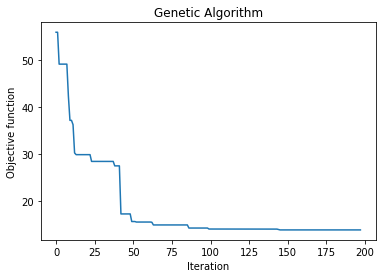

In [20]:
# definição do espaço de busca
varbounds = np.array([[-9, 9] for k in range(20)])

# definição do tipo das variáveis
vartypes = np.array([['real'] for k in range(20)])

# definição dos parâmetros do algoritmo genético
algorithm_param = {'max_num_iteration': 200,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':50}

# inicialização do modelo
gen_model = ga(function = objective_function, dimension = int(len(varbounds)), variable_type_mixed = vartypes,
          variable_boundaries = varbounds, algorithm_parameters = algorithm_param,
              function_timeout = 10000)

# execução do modelo
gen_model.run()

In [22]:
# extracting best simulations values
best_values = gen_model.output_dict['variable']

# inserting optimized values at data dictionaries
muHads = -20000
sigmaHads = 2000
mu_Kref = 1
sigma_Kref = 0.1
mu_A = 0.01
sigma_A = 0.001
mu_Ea = 35000
sigma_Ea = 3500
comp_list = pc_data['comp_list']

for i in range(len(comp_list)):
        # heat of adsorption
        pc_data['H_ads'][comp_list[i]] = best_values[i]*sigmaHads + muHads
        
        # referente adsorption constant
        pc_data['K_ref'][comp_list[i]] = best_values[i+4]*sigma_Kref + mu_Kref
    
for i in range(1,7):
    # pre-exponential factors
    kinetic_dict['pre_exponential'][i] = best_values[i+7]*sigma_A + mu_A

    # activation energy
    kinetic_dict['activation_energy'][i] = best_values[i+13]*sigma_Ea + mu_Ea

In [24]:
%%time
# extracting the inputs for the the Runge-Kutta model
m_rate = data.loc[0, 'm_in']
T0 = data.loc[0,'T_in']
P0 = data.loc[0, 'P_in']
initial_comp = data.loc[0, ['EB_in', 'oX_in', 'mX_in', 'pX_in']].values
initial_comp = [k/np.sum(initial_comp) for k in initial_comp] # value normalization
# extracting final mass composition from industrial data
final_comp = data.loc[i, ['EB_out', 'oX_out', 'mX_out', 'pX_out']].values
final_comp = [k/np.sum(final_comp) for k in final_comp]
Tf = data.loc[0, "T_out"]
Pf = data.loc[0, "P_out"]

print('Outlet Temperature: %.2f'%(Tf+273.15))
print('Outlet Pressure: %.2f'%(Pf))
print('Outlet Mass Composition: ', final_comp)

sim_data = runge_kutta(initial_comp, m_rate,T0, P0, N = 100)
sim_data

Outlet Temperature: 660.59
Outlet Pressure: 9.56
Outlet Mass Composition:  [0.13671540105851557, 0.1970599330140259, 0.462877653433317, 0.2033470124941416]
Wall time: 1.34 s


radius temperature   pressure       F_EB       F_oX       F_mX  \
0      1.297     640.339    10.6819  40.397133  14.092704  70.665701   
1   1.286323  640.448699  10.668905  40.128575  14.271467  70.446728   
2   1.275646  640.558672  10.655892  39.860464  14.446739  70.231361   
3    1.26497  640.668886   10.64286  39.592813  14.618704  70.019444   
4   1.254293   640.77931  10.629808  39.325636  14.787535  69.810829   
..       ...         ...        ...        ...        ...        ...   
95  0.282707  648.991808   9.352935  20.105923  24.986862  57.530379   
96   0.27203  649.036211   9.337822  19.993246    25.0715   57.43661   
97  0.261354  649.079289   9.322684  19.883325  25.155678  57.343405   
98  0.250677  649.121048   9.307519  19.776147  25.239392  57.250758   
99      0.24  649.161499   9.292329  19.671694  25.322643  57.158663   

         F_pX  
0    2.194708  
1    2.503476  
2    2.811682  
3    3.119285  
4    3.426247  
..        ...  
95  24.727082  
96   24.84889  
97  24.967838  
98  25.083949  
99  25.197247  

[100 rows x 7 columns]

In [25]:
def evaluate_model(ind_data, data_dict = pc_data, react_info = kinetic_dict, plot = True):
    
    # function to evaluate the optimized model error
    
    # inputs: validation data, data dictionary, reaction information dictionary
    # output: None
    
    # extracting important constants
    MM = data_dict['MM']
    
    # creating dataframe to store results
    store_columns = ['run', 'm_flow', 'real_T', 'real_P', 'real_w_EB', 'real_w_oX', 'real_w_mX', 'real_w_pX',
                    'sim_T', 'sim_P', 'sim_w_EB', 'sim_w_oX', 'sim_w_mX', 'sim_w_pX']
    results_df = pd.DataFrame(columns = store_columns)
    
    for i in range(ind_data.shape[0]):
        
        # extracting the inputs for the the Runge-Kutta model
        m_rate = ind_data.loc[i, 'm_in']
        T0 = ind_data.loc[i,'T_in']
        P0 = ind_data.loc[i, 'P_in']
        initial_comp = ind_data.loc[i, ['EB_in', 'oX_in', 'mX_in', 'pX_in']].values
        initial_comp = [k/np.sum(initial_comp) for k in initial_comp] # value normalization
        
        # execute simulation
        sim_data = runge_kutta(initial_comp, m_rate, T0, P0, N = 100)
        
        # extract target value
        target_data = sim_data.tail(1)
        T_calc = target_data['temperature'].values - 273.15
        P_calc = target_data['pressure'].values
        molar_flow = list(target_data[['F_EB', 'F_oX', 'F_mX', 'F_pX']].values)

        # convert the molar fraction to mass fraction
        mass_flow = [k*MM/1000 for k in molar_flow]
        mass_comp = [k/np.sum(mass_flow) for k in mass_flow]
        
        # extracting final mass composition from industrial data
        final_comp = ind_data.loc[i, ['EB_out', 'oX_out', 'mX_out', 'pX_out']].values
        final_comp = [k/np.sum(final_comp) for k in final_comp]
        Tf = ind_data.loc[i, "T_out"]
        Pf = ind_data.loc[i, "P_out"]
        
        # inserting into dataframe
        results_df.loc[i, store_columns] = i+1, m_rate, Tf, Pf, final_comp[0], final_comp[1], final_comp[2],\
                                           final_comp[3], T_calc, P_calc, mass_comp[0][0], mass_comp[0][1], \
                                           mass_comp[0][2], mass_comp[0][3]
    
    # making plots, if desired
    if plot:
        # define lists to plot standard
        plot_list = ['T', 'P', 'w_EB', 'w_oX', 'w_mX', 'w_pX']
        label_list = ['Outlet Temperature (°C)', 'Outlet Pressure (kgf/cm²)', 'Outlet Ethylbenzene fraction (% wt.)',
                 'Outlet o-Xylene fraction (% wt.)', 'Outlet m-Xylene fraction (% wt.)', 
                  'Outlet p-Xylene fraction (% wt.)']
        
        # create plot       
        for i in range(len(plot_list)):
            fig = plt.figure(figsize = (10,10))
            suffix = plot_list[i]
            MRE = np.sum(np.abs((results_df['real_'+suffix] - results_df['sim_'+suffix])/results_df['real_'+suffix]))
            MRE = MRE/results_df.shape[0]
            ax = fig.add_subplot(1,1,1)
            ax.plot(results_df['real_'+suffix], results_df['real_'+suffix], 'ko', label = 'Expected ' + label_list[i])
            ax.plot(results_df['real_'+suffix], results_df['sim_'+suffix], 'rs', label = 'Simulated ' + label_list[i])
            ax.set_xlabel('Expected ' + label_list[i], size = 14)
            ax.set_ylabel('Simulated ' + label_list[i], size = 14)
            ax.set_title('Simulation Validation - ' + label_list[i] + '\nMean Relative Error: %.2f %%'%(MRE*100), 
                         size = 18)
            ax.legend(prop={'size': 12})
            ax.grid()

Wall time: 1min 6s


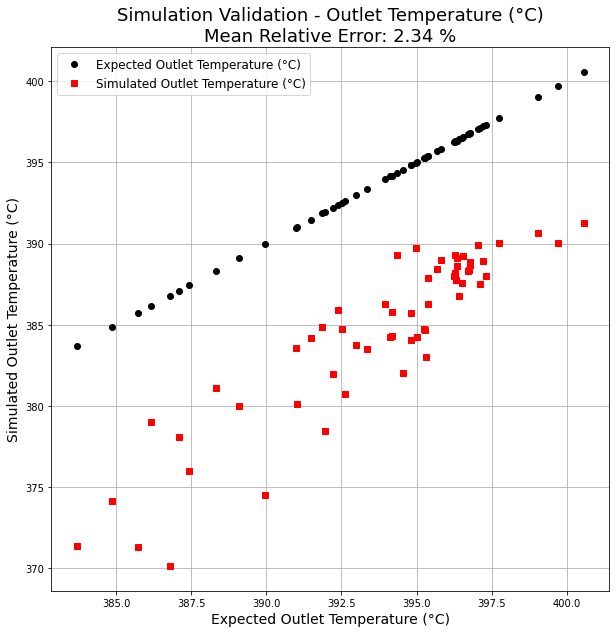

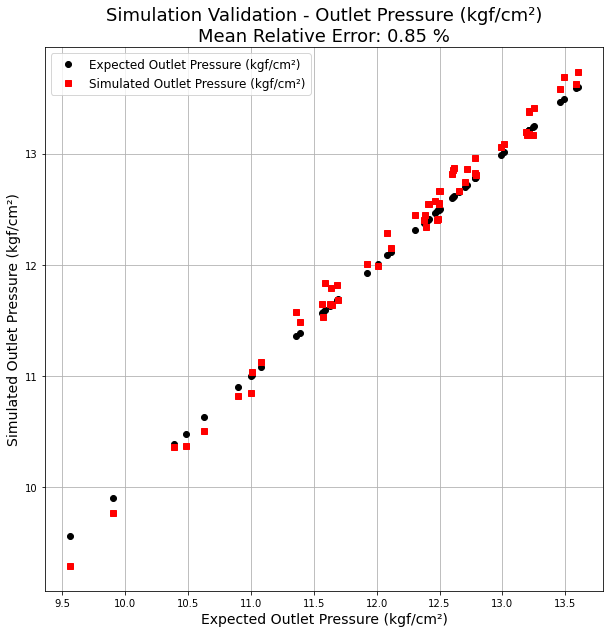

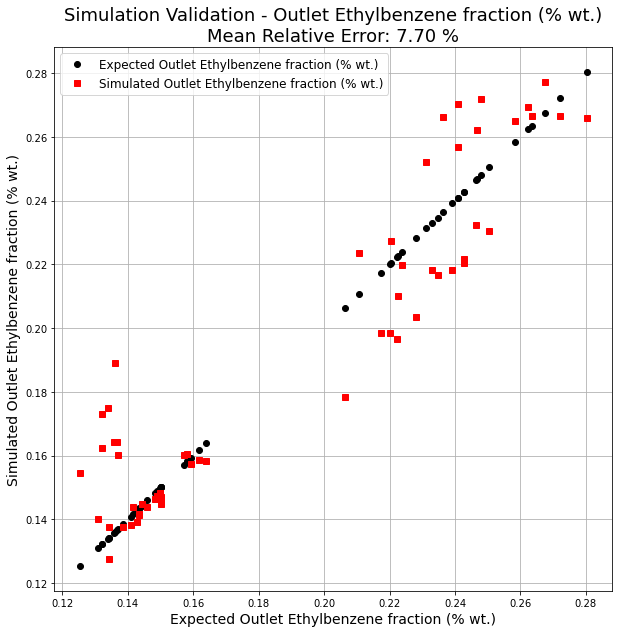

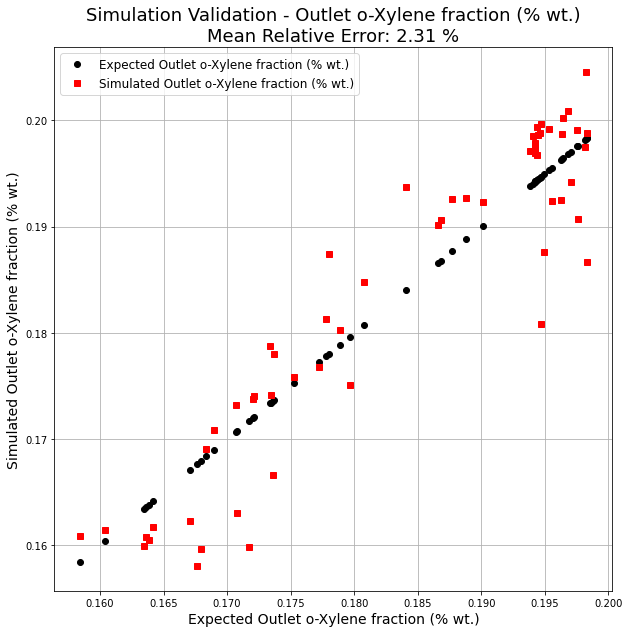

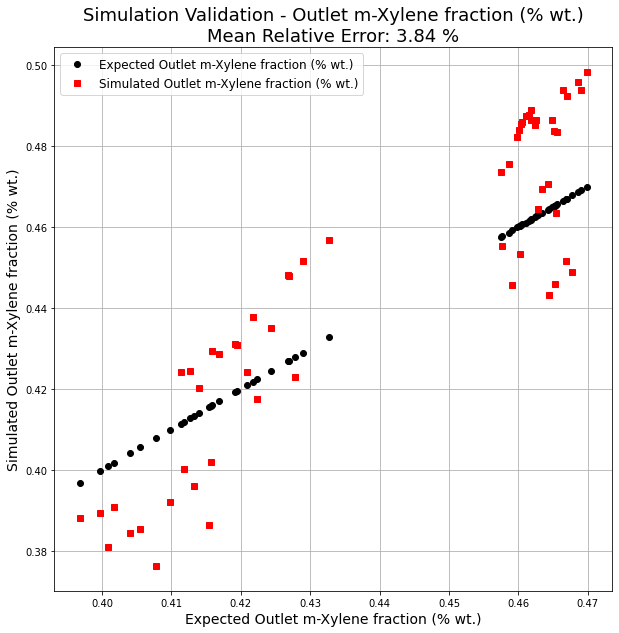

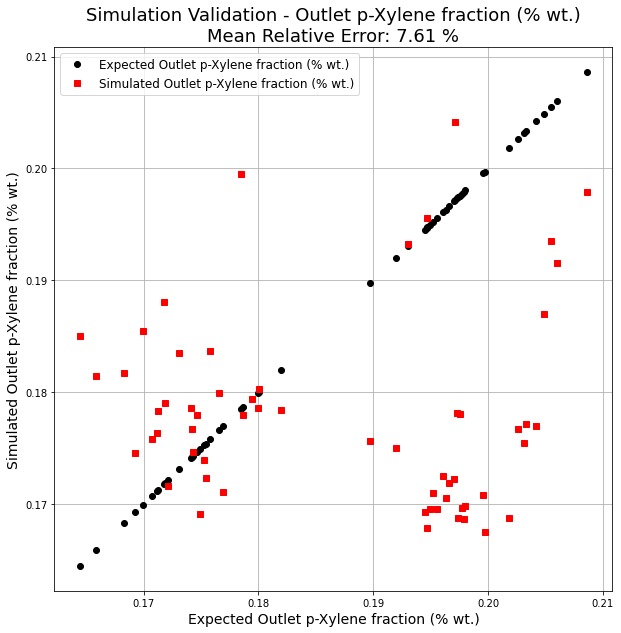

In [26]:
%%time
evaluate_model(data)

In [27]:
pc_data

{'MM': 106.165,
 'comp_list': ['EB', 'oX', 'mX', 'pX'],
 'vapor_viscosity': {'EB': {'C1': 4.223099999999999e-07,
   'C2': 0.58154,
   'C3': 239.21,
   'C4': 0},
  'oX': {'C1': 8.3436e-07, 'C2': 0.49713, 'C3': 365.86, 'C4': 0},
  'mX': {'C1': 6.829299999999999e-07, 'C2': 0.52199, 'C3': 324.17, 'C4': 0},
  'pX': {'C1': 9.348499999999999e-07, 'C2': 0.47683, 'C3': 371.96, 'C4': 0}},
 'IdealGasCp': {'EB': {'C1': 78440.0,
   'C2': 339900.0,
   'C3': 1559.0,
   'C4': 242600.00000000003,
   'C5': 702},
  'oX': {'C1': 85210.0,
   'C2': 329540.0,
   'C3': 1494.3999999999999,
   'C4': 211500.00000000003,
   'C5': 675.8},
  'pX': {'C1': 75120.0,
   'C2': 329540.0,
   'C3': 1492.8,
   'C4': 224700.0,
   'C5': 675.1},
  'mX': {'C1': 75680.0,
   'C2': 339240.0,
   'C3': 1496.0,
   'C4': 224700.0,
   'C5': 675.9}},
 'H0f': {'EB': 29920000.0,
  'oX': 19080000.0,
  'pX': 18030000.0,
  'mX': 17320000.0},
 'S0f': {'EB': 360630.0, 'oX': 353830.0, 'pX': 352165.0, 'mX': 358540.0},
 'H_ads': {'EB': -2990.1986

In [28]:
kinetic_dict

{'reactions': {1: 'Ethylbenzene <---> ortho-Xylene',
  2: 'Ethylbenzene <---> meta-Xylene',
  3: 'Ethylbenzene <---> para-Xylene',
  4: 'ortho-Xylene <---> meta-Xylene',
  5: 'ortho-Xylene <---> para-Xylene',
  6: 'meta-Xylene <---> para-Xylene'},
 'stoic': {1: [-1, 1, 0, 0],
  2: [-1, 0, 1, 0],
  3: [-1, 0, 0, 1],
  4: [0, -1, 1, 0],
  5: [0, -1, 0, 1],
  6: [0, 0, -1, 1]},
 'pre_exponential': {1: 0.01587884317578143,
  2: 0.017965385967471215,
  3: 0.00242432905766915,
  4: 0.0167352629223737,
  5: 0.00922099458065582,
  6: 0.017025589148203624},
 'activation_energy': {1: 57492.02190578224,
  2: 60849.61195326943,
  3: 11683.249995863782,
  4: 25022.213179207367,
  5: 21211.894456187838,
  6: 44301.892586283066},
 'kinetic_constants': {1: 4.748760064184598e-07,
  2: 2.924004111836073e-07,
  3: 0.00029187555485832295,
  4: 0.00017970132086335763,
  5: 0.00019748911501814816,
  6: 5.556978433133633e-06},
 'reaction_rates': {1: 3.8395164477779846e-07,
  2: 1.3406297725705808e-07,
  3: 0